### Hypo 2 on GSM not AMR with lesser amount of models

AMR-0 performs acutally worse in reconstruction by the models we set up

-> Need to prepare Dense-Dense-Dense model for comparison with every model in paper (https://stackoverflow.com/questions/50980113/evaluate-a-function-in-a-sliding-window-with-keras)

-> Maybe AMR-0 reconstruction needs far deeper layers? Or another method of reconstruction? How will it look with noise?

-> What are current observations?



##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/m

In [19]:
"""
for file in os.listdir("./NoiseBackup"):
    f = sio.read("./NoiseBackup/" + file)[1]
    print(file)
    display(Audio(f, rate=16000))
"""
soundscapes = ["352966__jamafel__open-air-swimming-pool.wav2.wav",
              "352967__jamafel__john-paul-2nd-city-park.wav2.wav",
              "187379__saphe__wroclaw-market-square.wav2.wav",
              "414169__klankbeeld__pineforest-winter-nl-03-171217-1250.wav2.wav",
               "354027__jamafel__stairs-near-ichot-museum.wav2.wav",
               "43760__digifishmusic__gentle-sea-on-flat-beach.wav2.wav",
               "50910__rutgermuller__in-car-driving.wav1.wav",
               "50911__rutgermuller__in-car-driving-with-open-window.wav2.wav",
               "57583__digifishmusic__palm-cove-waves.wav2.wav",
               "173955__saphe__street-scene-3.flac2.wav",
               "54577__digifishmusic__waves-on-rocks-tasmania.wav2.wav",
               "410526__klankbeeld__dripping-forest-nl-02-171104-1233.wav2.wav",
              ]


##### Model definition

In [15]:
model_callbacks = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1935)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_2 (Dense)              (None, None, 257)         526593    
Total para

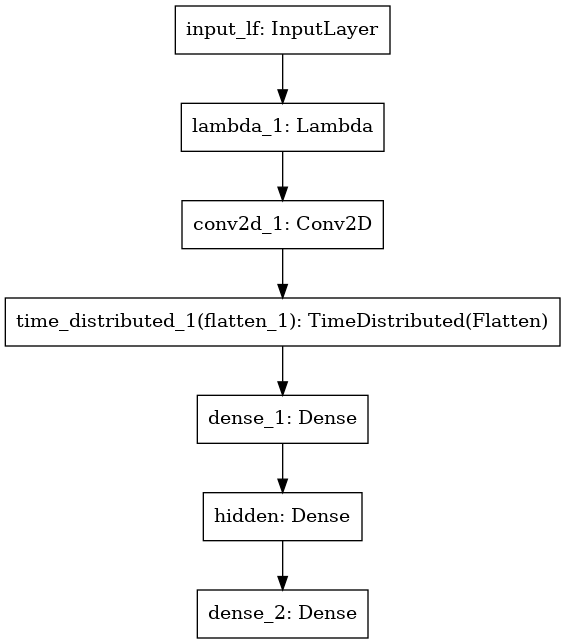

In [4]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    lyr = Lambda(K.expand_dims)(input_lower)
    windowing = Conv2D(15, (15, 1), padding='same', use_bias=False)
    lyr = windowing(lyr)
    windowing.set_weights([np.eye(15).reshape(15, 1, 1, 15)])
    windowing.trainable = False
    lyr = TimeDistributed(Flatten())(lyr)
    lyr = Dense(2048)(lyr)
    lyr = Dense(2048, name='hidden')(lyr)
    lf_and_hf = Dense(257)(lyr)
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, 129, 16 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, 129, 16 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

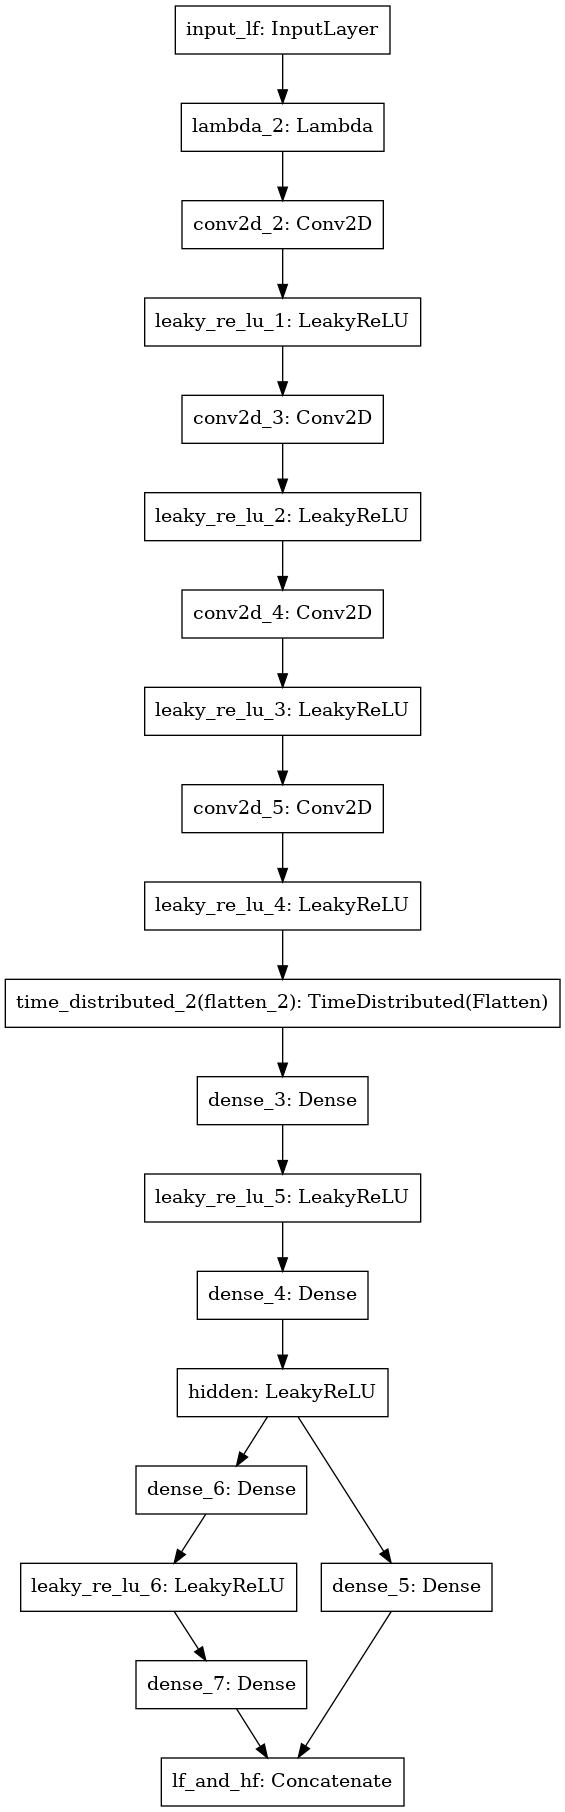

In [5]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(512)(layer))
    layer = Dense(128)(layer)
    lower = LeakyReLU(0.01)(Dense(256)(hidden))
    lower = Dense(129)(lower)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, None, 129, 16 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, 129, 20 1620        conv2d_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

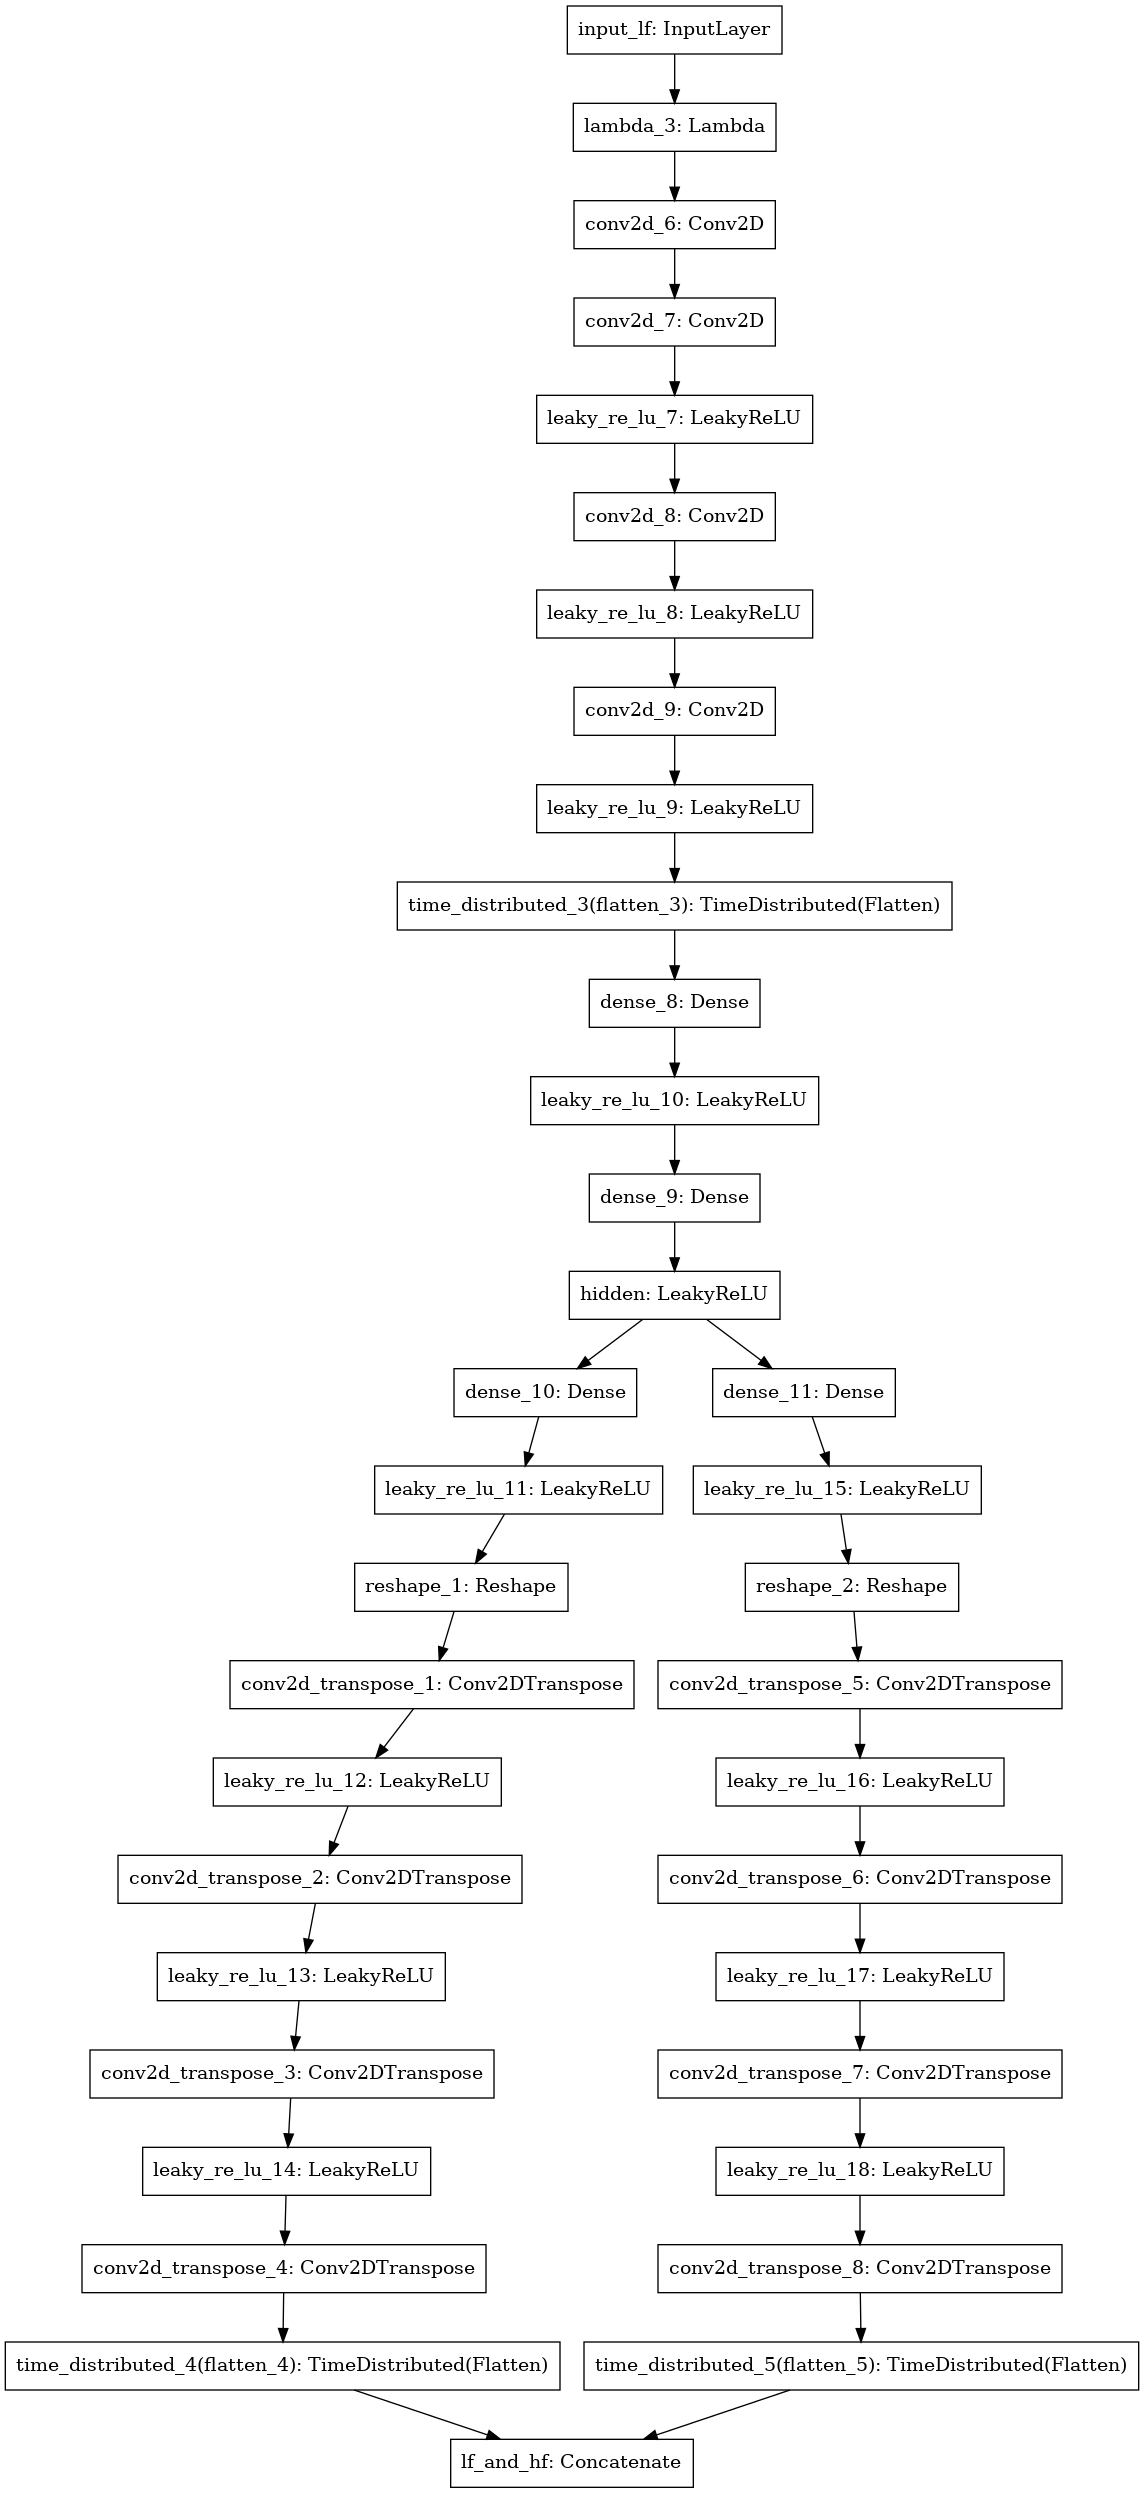

In [6]:
# baseline autoencoder

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1032)(hidden))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 129, 16 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, 129, 20 1620        conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

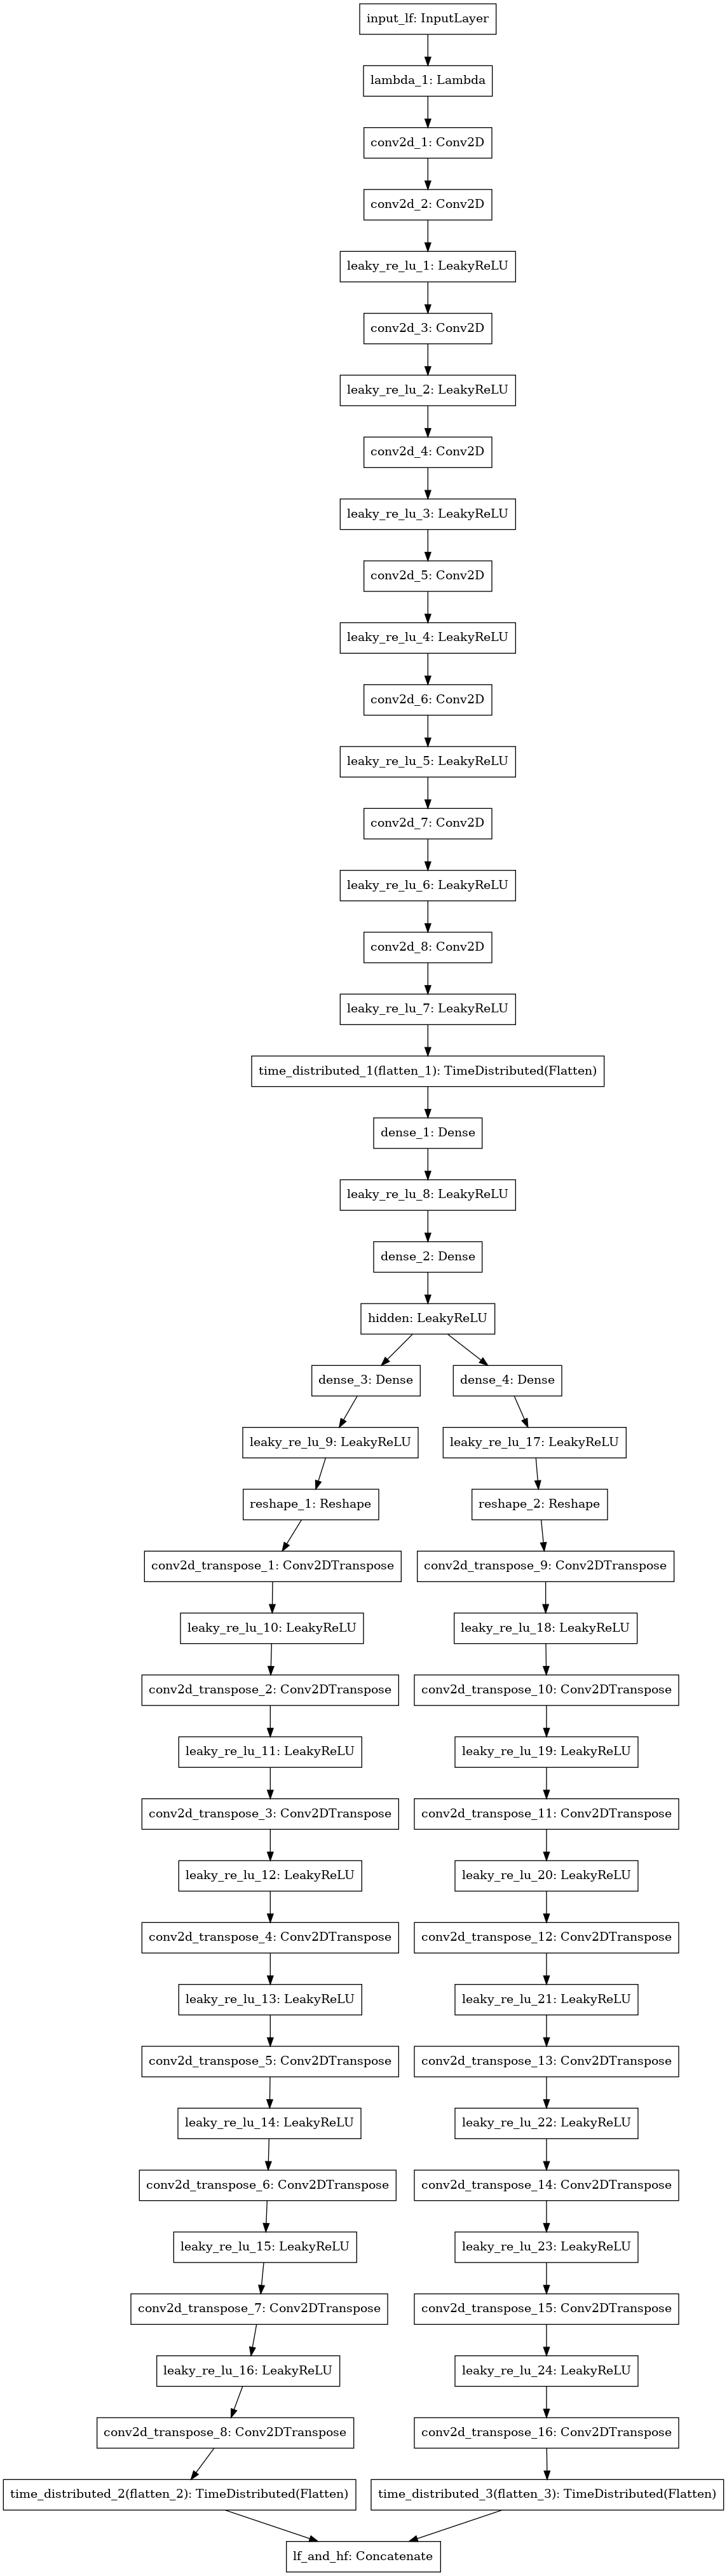

In [16]:
# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1032)(hidden))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

In [ ]:
# baseline autoencoder - deeped mid representation - 4 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(192)(hidden))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(1032)(layer))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

##### Data loading

In [20]:
TRAIN = 9000
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import scipy.signal as ss
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))

import random
noises = [os.path.join("./NoiseBackup", x) for x in soundscapes]

log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

SNR = 5 # dB
SNR /= 10. # B
SNR = np.log(10) * SNR

reverse_chance = 200

# envelope_filter_base = ss.butter(6, (20. / 8000.))
# envelope_filter = lambda signal: ss.lfilter(envelope_filter_base[0], envelope_filter_base[1], signal)

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    noise = sio.read(random.choice(noises))[1]
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    data = data[:176000]
    if len(noise) > len(data):
        start_point = random.randint(0, len(noise) - len(data))
    else:
        start_point = 0
    noise = noise[start_point:start_point+len(data)]
    if len(noise) < len(data):
        print("NOISE TOO SHORT:", len(noise))
        noise = np.pad(noise, ((0, len(data) - len(noise)),),'constant')
    log_power_of_signal = np.log((data.astype(np.float32) ** 2).mean())
    log_power_of_noise = np.log((noise.astype(np.float32) ** 2).mean())
    print("Clean // noise power mean before gain:", np.sqrt(np.exp(log_power_of_signal)), np.sqrt(np.exp(log_power_of_noise)))
    print("Clean // noise power mean before gain (log):", log_power_of_signal, log_power_of_noise)
    gain_of_noise = np.sqrt(np.exp(log_power_of_signal - SNR - log_power_of_noise))   # SNR was miscalculated...
    print("Noise difference - logpower:", log_power_of_signal - log_power_of_noise)
    print("Noise gain - multiplicatively:", gain_of_noise)
    if np.isnan(gain_of_noise):
        print("NAN gain - generating some random white noise")
        noise = np.random.normal(0, 1500, size=data.shape)
    else:
        noise = noise * gain_of_noise
    noised = data + noise
    print("Clean // noise peaks:", np.abs(data).max(), np.abs(noise).max())
    if np.abs(noised).max() >= 2**15 - 1:
        noised = noised / (np.abs(noised).max() / (2 ** 15 - 1))
    noised = noised.astype(np.int16)
    print("Amplitude of clean recording: ", np.abs(data).max())
    print("Amplitude of noised recording: ", np.abs(noised).max())
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, noised)
    tmpname = tempnam() + '.amr-nb'
    print(oldname)
    newname = dataset.root + "/" + file + ".gsm.wav"
    print(subprocess.Popen(['sox', oldname, '-C', '0', '-r',  '8000', tmpname], stderr=subprocess.PIPE, stdout=subprocess.PIPE).communicate())
    print(subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname], stderr=subprocess.PIPE, stdout=subprocess.PIPE).communicate())
    list(map(os.remove, [oldname, tmpname]))
    # display(Audio(noised, rate=16000))
    # input = sio.read(newname)[1]
    # print("New name: ", newname)
    # display(Audio(input, rate=16000))
    
window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
Clean // noise power mean before gain: 2519.071 593.3419
Clean // noise power mean before gain (log): 15.663291 12.771542
Noise difference - logpower: 2.8917494
Noise gain - multiplicatively: 2.387456128630057
Clean // noise peaks: 18153 10538.231351773073
Amplitude of clean recording:  18153
Amplitude of noised recording:  20122
/tmp/tmp55e9792e.oldwav
(b'', b'')
(b'', b'')
1
Clean // noise power mean before gain: 3078.3657 4691.011
Clean // noise power mean before gain (log): 16.064308 16.906807
Noise difference - logpower: -0.8424988
Noise gain - multiplicatively: 0.3690232374161259
Clean // noise peaks: 16891 11408.353384719532
Amplitude of clean recording:  16891
Amplitude of noised recording:  18371
/tmp/tmpn9tnota2.oldwav
(b'', b'')
(b'', b'')
2
Clean // noise power mean before gain: 2284.659 603.8625
Clean // noise power mean before gain (log): 15.467944 12.806693
Noise difference - logpower: 2.661251
Noise gain - multiplicatively: 2.1275673988713204
Clean // noise peaks: 173

(b'', b'')
(b'', b'')
23
Clean // noise power mean before gain: 2156.5432 4596.5864
Clean // noise power mean before gain (log): 15.352524 16.866138
Noise difference - logpower: -1.5136147
Noise gain - multiplicatively: 0.26382913520064816
Clean // noise peaks: 14433 8156.277714728038
Amplitude of clean recording:  14433
Amplitude of noised recording:  14582
/tmp/tmprm2o_bti.oldwav
(b'', b'')
(b'', b'')
24
Clean // noise power mean before gain: 1993.577 4866.5566
Clean // noise power mean before gain (log): 15.195372 16.980284
Noise difference - logpower: -1.7849121
Noise gain - multiplicatively: 0.23036222261790945
Clean // noise peaks: 13714 7121.64811223267
Amplitude of clean recording:  13714
Amplitude of noised recording:  15758
/tmp/tmp0zmp3t_g.oldwav
(b'', b'')
(b'', b'')
25
Clean // noise power mean before gain: 2275.0154 788.36035
Clean // noise power mean before gain (log): 15.459484 13.3399105
Noise difference - logpower: 2.1195736
Noise gain - multiplicatively: 1.6227796680

(b'', b'')
45
Clean // noise power mean before gain: 1218.8247 450.52542
Clean // noise power mean before gain (log): 14.211285 12.220829
Noise difference - logpower: 1.9904556
Noise gain - multiplicatively: 1.52132480954025
Clean // noise peaks: 11990 4218.633696855113
Amplitude of clean recording:  11990
Amplitude of noised recording:  11947
/tmp/tmp70t55uy0.oldwav
(b'', b'')
(b'', b'')
46
Clean // noise power mean before gain: 2243.369 255.52461
Clean // noise power mean before gain (log): 15.431468 11.0866375
Noise difference - logpower: 4.3448305
Noise gain - multiplicatively: 4.937054919370068
Clean // noise peaks: 14848 5934.340013082821
Amplitude of clean recording:  14848
Amplitude of noised recording:  16449
/tmp/tmp89z__qv3.oldwav
(b'', b'')
(b'', b'')
47
Clean // noise power mean before gain: 1684.2382 444.404
Clean // noise power mean before gain (log): 14.858137 12.193468
Noise difference - logpower: 2.664669
Noise gain - multiplicatively: 2.1312064869994245
Clean // nois

(b'', b'')
(b'', b'')
67
Clean // noise power mean before gain: 1008.62494 1050.5027
Clean // noise power mean before gain (log): 13.832686 13.914048
Noise difference - logpower: -0.08136177
Noise gain - multiplicatively: 0.5399238550336715
Clean // noise peaks: 10052 3812.402340392754
Amplitude of clean recording:  10052
Amplitude of noised recording:  10483
/tmp/tmpi_h1rsyu.oldwav
(b'', b'')
(b'', b'')
68
Clean // noise power mean before gain: 2667.7188 1212.6469
Clean // noise power mean before gain (log): 15.777958 14.201121
Noise difference - logpower: 1.5768366
Noise gain - multiplicatively: 1.2371025841364858
Clean // noise peaks: 17285 10256.817525075603
Amplitude of clean recording:  17285
Amplitude of noised recording:  18079
/tmp/tmp3j_8vy6y.oldwav
(b'', b'')
(b'', b'')
69
Clean // noise power mean before gain: 2366.1448 817.93225
Clean // noise power mean before gain (log): 15.538034 13.413559
Noise difference - logpower: 2.1244755
Noise gain - multiplicatively: 1.626761886

(b'', b'sox WARN rate: rate clipped 4 samples; decrease volume?\nsox WARN dither: dither clipped 3 samples; decrease volume?\n')
(b'', b'sox WARN rate: rate clipped 8 samples; decrease volume?\nsox WARN dither: dither clipped 7 samples; decrease volume?\n')
90
Clean // noise power mean before gain: 1434.865 405.3834
Clean // noise power mean before gain (log): 14.537652 12.009666
Noise difference - logpower: 2.5279856
Noise gain - multiplicatively: 1.9904216747703622
Clean // noise peaks: 19145 5037.757258843787
Amplitude of clean recording:  19145
Amplitude of noised recording:  18888
/tmp/tmpaw3fllu3.oldwav
(b'', b'')
(b'', b'')
91
Clean // noise power mean before gain: 1326.8712 1373.9385
Clean // noise power mean before gain (log): 14.381158 14.450873
Noise difference - logpower: -0.0697155
Noise gain - multiplicatively: 0.543077076642214
Clean // noise peaks: 22697 4755.1828830792265
Amplitude of clean recording:  22697
Amplitude of noised recording:  23514
/tmp/tmpsaocbd2d.oldwav

(b'', b'')
(b'', b'')
112
Clean // noise power mean before gain: 831.6277 1423.191
Clean // noise power mean before gain (log): 13.44677 14.521314
Noise difference - logpower: -1.074544
Noise gain - multiplicatively: 0.3285986276573808
Clean // noise peaks: 10303 3284.3432834355212
Amplitude of clean recording:  10303
Amplitude of noised recording:  10390
/tmp/tmpic5emv71.oldwav
(b'', b'')
(b'', b'')
113
Clean // noise power mean before gain: 1933.3304 1165.4922
Clean // noise power mean before gain (log): 15.133999 14.121798
Noise difference - logpower: 1.0122013
Noise gain - multiplicatively: 0.9328175785385883
Clean // noise peaks: 13746 5825.445777973484
Amplitude of clean recording:  13746
Amplitude of noised recording:  15134
/tmp/tmp_k_fphif.oldwav
(b'', b'')
(b'', b'')
114
Clean // noise power mean before gain: 1999.4634 826.0882
Clean // noise power mean before gain (log): 15.201268 13.433403
Noise difference - logpower: 1.7678652
Noise gain - multiplicatively: 1.3610906368622

(b'', b'')
134
Clean // noise power mean before gain: 2008.9523 1139.9674
Clean // noise power mean before gain (log): 15.210737 14.07751
Noise difference - logpower: 1.1332273
Noise gain - multiplicatively: 0.9910080722902253
Clean // noise peaks: 18871 7927.073570249512
Amplitude of clean recording:  18871
Amplitude of noised recording:  19752
/tmp/tmpus1mqzfk.oldwav
(b'', b'')
(b'', b'')
135
Clean // noise power mean before gain: 2354.9934 597.6401
Clean // noise power mean before gain (log): 15.528586 12.785977
Noise difference - logpower: 2.742609
Noise gain - multiplicatively: 2.215899107573914
Clean // noise peaks: 18648 9780.978660831257
Amplitude of clean recording:  18648
Amplitude of noised recording:  20051
/tmp/tmpuhrc3slh.oldwav
(b'', b'')
(b'', b'')
136
Clean // noise power mean before gain: 1812.4792 1331.8739
Clean // noise power mean before gain (log): 15.004902 14.388684
Noise difference - logpower: 0.6162176
Noise gain - multiplicatively: 0.765261658303865
Clean // 

(b'', b'')
(b'', b'')
157
Clean // noise power mean before gain: 2388.1335 374.42044
Clean // noise power mean before gain (log): 15.556535 11.850759
Noise difference - logpower: 3.7057762
Noise gain - multiplicatively: 3.586733264460566
Clean // noise peaks: 21709 5785.400755574893
Amplitude of clean recording:  21709
Amplitude of noised recording:  23294
/tmp/tmprm9lo9v4.oldwav
(b'', b'')
(b'', b'')
158
Clean // noise power mean before gain: 1793.3221 1477.9551
Clean // noise power mean before gain (log): 14.98365 14.596829
Noise difference - logpower: 0.3868208
Noise gain - multiplicatively: 0.6823340875279555
Clean // noise peaks: 17391 6819.929204841916
Amplitude of clean recording:  17391
Amplitude of noised recording:  18293
/tmp/tmpi5s37eh2.oldwav
(b'', b'')
(b'', b'')
159
Clean // noise power mean before gain: 2063.427 1612.8113
Clean // noise power mean before gain (log): 15.264247 14.771468
Noise difference - logpower: 0.49277878
Noise gain - multiplicatively: 0.719458175561

(b'', b'')
(b'', b'')
180
Clean // noise power mean before gain: 1912.5823 930.59973
Clean // noise power mean before gain (log): 15.112419 13.6716585
Noise difference - logpower: 1.4407606
Noise gain - multiplicatively: 1.1557321427708984
Clean // noise peaks: 22985 7757.27414227827
Amplitude of clean recording:  22985
Amplitude of noised recording:  24924
/tmp/tmpq4wqz5x7.oldwav
(b'', b'')
(b'', b'')
181
Clean // noise power mean before gain: 2458.663 930.61304
Clean // noise power mean before gain (log): 15.614746 13.671687
Noise difference - logpower: 1.943059
Noise gain - multiplicatively: 1.485695793819118
Clean // noise peaks: 14648 9971.99016811392
Amplitude of clean recording:  14648
Amplitude of noised recording:  18741
/tmp/tmpxanuleuo.oldwav
(b'', b'')
(b'', b'')
182
Clean // noise power mean before gain: 2535.7083 613.9358
Clean // noise power mean before gain (log): 15.676456 12.839781
Noise difference - logpower: 2.8366756
Noise gain - multiplicatively: 2.322609989250983

(b'', b'')
(b'', b'')
202
Clean // noise power mean before gain: 1991.1705 1012.7092
Clean // noise power mean before gain (log): 15.192956 13.840769
Noise difference - logpower: 1.3521872
Noise gain - multiplicatively: 1.1056653772315501
Clean // noise peaks: 15714 6268.017023525657
Amplitude of clean recording:  15714
Amplitude of noised recording:  16168
/tmp/tmp0lo_y72d.oldwav
(b'', b'')
(b'', b'')
203
Clean // noise power mean before gain: 1637.5596 751.00214
Clean // noise power mean before gain (log): 14.801925 13.242817
Noise difference - logpower: 1.5591078
Noise gain - multiplicatively: 1.226184869561914
Clean // noise peaks: 15184 10296.274349711392
Amplitude of clean recording:  15184
Amplitude of noised recording:  15416
/tmp/tmptv17stdb.oldwav
(b'', b'')
(b'', b'')
204
Clean // noise power mean before gain: 1500.425 227.0232
Clean // noise power mean before gain (log): 14.6270075 10.850104
Noise difference - logpower: 3.7769032
Noise gain - multiplicatively: 3.71658524931

(b'', b'')
(b'', b'')
225
Clean // noise power mean before gain: 1639.5426 5450.5654
Clean // noise power mean before gain (log): 14.804345 17.20695
Noise difference - logpower: -2.402604
Noise gain - multiplicatively: 0.1691535621610514
Clean // noise peaks: 21169 5268.795154192429
Amplitude of clean recording:  21169
Amplitude of noised recording:  21507
/tmp/tmpddt92bze.oldwav
(b'', b'')
(b'', b'')
226
Clean // noise power mean before gain: 1575.4866 4574.424
Clean // noise power mean before gain (log): 14.724639 16.856472
Noise difference - logpower: -2.131833
Noise gain - multiplicatively: 0.19367712481565202
Clean // noise peaks: 19338 4653.673955070487
Amplitude of clean recording:  19338
Amplitude of noised recording:  18924
/tmp/tmphccega_r.oldwav
(b'', b'')
(b'', b'')
227
Clean // noise power mean before gain: 1397.5547 603.1698
Clean // noise power mean before gain (log): 14.484959 12.804398
Noise difference - logpower: 1.6805611
Noise gain - multiplicatively: 1.302954345563

(b'', b'')
247
Clean // noise power mean before gain: 1970.774 613.62384
Clean // noise power mean before gain (log): 15.172363 12.838764
Noise difference - logpower: 2.333599
Noise gain - multiplicatively: 1.8060701049434984
Clean // noise peaks: 14511 11542.594040693899
Amplitude of clean recording:  14511
Amplitude of noised recording:  15459
/tmp/tmpuqrzxg9d.oldwav
(b'', b'')
(b'', b'')
248
Clean // noise power mean before gain: 2067.4148 5252.1157
Clean // noise power mean before gain (log): 15.268108 17.132772
Noise difference - logpower: -1.8646641
Noise gain - multiplicatively: 0.22135704074107468
Clean // noise peaks: 22940 6894.829105002994
Amplitude of clean recording:  22940
Amplitude of noised recording:  24259
/tmp/tmpk3fxs109.oldwav
(b'', b'')
(b'', b'')
249
Clean // noise power mean before gain: 1970.4216 233.77744
Clean // noise power mean before gain (log): 15.172006 10.908739
Noise difference - logpower: 4.2632666
Noise gain - multiplicatively: 4.739762402800841
Clea

(b'', b'')
(b'', b'')
269
Clean // noise power mean before gain: 1636.697 266.1305
Clean // noise power mean before gain (log): 14.800871 11.1679735
Noise difference - logpower: 3.6328974
Noise gain - multiplicatively: 3.458387414515481
Clean // noise peaks: 11680 5353.583717669965
Amplitude of clean recording:  11680
Amplitude of noised recording:  12292
/tmp/tmpenr3rarn.oldwav
(b'', b'')
(b'', b'')
270
Clean // noise power mean before gain: 1692.8307 568.90326
Clean // noise power mean before gain (log): 14.868315 12.687421
Noise difference - logpower: 2.180894
Noise gain - multiplicatively: 1.673304938314208
Clean // noise peaks: 18525 7385.967997718914
Amplitude of clean recording:  18525
Amplitude of noised recording:  18857
/tmp/tmplbx8vi42.oldwav
(b'', b'')
(b'', b'')
271
Clean // noise power mean before gain: 1793.0544 1224.9921
Clean // noise power mean before gain (log): 14.983352 14.221379
Noise difference - logpower: 0.7619724
Noise gain - multiplicatively: 0.82311442037664

(b'', b'')
291
Clean // noise power mean before gain: 2163.1057 1456.932
Clean // noise power mean before gain (log): 15.358601 14.568176
Noise difference - logpower: 0.79042435
Noise gain - multiplicatively: 0.8349076994796159
Clean // noise peaks: 15815 6908.026305494342
Amplitude of clean recording:  15815
Amplitude of noised recording:  16764
/tmp/tmpkv78b2bn.oldwav
(b'', b'')
(b'', b'')
292
Clean // noise power mean before gain: 2338.7334 5799.452
Clean // noise power mean before gain (log): 15.5147295 17.331038
Noise difference - logpower: -1.816308
Noise gain - multiplicatively: 0.22677424222351272
Clean // noise peaks: 15270 5448.931492146564
Amplitude of clean recording:  15270
Amplitude of noised recording:  17452
/tmp/tmp4im27i14.oldwav
(b'', b'')
(b'', b'')
293
Clean // noise power mean before gain: 1345.8173 1098.1438
Clean // noise power mean before gain (log): 14.409513 14.002753
Noise difference - logpower: 0.40676022
Noise gain - multiplicatively: 0.6891707847141177
Cl

Clean // noise power mean before gain: 1686.1128 1005.12103
Clean // noise power mean before gain (log): 14.860362 13.8257265
Noise difference - logpower: 1.0346355
Noise gain - multiplicatively: 0.9433400080780429
Clean // noise peaks: 19211 4115.792455244501
Amplitude of clean recording:  19211
Amplitude of noised recording:  18826
/tmp/tmpzlq01p8t.oldwav
(b'', b'')
(b'', b'')
314
Clean // noise power mean before gain: 1352.1243 724.6298
Clean // noise power mean before gain (log): 14.418864 13.171322
Noise difference - logpower: 1.2475424
Noise gain - multiplicatively: 1.04930172317559
Clean // noise peaks: 16684 3305.300428003108
Amplitude of clean recording:  16684
Amplitude of noised recording:  17608
/tmp/tmpgnbcteg6.oldwav
(b'', b'')
(b'', b'')
315
Clean // noise power mean before gain: 1048.1415 1094.8707
Clean // noise power mean before gain (log): 13.909548 13.996783
Noise difference - logpower: -0.08723545
Noise gain - multiplicatively: 0.5383405111801363
Clean // noise pea

(b'', b'')
(b'', b'')
335
Clean // noise power mean before gain: 792.0968 744.5881
Clean // noise power mean before gain (log): 13.349367 13.225662
Noise difference - logpower: 0.12370491
Noise gain - multiplicatively: 0.5982217238341888
Clean // noise peaks: 14213 1884.3984300776947
Amplitude of clean recording:  14213
Amplitude of noised recording:  14184
/tmp/tmp876drbbt.oldwav
(b'', b'')
(b'', b'')
336
Clean // noise power mean before gain: 1963.0251 972.06177
Clean // noise power mean before gain (log): 15.164484 13.758839
Noise difference - logpower: 1.4056454
Noise gain - multiplicatively: 1.1356173366294964
Clean // noise peaks: 15189 8455.80668854323
Amplitude of clean recording:  15189
Amplitude of noised recording:  16651
/tmp/tmpauhgvwn7.oldwav
(b'', b'')
(b'', b'')
337
Clean // noise power mean before gain: 1952.724 770.1828
Clean // noise power mean before gain (log): 15.153961 13.293256
Noise difference - logpower: 1.8607054
Noise gain - multiplicatively: 1.4257620099022

(b'', b'')
(b'', b'')
357
Clean // noise power mean before gain: 983.9671 1138.2261
Clean // noise power mean before gain (log): 13.783185 14.074452
Noise difference - logpower: -0.2912674
Noise gain - multiplicatively: 0.48612962586498065
Clean // noise peaks: 15815 3137.96673495845
Amplitude of clean recording:  15815
Amplitude of noised recording:  15756
/tmp/tmplgifxpjy.oldwav
(b'', b'')
(b'', b'')
358
Clean // noise power mean before gain: 2903.5242 1131.8492
Clean // noise power mean before gain (log): 15.947361 14.063216
Noise difference - logpower: 1.8841448
Noise gain - multiplicatively: 1.4425698170470604
Clean // noise peaks: 13962 7127.737466029525
Amplitude of clean recording:  13962
Amplitude of noised recording:  16847
/tmp/tmpxxvslij8.oldwav
(b'', b'')
(b'', b'')
359
Clean // noise power mean before gain: 2730.8176 1033.7183
Clean // noise power mean before gain (log): 15.824713 13.881835
Noise difference - logpower: 1.9428778
Noise gain - multiplicatively: 1.4855611972

(b'', b'')
(b'', b'')
379
Clean // noise power mean before gain: 2364.6199 442.80188
Clean // noise power mean before gain (log): 15.536745 12.186245
Noise difference - logpower: 3.3505
Noise gain - multiplicatively: 3.0029759495379467
Clean // noise peaks: 12081 8666.588590366515
Amplitude of clean recording:  12081
Amplitude of noised recording:  15607
/tmp/tmpbc5zw7_2.oldwav
(b'', b'')
(b'', b'')
380
Clean // noise power mean before gain: 1794.3118 977.8632
Clean // noise power mean before gain (log): 14.984754 13.77074
Noise difference - logpower: 1.214014
Noise gain - multiplicatively: 1.031857682942101
Clean // noise peaks: 19518 4559.779100921144
Amplitude of clean recording:  19518
Amplitude of noised recording:  18736
/tmp/tmpf_xj7_q2.oldwav
(b'', b'')
(b'', b'')
381
Clean // noise power mean before gain: 2266.0496 1433.6462
Clean // noise power mean before gain (log): 15.451587 14.535953
Noise difference - logpower: 0.91563416
Noise gain - multiplicatively: 0.8888478587643954

(b'', b'')
401
Clean // noise power mean before gain: 2259.9841 569.7807
Clean // noise power mean before gain (log): 15.446226 12.690503
Noise difference - logpower: 2.755723
Noise gain - multiplicatively: 2.2304764704718356
Clean // noise peaks: 14676 9845.323140662682
Amplitude of clean recording:  14676
Amplitude of noised recording:  16000
/tmp/tmpht42a_j8.oldwav
(b'', b'')
(b'', b'')
402
Clean // noise power mean before gain: 3365.6167 1562.9563
Clean // noise power mean before gain (log): 16.242733 14.708669
Noise difference - logpower: 1.5340643
Noise gain - multiplicatively: 1.2109266260791824
Clean // noise peaks: 21428 11307.632834327405
Amplitude of clean recording:  21428
Amplitude of noised recording:  24748
/tmp/tmp50tgrs3j.oldwav
(b'', b'')
(b'', b'')
403
Clean // noise power mean before gain: 1462.485 793.8157
Clean // noise power mean before gain (log): 14.575785 13.353703
Noise difference - logpower: 1.2220821
Noise gain - multiplicatively: 1.0360286478110592
Clean /

(b'', b'')
423
Clean // noise power mean before gain: 967.0972 1134.5808
Clean // noise power mean before gain (log): 13.748598 14.068037
Noise difference - logpower: -0.31943893
Noise gain - multiplicatively: 0.4793301165178311
Clean // noise peaks: 15513 3569.09204759177
Amplitude of clean recording:  15513
Amplitude of noised recording:  15529
/tmp/tmp5q2231kh.oldwav
(b'', b'')
(b'', b'')
424
Clean // noise power mean before gain: 1401.8864 1389.8165
Clean // noise power mean before gain (log): 14.491148 14.473854
Noise difference - logpower: 0.01729393
Noise gain - multiplicatively: 0.5672249548206882
Clean // noise peaks: 11668 5093.680094289781
Amplitude of clean recording:  11668
Amplitude of noised recording:  11610
/tmp/tmp617jfovo.oldwav
(b'', b'')
(b'', b'')
425
Clean // noise power mean before gain: 1467.3909 759.6862
Clean // noise power mean before gain (log): 14.582482 13.265811
Noise difference - logpower: 1.3166714
Noise gain - multiplicatively: 1.0862043946251296
Clea

(b'', b'')
(b'', b'')
445
Clean // noise power mean before gain: 1944.9655 1255.7694
Clean // noise power mean before gain (log): 15.145999 14.271008
Noise difference - logpower: 0.8749914
Noise gain - multiplicatively: 0.8709675448336611
Clean // noise peaks: 21866 7251.675778285063
Amplitude of clean recording:  21866
Amplitude of noised recording:  23524
/tmp/tmp_kceuhig.oldwav
(b'', b'')
(b'', b'')
446
Clean // noise power mean before gain: 2042.0955 4014.5627
Clean // noise power mean before gain (log): 15.2434635 16.595367
Noise difference - logpower: -1.3519039
Noise gain - multiplicatively: 0.286047261746977
Clean // noise peaks: 14023 5151.711184063055
Amplitude of clean recording:  14023
Amplitude of noised recording:  14838
/tmp/tmpnghv0_ed.oldwav
(b'', b'')
(b'', b'')
447
Clean // noise power mean before gain: 1820.6198 916.52124
Clean // noise power mean before gain (log): 15.0138645 13.6411705
Noise difference - logpower: 1.372694
Noise gain - multiplicatively: 1.11706055

(b'', b'')
(b'', b'')
467
Clean // noise power mean before gain: 1704.7936 442.0652
Clean // noise power mean before gain (log): 14.882399 12.182915
Noise difference - logpower: 2.6994839
Noise gain - multiplicatively: 2.1686300666016196
Clean // noise peaks: 15599 6258.666372212274
Amplitude of clean recording:  15599
Amplitude of noised recording:  14950
/tmp/tmpahnhhrdf.oldwav
(b'', b'')
(b'', b'')
468
Clean // noise power mean before gain: 1109.2404 605.8237
Clean // noise power mean before gain (log): 14.0228615 12.813178
Noise difference - logpower: 1.2096834
Noise gain - multiplicatively: 1.0296258006461585
Clean // noise peaks: 12803 6580.338491929599
Amplitude of clean recording:  12803
Amplitude of noised recording:  13325
/tmp/tmp6rxeoqos.oldwav
(b'', b'')
(b'', b'')
469
Clean // noise power mean before gain: 2192.599 1667.0133
Clean // noise power mean before gain (log): 15.385686 14.837578
Noise difference - logpower: 0.5481081
Noise gain - multiplicatively: 0.739639611571

(b'', b'')
(b'', b'')
490
Clean // noise power mean before gain: 2253.0955 1336.0396
Clean // noise power mean before gain (log): 15.440121 14.39493
Noise difference - logpower: 1.0451908
Noise gain - multiplicatively: 0.9483317718278402
Clean // noise peaks: 16329 8303.592994124569
Amplitude of clean recording:  16329
Amplitude of noised recording:  17037
/tmp/tmp7spg0elg.oldwav
(b'', b'')
(b'', b'')
491
Clean // noise power mean before gain: 2062.2683 1034.3646
Clean // noise power mean before gain (log): 15.2631235 13.883085
Noise difference - logpower: 1.3800383
Noise gain - multiplicatively: 1.1211700835874618
Clean // noise peaks: 18884 5751.602528803679
Amplitude of clean recording:  18884
Amplitude of noised recording:  19808
/tmp/tmpraa23a2m.oldwav
(b'', b'')
(b'', b'')
492
Clean // noise power mean before gain: 2367.1345 1620.8872
Clean // noise power mean before gain (log): 15.538871 14.781458
Noise difference - logpower: 0.7574129
Noise gain - multiplicatively: 0.8212400556

/tmp/tmpt0pdmg6f.oldwav
(b'', b'')
(b'', b'')
512
Clean // noise power mean before gain: 3149.0747 3866.4084
Clean // noise power mean before gain (log): 16.109728 16.520163
Noise difference - logpower: -0.41043472
Noise gain - multiplicatively: 0.4580102868730363
Clean // noise peaks: 21875 8248.765266583383
Amplitude of clean recording:  21875
Amplitude of noised recording:  23586
/tmp/tmp7nduft4c.oldwav
(b'', b'')
(b'', b'')
513
Clean // noise power mean before gain: 2125.6528 806.823
Clean // noise power mean before gain (log): 15.3236685 13.386209
Noise difference - logpower: 1.93746
Noise gain - multiplicatively: 1.4815423886315926
Clean // noise peaks: 19278 14443.556746769396
Amplitude of clean recording:  19278
Amplitude of noised recording:  21022
/tmp/tmplb13js1k.oldwav
(b'', b'')
(b'', b'')
514
Clean // noise power mean before gain: 3843.0134 1392.4633
Clean // noise power mean before gain (log): 16.508024 14.477659
Noise difference - logpower: 2.030365
Noise gain - multipl

(b'', b'')
(b'', b'')
533
Clean // noise power mean before gain: 1721.0466 1124.4912
Clean // noise power mean before gain (log): 14.901376 14.050172
Noise difference - logpower: 0.8512039
Noise gain - multiplicatively: 0.8606698358396673
Clean // noise peaks: 18090 6143.461288223545
Amplitude of clean recording:  18090
Amplitude of noised recording:  18772
/tmp/tmpl_zzjs31.oldwav
(b'', b'')
(b'', b'')
534
Clean // noise power mean before gain: 6663.464 4687.434
Clean // noise power mean before gain (log): 17.60879 16.905281
Noise difference - logpower: 0.7035084
Noise gain - multiplicatively: 0.7994013973476255
Clean // noise peaks: 32672 24713.49419900184
Amplitude of clean recording:  32672
Amplitude of noised recording:  32766
/tmp/tmpploy6k0k.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 11 samples; decrease volume?\nsox WARN dither: dither clipped 10 samples; decrease volume?\n')
535
Clean // noise power mean before gain: 1944.9312 605.31
Clean // noise power mean before 

(b'', b'')
(b'', b'')
554
Clean // noise power mean before gain: 2974.3699 249.2152
Clean // noise power mean before gain (log): 15.995575 11.0366335
Noise difference - logpower: 4.9589415
Noise gain - multiplicatively: 6.711513313171556
Clean // noise peaks: 25634 8067.23900243221
Amplitude of clean recording:  25634
Amplitude of noised recording:  27298
/tmp/tmpstai0pt3.oldwav
(b'', b'')
(b'', b'')
555
Clean // noise power mean before gain: 4131.8003 262.2639
Clean // noise power mean before gain (log): 16.652937 11.138702
Noise difference - logpower: 5.5142345
Noise gain - multiplicatively: 8.859328734752461
Clean // noise peaks: 32767 11455.112054034933
Amplitude of clean recording:  32767
Amplitude of noised recording:  32767
/tmp/tmp_adfkntn.oldwav
(b'', b'')
(b'', b'')
556
Clean // noise power mean before gain: 2495.384 3930.2966
Clean // noise power mean before gain (log): 15.644396 16.55294
Noise difference - logpower: -0.90854454
Noise gain - multiplicatively: 0.3570360423085

(b'', b'')
(b'', b'')
576
Clean // noise power mean before gain: 1538.405 804.00903
Clean // noise power mean before gain (log): 14.677003 13.379221
Noise difference - logpower: 1.297782
Noise gain - multiplicatively: 1.0759937991905644
Clean // noise peaks: 27527 11308.694829492832
Amplitude of clean recording:  27527
Amplitude of noised recording:  27606
/tmp/tmpdarnox42.oldwav
(b'', b'')
(b'', b'')
577
Clean // noise power mean before gain: 1818.7308 564.6157
Clean // noise power mean before gain (log): 15.011788 12.672291
Noise difference - logpower: 2.3394976
Noise gain - multiplicatively: 1.8114044975385222
Clean // noise peaks: 22148 5053.818548132477
Amplitude of clean recording:  22148
Amplitude of noised recording:  22738
/tmp/tmprlyb4iiw.oldwav
(b'', b'')
(b'', b'')
578
Clean // noise power mean before gain: 917.6902 1545.0479
Clean // noise power mean before gain (log): 13.64372 14.68562
Noise difference - logpower: -1.0419006
Noise gain - multiplicatively: 0.33400591030724

(b'', b'')
(b'', b'')
597
Clean // noise power mean before gain: 1252.235 922.5167
Clean // noise power mean before gain (log): 14.26537 13.654211
Noise difference - logpower: 0.6111593
Noise gain - multiplicatively: 0.763328646615743
Clean // noise peaks: 10675 2881.5656409744297
Amplitude of clean recording:  10675
Amplitude of noised recording:  10864
/tmp/tmpipq4esbq.oldwav
(b'', b'')
(b'', b'')
598
Clean // noise power mean before gain: 1727.7637 1114.2809
Clean // noise power mean before gain (log): 14.909166 14.031929
Noise difference - logpower: 0.8772373
Noise gain - multiplicatively: 0.8719461485105758
Clean // noise peaks: 27835 9504.213018765277
Amplitude of clean recording:  27835
Amplitude of noised recording:  27767
/tmp/tmpn_lf_rza.oldwav
(b'', b'')
(b'', b'')
599
Clean // noise power mean before gain: 1611.5083 608.444
Clean // noise power mean before gain (log): 14.769852 12.82181
Noise difference - logpower: 1.9480419
Noise gain - multiplicatively: 1.4894019815048236

(b'', b'')
(b'', b'')
619
Clean // noise power mean before gain: 2699.4236 1222.7698
Clean // noise power mean before gain (log): 15.801587 14.217748
Noise difference - logpower: 1.5838394
Noise gain - multiplicatively: 1.2414417862347393
Clean // noise peaks: 21781 8156.272535562237
Amplitude of clean recording:  21781
Amplitude of noised recording:  22530
/tmp/tmp9hinmk22.oldwav
(b'', b'')
(b'', b'')
620
Clean // noise power mean before gain: 2002.5901 948.94604
Clean // noise power mean before gain (log): 15.204393 13.710704
Noise difference - logpower: 1.4936895
Noise gain - multiplicatively: 1.1867262852056413
Clean // noise peaks: 13027 5634.576402156385
Amplitude of clean recording:  13027
Amplitude of noised recording:  13786
/tmp/tmp98hlskew.oldwav
(b'', b'')
(b'', b'')
621
Clean // noise power mean before gain: 2057.9194 1104.997
Clean // noise power mean before gain (log): 15.258902 14.015196
Noise difference - logpower: 1.2437057
Noise gain - multiplicatively: 1.04729076045

(b'', b'')
641
Clean // noise power mean before gain: 1849.9492 915.1312
Clean // noise power mean before gain (log): 15.045827 13.638135
Noise difference - logpower: 1.407692
Noise gain - multiplicatively: 1.1367800001510722
Clean // noise peaks: 15447 22984.55482305453
Amplitude of clean recording:  15447
Amplitude of noised recording:  23294
/tmp/tmprrp33uok.oldwav
(b'', b'')
(b'', b'')
642
Clean // noise power mean before gain: 1226.3334 4365.874
Clean // noise power mean before gain (log): 14.223568 16.763147
Noise difference - logpower: -2.5395794
Noise gain - multiplicatively: 0.1579564417660523
Clean // noise peaks: 23625 3107.635035305313
Amplitude of clean recording:  23625
Amplitude of noised recording:  24223
/tmp/tmp9zsf0ud9.oldwav
(b'', b'')
(b'', b'')
643
Clean // noise power mean before gain: 1084.0105 1230.6072
Clean // noise power mean before gain (log): 13.976846 14.230526
Noise difference - logpower: -0.25368023
Noise gain - multiplicatively: 0.4953521338342331
Clea

(b'', b'')
663
Clean // noise power mean before gain: 940.8737 1153.443
Clean // noise power mean before gain (log): 13.693618 14.101013
Noise difference - logpower: -0.40739536
Noise gain - multiplicatively: 0.4587068450951677
Clean // noise peaks: 8612 2873.3396776761306
Amplitude of clean recording:  8612
Amplitude of noised recording:  8495
/tmp/tmpiqeedsz5.oldwav
(b'', b'')
(b'', b'')
664
Clean // noise power mean before gain: 1620.2396 746.2597
Clean // noise power mean before gain (log): 14.780659 13.230147
Noise difference - logpower: 1.5505114
Noise gain - multiplicatively: 1.2209257797503132
Clean // noise peaks: 14294 5259.748259164349
Amplitude of clean recording:  14294
Amplitude of noised recording:  14964
/tmp/tmpkpebdnks.oldwav
(b'', b'')
(b'', b'')
665
Clean // noise power mean before gain: 1646.4109 723.4849
Clean // noise power mean before gain (log): 14.812706 13.1681595
Noise difference - logpower: 1.6445465
Noise gain - multiplicatively: 1.2797016708856817
Clean /

(b'', b'')
(b'', b'')
686
Clean // noise power mean before gain: 2307.4338 321.7392
Clean // noise power mean before gain (log): 15.4877825 11.5474825
Noise difference - logpower: 3.9403
Noise gain - multiplicatively: 4.032972594877051
Clean // noise peaks: 23045 5928.4697144692645
Amplitude of clean recording:  23045
Amplitude of noised recording:  26007
/tmp/tmp_a47lnk7.oldwav
(b'', b'')
(b'', b'')
687
Clean // noise power mean before gain: 1944.6576 3706.863
Clean // noise power mean before gain (log): 15.145682 16.435883
Noise difference - logpower: -1.2902002
Noise gain - multiplicatively: 0.2950098923017571
Clean // noise peaks: 20486 9120.230820508821
Amplitude of clean recording:  20486
Amplitude of noised recording:  20013
/tmp/tmpcnwu7hgp.oldwav
(b'', b'')
(b'', b'')
688
Clean // noise power mean before gain: 2028.9708 3408.0576
Clean // noise power mean before gain (log): 15.230568 16.267796
Noise difference - logpower: -1.0372276
Noise gain - multiplicatively: 0.33478722822

(b'', b'')
(b'', b'')
708
Clean // noise power mean before gain: 3237.466 516.5403
Clean // noise power mean before gain (log): 16.165092 12.494307
Noise difference - logpower: 3.670786
Noise gain - multiplicatively: 3.5245285361769993
Clean // noise peaks: 27491 16089.472767648002
Amplitude of clean recording:  27491
Amplitude of noised recording:  26522
/tmp/tmp574k7cdw.oldwav
(b'', b'')
(b'', b'')
709
Clean // noise power mean before gain: 1946.8508 1100.8848
Clean // noise power mean before gain (log): 15.147937 14.007739
Noise difference - logpower: 1.1401978
Noise gain - multiplicatively: 0.9944679620946265
Clean // noise peaks: 16403 9878.050267485925
Amplitude of clean recording:  16403
Amplitude of noised recording:  17276
/tmp/tmpf7r9v3qo.oldwav
(b'', b'')
(b'', b'')
710
Clean // noise power mean before gain: 843.1754 836.6285
Clean // noise power mean before gain (log): 13.47435 13.45876
Noise difference - logpower: 0.015589714
Noise gain - multiplicatively: 0.56674182376706

(b'', b'')
(b'', b'')
729
Clean // noise power mean before gain: 1889.8278 1206.231
Clean // noise power mean before gain (log): 15.088482 14.190512
Noise difference - logpower: 0.8979702
Noise gain - multiplicatively: 0.8810321391049322
Clean // noise peaks: 21251 5584.862729786165
Amplitude of clean recording:  21251
Amplitude of noised recording:  19763
/tmp/tmpf2998pdc.oldwav
(b'', b'')
(b'', b'')
730
Clean // noise power mean before gain: 2154.017 942.608
Clean // noise power mean before gain (log): 15.35018 13.697301
Noise difference - logpower: 1.6528788
Noise gain - multiplicatively: 1.285044190689157
Clean // noise peaks: 22556 6246.5998109399925
Amplitude of clean recording:  22556
Amplitude of noised recording:  24448
/tmp/tmplkrjpy1q.oldwav
(b'', b'')
(b'', b'')
731
Clean // noise power mean before gain: 1582.8661 1335.9255
Clean // noise power mean before gain (log): 14.733985 14.394759
Noise difference - logpower: 0.33922577
Noise gain - multiplicatively: 0.66628792054799

(b'', b'')
(b'', b'')
751
Clean // noise power mean before gain: 2606.397 1063.1173
Clean // noise power mean before gain (log): 15.731448 13.937922
Noise difference - logpower: 1.7935266
Noise gain - multiplicatively: 1.3786669464684997
Clean // noise peaks: 18377 9321.167225073526
Amplitude of clean recording:  18377
Amplitude of noised recording:  19836
/tmp/tmpr8yr395b.oldwav
(b'', b'')
(b'', b'')
752
Clean // noise power mean before gain: 1078.2079 4555.343
Clean // noise power mean before gain (log): 13.966111 16.848112
Noise difference - logpower: -2.882001
Noise gain - multiplicatively: 0.13310104068025114
Clean // noise peaks: 11043 2698.756700832772
Amplitude of clean recording:  11043
Amplitude of noised recording:  11021
/tmp/tmp_s1e6ts_.oldwav
(b'', b'')
(b'', b'')
753
Clean // noise power mean before gain: 867.14886 1121.8118
Clean // noise power mean before gain (log): 13.530421 14.045401
Noise difference - logpower: -0.51497936
Noise gain - multiplicatively: 0.434683997

(b'', b'')
(b'', b'')
773
Clean // noise power mean before gain: 2330.4722 1485.642
Clean // noise power mean before gain (log): 15.507652 14.607204
Noise difference - logpower: 0.90044785
Noise gain - multiplicatively: 0.8821242582585573
Clean // noise peaks: 20503 9131.750321492585
Amplitude of clean recording:  20503
Amplitude of noised recording:  22634
/tmp/tmprxww18_n.oldwav
(b'', b'')
(b'', b'')
774
Clean // noise power mean before gain: 2113.4316 4282.5044
Clean // noise power mean before gain (log): 15.312137 16.724586
Noise difference - logpower: -1.4124498
Noise gain - multiplicatively: 0.27751752583881917
Clean // noise peaks: 13645 6668.191110855147
Amplitude of clean recording:  13645
Amplitude of noised recording:  14821
/tmp/tmppbvrxzri.oldwav
(b'', b'')
(b'', b'')
775
Clean // noise power mean before gain: 2061.6223 1008.0552
Clean // noise power mean before gain (log): 15.262497 13.831556
Noise difference - logpower: 1.4309406
Noise gain - multiplicatively: 1.15007141

(b'', b'')
795
Clean // noise power mean before gain: 2505.7097 3996.1514
Clean // noise power mean before gain (log): 15.652655 16.586174
Noise difference - logpower: -0.93351936
Noise gain - multiplicatively: 0.3526053081043999
Clean // noise peaks: 18975 5974.896945829056
Amplitude of clean recording:  18975
Amplitude of noised recording:  19635
/tmp/tmp1gl_7u5n.oldwav
(b'', b'')
(b'', b'')
796
Clean // noise power mean before gain: 1531.8827 903.44806
Clean // noise power mean before gain (log): 14.668506 13.612437
Noise difference - logpower: 1.0560684
Noise gain - multiplicatively: 0.9535036146283133
Clean // noise peaks: 19441 11188.411414048629
Amplitude of clean recording:  19441
Amplitude of noised recording:  19929
/tmp/tmpybv7x56o.oldwav
(b'', b'')
(b'', b'')
797
Clean // noise power mean before gain: 2123.913 1029.37
Clean // noise power mean before gain (log): 15.322031 13.8734045
Noise difference - logpower: 1.4486265
Noise gain - multiplicatively: 1.1602865330618661
Cle

(b'', b'')
817
Clean // noise power mean before gain: 1902.5267 1157.7068
Clean // noise power mean before gain (log): 15.101876 14.108393
Noise difference - logpower: 0.99348354
Noise gain - multiplicatively: 0.9241281730388696
Clean // noise peaks: 17117 6333.050369835373
Amplitude of clean recording:  17117
Amplitude of noised recording:  19862
/tmp/tmpfxvh60qw.oldwav
(b'', b'')
(b'', b'')
818
Clean // noise power mean before gain: 2077.9543 1038.8821
Clean // noise power mean before gain (log): 15.278278 13.891801
Noise difference - logpower: 1.3864775
Noise gain - multiplicatively: 1.1247856250086066
Clean // noise peaks: 16512 7260.4912094305555
Amplitude of clean recording:  16512
Amplitude of noised recording:  18313
/tmp/tmpb2t0_bqf.oldwav
(b'', b'')
(b'', b'')
819
Clean // noise power mean before gain: 946.15283 649.0889
Clean // noise power mean before gain (log): 13.704808 12.951139
Noise difference - logpower: 0.7536688
Noise gain - multiplicatively: 0.8197040809868154
Cle

Clean // noise peaks: 16253 4980.273855041381
Amplitude of clean recording:  16253
Amplitude of noised recording:  16016
/tmp/tmprqbz2cbi.oldwav
(b'', b'')
(b'', b'')
840
Clean // noise power mean before gain: 1982.6484 442.57077
Clean // noise power mean before gain (log): 15.184378 12.185201
Noise difference - logpower: 2.999177
Noise gain - multiplicatively: 2.5192020795482635
Clean // noise peaks: 12084 5534.686968767535
Amplitude of clean recording:  12084
Amplitude of noised recording:  11738
/tmp/tmp93u_9jcb.oldwav
(b'', b'')
(b'', b'')
841
Clean // noise power mean before gain: 1128.5957 852.9127
Clean // noise power mean before gain (log): 14.057459 13.497314
Noise difference - logpower: 0.5601444
Noise gain - multiplicatively: 0.7441043035517381
Clean // noise peaks: 19328 6351.6743351176365
Amplitude of clean recording:  19328
Amplitude of noised recording:  19466
/tmp/tmpcd8kw6ms.oldwav
(b'', b'')
(b'', b'')
842
Clean // noise power mean before gain: 1740.9792 5612.8477
Cle

(b'', b'')
861
Clean // noise power mean before gain: 2585.3643 1533.2062
Clean // noise power mean before gain (log): 15.715243 14.670233
Noise difference - logpower: 1.0450106
Noise gain - multiplicatively: 0.9482463099115828
Clean // noise peaks: 15867 7083.399935039523
Amplitude of clean recording:  15867
Amplitude of noised recording:  18506
/tmp/tmph8vpin7m.oldwav
(b'', b'')
(b'', b'')
862
Clean // noise power mean before gain: 1754.4265 1331.9075
Clean // noise power mean before gain (log): 14.939795 14.388735
Noise difference - logpower: 0.5510597
Noise gain - multiplicatively: 0.7407319857199036
Clean // noise peaks: 28203 6796.956700965836
Amplitude of clean recording:  28203
Amplitude of noised recording:  26042
/tmp/tmp0ng3uo69.oldwav
(b'', b'')
(b'', b'')
863
Clean // noise power mean before gain: 2691.7476 1098.3811
Clean // noise power mean before gain (log): 15.795892 14.003185
Noise difference - logpower: 1.7927065
Noise gain - multiplicatively: 1.3781016986939905
Clea

(b'', b'')
(b'', b'')
883
Clean // noise power mean before gain: 2651.8271 320.15692
Clean // noise power mean before gain (log): 15.766008 11.537622
Noise difference - logpower: 4.228386
Noise gain - multiplicatively: 4.657816096175541
Clean // noise peaks: 18150 7513.057363131147
Amplitude of clean recording:  18150
Amplitude of noised recording:  17486
/tmp/tmpox8p0t3q.oldwav
(b'', b'')
(b'', b'')
884
Clean // noise power mean before gain: 2584.9575 1165.7179
Clean // noise power mean before gain (log): 15.714929 14.122185
Noise difference - logpower: 1.5927439
Noise gain - multiplicatively: 1.2469812912143963
Clean // noise peaks: 16961 7415.797738852015
Amplitude of clean recording:  16961
Amplitude of noised recording:  20040
/tmp/tmp_k17lzqt.oldwav
(b'', b'')
(b'', b'')
885
Clean // noise power mean before gain: 1353.839 953.6568
Clean // noise power mean before gain (log): 14.421399 13.720608
Noise difference - logpower: 0.70079136
Noise gain - multiplicatively: 0.7983161406362

(b'', b'')
905
Clean // noise power mean before gain: 1521.9539 955.14813
Clean // noise power mean before gain (log): 14.6555 13.723733
Noise difference - logpower: 0.93176746
Noise gain - multiplicatively: 0.8960468840688437
Clean // noise peaks: 12277 3726.658990842321
Amplitude of clean recording:  12277
Amplitude of noised recording:  13984
/tmp/tmpe_qjm6ih.oldwav
(b'', b'')
(b'', b'')
906
Clean // noise power mean before gain: 1264.092 409.95837
Clean // noise power mean before gain (log): 14.284219 12.032111
Noise difference - logpower: 2.2521076
Noise gain - multiplicatively: 1.733959526333498
Clean // noise peaks: 13218 4026.254020146382
Amplitude of clean recording:  13218
Amplitude of noised recording:  13459
/tmp/tmp71xowban.oldwav
(b'', b'')
(b'', b'')
907
Clean // noise power mean before gain: 2480.077 914.8686
Clean // noise power mean before gain (log): 15.63209 13.637561
Noise difference - logpower: 1.9945288
Noise gain - multiplicatively: 1.5244262533777884
Clean // n

(b'', b'')
(b'', b'')
928
Clean // noise power mean before gain: 3378.7346 1144.5645
Clean // noise power mean before gain (log): 16.250513 14.085559
Noise difference - logpower: 2.1649542
Noise gain - multiplicatively: 1.6600219405740828
Clean // noise peaks: 25773 48054.31513573855
Amplitude of clean recording:  25773
Amplitude of noised recording:  32767
/tmp/tmpzc62mfwy.oldwav
(b'', b'')
(b'', b'')
929
Clean // noise power mean before gain: 1680.8123 4692.8594
Clean // noise power mean before gain (log): 14.854065 16.907595
Noise difference - logpower: -2.0535297
Noise gain - multiplicatively: 0.20141030303343482
Clean // noise peaks: 17072 6226.599518278637
Amplitude of clean recording:  17072
Amplitude of noised recording:  17659
/tmp/tmptoqq6j_2.oldwav
(b'', b'')
(b'', b'')
930
Clean // noise power mean before gain: 2168.873 493.19864
Clean // noise power mean before gain (log): 15.363926 12.401824
Noise difference - logpower: 2.962102
Noise gain - multiplicatively: 2.4729325038

(b'', b'')
(b'', b'')
950
Clean // noise power mean before gain: 2747.8665 1239.462
Clean // noise power mean before gain (log): 15.83716 14.244865
Noise difference - logpower: 1.5922947
Noise gain - multiplicatively: 1.2467012627572356
Clean // noise peaks: 14787 9239.303058293874
Amplitude of clean recording:  14787
Amplitude of noised recording:  16209
/tmp/tmp0hq853vi.oldwav
(b'', b'')
(b'', b'')
951
Clean // noise power mean before gain: 2457.0974 951.777
Clean // noise power mean before gain (log): 15.613472 13.716661
Noise difference - logpower: 1.8968105
Noise gain - multiplicatively: 1.4517344188712495
Clean // noise peaks: 15750 6037.763448085527
Amplitude of clean recording:  15750
Amplitude of noised recording:  17106
/tmp/tmpnkfu_9zw.oldwav
(b'', b'')
(b'', b'')
952
Clean // noise power mean before gain: 2308.4153 5506.9736
Clean // noise power mean before gain (log): 15.488633 17.227541
Noise difference - logpower: -1.7389078
Noise gain - multiplicatively: 0.2357224606352

(b'', b'')
(b'', b'')
972
Clean // noise power mean before gain: 2358.8022 1228.1259
Clean // noise power mean before gain (log): 15.531818 14.226489
Noise difference - logpower: 1.3053293
Noise gain - multiplicatively: 1.0800619365605788
Clean // noise peaks: 20013 10084.538301666124
Amplitude of clean recording:  20013
Amplitude of noised recording:  19773
/tmp/tmpne9co2q2.oldwav
(b'', b'')
(b'', b'')
973
Clean // noise power mean before gain: 2017.0132 585.4006
Clean // noise power mean before gain (log): 15.218746 12.744593
Noise difference - logpower: 2.4741535
Noise gain - multiplicatively: 1.937562008440972
Clean // noise peaks: 19623 8552.39870525845
Amplitude of clean recording:  19623
Amplitude of noised recording:  18867
/tmp/tmpy3laci5h.oldwav
(b'', b'')
(b'', b'')
974
Clean // noise power mean before gain: 2493.3538 973.5178
Clean // noise power mean before gain (log): 15.642768 13.761832
Noise difference - logpower: 1.8809357
Noise gain - multiplicatively: 1.4402569875249

/tmp/tmpwdntmebe.oldwav
(b'', b'')
(b'', b'')
994
Clean // noise power mean before gain: 1921.3711 735.1456
Clean // noise power mean before gain (log): 15.121589 13.200137
Noise difference - logpower: 1.9214516
Noise gain - multiplicatively: 1.4697311766692873
Clean // noise peaks: 29000 4629.653206508255
Amplitude of clean recording:  29000
Amplitude of noised recording:  28731
/tmp/tmpf4oy1890.oldwav
(b'', b'')
(b'', b'')
995
Clean // noise power mean before gain: 2757.4836 1143.4243
Clean // noise power mean before gain (log): 15.844148 14.083566
Noise difference - logpower: 1.760582
Noise gain - multiplicatively: 1.3561430958437692
Clean // noise peaks: 18186 39257.63033848543
Amplitude of clean recording:  18186
Amplitude of noised recording:  32767
/tmp/tmpv9r6k5vp.oldwav
(b'', b'')
(b'', b'')
996
Clean // noise power mean before gain: 1918.8048 713.5513
Clean // noise power mean before gain (log): 15.118916 13.140509
Noise difference - logpower: 1.9784069
Noise gain - multiplic

(b'', b'')
(b'', b'')
1015
Clean // noise power mean before gain: 1471.8168 1724.6342
Clean // noise power mean before gain (log): 14.588506 14.90554
Noise difference - logpower: -0.31703472
Noise gain - multiplicatively: 0.4799066688241587
Clean // noise peaks: 13419 6759.9653370570995
Amplitude of clean recording:  13419
Amplitude of noised recording:  14308
/tmp/tmpa0s10g_g.oldwav
(b'', b'')
(b'', b'')
1016
Clean // noise power mean before gain: 1929.2711 986.8221
Clean // noise power mean before gain (log): 15.129795 13.78898
Noise difference - logpower: 1.3408155
Noise gain - multiplicatively: 1.0993966164601856
Clean // noise peaks: 15549 5757.540080401992
Amplitude of clean recording:  15549
Amplitude of noised recording:  15067
/tmp/tmpe66lsp5v.oldwav
(b'', b'')
(b'', b'')
1017
Clean // noise power mean before gain: 718.16907 1360.0863
Clean // noise power mean before gain (log): 13.15341 14.430607
Noise difference - logpower: -1.2771969
Noise gain - multiplicatively: 0.2969341

(b'', b'')
1037
Clean // noise power mean before gain: 545.0412 379.4257
Clean // noise power mean before gain (log): 12.601723 11.877317
Noise difference - logpower: 0.7244053
Noise gain - multiplicatively: 0.8077976953114827
Clean // noise peaks: 7204 2836.9855059339275
Amplitude of clean recording:  7204
Amplitude of noised recording:  6956
/tmp/tmpwa0e7f5q.oldwav
(b'', b'')
(b'', b'')
1038
Clean // noise power mean before gain: 1498.3574 1244.0017
Clean // noise power mean before gain (log): 14.624249 14.252177
Noise difference - logpower: 0.37207222
Noise gain - multiplicatively: 0.677320867553194
Clean // noise peaks: 19740 5142.220026463849
Amplitude of clean recording:  19740
Amplitude of noised recording:  20060
/tmp/tmp2jm0ho9j.oldwav
(b'', b'')
(b'', b'')
1039
Clean // noise power mean before gain: 2300.4312 3546.7776
Clean // noise power mean before gain (log): 15.481704 16.34759
Noise difference - logpower: -0.86588573
Noise gain - multiplicatively: 0.36473320403282067
Cle

(b'', b'')
1059
Clean // noise power mean before gain: 2970.1433 1348.0183
Clean // noise power mean before gain (log): 15.992731 14.412782
Noise difference - logpower: 1.5799494
Noise gain - multiplicatively: 1.2390295053870006
Clean // noise peaks: 27681 11861.229455069757
Amplitude of clean recording:  27681
Amplitude of noised recording:  27529
/tmp/tmppvdx0mpd.oldwav
(b'', b'')
(b'', b'')
1060
Clean // noise power mean before gain: 2332.2585 1155.666
Clean // noise power mean before gain (log): 15.509185 14.104864
Noise difference - logpower: 1.4043207
Noise gain - multiplicatively: 1.1348654358479404
Clean // noise peaks: 12915 32852.08463692618
Amplitude of clean recording:  12915
Amplitude of noised recording:  32530
/tmp/tmpinjlnjzy.oldwav
(b'', b'')
(b'', b'')
1061
Clean // noise power mean before gain: 1863.1921 1515.2001
Clean // noise power mean before gain (log): 15.060093 14.6466055
Noise difference - logpower: 0.41348743
Noise gain - multiplicatively: 0.6914927889527998

(b'', b'')
1079
Clean // noise power mean before gain: 763.87225 512.54254
Clean // noise power mean before gain (log): 13.276801 12.478767
Noise difference - logpower: 0.7980337
Noise gain - multiplicatively: 0.8380903097560707
Clean // noise peaks: 16051 2457.280788204799
Amplitude of clean recording:  16051
Amplitude of noised recording:  16283
/tmp/tmp70ha821s.oldwav
(b'', b'')
(b'', b'')
1080
Clean // noise power mean before gain: 2065.0847 1700.2028
Clean // noise power mean before gain (log): 15.265853 14.877006
Noise difference - logpower: 0.38884735
Noise gain - multiplicatively: 0.6830258327095776
Clean // noise peaks: 19131 9621.10187954711
Amplitude of clean recording:  19131
Amplitude of noised recording:  20745
/tmp/tmp8yhaojsq.oldwav
(b'', b'')
(b'', b'')
1081
Clean // noise power mean before gain: 1694.542 1312.0219
Clean // noise power mean before gain (log): 14.870336 14.358649
Noise difference - logpower: 0.5116863
Noise gain - multiplicatively: 0.7262920221163114
Cl

Clean // noise power mean before gain: 1171.7601 1179.7346
Clean // noise power mean before gain (log): 14.1325245 14.14609
Noise difference - logpower: -0.0135650635
Noise gain - multiplicatively: 0.5585401327308417
Clean // noise peaks: 13958 4650.405145116988
Amplitude of clean recording:  13958
Amplitude of noised recording:  13716
/tmp/tmp257q8pj7.oldwav
(b'', b'')
(b'', b'')
1102
Clean // noise power mean before gain: 2389.6416 958.4531
Clean // noise power mean before gain (log): 15.557797 13.730641
Noise difference - logpower: 1.8271561
Noise gain - multiplicatively: 1.4020448248806279
Clean // noise peaks: 26897 5831.104426678531
Amplitude of clean recording:  26897
Amplitude of noised recording:  26143
/tmp/tmphxqkjc8i.oldwav
(b'', b'')
(b'', b'')
1103
Clean // noise power mean before gain: 1771.0421 1623.4088
Clean // noise power mean before gain (log): 14.958647 14.784567
Noise difference - logpower: 0.1740799
Noise gain - multiplicatively: 0.6134807910589289
Clean // noise

(b'', b'')
1123
Clean // noise power mean before gain: 1510.7242 1165.9508
Clean // noise power mean before gain (log): 14.640689 14.122584
Noise difference - logpower: 0.51810455
Noise gain - multiplicatively: 0.7286265198982087
Clean // noise peaks: 10916 4533.514206806654
Amplitude of clean recording:  10916
Amplitude of noised recording:  12266
/tmp/tmp413v311i.oldwav
(b'', b'')
(b'', b'')
1124
Clean // noise power mean before gain: 2265.771 1073.368
Clean // noise power mean before gain (log): 15.451341 13.957113
Noise difference - logpower: 1.4942274
Noise gain - multiplicatively: 1.187045481732284
Clean // noise peaks: 13969 6588.102423614176
Amplitude of clean recording:  13969
Amplitude of noised recording:  16181
/tmp/tmpxxqjq7dm.oldwav
(b'', b'')
(b'', b'')
1125
Clean // noise power mean before gain: 1194.4318 3871.1902
Clean // noise power mean before gain (log): 14.170852 16.522635
Noise difference - logpower: -2.3517828
Noise gain - multiplicatively: 0.17350694134695957
C

(b'', b'')
(b'', b'')
1146
Clean // noise power mean before gain: 4280.524 1506.7128
Clean // noise power mean before gain (log): 16.723661 14.635371
Noise difference - logpower: 2.0882902
Noise gain - multiplicatively: 1.5975941382586818
Clean // noise peaks: 28723 11159.195055736893
Amplitude of clean recording:  28723
Amplitude of noised recording:  32767
/tmp/tmprwu9m46s.oldwav
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
(b'', b'')
1147
Clean // noise power mean before gain: 2364.3245 1137.9525
Clean // noise power mean before gain (log): 15.536495 14.073972
Noise difference - logpower: 1.4625235
Noise gain - multiplicatively: 1.1683768254997
Clean // noise peaks: 16281 9345.8462271721
Amplitude of clean recording:  16281
Amplitude of noised recording:  17732
/tmp/tmpkxn3ujdm.oldwav
(b'', b'')
(b'', b'')
1148
Clean // noise power mean before gain: 1603.8224 946.3965
Clean // noise power mean before

(b'', b'')
1168
Clean // noise power mean before gain: 1450.4438 383.16815
Clean // noise power mean before gain (log): 14.55925 11.896948
Noise difference - logpower: 2.662302
Noise gain - multiplicatively: 2.1286856751764414
Clean // noise peaks: 17033 7475.944091219662
Amplitude of clean recording:  17033
Amplitude of noised recording:  16979
/tmp/tmpwjqsxb4r.oldwav
(b'', b'')
(b'', b'')
1169
Clean // noise power mean before gain: 1006.4375 990.18896
Clean // noise power mean before gain (log): 13.828344 13.795792
Noise difference - logpower: 0.03255272
Noise gain - multiplicatively: 0.5715690882711807
Clean // noise peaks: 14868 2943.0092355083093
Amplitude of clean recording:  14868
Amplitude of noised recording:  14928
/tmp/tmpcolf5027.oldwav
(b'', b'')
(b'', b'')
1170
Clean // noise power mean before gain: 2172.8179 1785.3342
Clean // noise power mean before gain (log): 15.36756 14.974722
Noise difference - logpower: 0.39283848
Noise gain - multiplicatively: 0.6843902150387401
C

(b'', b'')
1189
Clean // noise power mean before gain: 2028.9767 4776.1987
Clean // noise power mean before gain (log): 15.230574 16.9428
Noise difference - logpower: -1.7122269
Noise gain - multiplicatively: 0.2388881789385025
Clean // noise peaks: 14639 7385.228051883805
Amplitude of clean recording:  14639
Amplitude of noised recording:  15122
/tmp/tmpk4_ogplm.oldwav
(b'', b'')
(b'', b'')
1190
Clean // noise power mean before gain: 2456.138 2753.8992
Clean // noise power mean before gain (log): 15.612691 15.841546
Noise difference - logpower: -0.22885513
Noise gain - multiplicatively: 0.5015390341683925
Clean // noise peaks: 20273 7591.796360206958
Amplitude of clean recording:  20273
Amplitude of noised recording:  19623
/tmp/tmptsc7xl7i.oldwav
(b'', b'')
(b'', b'')
1191
Clean // noise power mean before gain: 1327.8446 819.26794
Clean // noise power mean before gain (log): 14.382625 13.416822
Noise difference - logpower: 0.9658022
Noise gain - multiplicatively: 0.911425723031071
Cl

(b'', b'')
(b'', b'')
1211
Clean // noise power mean before gain: 1791.7827 1411.7521
Clean // noise power mean before gain (log): 14.981933 14.505174
Noise difference - logpower: 0.47675896
Noise gain - multiplicatively: 0.7137183981464634
Clean // noise peaks: 16276 8705.223302192415
Amplitude of clean recording:  16276
Amplitude of noised recording:  16402
/tmp/tmpmpdy7dsx.oldwav
(b'', b'')
(b'', b'')
1212
Clean // noise power mean before gain: 1061.758 805.91284
Clean // noise power mean before gain (log): 13.935363 13.383951
Noise difference - logpower: 0.5514116
Noise gain - multiplicatively: 0.7408623311363326
Clean // noise peaks: 12794 5695.008739444988
Amplitude of clean recording:  12794
Amplitude of noised recording:  12812
/tmp/tmp4xi4q9d9.oldwav
(b'', b'')
(b'', b'')
1213
Clean // noise power mean before gain: 2476.6084 1157.5477
Clean // noise power mean before gain (log): 15.629291 14.108118
Noise difference - logpower: 1.5211725
Noise gain - multiplicatively: 1.2031462

(b'', b'')
1233
Clean // noise power mean before gain: 2039.9019 968.805
Clean // noise power mean before gain (log): 15.241314 13.752127
Noise difference - logpower: 1.4891872
Noise gain - multiplicatively: 1.1840577931489686
Clean // noise peaks: 15180 4610.721046522084
Amplitude of clean recording:  15180
Amplitude of noised recording:  16263
/tmp/tmplralf8ej.oldwav
(b'', b'')
(b'', b'')
1234
Clean // noise power mean before gain: 1569.7867 366.523
Clean // noise power mean before gain (log): 14.71739 11.808123
Noise difference - logpower: 2.9092674
Noise gain - multiplicatively: 2.408459760158398
Clean // noise peaks: 10041 6006.698641835045
Amplitude of clean recording:  10041
Amplitude of noised recording:  12456
/tmp/tmpjwoj5yh0.oldwav
(b'', b'')
(b'', b'')
1235
Clean // noise power mean before gain: 594.19666 830.1934
Clean // noise power mean before gain (log): 12.774421 13.443317
Noise difference - logpower: -0.6688967
Noise gain - multiplicatively: 0.40248614269487615
Clean 

(b'', b'')
(b'', b'')
1256
Clean // noise power mean before gain: 4527.0063 1331.6128
Clean // noise power mean before gain (log): 16.835632 14.388292
Noise difference - logpower: 2.44734
Noise gain - multiplicatively: 1.9117589462608204
Clean // noise peaks: 32693 19108.0306678769
Amplitude of clean recording:  32693
Amplitude of noised recording:  32767
/tmp/tmpg_f53fqf.oldwav
(b'', b'sox WARN rate: rate clipped 2 samples; decrease volume?\nsox WARN dither: dither clipped 2 samples; decrease volume?\n')
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
1257
Clean // noise power mean before gain: 668.4853 1139.3599
Clean // noise power mean before gain (log): 13.010029 14.076444
Noise difference - logpower: -1.0664148
Noise gain - multiplicatively: 0.3299369544868585
Clean // noise peaks: 9617 2355.089981127196
Amplitude of clean recording:  9617
Amplitude of noised recording:  10137
/tmp/tmpf9k_b6q5.oldwav

(b'', b'')
1277
Clean // noise power mean before gain: 3496.8687 1009.50543
Clean // noise power mean before gain (log): 16.319246 13.834432
Noise difference - logpower: 2.4848146
Noise gain - multiplicatively: 1.9479178807931201
Clean // noise peaks: 21130 10962.88183310368
Amplitude of clean recording:  21130
Amplitude of noised recording:  24726
/tmp/tmpb4h0g06w.oldwav
(b'', b'')
(b'', b'')
1278
Clean // noise power mean before gain: 1910.0222 1335.0894
Clean // noise power mean before gain (log): 15.10974 14.393507
Noise difference - logpower: 0.71623325
Noise gain - multiplicatively: 0.8045037538384924
Clean // noise peaks: 17506 6698.298254459288
Amplitude of clean recording:  17506
Amplitude of noised recording:  18151
/tmp/tmppd0nshj7.oldwav
(b'', b'')
(b'', b'')
1279
Clean // noise power mean before gain: 2444.066 427.0202
Clean // noise power mean before gain (log): 15.602837 12.113663
Noise difference - logpower: 3.489174
Noise gain - multiplicatively: 3.2185812965422174
Cle

(b'', b'')
(b'', b'sox WARN rate: rate clipped 6 samples; decrease volume?\nsox WARN dither: dither clipped 4 samples; decrease volume?\n')
1298
Clean // noise power mean before gain: 1277.6511 592.6274
Clean // noise power mean before gain (log): 14.305557 12.769132
Noise difference - logpower: 1.5364256
Noise gain - multiplicatively: 1.2123571494583316
Clean // noise peaks: 15066 5351.344457709076
Amplitude of clean recording:  15066
Amplitude of noised recording:  15791
/tmp/tmponsjirj6.oldwav
(b'', b'')
(b'', b'')
1299
Clean // noise power mean before gain: 1171.1305 450.0434
Clean // noise power mean before gain (log): 14.13145 12.218688
Noise difference - logpower: 1.9127617
Noise gain - multiplicatively: 1.4633591357107856
Clean // noise peaks: 14062 3215.0000211565957
Amplitude of clean recording:  14062
Amplitude of noised recording:  14209
/tmp/tmp8mhkmyjx.oldwav
(b'', b'')
(b'', b'')
1300
Clean // noise power mean before gain: 2336.3826 1668.5355
Clean // noise power mean be

Clean // noise power mean before gain: 995.93713 410.17636
Clean // noise power mean before gain (log): 13.807368 12.0331745
Noise difference - logpower: 1.7741938
Noise gain - multiplicatively: 1.3654043455506657
Clean // noise peaks: 11199 4336.524201468914
Amplitude of clean recording:  11199
Amplitude of noised recording:  12105
/tmp/tmp609l1zn0.oldwav
(b'', b'')
(b'', b'')
1320
Clean // noise power mean before gain: 515.41907 1764.8888
Clean // noise power mean before gain (log): 12.489961 14.951686
Noise difference - logpower: -2.4617252
Noise gain - multiplicatively: 0.1642264697320414
Clean // noise peaks: 4845 2051.0243804834654
Amplitude of clean recording:  4845
Amplitude of noised recording:  4962
/tmp/tmpjomon9m8.oldwav
(b'', b'')
(b'', b'')
1321
Clean // noise power mean before gain: 1469.8665 1270.0045
Clean // noise power mean before gain (log): 14.585854 14.293551
Noise difference - logpower: 0.29230213
Noise gain - multiplicatively: 0.6508375497800549
Clean // noise p

(b'', b'')
1341
Clean // noise power mean before gain: 1989.1815 895.18207
Clean // noise power mean before gain (log): 15.190957 13.594054
Noise difference - logpower: 1.5969028
Noise gain - multiplicatively: 1.2495770704167881
Clean // noise peaks: 14051 10211.543819445993
Amplitude of clean recording:  14051
Amplitude of noised recording:  14813
/tmp/tmpom8bu_m3.oldwav
(b'', b'')
(b'', b'')
1342
Clean // noise power mean before gain: 2128.3914 886.8365
Clean // noise power mean before gain (log): 15.326243 13.575321
Noise difference - logpower: 1.7509222
Noise gain - multiplicatively: 1.3496088750444641
Clean // noise peaks: 13120 15520.502063011338
Amplitude of clean recording:  13120
Amplitude of noised recording:  17838
/tmp/tmp62i1lh9h.oldwav
(b'', b'')
(b'', b'')
1343
Clean // noise power mean before gain: 2521.632 592.8843
Clean // noise power mean before gain (log): 15.665323 12.769999
Noise difference - logpower: 2.8953247
Noise gain - multiplicatively: 2.3917279115516332
Cl

(b'', b'')
(b'', b'')
1364
Clean // noise power mean before gain: 1955.8682 605.4774
Clean // noise power mean before gain (log): 15.157179 12.812035
Noise difference - logpower: 2.3451443
Noise gain - multiplicatively: 1.8165259579662216
Clean // noise peaks: 21892 11609.417397362122
Amplitude of clean recording:  21892
Amplitude of noised recording:  24108
/tmp/tmps75_nnfl.oldwav
(b'', b'')
(b'', b'')
1365
Clean // noise power mean before gain: 1388.4282 607.31903
Clean // noise power mean before gain (log): 14.471855 12.818109
Noise difference - logpower: 1.6537466
Noise gain - multiplicatively: 1.285601920392197
Clean // noise peaks: 25000 8216.28187322653
Amplitude of clean recording:  25000
Amplitude of noised recording:  24717
/tmp/tmpyzloelja.oldwav
(b'', b'')
(b'', b'')
1366
Clean // noise power mean before gain: 2250.788 4339.461
Clean // noise power mean before gain (log): 15.438071 16.75101
Noise difference - logpower: -1.3129396
Noise gain - multiplicatively: 0.29167471272

(b'', b'')
(b'', b'')
1385
Clean // noise power mean before gain: 1788.2584 248.5903
Clean // noise power mean before gain (log): 14.977995 11.031612
Noise difference - logpower: 3.9463825
Noise gain - multiplicatively: 4.0452566129584735
Clean // noise peaks: 17083 5432.77963120323
Amplitude of clean recording:  17083
Amplitude of noised recording:  17747
/tmp/tmprvpnn1sh.oldwav
(b'', b'')
(b'', b'')
1386
Clean // noise power mean before gain: 396.38394 4027.0327
Clean // noise power mean before gain (log): 11.9647665 16.60157
Noise difference - logpower: -4.6368036
Noise gain - multiplicatively: 0.055351690031330426
Clean // noise peaks: 3636 996.883937464261
Amplitude of clean recording:  3636
Amplitude of noised recording:  3837
/tmp/tmppom4_2lb.oldwav
(b'', b'')
(b'', b'')
1387
Clean // noise power mean before gain: 1838.5608 434.33777
Clean // noise power mean before gain (log): 15.033477 12.147645
Noise difference - logpower: 2.8858318
Noise gain - multiplicatively: 2.3804026241

(b'', b'')
(b'', b'')
1407
Clean // noise power mean before gain: 1998.654 429.70746
Clean // noise power mean before gain (log): 15.200459 12.126209
Noise difference - logpower: 3.0742493
Noise gain - multiplicatively: 2.6155603578367215
Clean // noise peaks: 16605 5270.354121040994
Amplitude of clean recording:  16605
Amplitude of noised recording:  17788
/tmp/tmp0s2cb5vx.oldwav
(b'', b'')
(b'', b'')
1408
Clean // noise power mean before gain: 1470.4784 1373.7347
Clean // noise power mean before gain (log): 14.586686 14.450577
Noise difference - logpower: 0.13610935
Noise gain - multiplicatively: 0.6019435570075771
Clean // noise peaks: 19105 5405.453141928042
Amplitude of clean recording:  19105
Amplitude of noised recording:  20386
/tmp/tmpr6938866.oldwav
(b'', b'')
(b'', b'')
1409
Clean // noise power mean before gain: 1727.2694 1227.4039
Clean // noise power mean before gain (log): 14.908594 14.225313
Noise difference - logpower: 0.68328094
Noise gain - multiplicatively: 0.791357

(b'', b'')
(b'', b'')
1429
Clean // noise power mean before gain: 842.90283 849.1226
Clean // noise power mean before gain (log): 13.473703 13.488407
Noise difference - logpower: -0.014703751
Noise gain - multiplicatively: 0.558222222008219
Clean // noise peaks: 9746 5839.562664427979
Amplitude of clean recording:  9746
Amplitude of noised recording:  10155
/tmp/tmpsnq8az25.oldwav
(b'', b'')
(b'', b'')
1430
Clean // noise power mean before gain: 2038.1401 1172.9144
Clean // noise power mean before gain (log): 15.239586 14.134494
Noise difference - logpower: 1.105092
Noise gain - multiplicatively: 0.977164519169362
Clean // noise peaks: 22692 6341.797729409159
Amplitude of clean recording:  22692
Amplitude of noised recording:  24067
/tmp/tmpw_ztbgel.oldwav
(b'', b'')
(b'', b'')
1431
Clean // noise power mean before gain: 2563.842 1521.3044
Clean // noise power mean before gain (log): 15.698524 14.654647
Noise difference - logpower: 1.0438776
Noise gain - multiplicatively: 0.94770929704

(b'', b'')
(b'', b'')
1451
Clean // noise power mean before gain: 1616.4491 263.44672
Clean // noise power mean before gain (log): 14.775974 11.147702
Noise difference - logpower: 3.628272
Noise gain - multiplicatively: 3.450398580815533
Clean // noise peaks: 26001 5503.3857364007745
Amplitude of clean recording:  26001
Amplitude of noised recording:  29055
/tmp/tmpnaeyqq2l.oldwav
(b'', b'')
(b'', b'')
1452
Clean // noise power mean before gain: 1947.8425 1101.7114
Clean // noise power mean before gain (log): 15.148955 14.00924
Noise difference - logpower: 1.1397152
Noise gain - multiplicatively: 0.9942280462050491
Clean // noise peaks: 18623 6417.742038253592
Amplitude of clean recording:  18623
Amplitude of noised recording:  18936
/tmp/tmp6xovt85m.oldwav
(b'', b'')
(b'', b'')
1453
Clean // noise power mean before gain: 2179.6055 1359.4904
Clean // noise power mean before gain (log): 15.373798 14.42973
Noise difference - logpower: 0.94406796
Noise gain - multiplicatively: 0.901574774

(b'', b'')
1473
Clean // noise power mean before gain: 1156.9921 613.91504
Clean // noise power mean before gain (log): 14.107158 12.839713
Noise difference - logpower: 1.2674446
Noise gain - multiplicatively: 1.059795571076244
Clean // noise peaks: 18856 6773.153494748275
Amplitude of clean recording:  18856
Amplitude of noised recording:  20123
/tmp/tmpe1yfz18j.oldwav
(b'', b'')
(b'', b'')
1474
Clean // noise power mean before gain: 2229.412 3284.3367
Clean // noise power mean before gain (log): 15.418986 16.19384
Noise difference - logpower: -0.7748537
Noise gain - multiplicatively: 0.3817180139177782
Clean // noise peaks: 22029 10657.566948584368
Amplitude of clean recording:  22029
Amplitude of noised recording:  23503
/tmp/tmpksod2st5.oldwav
(b'', b'')
(b'', b'')
1475
Clean // noise power mean before gain: 1386.5254 604.0235
Clean // noise power mean before gain (log): 14.469112 12.807226
Noise difference - logpower: 1.6618862
Noise gain - multiplicatively: 1.2908447310749915
Cle

(b'', b'')
(b'', b'')
1494
Clean // noise power mean before gain: 1254.381 498.93832
Clean // noise power mean before gain (log): 14.268795 12.424965
Noise difference - logpower: 1.8438301
Noise gain - multiplicatively: 1.4137825627480072
Clean // noise peaks: 17011 3766.316747160691
Amplitude of clean recording:  17011
Amplitude of noised recording:  16548
/tmp/tmp6lnd145q.oldwav
(b'', b'')
(b'', b'')
1495
Clean // noise power mean before gain: 1354.2335 1182.7424
Clean // noise power mean before gain (log): 14.421982 14.151182
Noise difference - logpower: 0.27079964
Noise gain - multiplicatively: 0.6438777147554658
Clean // noise peaks: 14381 4727.3501817346305
Amplitude of clean recording:  14381
Amplitude of noised recording:  15085
/tmp/tmp8em_d4ur.oldwav
(b'', b'')
(b'', b'')
1496
Clean // noise power mean before gain: 1422.2074 249.28091
Clean // noise power mean before gain (log): 14.519931 11.037161
Noise difference - logpower: 3.48277
Noise gain - multiplicatively: 3.20829200

(b'', b'')
(b'', b'')
1516
Clean // noise power mean before gain: 1286.3009 4087.6492
Clean // noise power mean before gain (log): 14.319052 16.63145
Noise difference - logpower: -2.312399
Noise gain - multiplicatively: 0.17695749287297602
Clean // noise peaks: 15456 2998.5447167325788
Amplitude of clean recording:  15456
Amplitude of noised recording:  15704
/tmp/tmp3ew8p2lc.oldwav
(b'', b'')
(b'', b'')
1517
Clean // noise power mean before gain: 2454.1758 869.7901
Clean // noise power mean before gain (log): 15.611093 13.536504
Noise difference - logpower: 2.0745888
Noise gain - multiplicatively: 1.5866868729852581
Clean // noise peaks: 18938 6454.64219930403
Amplitude of clean recording:  18938
Amplitude of noised recording:  19362
/tmp/tmp9ea0etpl.oldwav
(b'', b'')
(b'', b'')
1518
Clean // noise power mean before gain: 1781.1864 1061.2013
Clean // noise power mean before gain (log): 14.97007 13.934314
Noise difference - logpower: 1.0357561
Noise gain - multiplicatively: 0.943868694

(b'', b'')
(b'', b'')
1538
Clean // noise power mean before gain: 2299.804 714.09625
Clean // noise power mean before gain (log): 15.481158 13.1420355
Noise difference - logpower: 2.3391228
Noise gain - multiplicatively: 1.8110650775682837
Clean // noise peaks: 20975 18945.551776441815
Amplitude of clean recording:  20975
Amplitude of noised recording:  22275
/tmp/tmpjo1oz7sd.oldwav
(b'', b'')
(b'', b'')
1539
Clean // noise power mean before gain: 2398.3118 972.4665
Clean // noise power mean before gain (log): 15.565041 13.759671
Noise difference - logpower: 1.8053694
Noise gain - multiplicatively: 1.3868547526255648
Clean // noise peaks: 17284 6128.511151852371
Amplitude of clean recording:  17284
Amplitude of noised recording:  18401
/tmp/tmpp25kto_6.oldwav
(b'', b'')
(b'', b'')
1540
Clean // noise power mean before gain: 1502.7013 1074.6791
Clean // noise power mean before gain (log): 14.630039 13.959555
Noise difference - logpower: 0.67048454
Noise gain - multiplicatively: 0.786310

(b'', b'')
(b'', b'')
1559
Clean // noise power mean before gain: 1197.5679 238.45537
Clean // noise power mean before gain (log): 14.176096 10.948364
Noise difference - logpower: 3.2277317
Noise gain - multiplicatively: 2.8241842987750494
Clean // noise peaks: 22090 3024.701383988078
Amplitude of clean recording:  22090
Amplitude of noised recording:  23451
/tmp/tmp31ixc_i4.oldwav
(b'', b'')
(b'', b'')
1560
Clean // noise power mean before gain: 1109.3646 654.1308
Clean // noise power mean before gain (log): 14.023086 12.966615
Noise difference - logpower: 1.0564709
Noise gain - multiplicatively: 0.9536955029666192
Clean // noise peaks: 17555 3418.044682632363
Amplitude of clean recording:  17555
Amplitude of noised recording:  18587
/tmp/tmp71k4lptx.oldwav
(b'', b'')
(b'', b'')
1561
Clean // noise power mean before gain: 2323.3918 481.72202
Clean // noise power mean before gain (log): 15.501567 12.354734
Noise difference - logpower: 3.1468325
Noise gain - multiplicatively: 2.71222670

(b'', b'')
(b'', b'')
1582
Clean // noise power mean before gain: 945.0932 629.50836
Clean // noise power mean before gain (log): 13.702567 12.889878
Noise difference - logpower: 0.8126888
Noise gain - multiplicatively: 0.8442540188297516
Clean // noise peaks: 9130 5409.979752661048
Amplitude of clean recording:  9130
Amplitude of noised recording:  8759
/tmp/tmp7wxkdrsv.oldwav
(b'', b'')
(b'', b'')
1583
Clean // noise power mean before gain: 3534.4766 802.45667
Clean // noise power mean before gain (log): 16.340641 13.375356
Noise difference - logpower: 2.9652853
Noise gain - multiplicatively: 2.4768717612234603
Clean // noise peaks: 22330 26031.922210458568
Amplitude of clean recording:  22330
Amplitude of noised recording:  29817
/tmp/tmpkf1m7ert.oldwav
(b'', b'')
(b'', b'')
1584
Clean // noise power mean before gain: 1665.9589 862.4404
Clean // noise power mean before gain (log): 14.836312 13.519532
Noise difference - logpower: 1.3167801
Noise gain - multiplicatively: 1.08626344168

(b'', b'')
(b'', b'')
1605
Clean // noise power mean before gain: 2067.6287 1238.12
Clean // noise power mean before gain (log): 15.268315 14.242699
Noise difference - logpower: 1.0256166
Noise gain - multiplicatively: 0.9390956414869462
Clean // noise peaks: 26393 8233.051488916059
Amplitude of clean recording:  26393
Amplitude of noised recording:  26882
/tmp/tmp6ainhinb.oldwav
(b'', b'')
(b'', b'')
1606
Clean // noise power mean before gain: 2396.9204 3123.5137
Clean // noise power mean before gain (log): 15.56388 16.093428
Noise difference - logpower: -0.5295477
Noise gain - multiplicatively: 0.43152919176284
Clean // noise peaks: 17622 12739.604799222563
Amplitude of clean recording:  17622
Amplitude of noised recording:  19059
/tmp/tmp9no93yww.oldwav
(b'', b'')
(b'', b'')
1607
Clean // noise power mean before gain: 2425.939 757.05615
Clean // noise power mean before gain (log): 15.587948 13.258875
Noise difference - logpower: 2.329073
Noise gain - multiplicatively: 1.801987464792

(b'', b'')
(b'', b'')
1627
Clean // noise power mean before gain: 2025.8608 613.76373
Clean // noise power mean before gain (log): 15.2275 12.83922
Noise difference - logpower: 2.38828
Noise gain - multiplicatively: 1.8561300170112707
Clean // noise peaks: 14141 11862.526938719031
Amplitude of clean recording:  14141
Amplitude of noised recording:  16416
/tmp/tmpjw7ccoto.oldwav
(b'', b'')
(b'', b'')
1628
Clean // noise power mean before gain: 2343.9683 438.00385
Clean // noise power mean before gain (log): 15.519201 12.164455
Noise difference - logpower: 3.3547459
Noise gain - multiplicatively: 3.0093576756233418
Clean // noise peaks: 22109 6611.558813344482
Amplitude of clean recording:  22109
Amplitude of noised recording:  21980
/tmp/tmpahz5pzc2.oldwav
(b'', b'')
(b'', b'')
1629
Clean // noise power mean before gain: 3863.371 1348.0311
Clean // noise power mean before gain (log): 16.51859 14.412801
Noise difference - logpower: 2.1057901
Noise gain - multiplicatively: 1.6116343621581

(b'', b'')
(b'', b'')
1649
Clean // noise power mean before gain: 2811.2952 2490.9128
Clean // noise power mean before gain (log): 15.882801 15.640809
Noise difference - logpower: 0.241992
Noise gain - multiplicatively: 0.6346698891523204
Clean // noise peaks: 14713 8204.377657072046
Amplitude of clean recording:  14713
Amplitude of noised recording:  18143
/tmp/tmp8t5hnrmj.oldwav
(b'', b'')
(b'', b'')
1650
Clean // noise power mean before gain: 1652.7067 970.88324
Clean // noise power mean before gain (log): 14.820339 13.7564125
Noise difference - logpower: 1.0639267
Noise gain - multiplicatively: 0.9572574318927939
Clean // noise peaks: 20172 6212.600732984232
Amplitude of clean recording:  20172
Amplitude of noised recording:  20970
/tmp/tmp0dwkq914.oldwav
(b'', b'')
(b'', b'')
1651
Clean // noise power mean before gain: 2084.8103 1051.2133
Clean // noise power mean before gain (log): 15.284866 13.9154005
Noise difference - logpower: 1.3694658
Noise gain - multiplicatively: 1.115258

(b'', b'')
1670
Clean // noise power mean before gain: 1631.5044 1697.0083
Clean // noise power mean before gain (log): 14.794516 14.873244
Noise difference - logpower: -0.078728676
Noise gain - multiplicatively: 0.5406351585074916
Clean // noise peaks: 20735 5657.206298622392
Amplitude of clean recording:  20735
Amplitude of noised recording:  22409
/tmp/tmp2daxbkpj.oldwav
(b'', b'')
(b'', b'')
1671
Clean // noise power mean before gain: 941.7355 1844.8118
Clean // noise power mean before gain (log): 13.695449 15.040265
Noise difference - logpower: -1.3448162
Noise gain - multiplicatively: 0.28706276975411926
Clean // noise peaks: 18212 3003.824822707104
Amplitude of clean recording:  18212
Amplitude of noised recording:  18345
/tmp/tmpw8n__6j7.oldwav
(b'', b'')
(b'', b'')
1672
Clean // noise power mean before gain: 1807.295 578.7846
Clean // noise power mean before gain (log): 14.999173 12.721861
Noise difference - logpower: 2.2773123
Noise gain - multiplicatively: 1.7559497280416974

(b'', b'')
1692
Clean // noise power mean before gain: 1507.5399 997.77905
Clean // noise power mean before gain (log): 14.636469 13.811064
Noise difference - logpower: 0.8254051
Noise gain - multiplicatively: 0.8496390108494718
Clean // noise peaks: 20225 17178.85116036547
Amplitude of clean recording:  20225
Amplitude of noised recording:  19914
/tmp/tmpt_ow3vtg.oldwav
(b'', b'')
(b'', b'')
1693
Clean // noise power mean before gain: 2001.4523 1059.16
Clean // noise power mean before gain (log): 15.203257 13.930463
Noise difference - logpower: 1.2727938
Noise gain - multiplicatively: 1.0626338726522162
Clean // noise peaks: 19126 6287.604624483163
Amplitude of clean recording:  19126
Amplitude of noised recording:  18787
/tmp/tmpmg00ezdn.oldwav
(b'', b'')
(b'', b'')
1694
Clean // noise power mean before gain: 1265.58 1483.6724
Clean // noise power mean before gain (log): 14.2865715 14.604551
Noise difference - logpower: -0.3179798
Noise gain - multiplicatively: 0.479679944600972
Clea

(b'', b'')
(b'', b'')
1715
Clean // noise power mean before gain: 2577.7666 834.0828
Clean // noise power mean before gain (log): 15.709357 13.452665
Noise difference - logpower: 2.256692
Noise gain - multiplicatively: 1.7379385910228913
Clean // noise peaks: 18071 14835.0438129714
Amplitude of clean recording:  18071
Amplitude of noised recording:  21456
/tmp/tmpzh948ced.oldwav
(b'', b'')
(b'', b'')
1716
Clean // noise power mean before gain: 2205.2969 219.76013
Clean // noise power mean before gain (log): 15.397235 10.785073
Noise difference - logpower: 4.6121616
Noise gain - multiplicatively: 5.643105558610963
Clean // noise peaks: 15711 7770.556354207296
Amplitude of clean recording:  15711
Amplitude of noised recording:  16665
/tmp/tmpz3bvp7hp.oldwav
(b'', b'')
(b'', b'')
1717
Clean // noise power mean before gain: 1646.5829 393.57727
Clean // noise power mean before gain (log): 14.812915 11.950555
Noise difference - logpower: 2.86236
Noise gain - multiplicatively: 2.3526297076733

(b'', b'')
(b'', b'')
1737
Clean // noise power mean before gain: 2034.7113 1421.7979
Clean // noise power mean before gain (log): 15.236218 14.519355
Noise difference - logpower: 0.71686363
Noise gain - multiplicatively: 0.8047573648286908
Clean // noise peaks: 25343 9815.625578815541
Amplitude of clean recording:  25343
Amplitude of noised recording:  26045
/tmp/tmpve7p4x0e.oldwav
(b'', b'')
(b'', b'')
1738
Clean // noise power mean before gain: 2194.0466 811.903
Clean // noise power mean before gain (log): 15.387006 13.398762
Noise difference - logpower: 1.988244
Noise gain - multiplicatively: 1.5196434805888357
Clean // noise peaks: 18199 5688.025547844012
Amplitude of clean recording:  18199
Amplitude of noised recording:  18060
/tmp/tmpemo3c2e6.oldwav
(b'', b'')
(b'', b'')
1739
Clean // noise power mean before gain: 2173.3743 653.28296
Clean // noise power mean before gain (log): 15.3680725 12.964021
Noise difference - logpower: 2.4040518
Noise gain - multiplicatively: 1.87082520

(b'', b'')
(b'', b'')
1759
Clean // noise power mean before gain: 2290.7876 1276.37
Clean // noise power mean before gain (log): 15.473302 14.303551
Noise difference - logpower: 1.1697512
Noise gain - multiplicatively: 1.009272031813985
Clean // noise peaks: 19226 5382.447745663982
Amplitude of clean recording:  19226
Amplitude of noised recording:  21724
/tmp/tmpo8qgrcft.oldwav
(b'', b'')
(b'', b'')
1760
Clean // noise power mean before gain: 2199.453 4232.8174
Clean // noise power mean before gain (log): 15.391928 16.701246
Noise difference - logpower: -1.3093185
Noise gain - multiplicatively: 0.29220328293710074
Clean // noise peaks: 23446 5748.80738850452
Amplitude of clean recording:  23446
Amplitude of noised recording:  22944
/tmp/tmpzwct04xa.oldwav
(b'', b'')
(b'', b'')
1761
Clean // noise power mean before gain: 1615.543 449.0961
Clean // noise power mean before gain (log): 14.774853 12.214474
Noise difference - logpower: 2.560379
Noise gain - multiplicatively: 2.0229224856398

(b'', b'')
(b'', b'')
1781
Clean // noise power mean before gain: 2025.0708 4417.86
Clean // noise power mean before gain (log): 15.22672 16.786821
Noise difference - logpower: -1.5601015
Noise gain - multiplicatively: 0.25776756066478457
Clean // noise peaks: 12954 7968.884137951815
Amplitude of clean recording:  12954
Amplitude of noised recording:  14408
/tmp/tmp3_sz6wdg.oldwav
(b'', b'')
(b'', b'')
1782
Clean // noise power mean before gain: 2691.2495 947.2213
Clean // noise power mean before gain (log): 15.795522 13.707066
Noise difference - logpower: 2.0884562
Noise gain - multiplicatively: 1.597726695609025
Clean // noise peaks: 21916 7659.501778749666
Amplitude of clean recording:  21916
Amplitude of noised recording:  23125
/tmp/tmpmm2y3pky.oldwav
(b'', b'')
(b'', b'')
1783
Clean // noise power mean before gain: 2468.7205 1464.3077
Clean // noise power mean before gain (log): 15.6229105 14.578276
Noise difference - logpower: 1.0446348
Noise gain - multiplicatively: 0.948068175

(b'', b'')
(b'', b'')
1803
Clean // noise power mean before gain: 3665.9836 4692.1206
Clean // noise power mean before gain (log): 16.413704 16.90728
Noise difference - logpower: -0.49357605
Noise gain - multiplicatively: 0.4393608164422147
Clean // noise peaks: 22735 13582.839640311067
Amplitude of clean recording:  22735
Amplitude of noised recording:  24124
/tmp/tmp83jrr0oy.oldwav
(b'', b'')
(b'', b'')
1804
Clean // noise power mean before gain: 2478.0342 1111.0481
Clean // noise power mean before gain (log): 15.630442 14.026118
Noise difference - logpower: 1.6043234
Noise gain - multiplicatively: 1.2542219501942358
Clean // noise peaks: 14942 8479.794605263229
Amplitude of clean recording:  14942
Amplitude of noised recording:  15750
/tmp/tmp0dlkvv3k.oldwav
(b'', b'')
(b'', b'')
1805
Clean // noise power mean before gain: 2518.084 4518.1904
Clean // noise power mean before gain (log): 15.662507 16.831734
Noise difference - logpower: -1.1692266
Noise gain - multiplicatively: 0.31340

/tmp/tmp4f4kyi5_.oldwav
(b'', b'')
(b'', b'')
1825
Clean // noise power mean before gain: 936.9844 2259.535
Clean // noise power mean before gain (log): 13.685333 15.445828
Noise difference - logpower: -1.7604952
Noise gain - multiplicatively: 0.2331918284260241
Clean // noise peaks: 7713 3777.9408123300163
Amplitude of clean recording:  7713
Amplitude of noised recording:  8320
/tmp/tmpbf2in3kj.oldwav
(b'', b'')
(b'', b'')
1826
Clean // noise power mean before gain: 2022.8414 242.50934
Clean // noise power mean before gain (log): 15.224517 10.98208
Noise difference - logpower: 4.2424364
Noise gain - multiplicatively: 4.69065359137009
Clean // noise peaks: 18324 5023.689996357366
Amplitude of clean recording:  18324
Amplitude of noised recording:  18378
/tmp/tmpkauyujnt.oldwav
(b'', b'')
(b'', b'')
1827
Clean // noise power mean before gain: 1309.3619 262.84378
Clean // noise power mean before gain (log): 14.35459 11.14312
Noise difference - logpower: 3.2114706
Noise gain - multiplicat

(b'', b'')
(b'', b'')
1846
Clean // noise power mean before gain: 1574.4172 846.2378
Clean // noise power mean before gain (log): 14.723281 13.481601
Noise difference - logpower: 1.2416801
Noise gain - multiplicatively: 1.0462305991076386
Clean // noise peaks: 18079 21153.736483357345
Amplitude of clean recording:  18079
Amplitude of noised recording:  21175
/tmp/tmptz7jpqr5.oldwav
(b'', b'')
(b'', b'')
1847
Clean // noise power mean before gain: 2218.3804 305.86887
Clean // noise power mean before gain (log): 15.409065 11.446313
Noise difference - logpower: 3.9627523
Noise gain - multiplicatively: 4.078502545413245
Clean // noise peaks: 13072 10277.826414441377
Amplitude of clean recording:  13072
Amplitude of noised recording:  15961
/tmp/tmpmqa0l5cs.oldwav
(b'', b'')
(b'', b'')
1848
Clean // noise power mean before gain: 2423.891 1412.7858
Clean // noise power mean before gain (log): 15.586259 14.506638
Noise difference - logpower: 1.0796213
Noise gain - multiplicatively: 0.96479887

(b'', b'')
(b'', b'')
1869
Clean // noise power mean before gain: 1951.1584 1200.2805
Clean // noise power mean before gain (log): 15.152357 14.180621
Noise difference - logpower: 0.97173595
Noise gain - multiplicatively: 0.914133829836403
Clean // noise peaks: 17021 6640.268139931632
Amplitude of clean recording:  17021
Amplitude of noised recording:  17940
/tmp/tmptjbxljzz.oldwav
(b'', b'')
(b'', b'')
1870
Clean // noise power mean before gain: 1513.612 1586.2208
Clean // noise power mean before gain (log): 14.644508 14.738219
Noise difference - logpower: -0.0937109
Noise gain - multiplicatively: 0.5366003316540969
Clean // noise peaks: 23334 6701.601542028016
Amplitude of clean recording:  23334
Amplitude of noised recording:  23410
/tmp/tmp2cet3ez6.oldwav
(b'', b'')
(b'', b'')
1871
Clean // noise power mean before gain: 2250.2512 575.3552
Clean // noise power mean before gain (log): 15.437594 12.709975
Noise difference - logpower: 2.7276192
Noise gain - multiplicatively: 2.19935318

(b'', b'')
(b'', b'')
1890
Clean // noise power mean before gain: 3096.5828 977.85156
Clean // noise power mean before gain (log): 16.076109 13.770716
Noise difference - logpower: 2.3053932
Noise gain - multiplicatively: 1.7807779800266688
Clean // noise peaks: 21810 10095.230368771185
Amplitude of clean recording:  21810
Amplitude of noised recording:  24605
/tmp/tmplqxae0ij.oldwav
(b'', b'')
(b'', b'')
1891
Clean // noise power mean before gain: 2117.9817 703.8433
Clean // noise power mean before gain (log): 15.316438 13.1131115
Noise difference - logpower: 2.2033262
Noise gain - multiplicatively: 1.6921786477581504
Clean // noise peaks: 16637 5832.9397988223445
Amplitude of clean recording:  16637
Amplitude of noised recording:  17717
/tmp/tmp6hp6dy0m.oldwav
(b'', b'')
(b'', b'')
1892
Clean // noise power mean before gain: 2026.772 4217.204
Clean // noise power mean before gain (log): 15.228399 16.693855
Noise difference - logpower: -1.465456
Noise gain - multiplicatively: 0.2702590

(b'', b'')
1912
Clean // noise power mean before gain: 737.25574 785.4373
Clean // noise power mean before gain (log): 13.20587 13.332481
Noise difference - logpower: -0.12661171
Noise gain - multiplicatively: 0.5278452485799047
Clean // noise peaks: 8267 5547.653562574798
Amplitude of clean recording:  8267
Amplitude of noised recording:  8479
/tmp/tmpwuc8zp9c.oldwav
(b'', b'')
(b'', b'')
1913
Clean // noise power mean before gain: 2045.0276 656.46564
Clean // noise power mean before gain (log): 15.246333 12.973741
Noise difference - logpower: 2.2725925
Noise gain - multiplicatively: 1.7518108056305548
Clean // noise peaks: 20875 6278.489927379908
Amplitude of clean recording:  20875
Amplitude of noised recording:  20655
/tmp/tmpdwtsoq18.oldwav
(b'', b'')
(b'', b'')
1914
Clean // noise power mean before gain: 1293.0391 1021.6789
Clean // noise power mean before gain (log): 14.329501 13.858405
Noise difference - logpower: 0.47109604
Noise gain - multiplicatively: 0.7117003920312134
Cle

(b'', b'')
(b'', b'')
1934
Clean // noise power mean before gain: 2411.9697 1122.2446
Clean // noise power mean before gain (log): 15.576398 14.046172
Noise difference - logpower: 1.5302258
Noise gain - multiplicatively: 1.2086047603200882
Clean // noise peaks: 13636 8112.155151268432
Amplitude of clean recording:  13636
Amplitude of noised recording:  16566
/tmp/tmpr6yjjsmt.oldwav
(b'', b'')
(b'', b'')
1935
Clean // noise power mean before gain: 2400.893 897.0579
Clean // noise power mean before gain (log): 15.567192 13.598241
Noise difference - logpower: 1.9689512
Noise gain - multiplicatively: 1.5050548449918026
Clean // noise peaks: 20826 30430.703910889257
Amplitude of clean recording:  20826
Amplitude of noised recording:  29712
/tmp/tmphjjsvv4q.oldwav
(b'', b'')
(b'', b'')
1936
Clean // noise power mean before gain: 2690.2397 1152.8485
Clean // noise power mean before gain (log): 15.794771 14.099982
Noise difference - logpower: 1.6947889
Noise gain - multiplicatively: 1.31225652

(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
1955
Clean // noise power mean before gain: 2222.4448 849.138
Clean // noise power mean before gain (log): 15.412726 13.488443
Noise difference - logpower: 1.924283
Noise gain - multiplicatively: 1.4718133920656624
Clean // noise peaks: 21369 29758.594974175627
Amplitude of clean recording:  21369
Amplitude of noised recording:  27555
/tmp/tmpb2ki_t5r.oldwav
(b'', b'')
(b'', b'')
1956
Clean // noise power mean before gain: 1919.8756 602.7147
Clean // noise power mean before gain (log): 15.120031 12.802888
Noise difference - logpower: 2.3171434
Noise gain - multiplicatively: 1.791271041425994
Clean // noise peaks: 16074 11448.013225753528
Amplitude of clean recording:  16074
Amplitude of noised recording:  17387
/tmp/tmp_w2na6tg.oldwav
(b'', b'')
(b'', b'')
1957
Clean // noise power mean before gain: 315.44006 1262.96
Clean // noise power mean before gain (log

(b'', b'')
(b'', b'')
1976
Clean // noise power mean before gain: 1502.3273 1170.1509
Clean // noise power mean before gain (log): 14.629541 14.129776
Noise difference - logpower: 0.4997654
Noise gain - multiplicatively: 0.7219758602612737
Clean // noise peaks: 20435 4183.128134353819
Amplitude of clean recording:  20435
Amplitude of noised recording:  21567
/tmp/tmp5_dpv1po.oldwav
(b'', b'')
(b'', b'')
1977
Clean // noise power mean before gain: 2426.4053 574.90656
Clean // noise power mean before gain (log): 15.588332 12.708415
Noise difference - logpower: 2.8799171
Noise gain - multiplicatively: 2.373373353727376
Clean // noise peaks: 12154 10476.069983352636
Amplitude of clean recording:  12154
Amplitude of noised recording:  14576
/tmp/tmpt6_ud34d.oldwav
(b'', b'')
(b'', b'')
1978
Clean // noise power mean before gain: 2253.708 4047.3076
Clean // noise power mean before gain (log): 15.440664 16.611614
Noise difference - logpower: -1.1709499
Noise gain - multiplicatively: 0.3131348

(b'', b'')
(b'', b'')
1998
Clean // noise power mean before gain: 1189.1984 713.35297
Clean // noise power mean before gain (log): 14.162069 13.139953
Noise difference - logpower: 1.0221167
Noise gain - multiplicatively: 0.9374536684182881
Clean // noise peaks: 19485 3469.5160268160844
Amplitude of clean recording:  19485
Amplitude of noised recording:  18915
/tmp/tmpb2rixq9w.oldwav
(b'', b'')
(b'', b'')
1999
Clean // noise power mean before gain: 1038.3195 1339.8259
Clean // noise power mean before gain (log): 13.8907175 14.40059
Noise difference - logpower: -0.50987244
Noise gain - multiplicatively: 0.43579536527481777
Clean // noise peaks: 26249 2988.2488196894255
Amplitude of clean recording:  26249
Amplitude of noised recording:  25653
/tmp/tmpq9qhqm1w.oldwav
(b'', b'')
(b'', b'')
2000
Clean // noise power mean before gain: 1182.9579 387.12842
Clean // noise power mean before gain (log): 14.1515465 11.917513
Noise difference - logpower: 2.2340336
Noise gain - multiplicatively: 1.7

(b'', b'')
2020
Clean // noise power mean before gain: 1343.3245 847.8085
Clean // noise power mean before gain (log): 14.405806 13.48531
Noise difference - logpower: 0.920496
Noise gain - multiplicatively: 0.8910112014836713
Clean // noise peaks: 15839 7605.671615864619
Amplitude of clean recording:  15839
Amplitude of noised recording:  15510
/tmp/tmp2bslkvrz.oldwav
(b'', b'')
(b'', b'')
2021
Clean // noise power mean before gain: 2307.2236 1436.5532
Clean // noise power mean before gain (log): 15.4876 14.540004
Noise difference - logpower: 0.94759655
Noise gain - multiplicatively: 0.9031668241694301
Clean // noise peaks: 15646 7840.391200614822
Amplitude of clean recording:  15646
Amplitude of noised recording:  17073
/tmp/tmp7_l669fz.oldwav
(b'', b'')
(b'', b'')
2022
Clean // noise power mean before gain: 958.64325 1381.0764
Clean // noise power mean before gain (log): 13.731038 14.461237
Noise difference - logpower: -0.73019886
Noise gain - multiplicatively: 0.3903366514617276
Cle

(b'', b'')
(b'', b'')
2043
Clean // noise power mean before gain: 2713.4607 727.731
Clean // noise power mean before gain (log): 15.81196 13.179863
Noise difference - logpower: 2.6320972
Noise gain - multiplicatively: 2.0967789814797384
Clean // noise peaks: 13684 21934.404925259543
Amplitude of clean recording:  13684
Amplitude of noised recording:  21921
/tmp/tmpzc__7f12.oldwav
(b'', b'')
(b'', b'')
2044
Clean // noise power mean before gain: 1963.9764 1418.1652
Clean // noise power mean before gain (log): 15.165453 14.514238
Noise difference - logpower: 0.6512146
Noise gain - multiplicatively: 0.7787704311142996
Clean // noise peaks: 17218 8585.165232604038
Amplitude of clean recording:  17218
Amplitude of noised recording:  17664
/tmp/tmpfdskgguw.oldwav
(b'', b'')
(b'', b'')
2045
Clean // noise power mean before gain: 1499.4388 555.60144
Clean // noise power mean before gain (log): 14.625692 12.640102
Noise difference - logpower: 1.98559
Noise gain - multiplicatively: 1.51762819370

(b'', b'')
(b'', b'')
2065
Clean // noise power mean before gain: 2499.0647 593.4112
Clean // noise power mean before gain (log): 15.647344 12.771775
Noise difference - logpower: 2.8755684
Noise gain - multiplicatively: 2.3682183507391357
Clean // noise peaks: 18491 10453.315800162545
Amplitude of clean recording:  18491
Amplitude of noised recording:  18833
/tmp/tmprfom_20g.oldwav
(b'', b'')
(b'', b'')
2066
Clean // noise power mean before gain: 1645.896 264.67297
Clean // noise power mean before gain (log): 14.81208 11.15699
Noise difference - logpower: 3.6550903
Noise gain - multiplicatively: 3.4969770411718692
Clean // noise peaks: 21822 6357.504260850458
Amplitude of clean recording:  21822
Amplitude of noised recording:  22258
/tmp/tmphpqqet8k.oldwav
(b'', b'')
(b'', b'')
2067
Clean // noise power mean before gain: 1463.678 1695.3623
Clean // noise power mean before gain (log): 14.577415 14.871304
Noise difference - logpower: -0.2938881
Noise gain - multiplicatively: 0.4854930437

(b'', b'')
(b'', b'')
2088
Clean // noise power mean before gain: 2456.999 1004.8235
Clean // noise power mean before gain (log): 15.613392 13.825134
Noise difference - logpower: 1.7882576
Noise gain - multiplicatively: 1.375039593793267
Clean // noise peaks: 11258 5354.404178230981
Amplitude of clean recording:  11258
Amplitude of noised recording:  13362
/tmp/tmpx_54sfs7.oldwav
(b'', b'')
(b'', b'')
2089
Clean // noise power mean before gain: 1126.3818 1225.7037
Clean // noise power mean before gain (log): 14.053532 14.222541
Noise difference - logpower: -0.16900921
Noise gain - multiplicatively: 0.5167733590914572
Clean // noise peaks: 12269 14959.555198979502
Amplitude of clean recording:  12269
Amplitude of noised recording:  14612
/tmp/tmpj7q6y491.oldwav
(b'', b'')
(b'', b'')
2090
Clean // noise power mean before gain: 1461.8499 479.2542
Clean // noise power mean before gain (log): 14.574916 12.344462
Noise difference - logpower: 2.2304535
Noise gain - multiplicatively: 1.7152871

(b'', b'')
2110
Clean // noise power mean before gain: 4050.7249 1014.8788
Clean // noise power mean before gain (log): 16.613302 13.845049
Noise difference - logpower: 2.7682533
Noise gain - multiplicatively: 2.2444946372666528
Clean // noise peaks: 32751 25811.688328566506
Amplitude of clean recording:  32751
Amplitude of noised recording:  32767
/tmp/tmpahl8_4sr.oldwav
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\n')
(b'', b'')
2111
Clean // noise power mean before gain: 2167.7812 3120.4263
Clean // noise power mean before gain (log): 15.362919 16.09145
Noise difference - logpower: -0.7285309
Noise gain - multiplicatively: 0.3906623234034528
Clean // noise peaks: 32674 10907.292069424402
Amplitude of clean recording:  32674
Amplitude of noised recording:  32766
/tmp/tmpmrviyxyx.oldwav
(b'', b'')
(b'', b'')
2112
Clean // noise power mean before gain: 2241.2283 607.282
Clean // noise power mean before gain (log): 15.429559 12.8179865
Noise difference - logpower: 2.6

(b'', b'')
2132
Clean // noise power mean before gain: 1120.813 3413.1772
Clean // noise power mean before gain (log): 14.043619 16.270798
Noise difference - logpower: -2.2271786
Noise gain - multiplicatively: 0.18466063201561736
Clean // noise peaks: 18909 5155.724845876037
Amplitude of clean recording:  18909
Amplitude of noised recording:  18425
/tmp/tmp2mfb537e.oldwav
(b'', b'')
(b'', b'')
2133
Clean // noise power mean before gain: 2638.9092 1322.3165
Clean // noise power mean before gain (log): 15.756242 14.374281
Noise difference - logpower: 1.3819609
Noise gain - multiplicatively: 1.1222483867547859
Clean // noise peaks: 18379 11265.12930624454
Amplitude of clean recording:  18379
Amplitude of noised recording:  22150
/tmp/tmpuqdrt9fk.oldwav
(b'', b'')
(b'', b'')
2134
Clean // noise power mean before gain: 1142.1334 915.02997
Clean // noise power mean before gain (log): 14.081306 13.637914
Noise difference - logpower: 0.44339275
Noise gain - multiplicatively: 0.7019101346653325

(b'', b'')
(b'', b'')
2154
Clean // noise power mean before gain: 2222.8083 1191.3159
Clean // noise power mean before gain (log): 15.4130535 14.1656275
Noise difference - logpower: 1.247426
Noise gain - multiplicatively: 1.0492406827327778
Clean // noise peaks: 20968 7250.253117683495
Amplitude of clean recording:  20968
Amplitude of noised recording:  21696
/tmp/tmpo2j26nas.oldwav
(b'', b'')
(b'', b'')
2155
Clean // noise power mean before gain: 1393.7247 968.38885
Clean // noise power mean before gain (log): 14.47947 13.751267
Noise difference - logpower: 0.7282028
Noise gain - multiplicatively: 0.8093329708609005
Clean // noise peaks: 19617 6026.293301030265
Amplitude of clean recording:  19617
Amplitude of noised recording:  19744
/tmp/tmpte659t68.oldwav
(b'', b'')
(b'', b'')
2156
Clean // noise power mean before gain: 1636.1719 1046.267
Clean // noise power mean before gain (log): 14.800229 13.905968
Noise difference - logpower: 0.89426136
Noise gain - multiplicatively: 0.8793998

(b'', b'')
(b'', b'')
2176
Clean // noise power mean before gain: 2392.3186 1048.099
Clean // noise power mean before gain (log): 15.560037 13.909467
Noise difference - logpower: 1.6505699
Noise gain - multiplicatively: 1.2835615623823953
Clean // noise peaks: 15024 6701.474917198486
Amplitude of clean recording:  15024
Amplitude of noised recording:  17851
/tmp/tmpdhyopez3.oldwav
(b'', b'')
(b'', b'')
2177
Clean // noise power mean before gain: 2474.034 1609.0789
Clean // noise power mean before gain (log): 15.627211 14.766834
Noise difference - logpower: 0.86037636
Noise gain - multiplicatively: 0.8646261221361186
Clean // noise peaks: 25718 11485.6934064562
Amplitude of clean recording:  25718
Amplitude of noised recording:  25215
/tmp/tmpl5v0kyoi.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 3 samples; decrease volume?\nsox WARN dither: dither clipped 3 samples; decrease volume?\n')
2178
Clean // noise power mean before gain: 1561.6191 853.3089
Clean // noise power mean bef

(b'', b'')
2197
Clean // noise power mean before gain: 2617.5254 1286.9501
Clean // noise power mean before gain (log): 15.739969 14.320061
Noise difference - logpower: 1.4199085
Noise gain - multiplicatively: 1.143745025754775
Clean // noise peaks: 17201 7965.040359356253
Amplitude of clean recording:  17201
Amplitude of noised recording:  20058
/tmp/tmpup4dh08y.oldwav
(b'', b'')
(b'', b'')
2198
Clean // noise power mean before gain: 944.4382 1609.3312
Clean // noise power mean before gain (log): 13.70118 14.767148
Noise difference - logpower: -1.0659676
Noise gain - multiplicatively: 0.33001074872578745
Clean // noise peaks: 6743 3838.3550184296337
Amplitude of clean recording:  6743
Amplitude of noised recording:  7416
/tmp/tmppu5flk6u.oldwav
(b'', b'')
(b'', b'')
2199
Clean // noise power mean before gain: 1943.7537 1814.4016
Clean // noise power mean before gain (log): 15.1447525 15.007022
Noise difference - logpower: 0.1377306
Noise gain - multiplicatively: 0.6024317042262769
Cle

(b'', b'')
(b'', b'')
2220
Clean // noise power mean before gain: 1728.713 605.7009
Clean // noise power mean before gain (log): 14.910265 12.812773
Noise difference - logpower: 2.0974922
Noise gain - multiplicatively: 1.60496160754036
Clean // noise peaks: 12569 10257.30963379044
Amplitude of clean recording:  12569
Amplitude of noised recording:  12586
/tmp/tmp3pwa6mg7.oldwav
(b'', b'')
(b'', b'')
2221
Clean // noise power mean before gain: 1527.9674 657.84247
Clean // noise power mean before gain (log): 14.663387 12.977931
Noise difference - logpower: 1.6854563
Noise gain - multiplicatively: 1.306147369344559
Clean // noise peaks: 19431 3371.166360278307
Amplitude of clean recording:  19431
Amplitude of noised recording:  19763
/tmp/tmp8xrabv61.oldwav
(b'', b'')
(b'', b'')
2222
Clean // noise power mean before gain: 1238.5687 316.82614
Clean // noise power mean before gain (log): 14.243423 11.516706
Noise difference - logpower: 2.726717
Noise gain - multiplicatively: 2.1983613114138

(b'', b'')
2242
Clean // noise power mean before gain: 1244.8989 4592.363
Clean // noise power mean before gain (log): 14.253619 16.8643
Noise difference - logpower: -2.6106806
Noise gain - multiplicatively: 0.15243964018994896
Clean // noise peaks: 17255 3141.0187861138984
Amplitude of clean recording:  17255
Amplitude of noised recording:  18096
/tmp/tmpamna9cog.oldwav
(b'', b'')
(b'', b'')
2243
Clean // noise power mean before gain: 2423.3145 1074.3512
Clean // noise power mean before gain (log): 15.585783 13.958944
Noise difference - logpower: 1.6268387
Noise gain - multiplicatively: 1.2684213157811997
Clean // noise peaks: 22110 8513.643871523413
Amplitude of clean recording:  22110
Amplitude of noised recording:  24947
/tmp/tmpy18uv9ka.oldwav
(b'', b'')
(b'', b'')
2244
Clean // noise power mean before gain: 2444.6428 488.10208
Clean // noise power mean before gain (log): 15.603309 12.381049
Noise difference - logpower: 3.2222595
Noise gain - multiplicatively: 2.8164676333652277
C

Clean // noise power mean before gain: 1997.9099 1491.5995
Clean // noise power mean before gain (log): 15.199714 14.615209
Noise difference - logpower: 0.5845051
Noise gain - multiplicatively: 0.7532231609088719
Clean // noise peaks: 27390 6424.993562552677
Amplitude of clean recording:  27390
Amplitude of noised recording:  27383
/tmp/tmp7ehzjb4s.oldwav
(b'', b'')
(b'', b'')
2265
Clean // noise power mean before gain: 1845.6935 393.32455
Clean // noise power mean before gain (log): 15.041221 11.94927
Noise difference - logpower: 3.0919504
Noise gain - multiplicatively: 2.638812314430617
Clean // noise peaks: 19076 5296.096315062248
Amplitude of clean recording:  19076
Amplitude of noised recording:  18898
/tmp/tmpedz2ddjx.oldwav
(b'', b'')
(b'', b'')
2266
Clean // noise power mean before gain: 1446.0718 1533.9484
Clean // noise power mean before gain (log): 14.553212 14.671201
Noise difference - logpower: -0.11798859
Noise gain - multiplicatively: 0.5301259991413017
Clean // noise pe

(b'', b'')
2285
Clean // noise power mean before gain: 2647.539 1160.1122
Clean // noise power mean before gain (log): 15.762772 14.112544
Noise difference - logpower: 1.6502275
Noise gain - multiplicatively: 1.2833418552928055
Clean // noise peaks: 17752 6963.412906818763
Amplitude of clean recording:  17752
Amplitude of noised recording:  19056
/tmp/tmp8cs_0gev.oldwav
(b'', b'')
(b'', b'')
2286
Clean // noise power mean before gain: 2001.9543 833.6688
Clean // noise power mean before gain (log): 15.203758 13.451673
Noise difference - logpower: 1.7520857
Noise gain - multiplicatively: 1.3503942267240898
Clean // noise peaks: 26264 15845.52585638047
Amplitude of clean recording:  26264
Amplitude of noised recording:  27625
/tmp/tmp7pa87d7i.oldwav
(b'', b'')
(b'', b'')
2287
Clean // noise power mean before gain: 2434.6338 604.5969
Clean // noise power mean before gain (log): 15.595103 12.809124
Noise difference - logpower: 2.7859793
Noise gain - multiplicatively: 2.2644759470727074
Clea

(b'', b'')
2307
Clean // noise power mean before gain: 573.8822 235.11212
Clean // noise power mean before gain (log): 12.704848 10.920125
Noise difference - logpower: 1.7847233
Noise gain - multiplicatively: 1.372611826632338
Clean // noise peaks: 12322 4495.303732220907
Amplitude of clean recording:  12322
Amplitude of noised recording:  12615
/tmp/tmp3tb_8o2r.oldwav
(b'', b'')
(b'', b'')
2308
Clean // noise power mean before gain: 815.34735 1425.4825
Clean // noise power mean before gain (log): 13.407228 14.524531
Noise difference - logpower: -1.1173029
Noise gain - multiplicatively: 0.321647928767378
Clean // noise peaks: 10264 2453.208752708792
Amplitude of clean recording:  10264
Amplitude of noised recording:  10388
/tmp/tmpd_027hgk.oldwav
(b'', b'')
(b'', b'')
2309
Clean // noise power mean before gain: 566.396 3543.329
Clean // noise power mean before gain (log): 12.678587 16.345644
Noise difference - logpower: -3.667057
Noise gain - multiplicatively: 0.08988944146766373
Clean

(b'', b'')
2329
Clean // noise power mean before gain: 1980.8851 1231.6921
Clean // noise power mean before gain (log): 15.182598 14.232288
Noise difference - logpower: 0.95030975
Noise gain - multiplicatively: 0.9043928932878084
Clean // noise peaks: 10874 7867.313778710645
Amplitude of clean recording:  10874
Amplitude of noised recording:  13648
/tmp/tmplj_joikr.oldwav
(b'', b'')
(b'', b'')
2330
Clean // noise power mean before gain: 1781.1304 1074.0658
Clean // noise power mean before gain (log): 14.970007 13.958413
Noise difference - logpower: 1.0115938
Noise gain - multiplicatively: 0.9325342826386167
Clean // noise peaks: 18207 6304.864284919688
Amplitude of clean recording:  18207
Amplitude of noised recording:  19164
/tmp/tmp5ld_dtbz.oldwav
(b'', b'')
(b'', b'')
2331
Clean // noise power mean before gain: 1320.934 785.8191
Clean // noise power mean before gain (log): 14.372189 13.333453
Noise difference - logpower: 1.0387354
Noise gain - multiplicatively: 0.9452757658029795
Cl

(b'', b'')
2351
Clean // noise power mean before gain: 979.9978 1096.2368
Clean // noise power mean before gain (log): 13.775101 13.999277
Noise difference - logpower: -0.2241764
Noise gain - multiplicatively: 0.5027136895141862
Clean // noise peaks: 10388 4221.286850850621
Amplitude of clean recording:  10388
Amplitude of noised recording:  11211
/tmp/tmphaf_h3tl.oldwav
(b'', b'')
(b'', b'')
2352
Clean // noise power mean before gain: 2166.6257 772.5972
Clean // noise power mean before gain (log): 15.361853 13.299516
Noise difference - logpower: 2.062337
Noise gain - multiplicatively: 1.5769966561588196
Clean // noise peaks: 12917 15374.140400892333
Amplitude of clean recording:  12917
Amplitude of noised recording:  17360
/tmp/tmph5d7q1qw.oldwav
(b'', b'')
(b'', b'')
2353
Clean // noise power mean before gain: 1967.9662 570.64343
Clean // noise power mean before gain (log): 15.169512 12.693529
Noise difference - logpower: 2.4759827
Noise gain - multiplicatively: 1.9393348622159035
Cl

Clean // noise power mean before gain: 1382.5266 239.73032
Clean // noise power mean before gain (log): 14.463336 10.959029
Noise difference - logpower: 3.5043068
Noise gain - multiplicatively: 3.2430269041458155
Clean // noise peaks: 13044 3473.2818143401682
Amplitude of clean recording:  13044
Amplitude of noised recording:  13060
/tmp/tmp7tvf9evn.oldwav
(b'', b'')
(b'', b'')
2374
Clean // noise power mean before gain: 2538.044 4044.2285
Clean // noise power mean before gain (log): 15.678298 16.610092
Noise difference - logpower: -0.93179417
Noise gain - multiplicatively: 0.35290959610607536
Clean // noise peaks: 23404 10910.20016361932
Amplitude of clean recording:  23404
Amplitude of noised recording:  24227
/tmp/tmpnr48uk5f.oldwav
(b'', b'')
(b'', b'')
2375
Clean // noise power mean before gain: 1704.6936 935.5437
Clean // noise power mean before gain (log): 14.882281 13.682256
Noise difference - logpower: 1.2000256
Noise gain - multiplicatively: 1.0246657952280338
Clean // noise 

(b'', b'')
2395
Clean // noise power mean before gain: 2196.2961 969.47046
Clean // noise power mean before gain (log): 15.389055 13.7535
Noise difference - logpower: 1.6355553
Noise gain - multiplicatively: 1.2739615299449183
Clean // noise peaks: 9549 5506.0617324219365
Amplitude of clean recording:  9549
Amplitude of noised recording:  11750
/tmp/tmpjqru6dfp.oldwav
(b'', b'')
(b'', b'')
2396
Clean // noise power mean before gain: 1760.9261 607.357
Clean // noise power mean before gain (log): 14.94719 12.8182335
Noise difference - logpower: 2.1289568
Noise gain - multiplicatively: 1.6304109899676096
Clean // noise peaks: 30647 10419.956636882993
Amplitude of clean recording:  30647
Amplitude of noised recording:  31005
/tmp/tmp47wel43b.oldwav
(b'', b'')
(b'', b'')
2397
Clean // noise power mean before gain: 2201.3782 1229.9806
Clean // noise power mean before gain (log): 15.393678 14.229507
Noise difference - logpower: 1.1641703
Noise gain - multiplicatively: 1.006459633368291
Clean 

(b'', b'')
2417
Clean // noise power mean before gain: 2134.2969 1205.8215
Clean // noise power mean before gain (log): 15.331785 14.189833
Noise difference - logpower: 1.1419525
Noise gain - multiplicatively: 0.9953408716451058
Clean // noise peaks: 17635 8252.371166809571
Amplitude of clean recording:  17635
Amplitude of noised recording:  18129
/tmp/tmpye0fjzp3.oldwav
(b'', b'')
(b'', b'')
2418
Clean // noise power mean before gain: 1781.2357 447.23132
Clean // noise power mean before gain (log): 14.970125 12.206152
Noise difference - logpower: 2.7639732
Noise gain - multiplicatively: 2.2396964533643793
Clean // noise peaks: 13784 5917.27802978869
Amplitude of clean recording:  13784
Amplitude of noised recording:  16523
/tmp/tmpzapb9s8h.oldwav
(b'', b'')
(b'', b'')
2419
Clean // noise power mean before gain: 2458.7734 758.30554
Clean // noise power mean before gain (log): 15.614836 13.262173
Noise difference - logpower: 2.352663
Noise gain - multiplicatively: 1.8233678294238231
Cle

(b'', b'')
(b'', b'')
2440
Clean // noise power mean before gain: 1282.9583 1247.5433
Clean // noise power mean before gain (log): 14.313848 14.257863
Noise difference - logpower: 0.055984497
Noise gain - multiplicatively: 0.578304909270033
Clean // noise peaks: 14826 4508.465072669177
Amplitude of clean recording:  14826
Amplitude of noised recording:  14642
/tmp/tmp3k4upe8z.oldwav
(b'', b'')
(b'', b'')
2441
Clean // noise power mean before gain: 1433.9368 607.7191
Clean // noise power mean before gain (log): 14.536358 12.819426
Noise difference - logpower: 1.7169323
Noise gain - multiplicatively: 1.3268661386973428
Clean // noise peaks: 12673 8480.001492414718
Amplitude of clean recording:  12673
Amplitude of noised recording:  14081
/tmp/tmpn24vt9wn.oldwav
(b'', b'')
(b'', b'')
2442
Clean // noise power mean before gain: 2486.0977 1225.314
Clean // noise power mean before gain (log): 15.636939 14.221905
Noise difference - logpower: 1.4150343
Noise gain - multiplicatively: 1.14096098

(b'', b'')
(b'', b'')
2462
Clean // noise power mean before gain: 1414.0624 409.98633
Clean // noise power mean before gain (log): 14.508444 12.032248
Noise difference - logpower: 2.4761963
Noise gain - multiplicatively: 1.9395420165900326
Clean // noise peaks: 16439 4567.6214490695265
Amplitude of clean recording:  16439
Amplitude of noised recording:  17953
/tmp/tmp0wuhldoq.oldwav
(b'', b'')
(b'', b'')
2463
Clean // noise power mean before gain: 1889.1259 1665.2775
Clean // noise power mean before gain (log): 15.087739 14.835494
Noise difference - logpower: 0.25224495
Noise gain - multiplicatively: 0.6379318633624601
Clean // noise peaks: 12939 7391.716500780825
Amplitude of clean recording:  12939
Amplitude of noised recording:  14052
/tmp/tmpuclpjy3e.oldwav
(b'', b'')
(b'', b'')
2464
Clean // noise power mean before gain: 2037.4939 591.1299
Clean // noise power mean before gain (log): 15.238952 12.764071
Noise difference - logpower: 2.4748802
Noise gain - multiplicatively: 1.938266

(b'', b'')
(b'', b'')
2484
Clean // noise power mean before gain: 1840.0632 818.08826
Clean // noise power mean before gain (log): 15.03511 13.41394
Noise difference - logpower: 1.62117
Noise gain - multiplicatively: 1.2648312938297086
Clean // noise peaks: 10072 25573.623929942878
Amplitude of clean recording:  10072
Amplitude of noised recording:  23229
/tmp/tmpcs26lf20.oldwav
(b'', b'')
(b'', b'')
2485
Clean // noise power mean before gain: 1731.2852 656.64813
Clean // noise power mean before gain (log): 14.913239 12.974297
Noise difference - logpower: 1.938942
Noise gain - multiplicatively: 1.4826406257153903
Clean // noise peaks: 11234 5313.784002563959
Amplitude of clean recording:  11234
Amplitude of noised recording:  11639
/tmp/tmpvdgysy1h.oldwav
(b'', b'')
(b'', b'')
2486
Clean // noise power mean before gain: 2845.9885 840.87714
Clean // noise power mean before gain (log): 15.907331 13.468891
Noise difference - logpower: 2.4384403
Noise gain - multiplicatively: 1.90327081593

(b'', b'')
(b'', b'')
2506
Clean // noise power mean before gain: 1466.4683 391.11075
Clean // noise power mean before gain (log): 14.581224 11.937982
Noise difference - logpower: 2.6432428
Noise gain - multiplicatively: 2.1084965221296965
Clean // noise peaks: 14834 5336.604697510262
Amplitude of clean recording:  14834
Amplitude of noised recording:  15354
/tmp/tmpyyhshb4w.oldwav
(b'', b'')
(b'', b'')
2507
Clean // noise power mean before gain: 1883.8877 574.98773
Clean // noise power mean before gain (log): 15.082186 12.708697
Noise difference - logpower: 2.3734884
Noise gain - multiplicatively: 1.8424531914663915
Clean // noise peaks: 16665 8132.588387132652
Amplitude of clean recording:  16665
Amplitude of noised recording:  18157
/tmp/tmp7zhe31bw.oldwav
(b'', b'')
(b'', b'')
2508
Clean // noise power mean before gain: 2113.3855 1203.2443
Clean // noise power mean before gain (log): 15.312093 14.185554
Noise difference - logpower: 1.1265392
Noise gain - multiplicatively: 0.9876996

(b'', b'')
(b'', b'')
2528
Clean // noise power mean before gain: 2103.941 845.546
Clean // noise power mean before gain (log): 15.303135 13.479965
Noise difference - logpower: 1.8231697
Noise gain - multiplicatively: 1.3992530812752126
Clean // noise peaks: 14424 6096.545675116102
Amplitude of clean recording:  14424
Amplitude of noised recording:  15805
/tmp/tmp2u95phda.oldwav
(b'', b'')
(b'', b'')
2529
Clean // noise power mean before gain: 970.12714 250.00873
Clean // noise power mean before gain (log): 13.754854 11.042992
Noise difference - logpower: 2.7118626
Noise gain - multiplicatively: 2.182094092888726
Clean // noise peaks: 11050 2622.8770996522485
Amplitude of clean recording:  11050
Amplitude of noised recording:  10984
/tmp/tmpo50h_3l7.oldwav
(b'', b'')
(b'', b'')
2530
Clean // noise power mean before gain: 2838.4722 1097.3059
Clean // noise power mean before gain (log): 15.902042 14.001226
Noise difference - logpower: 1.900816
Noise gain - multiplicatively: 1.45464474401

(b'', b'')
(b'', b'')
2549
Clean // noise power mean before gain: 1876.5164 1647.7886
Clean // noise power mean before gain (log): 15.074345 14.814379
Noise difference - logpower: 0.2599659
Noise gain - multiplicatively: 0.6403993422546481
Clean // noise peaks: 25681 6717.789100251259
Amplitude of clean recording:  25681
Amplitude of noised recording:  27552
/tmp/tmppxqrzvqi.oldwav
(b'', b'')
(b'', b'')
2550
Clean // noise power mean before gain: 1629.4386 979.7759
Clean // noise power mean before gain (log): 14.791982 13.774648
Noise difference - logpower: 1.017334
Noise gain - multiplicatively: 0.9352145777898243
Clean // noise peaks: 21441 6675.561656263766
Amplitude of clean recording:  21441
Amplitude of noised recording:  21798
/tmp/tmpfgvi0k7j.oldwav
(b'', b'')
(b'', b'')
2551
Clean // noise power mean before gain: 4335.2295 389.5297
Clean // noise power mean before gain (log): 16.74906 11.92988
Noise difference - logpower: 4.8191795
Noise gain - multiplicatively: 6.258518490274

(b'', b'')
2571
Clean // noise power mean before gain: 2076.4646 608.9206
Clean // noise power mean before gain (log): 15.276844 12.823376
Noise difference - logpower: 2.4534683
Noise gain - multiplicatively: 1.9176258570743263
Clean // noise peaks: 17210 12255.54685256202
Amplitude of clean recording:  17210
Amplitude of noised recording:  17591
/tmp/tmpvtvrvc01.oldwav
(b'', b'')
(b'', b'')
2572
Clean // noise power mean before gain: 1004.99835 478.965
Clean // noise power mean before gain (log): 13.825482 12.343255
Noise difference - logpower: 1.4822273
Noise gain - multiplicatively: 1.1799444834785058
Clean // noise peaks: 11564 4362.2547554200355
Amplitude of clean recording:  11564
Amplitude of noised recording:  11318
/tmp/tmpcdw26fzh.oldwav
(b'', b'')
(b'', b'')
2573
Clean // noise power mean before gain: 750.83344 743.06006
Clean // noise power mean before gain (log): 13.242368 13.221554
Noise difference - logpower: 0.020813942
Noise gain - multiplicatively: 0.5682241531562676


(b'', b'')
(b'', b'')
2593
Clean // noise power mean before gain: 2873.0022 1106.3848
Clean // noise power mean before gain (log): 15.926226 14.017706
Noise difference - logpower: 1.9085197
Noise gain - multiplicatively: 1.4602586815767253
Clean // noise peaks: 19389 7508.650140667522
Amplitude of clean recording:  19389
Amplitude of noised recording:  20798
/tmp/tmpoll96sz3.oldwav
(b'', b'')
(b'', b'')
2594
Clean // noise power mean before gain: 1669.9866 524.1737
Clean // noise power mean before gain (log): 14.841142 12.523646
Noise difference - logpower: 2.3174953
Noise gain - multiplicatively: 1.791586248510787
Clean // noise peaks: 20575 4256.80892646163
Amplitude of clean recording:  20575
Amplitude of noised recording:  20626
/tmp/tmpdnc5ihc9.oldwav
(b'', b'')
(b'', b'')
2595
Clean // noise power mean before gain: 2487.613 1203.2856
Clean // noise power mean before gain (log): 15.638158 14.185622
Noise difference - logpower: 1.4525356
Noise gain - multiplicatively: 1.16255659525

(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
(b'', b'')
2615
Clean // noise power mean before gain: 668.2702 861.7794
Clean // noise power mean before gain (log): 13.009385 13.517999
Noise difference - logpower: -0.5086136
Noise gain - multiplicatively: 0.4360697521378085
Clean // noise peaks: 6334 4583.093094968368
Amplitude of clean recording:  6334
Amplitude of noised recording:  6217
/tmp/tmpdn3pmv46.oldwav
(b'', b'')
(b'', b'')
2616
Clean // noise power mean before gain: 1808.189 1175.2019
Clean // noise power mean before gain (log): 15.000162 14.138391
Noise difference - logpower: 0.8617716
Noise gain - multiplicatively: 0.8652295067936178
Clean // noise peaks: 9199 5929.417810056662
Amplitude of clean recording:  9199
Amplitude of noised recording:  11727
/tmp/tmp2l8cjlc2.oldwav
(b'', b'')
(b'', b'')
2617
Clean // noise power mean before gain: 1899.2346 1393.8105
Clean // noise power mean before 

(b'', b'')
2636
Clean // noise power mean before gain: 1145.9062 642.9383
Clean // noise power mean before gain (log): 14.087902 12.932097
Noise difference - logpower: 1.1558046
Noise gain - multiplicatively: 1.002258590580275
Clean // noise peaks: 12887 2932.6086360378845
Amplitude of clean recording:  12887
Amplitude of noised recording:  12757
/tmp/tmplrx5el3b.oldwav
(b'', b'')
(b'', b'')
2637
Clean // noise power mean before gain: 1718.375 1242.051
Clean // noise power mean before gain (log): 14.898269 14.249039
Noise difference - logpower: 0.64923
Noise gain - multiplicatively: 0.7779980419582829
Clean // noise peaks: 20206 6820.708833848266
Amplitude of clean recording:  20206
Amplitude of noised recording:  20407
/tmp/tmpbd6ccewb.oldwav
(b'', b'')
(b'', b'')
2638
Clean // noise power mean before gain: 2167.6882 611.3222
Clean // noise power mean before gain (log): 15.362833 12.831248
Noise difference - logpower: 2.5315847
Noise gain - multiplicatively: 1.9940068295701117
Clean /

(b'', b'')
(b'', b'')
2658
Clean // noise power mean before gain: 2248.0388 283.70728
Clean // noise power mean before gain (log): 15.435627 11.295886
Noise difference - logpower: 4.139741
Noise gain - multiplicatively: 4.455878335397241
Clean // noise peaks: 18659 6897.699663194929
Amplitude of clean recording:  18659
Amplitude of noised recording:  20668
/tmp/tmprfuum4k4.oldwav
(b'', b'')
(b'', b'')
2659
Clean // noise power mean before gain: 2110.2495 208.21776
Clean // noise power mean before gain (log): 15.309123 10.677169
Noise difference - logpower: 4.631954
Noise gain - multiplicatively: 5.699228548480776
Clean // noise peaks: 16746 7352.004827540201
Amplitude of clean recording:  16746
Amplitude of noised recording:  18063
/tmp/tmpfcp8dl_9.oldwav
(b'', b'')
(b'', b'')
2660
Clean // noise power mean before gain: 1574.3339 4757.247
Clean // noise power mean before gain (log): 14.723175 16.934849
Noise difference - logpower: -2.2116737
Noise gain - multiplicatively: 0.18609776193

(b'', b'')
(b'', b'')
2680
Clean // noise power mean before gain: 1036.9573 1845.3423
Clean // noise power mean before gain (log): 13.888092 15.04084
Noise difference - logpower: -1.1527481
Noise gain - multiplicatively: 0.31599770527688864
Clean // noise peaks: 10832 3675.3693100754917
Amplitude of clean recording:  10832
Amplitude of noised recording:  10993
/tmp/tmpud6906kp.oldwav
(b'', b'')
(b'', b'')
2681
Clean // noise power mean before gain: 4032.4321 1097.2572
Clean // noise power mean before gain (log): 16.60425 14.001138
Noise difference - logpower: 2.6031122
Noise gain - multiplicatively: 2.0666105238472383
Clean // noise peaks: 30542 13412.302299768577
Amplitude of clean recording:  30542
Amplitude of noised recording:  31753
/tmp/tmp8j4lvzks.oldwav
(b'', b'')
(b'', b'')
2682
Clean // noise power mean before gain: 2938.6326 1799.2081
Clean // noise power mean before gain (log): 15.971399 14.990204
Noise difference - logpower: 0.98119545
Noise gain - multiplicatively: 0.9184

(b'', b'')
2702
Clean // noise power mean before gain: 2381.764 5325.1562
Clean // noise power mean before gain (log): 15.551193 17.160395
Noise difference - logpower: -1.6092014
Noise gain - multiplicatively: 0.2515164236262212
Clean // noise peaks: 20481 7834.2335631095375
Amplitude of clean recording:  20481
Amplitude of noised recording:  22182
/tmp/tmpiwx9ju59.oldwav
(b'', b'')
(b'', b'')
2703
Clean // noise power mean before gain: 2267.124 509.85168
Clean // noise power mean before gain (log): 15.452535 12.46824
Noise difference - logpower: 2.984295
Noise gain - multiplicatively: 2.5005261567505284
Clean // noise peaks: 19146 5708.701215861456
Amplitude of clean recording:  19146
Amplitude of noised recording:  20022
/tmp/tmpt4y__8eh.oldwav
(b'', b'')
(b'', b'')
2704
Clean // noise power mean before gain: 2099.129 1026.2256
Clean // noise power mean before gain (log): 15.298555 13.867286
Noise difference - logpower: 1.4312696
Noise gain - multiplicatively: 1.1502606278340162
Clea

Clean // noise peaks: 19312 5401.995540111395
Amplitude of clean recording:  19312
Amplitude of noised recording:  20626
/tmp/tmp97yt0607.oldwav
(b'', b'')
(b'', b'')
2724
Clean // noise power mean before gain: 2431.9883 1122.9431
Clean // noise power mean before gain (log): 15.592929 14.047417
Noise difference - logpower: 1.5455122
Noise gain - multiplicatively: 1.2178777885582415
Clean // noise peaks: 19295 13274.867895284831
Amplitude of clean recording:  19295
Amplitude of noised recording:  19668
/tmp/tmppafwuyq1.oldwav
(b'', b'')
(b'', b'')
2725
Clean // noise power mean before gain: 1623.7882 793.1588
Clean // noise power mean before gain (log): 14.785034 13.352047
Noise difference - logpower: 1.4329872
Noise gain - multiplicatively: 1.1512488772226772
Clean // noise peaks: 11073 4309.12454744448
Amplitude of clean recording:  11073
Amplitude of noised recording:  11791
/tmp/tmp9pvygmqa.oldwav
(b'', b'')
(b'', b'')
2726
Clean // noise power mean before gain: 2107.9597 1173.3619


(b'', b'')
(b'', b'')
2746
Clean // noise power mean before gain: 1377.2043 1161.3011
Clean // noise power mean before gain (log): 14.455622 14.114593
Noise difference - logpower: 0.34102917
Noise gain - multiplicatively: 0.6668889826916051
Clean // noise peaks: 15172 5199.066509063754
Amplitude of clean recording:  15172
Amplitude of noised recording:  17125
/tmp/tmprhz5ihmc.oldwav
(b'', b'')
(b'', b'')
2747
Clean // noise power mean before gain: 1761.6844 236.24706
Clean // noise power mean before gain (log): 14.948051 10.929756
Noise difference - logpower: 4.0182953
Noise gain - multiplicatively: 4.1933560117391995
Clean // noise peaks: 13926 4168.1958756687645
Amplitude of clean recording:  13926
Amplitude of noised recording:  14251
/tmp/tmppubc3ib7.oldwav
(b'', b'')
(b'', b'')
2748
Clean // noise power mean before gain: 1140.5665 1141.7996
Clean // noise power mean before gain (log): 14.078561 14.080722
Noise difference - logpower: -0.002161026
Noise gain - multiplicatively: 0.56

(b'', b'')
(b'', b'')
2767
Clean // noise power mean before gain: 2459.3047 240.35344
Clean // noise power mean before gain (log): 15.615268 10.964221
Noise difference - logpower: 4.6510468
Noise gain - multiplicatively: 5.753895497301446
Clean // noise peaks: 19693 5656.079273847322
Amplitude of clean recording:  19693
Amplitude of noised recording:  20515
/tmp/tmpo6absamo.oldwav
(b'', b'')
(b'', b'')
2768
Clean // noise power mean before gain: 1795.9424 811.8492
Clean // noise power mean before gain (log): 14.98657 13.398629
Noise difference - logpower: 1.5879412
Noise gain - multiplicatively: 1.2439904427627462
Clean // noise peaks: 12440 4656.256227260959
Amplitude of clean recording:  12440
Amplitude of noised recording:  13479
/tmp/tmpzdfzt3ye.oldwav
(b'', b'')
(b'', b'')
2769
Clean // noise power mean before gain: 1947.4396 971.31573
Clean // noise power mean before gain (log): 15.148541 13.757303
Noise difference - logpower: 1.3912382
Noise gain - multiplicatively: 1.1274662213

(b'', b'')
2789
Clean // noise power mean before gain: 2900.4563 243.09657
Clean // noise power mean before gain (log): 15.945247 10.9869175
Noise difference - logpower: 4.958329
Noise gain - multiplicatively: 6.7094590357084325
Clean // noise peaks: 25203 9010.803484956425
Amplitude of clean recording:  25203
Amplitude of noised recording:  25954
/tmp/tmpfcdki2jp.oldwav
(b'', b'')
(b'', b'')
2790
Clean // noise power mean before gain: 1942.589 787.81055
Clean // noise power mean before gain (log): 15.143554 13.338515
Noise difference - logpower: 1.8050385
Noise gain - multiplicatively: 1.3866252991630177
Clean // noise peaks: 13445 5633.858590499341
Amplitude of clean recording:  13445
Amplitude of noised recording:  14036
/tmp/tmp7k1_jq_4.oldwav
(b'', b'')
(b'', b'')
2791
Clean // noise power mean before gain: 1665.7206 2803.4946
Clean // noise power mean before gain (log): 14.836026 15.877244
Noise difference - logpower: -1.0412178
Noise gain - multiplicatively: 0.33411996453930526


(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\n')
(b'', b'')
2812
Clean // noise power mean before gain: 1008.1729 1092.8152
Clean // noise power mean before gain (log): 13.83179 13.993025
Noise difference - logpower: -0.16123486
Noise gain - multiplicatively: 0.5187860576788016
Clean // noise peaks: 10105 3366.921514335422
Amplitude of clean recording:  10105
Amplitude of noised recording:  10341
/tmp/tmpkwtu9s2b.oldwav
(b'', b'')
(b'', b'')
2813
Clean // noise power mean before gain: 2676.9854 1076.948
Clean // noise power mean before gain (log): 15.784893 13.963773
Noise difference - logpower: 1.8211203
Noise gain - multiplicatively: 1.397819968782987
Clean // noise peaks: 18351 13884.54574992141
Amplitude of clean recording:  18351
Amplitude of noised recording:  21198
/tmp/tmp3yz_f475.oldwav
(b'', b'')
(b'', b'')
2814
Clean // noise power mean before gain: 1989.0743 1162.7667
Clean // noise power mean before gain (log): 15.190849 14.117115
Noise difference - logp

(b'', b'')
(b'', b'')
2833
Clean // noise power mean before gain: 1352.9471 4015.3323
Clean // noise power mean before gain (log): 14.420081 16.59575
Noise difference - logpower: -2.1756697
Noise gain - multiplicatively: 0.1894782364469027
Clean // noise peaks: 30503 3412.5030384087177
Amplitude of clean recording:  30503
Amplitude of noised recording:  31431
/tmp/tmpqjw95_9x.oldwav
(b'', b'')
(b'', b'')
2834
Clean // noise power mean before gain: 2251.546 1016.8959
Clean // noise power mean before gain (log): 15.438745 13.84902
Noise difference - logpower: 1.5897245
Noise gain - multiplicatively: 1.2451001856823785
Clean // noise peaks: 19000 8784.18180998918
Amplitude of clean recording:  19000
Amplitude of noised recording:  20154
/tmp/tmpnzp1652t.oldwav
(b'', b'')
(b'', b'')
2835
Clean // noise power mean before gain: 1552.6823 4824.3945
Clean // noise power mean before gain (log): 14.695478 16.962881
Noise difference - logpower: -2.2674026
Noise gain - multiplicatively: 0.18098382

(b'', b'')
(b'', b'')
2854
Clean // noise power mean before gain: 1630.2119 814.468
Clean // noise power mean before gain (log): 14.792931 13.40507
Noise difference - logpower: 1.3878603
Noise gain - multiplicatively: 1.1255635863167117
Clean // noise peaks: 20368 22757.770151737594
Amplitude of clean recording:  20368
Amplitude of noised recording:  26512
/tmp/tmp1jjv8td7.oldwav
(b'', b'')
(b'', b'')
2855
Clean // noise power mean before gain: 1528.1708 856.08154
Clean // noise power mean before gain (log): 14.663653 13.504731
Noise difference - logpower: 1.1589222
Noise gain - multiplicatively: 1.0038221101732525
Clean // noise peaks: 15059 8568.625532438884
Amplitude of clean recording:  15059
Amplitude of noised recording:  14717
/tmp/tmplngai37j.oldwav
(b'', b'')
(b'', b'')
2856
Clean // noise power mean before gain: 2411.4578 814.34875
Clean // noise power mean before gain (log): 15.5759735 13.404778
Noise difference - logpower: 2.171196
Noise gain - multiplicatively: 1.665210794

(b'', b'')
(b'', b'')
2877
Clean // noise power mean before gain: 1756.3348 1722.996
Clean // noise power mean before gain (log): 14.941969 14.90364
Noise difference - logpower: 0.038329124
Noise gain - multiplicatively: 0.5732222818663052
Clean // noise peaks: 27257 7158.973078228286
Amplitude of clean recording:  27257
Amplitude of noised recording:  27674
/tmp/tmpumnzn61x.oldwav
(b'', b'')
(b'', b'')
2878
Clean // noise power mean before gain: 1732.9453 440.97675
Clean // noise power mean before gain (log): 14.915155 12.177984
Noise difference - logpower: 2.7371712
Noise gain - multiplicatively: 2.2098824261986114
Clean // noise peaks: 24352 4711.46933265544
Amplitude of clean recording:  24352
Amplitude of noised recording:  23764
/tmp/tmpfuo4fix4.oldwav
(b'', b'')
(b'', b'')
2879
Clean // noise power mean before gain: 961.8209 602.21747
Clean // noise power mean before gain (log): 13.737657 12.801237
Noise difference - logpower: 0.9364195
Noise gain - multiplicatively: 0.898133525

(b'', b'')
(b'', b'')
2900
Clean // noise power mean before gain: 2130.1416 4774.1177
Clean // noise power mean before gain (log): 15.327888 16.941929
Noise difference - logpower: -1.6140413
Noise gain - multiplicatively: 0.25090850267994097
Clean // noise peaks: 14537 7756.836360350375
Amplitude of clean recording:  14537
Amplitude of noised recording:  17215
/tmp/tmpamb4qoyp.oldwav
(b'', b'')
(b'', b'')
2901
Clean // noise power mean before gain: 1654.9723 1199.9056
Clean // noise power mean before gain (log): 14.823079 14.1799965
Noise difference - logpower: 0.6430826
Noise gain - multiplicatively: 0.7756103866889899
Clean // noise peaks: 16298 4208.461958174459
Amplitude of clean recording:  16298
Amplitude of noised recording:  16860
/tmp/tmp8cl37s13.oldwav
(b'', b'')
(b'', b'')
2902
Clean // noise power mean before gain: 2288.82 424.27393
Clean // noise power mean before gain (log): 15.471583 12.100759
Noise difference - logpower: 3.3708248
Noise gain - multiplicatively: 3.033648

(b'', b'')
(b'', b'')
2922
Clean // noise power mean before gain: 2684.408 602.131
Clean // noise power mean before gain (log): 15.790431 12.80095
Noise difference - logpower: 2.989481
Noise gain - multiplicatively: 2.5070185361254467
Clean // noise peaks: 20748 16022.35546437773
Amplitude of clean recording:  20748
Amplitude of noised recording:  24829
/tmp/tmpu2lg9j_h.oldwav
(b'', b'')
(b'', b'')
2923
Clean // noise power mean before gain: 2004.371 1498.506
Clean // noise power mean before gain (log): 15.206171 14.624448
Noise difference - logpower: 0.5817232
Noise gain - multiplicatively: 0.7521762055036729
Clean // noise peaks: 16265 7550.3447508458685
Amplitude of clean recording:  16265
Amplitude of noised recording:  17090
/tmp/tmpt8mneodt.oldwav
(b'', b'')
(b'', b'')
2924
Clean // noise power mean before gain: 2409.042 721.98615
Clean // noise power mean before gain (log): 15.573969 13.164012
Noise difference - logpower: 2.409957
Noise gain - multiplicatively: 1.876357115955849

(b'', b'')
(b'', b'')
2944
Clean // noise power mean before gain: 3901.545 247.40776
Clean // noise power mean before gain (log): 16.538256 11.022076
Noise difference - logpower: 5.51618
Noise gain - multiplicatively: 8.867950820190346
Clean // noise peaks: 30885 10659.276885868796
Amplitude of clean recording:  30885
Amplitude of noised recording:  32766
/tmp/tmpbxyvee71.oldwav
(b'', b'sox WARN rate: rate clipped 3 samples; decrease volume?\nsox WARN dither: dither clipped 2 samples; decrease volume?\n')
(b'', b'sox WARN rate: rate clipped 12 samples; decrease volume?\nsox WARN dither: dither clipped 11 samples; decrease volume?\n')
2945
Clean // noise power mean before gain: 1857.7805 1289.8596
Clean // noise power mean before gain (log): 15.0542755 14.324577
Noise difference - logpower: 0.7296982
Noise gain - multiplicatively: 0.8099383197496305
Clean // noise peaks: 17952 5777.290034774114
Amplitude of clean recording:  17952
Amplitude of noised recording:  18468
/tmp/tmpqhq24eik.o

(b'', b'')
(b'', b'')
2965
Clean // noise power mean before gain: 2215.8916 1177.3743
Clean // noise power mean before gain (log): 15.40682 14.142084
Noise difference - logpower: 1.2647362
Noise gain - multiplicatively: 1.0583613486801617
Clean // noise peaks: 14967 7770.489022009748
Amplitude of clean recording:  14967
Amplitude of noised recording:  14814
/tmp/tmp236it1p8.oldwav
(b'', b'')
(b'', b'')
2966
Clean // noise power mean before gain: 1874.7651 1356.1372
Clean // noise power mean before gain (log): 15.072477 14.424791
Noise difference - logpower: 0.647686
Noise gain - multiplicatively: 0.777397659745646
Clean // noise peaks: 13376 5413.797302468679
Amplitude of clean recording:  13376
Amplitude of noised recording:  15735
/tmp/tmp8v3er6n_.oldwav
(b'', b'')
(b'', b'')
2967
Clean // noise power mean before gain: 3134.3635 1476.578
Clean // noise power mean before gain (log): 16.100363 14.594965
Noise difference - logpower: 1.5053978
Noise gain - multiplicatively: 1.19369390969

(b'', b'')
(b'', b'')
2988
Clean // noise power mean before gain: 1480.5967 1692.9268
Clean // noise power mean before gain (log): 14.600401 14.868428
Noise difference - logpower: -0.2680273
Noise gain - multiplicatively: 0.4918114212777981
Clean // noise peaks: 17964 4332.366810036124
Amplitude of clean recording:  17964
Amplitude of noised recording:  18938
/tmp/tmpt09i8fha.oldwav
(b'', b'')
(b'', b'')
2989
Clean // noise power mean before gain: 2423.7825 600.67194
Clean // noise power mean before gain (log): 15.586169 12.796098
Noise difference - logpower: 2.7900715
Noise gain - multiplicatively: 2.2691140533961955
Clean // noise peaks: 14714 10015.869431690808
Amplitude of clean recording:  14714
Amplitude of noised recording:  16956
/tmp/tmpjet243t2.oldwav
(b'', b'')
(b'', b'')
2990
Clean // noise power mean before gain: 1083.9589 1668.3462
Clean // noise power mean before gain (log): 13.97675 14.839176
Noise difference - logpower: -0.8624258
Noise gain - multiplicatively: 0.36536

(b'', b'')
(b'', b'')
3010
Clean // noise power mean before gain: 1892.3174 390.46228
Clean // noise power mean before gain (log): 15.091115 11.934663
Noise difference - logpower: 3.1564522
Noise gain - multiplicatively: 2.7253035495157496
Clean // noise peaks: 31186 4709.3245335632155
Amplitude of clean recording:  31186
Amplitude of noised recording:  32766
/tmp/tmpw8buscy2.oldwav
(b'', b'')
(b'', b'')
3011
Clean // noise power mean before gain: 2191.2688 523.4758
Clean // noise power mean before gain (log): 15.384472 12.520982
Noise difference - logpower: 2.86349
Noise gain - multiplicatively: 2.3539594415203786
Clean // noise peaks: 18661 5593.00763305242
Amplitude of clean recording:  18661
Amplitude of noised recording:  19986
/tmp/tmpjpvdize5.oldwav
(b'', b'')
(b'', b'')
3012
Clean // noise power mean before gain: 2492.1082 588.9628
Clean // noise power mean before gain (log): 15.641768 12.756726
Noise difference - logpower: 2.8850422
Noise gain - multiplicatively: 2.37946297633

(b'', b'')
3032
Clean // noise power mean before gain: 1626.7882 1072.6527
Clean // noise power mean before gain (log): 14.788726 13.95578
Noise difference - logpower: 0.8329458
Noise gain - multiplicatively: 0.852848495131691
Clean // noise peaks: 18028 5766.108675585363
Amplitude of clean recording:  18028
Amplitude of noised recording:  18941
/tmp/tmpgeg8q4jh.oldwav
(b'', b'')
(b'', b'')
3033
Clean // noise power mean before gain: 2338.5684 749.1337
Clean // noise power mean before gain (log): 15.514588 13.237835
Noise difference - logpower: 2.2767534
Noise gain - multiplicatively: 1.7554591375690327
Clean // noise peaks: 18776 6570.68355192089
Amplitude of clean recording:  18776
Amplitude of noised recording:  19259
/tmp/tmp892bvyl6.oldwav
(b'', b'')
(b'', b'')
3034
Clean // noise power mean before gain: 1694.2051 913.8937
Clean // noise power mean before gain (log): 14.869938 13.635428
Noise difference - logpower: 1.2345095
Noise gain - multiplicatively: 1.042486224600238
Clean /

(b'', b'')
(b'', b'')
3055
Clean // noise power mean before gain: 1702.2681 425.74362
Clean // noise power mean before gain (log): 14.879434 12.107675
Noise difference - logpower: 2.771759
Noise gain - multiplicatively: 2.248432357423252
Clean // noise peaks: 23126 9708.730919353602
Amplitude of clean recording:  23126
Amplitude of noised recording:  24312
/tmp/tmp1whe964n.oldwav
(b'', b'')
(b'', b'')
3056
Clean // noise power mean before gain: 1490.6716 922.3707
Clean // noise power mean before gain (log): 14.613964 13.653894
Noise difference - logpower: 0.96006966
Noise gain - multiplicatively: 0.9088170728342448
Clean // noise peaks: 12401 3430.7844499492744
Amplitude of clean recording:  12401
Amplitude of noised recording:  12724
/tmp/tmpywaxi_v_.oldwav
(b'', b'')
(b'', b'')
3057
Clean // noise power mean before gain: 2679.9062 1065.4177
Clean // noise power mean before gain (log): 15.787074 13.942245
Noise difference - logpower: 1.8448296
Noise gain - multiplicatively: 1.41448924

(b'', b'')
(b'', b'')
3078
Clean // noise power mean before gain: 1809.1108 1162.6115
Clean // noise power mean before gain (log): 15.001182 14.116848
Noise difference - logpower: 0.8843336
Noise gain - multiplicatively: 0.875045435242521
Clean // noise peaks: 14718 5070.013251795167
Amplitude of clean recording:  14718
Amplitude of noised recording:  15252
/tmp/tmpzc9o5_tu.oldwav
(b'', b'')
(b'', b'')
3079
Clean // noise power mean before gain: 1702.7698 5560.364
Clean // noise power mean before gain (log): 14.880023 17.246838
Noise difference - logpower: -2.3668146
Noise gain - multiplicatively: 0.17220776761244216
Clean // noise peaks: 16557 5363.927545592349
Amplitude of clean recording:  16557
Amplitude of noised recording:  17747
/tmp/tmp80dwfenh.oldwav
(b'', b'')
(b'', b'')
3080
Clean // noise power mean before gain: 2125.9246 764.83154
Clean // noise power mean before gain (log): 15.323924 13.279311
Noise difference - logpower: 2.044613
Noise gain - multiplicatively: 1.56308302

(b'', b'')
3100
Clean // noise power mean before gain: 2507.4585 3905.6548
Clean // noise power mean before gain (log): 15.65405 16.540361
Noise difference - logpower: -0.88631153
Noise gain - multiplicatively: 0.3610271777770783
Clean // noise peaks: 25430 6502.09947176518
Amplitude of clean recording:  25430
Amplitude of noised recording:  25225
/tmp/tmptz2sz3po.oldwav
(b'', b'')
(b'', b'')
3101
Clean // noise power mean before gain: 2029.6385 1240.8677
Clean // noise power mean before gain (log): 15.231226 14.247132
Noise difference - logpower: 0.98409367
Noise gain - multiplicatively: 0.919799617056188
Clean // noise peaks: 21145 5636.532053320319
Amplitude of clean recording:  21145
Amplitude of noised recording:  22738
/tmp/tmpoagalx69.oldwav
(b'', b'')
(b'', b'')
3102
Clean // noise power mean before gain: 1080.5905 591.60754
Clean // noise power mean before gain (log): 13.970526 12.765687
Noise difference - logpower: 1.2048388
Noise gain - multiplicatively: 1.0271347226629133
C

(b'', b'')
(b'', b'')
3123
Clean // noise power mean before gain: 2490.1658 1822.8871
Clean // noise power mean before gain (log): 15.640209 15.016354
Noise difference - logpower: 0.6238556
Noise gain - multiplicatively: 0.7681897716632989
Clean // noise peaks: 22073 8038.3377706847605
Amplitude of clean recording:  22073
Amplitude of noised recording:  25225
/tmp/tmp0aa3vvm2.oldwav
(b'', b'')
(b'', b'')
3124
Clean // noise power mean before gain: 2151.0662 2295.3525
Clean // noise power mean before gain (log): 15.347438 15.4772835
Noise difference - logpower: -0.12984562
Noise gain - multiplicatively: 0.5269924363349637
Clean // noise peaks: 15294 7366.827267526458
Amplitude of clean recording:  15294
Amplitude of noised recording:  18634
/tmp/tmpvk5a7_zi.oldwav
(b'', b'')
(b'', b'')
3125
Clean // noise power mean before gain: 2251.1497 802.8681
Clean // noise power mean before gain (log): 15.438393 13.376381
Noise difference - logpower: 2.0620117
Noise gain - multiplicatively: 1.5767

(b'', b'')
3145
Clean // noise power mean before gain: 1318.7903 1143.5018
Clean // noise power mean before gain (log): 14.36894 14.083701
Noise difference - logpower: 0.28523922
Noise gain - multiplicatively: 0.6485431991974864
Clean // noise peaks: 15325 7069.120871252601
Amplitude of clean recording:  15325
Amplitude of noised recording:  14960
/tmp/tmpj64_pz04.oldwav
(b'', b'')
(b'', b'')
3146
Clean // noise power mean before gain: 2231.8926 700.2507
Clean // noise power mean before gain (log): 15.42121 13.102877
Noise difference - logpower: 2.3183336
Noise gain - multiplicatively: 1.7923373311171917
Clean // noise peaks: 20272 11485.297617798964
Amplitude of clean recording:  20272
Amplitude of noised recording:  20519
/tmp/tmpgoulvyhg.oldwav
(b'', b'')
(b'', b'')
3147
Clean // noise power mean before gain: 2692.989 2760.711
Clean // noise power mean before gain (log): 15.796814 15.846487
Noise difference - logpower: -0.04967308
Noise gain - multiplicatively: 0.5485467263993851
Cl

(b'', b'')
3167
Clean // noise power mean before gain: 1503.2029 882.1028
Clean // noise power mean before gain (log): 14.630707 13.564617
Noise difference - logpower: 1.0660896
Noise gain - multiplicatively: 0.9582932338963157
Clean // noise peaks: 14797 11244.612806539368
Amplitude of clean recording:  14797
Amplitude of noised recording:  15663
/tmp/tmpbfjx1l4o.oldwav
(b'', b'')
(b'', b'')
3168
Clean // noise power mean before gain: 1385.6735 1374.3278
Clean // noise power mean before gain (log): 14.467883 14.45144
Noise difference - logpower: 0.016443253
Noise gain - multiplicatively: 0.5669837433721295
Clean // noise peaks: 21941 4700.862216298326
Amplitude of clean recording:  21941
Amplitude of noised recording:  23125
/tmp/tmpzwi9q95g.oldwav
(b'', b'')
(b'', b'')
3169
Clean // noise power mean before gain: 2197.218 937.4939
Clean // noise power mean before gain (log): 15.3898945 13.68642
Noise difference - logpower: 1.703474
Noise gain - multiplicatively: 1.3179674630292977
Cle

(b'', b'')
3188
Clean // noise power mean before gain: 3262.9607 3490.7744
Clean // noise power mean before gain (log): 16.18078 16.315758
Noise difference - logpower: -0.13497734
Noise gain - multiplicatively: 0.5256419804097606
Clean // noise peaks: 24128 8907.003358043394
Amplitude of clean recording:  24128
Amplitude of noised recording:  24680
/tmp/tmp625sxked.oldwav
(b'', b'')
(b'', b'')
3189
Clean // noise power mean before gain: 1229.6323 3941.6929
Clean // noise power mean before gain (log): 14.228941 16.558731
Noise difference - logpower: -2.32979
Noise gain - multiplicatively: 0.17542541170840667
Clean // noise peaks: 10536 3159.411664868404
Amplitude of clean recording:  10536
Amplitude of noised recording:  11209
/tmp/tmp0js4jupm.oldwav
(b'', b'')
(b'', b'')
3190
Clean // noise power mean before gain: 6539.425 1353.3291
Clean // noise power mean before gain (log): 17.571209 14.420646
Noise difference - logpower: 3.1505632
Noise gain - multiplicatively: 2.7172907789352956
C

(b'', b'')
(b'', b'sox WARN rate: rate clipped 4 samples; decrease volume?\nsox WARN dither: dither clipped 4 samples; decrease volume?\n')
3210
Clean // noise power mean before gain: 1953.0992 718.32764
Clean // noise power mean before gain (log): 15.1543455 13.1538515
Noise difference - logpower: 2.000494
Noise gain - multiplicatively: 1.5289798195540678
Clean // noise peaks: 12646 6586.845062638924
Amplitude of clean recording:  12646
Amplitude of noised recording:  12381
/tmp/tmpzsdzr5qr.oldwav
(b'', b'')
(b'', b'')
3211
Clean // noise power mean before gain: 2395.4326 1119.712
Clean // noise power mean before gain (log): 15.562638 14.041654
Noise difference - logpower: 1.5209846
Noise gain - multiplicatively: 1.2030332208081091
Clean // noise peaks: 21717 10533.758881395805
Amplitude of clean recording:  21717
Amplitude of noised recording:  22142
/tmp/tmpr7ncnr3w.oldwav
(b'', b'')
(b'', b'')
3212
Clean // noise power mean before gain: 3358.0215 1125.6226
Clean // noise power mean

(b'', b'')
3231
Clean // noise power mean before gain: 1666.063 914.2018
Clean // noise power mean before gain (log): 14.836437 13.636103
Noise difference - logpower: 1.2003345
Noise gain - multiplicatively: 1.0248241134446172
Clean // noise peaks: 13567 20720.918749736717
Amplitude of clean recording:  13567
Amplitude of noised recording:  20717
/tmp/tmpbhz8z4k6.oldwav
(b'', b'')
(b'', b'')
3232
Clean // noise power mean before gain: 2400.0608 1658.3873
Clean // noise power mean before gain (log): 15.566499 14.827202
Noise difference - logpower: 0.7392969
Noise gain - multiplicatively: 0.813834853146941
Clean // noise peaks: 18323 8537.127609511412
Amplitude of clean recording:  18323
Amplitude of noised recording:  18395
/tmp/tmpq06iklcw.oldwav
(b'', b'')
(b'', b'')
3233
Clean // noise power mean before gain: 2309.3975 707.94745
Clean // noise power mean before gain (log): 15.489484 13.12474
Noise difference - logpower: 2.3647442
Noise gain - multiplicatively: 1.834415349205559
Clean

(b'', b'')
(b'', b'')
3252
Clean // noise power mean before gain: 2442.4082 975.3941
Clean // noise power mean before gain (log): 15.60148 13.765683
Noise difference - logpower: 1.8357964
Noise gain - multiplicatively: 1.4081149638328117
Clean // noise peaks: 16495 6222.460025177194
Amplitude of clean recording:  16495
Amplitude of noised recording:  16714
/tmp/tmpdh6qqy1w.oldwav
(b'', b'')
(b'', b'')
3253
Clean // noise power mean before gain: 931.09106 1544.7296
Clean // noise power mean before gain (log): 13.672714 14.685208
Noise difference - logpower: -1.0124941
Noise gain - multiplicatively: 0.3389531719926735
Clean // noise peaks: 12147 3387.836954066772
Amplitude of clean recording:  12147
Amplitude of noised recording:  11898
/tmp/tmpj1r714i5.oldwav
(b'', b'')
(b'', b'')
3254
Clean // noise power mean before gain: 936.87494 608.43097
Clean // noise power mean before gain (log): 13.6851 12.821767
Noise difference - logpower: 0.86333275
Noise gain - multiplicatively: 0.865905153

(b'', b'')
(b'', b'')
3274
Clean // noise power mean before gain: 1803.3309 400.4025
Clean // noise power mean before gain (log): 14.9947815 11.984941
Noise difference - logpower: 3.009841
Noise gain - multiplicatively: 2.5326703220409224
Clean // noise peaks: 12154 6410.188585085574
Amplitude of clean recording:  12154
Amplitude of noised recording:  13959
/tmp/tmpwe5w9qkb.oldwav
(b'', b'')
(b'', b'')
3275
Clean // noise power mean before gain: 2079.1287 1025.8175
Clean // noise power mean before gain (log): 15.279408 13.86649
Noise difference - logpower: 1.4129181
Noise gain - multiplicatively: 1.139754367587619
Clean // noise peaks: 16983 5846.9399057244855
Amplitude of clean recording:  16983
Amplitude of noised recording:  17525
/tmp/tmppb1km45z.oldwav
(b'', b'')
(b'', b'')
3276
Clean // noise power mean before gain: 2471.973 451.98648
Clean // noise power mean before gain (log): 15.625544 12.227304
Noise difference - logpower: 3.3982391
Noise gain - multiplicatively: 3.0755178531

Clean // noise peaks: 10061 4113.032466644544
Amplitude of clean recording:  10061
Amplitude of noised recording:  10888
/tmp/tmp7r_ip8oe.oldwav
(b'', b'')
(b'', b'')
3296
Clean // noise power mean before gain: 2786.118 1529.2788
Clean // noise power mean before gain (log): 15.864809 14.665103
Noise difference - logpower: 1.1997061
Noise gain - multiplicatively: 1.0245021277273638
Clean // noise peaks: 23531 7653.030894123408
Amplitude of clean recording:  23531
Amplitude of noised recording:  25372
/tmp/tmp8pgo0lw7.oldwav
(b'', b'')
(b'', b'')
3297
Clean // noise power mean before gain: 1232.2854 805.91205
Clean // noise power mean before gain (log): 14.233252 13.383949
Noise difference - logpower: 0.8493023
Noise gain - multiplicatively: 0.8598518884377269
Clean // noise peaks: 18948 9037.043347480509
Amplitude of clean recording:  18948
Amplitude of noised recording:  19266
/tmp/tmpo3qi138c.oldwav
(b'', b'')
(b'', b'')
3298
Clean // noise power mean before gain: 502.36142 1392.1074


(b'', b'')
(b'', b'')
3317
Clean // noise power mean before gain: 1621.3905 1305.4089
Clean // noise power mean before gain (log): 14.782079 14.348543
Noise difference - logpower: 0.43353558
Noise gain - multiplicatively: 0.6984592192470204
Clean // noise peaks: 14481 9477.39314596282
Amplitude of clean recording:  14481
Amplitude of noised recording:  15348
/tmp/tmpuvpprcsu.oldwav
(b'', b'')
(b'', b'')
3318
Clean // noise power mean before gain: 1432.8706 935.9578
Clean // noise power mean before gain (log): 14.53487 13.683141
Noise difference - logpower: 0.8517294
Noise gain - multiplicatively: 0.860895995595294
Clean // noise peaks: 10845 3249.8823833722345
Amplitude of clean recording:  10845
Amplitude of noised recording:  11301
/tmp/tmpq1dfhm3p.oldwav
(b'', b'')
(b'', b'')
3319
Clean // noise power mean before gain: 2035.9138 1215.5466
Clean // noise power mean before gain (log): 15.2374 14.205898
Noise difference - logpower: 1.0315018
Noise gain - multiplicatively: 0.94186305838

(b'', b'')
3339
Clean // noise power mean before gain: 1755.7538 910.6885
Clean // noise power mean before gain (log): 14.941307 13.628402
Noise difference - logpower: 1.3129053
Noise gain - multiplicatively: 1.0841609637560923
Clean // noise peaks: 19403 21920.65052618443
Amplitude of clean recording:  19403
Amplitude of noised recording:  22393
/tmp/tmpeksaqiwu.oldwav
(b'', b'')
(b'', b'')
3340
Clean // noise power mean before gain: 2443.4226 932.0288
Clean // noise power mean before gain (log): 15.60231 13.674727
Noise difference - logpower: 1.9275827
Noise gain - multiplicatively: 1.4742436773162895
Clean // noise peaks: 12863 5879.283785137362
Amplitude of clean recording:  12863
Amplitude of noised recording:  15504
/tmp/tmpuus3cplm.oldwav
(b'', b'')
(b'', b'')
3341
Clean // noise power mean before gain: 2253.695 640.8242
Clean // noise power mean before gain (log): 15.440653 12.92551
Noise difference - logpower: 2.5151424
Noise gain - multiplicatively: 1.9776810019166202
Clean /

(b'', b'')
3361
Clean // noise power mean before gain: 2228.7986 1050.2502
Clean // noise power mean before gain (log): 15.418436 13.913568
Noise difference - logpower: 1.5048685
Noise gain - multiplicatively: 1.1933780468192146
Clean // noise peaks: 20684 8068.4289745447095
Amplitude of clean recording:  20684
Amplitude of noised recording:  19606
/tmp/tmp7rlo95oc.oldwav
(b'', b'')
(b'', b'')
3362
Clean // noise power mean before gain: 2366.068 605.0373
Clean // noise power mean before gain (log): 15.53797 12.81058
Noise difference - logpower: 2.7273893
Noise gain - multiplicatively: 2.1991004592006838
Clean // noise peaks: 17680 14054.45103475157
Amplitude of clean recording:  17680
Amplitude of noised recording:  19309
/tmp/tmpcu41gy_q.oldwav
(b'', b'')
(b'', b'')
3363
Clean // noise power mean before gain: 1005.81573 1153.7736
Clean // noise power mean before gain (log): 13.827108 14.101586
Noise difference - logpower: -0.27447796
Noise gain - multiplicatively: 0.49022772419203425


(b'', b'')
3383
Clean // noise power mean before gain: 1861.6753 1052.2137
Clean // noise power mean before gain (log): 15.058464 13.917303
Noise difference - logpower: 1.141161
Noise gain - multiplicatively: 0.9949470187132643
Clean // noise peaks: 13050 5348.8351726025085
Amplitude of clean recording:  13050
Amplitude of noised recording:  15544
/tmp/tmp5vql9_t1.oldwav
(b'', b'')
(b'', b'')
3384
Clean // noise power mean before gain: 1761.4451 1012.7179
Clean // noise power mean before gain (log): 14.94778 13.840786
Noise difference - logpower: 1.1069937
Noise gain - multiplicatively: 0.9780940620249057
Clean // noise peaks: 14994 6347.830462541638
Amplitude of clean recording:  14994
Amplitude of noised recording:  15749
/tmp/tmprcpbovv5.oldwav
(b'', b'')
(b'', b'')
3385
Clean // noise power mean before gain: 1790.9141 4025.7808
Clean // noise power mean before gain (log): 14.980963 16.600948
Noise difference - logpower: -1.6199856
Noise gain - multiplicatively: 0.25016387810090557


(b'', b'')
3405
Clean // noise power mean before gain: 2519.7065 1373.4341
Clean // noise power mean before gain (log): 15.663795 14.450139
Noise difference - logpower: 1.2136564
Noise gain - multiplicatively: 1.0316731889056934
Clean // noise peaks: 19038 7184.572087539249
Amplitude of clean recording:  19038
Amplitude of noised recording:  19835
/tmp/tmphoeyecor.oldwav
(b'', b'')
(b'', b'')
3406
Clean // noise power mean before gain: 3809.3125 736.5435
Clean // noise power mean before gain (log): 16.490408 13.203937
Noise difference - logpower: 3.2864714
Noise gain - multiplicatively: 2.908360179619922
Clean // noise peaks: 32594 24421.500428268486
Amplitude of clean recording:  32594
Amplitude of noised recording:  32767
/tmp/tmpp3py5lrw.oldwav
(b'', b'')
(b'', b'')
3407
Clean // noise power mean before gain: 1822.4785 411.7048
Clean // noise power mean before gain (log): 15.015905 12.040613
Noise difference - logpower: 2.9752922
Noise gain - multiplicatively: 2.4892957263760085
Cle

(b'', b'')
3427
Clean // noise power mean before gain: 1264.8596 579.0044
Clean // noise power mean before gain (log): 14.285433 12.72262
Noise difference - logpower: 1.5628128
Noise gain - multiplicatively: 1.2284584974996633
Clean // noise peaks: 13142 5422.4158079635135
Amplitude of clean recording:  13142
Amplitude of noised recording:  12721
/tmp/tmpj87zq3w5.oldwav
(b'', b'')
(b'', b'')
3428
Clean // noise power mean before gain: 2543.3564 1422.6971
Clean // noise power mean before gain (log): 15.68248 14.520619
Noise difference - logpower: 1.1618605
Noise gain - multiplicatively: 1.0052979444892784
Clean // noise peaks: 21659 11648.38728279727
Amplitude of clean recording:  21659
Amplitude of noised recording:  24678
/tmp/tmpklrfy4z8.oldwav
(b'', b'')
(b'', b'')
3429
Clean // noise power mean before gain: 1692.4271 424.98846
Clean // noise power mean before gain (log): 14.867838 12.104124
Noise difference - logpower: 2.7637138
Noise gain - multiplicatively: 2.239405984227827
Clea

(b'', b'')
3449
Clean // noise power mean before gain: 1984.4474 485.7767
Clean // noise power mean before gain (log): 15.186192 12.371498
Noise difference - logpower: 2.8146935
Noise gain - multiplicatively: 2.2972217366855654
Clean // noise peaks: 11934 4743.762886255692
Amplitude of clean recording:  11934
Amplitude of noised recording:  13128
/tmp/tmp3nwfzxvo.oldwav
(b'', b'')
(b'', b'')
3450
Clean // noise power mean before gain: 2324.1865 737.1566
Clean // noise power mean before gain (log): 15.502251 13.205601
Noise difference - logpower: 2.29665
Noise gain - multiplicatively: 1.7730100460061753
Clean // noise peaks: 26305 5638.171946299637
Amplitude of clean recording:  26305
Amplitude of noised recording:  27742
/tmp/tmpcsdq19t6.oldwav
(b'', b'')
(b'', b'')
3451
Clean // noise power mean before gain: 1809.6287 1239.9674
Clean // noise power mean before gain (log): 15.001754 14.245681
Noise difference - logpower: 0.756073
Noise gain - multiplicatively: 0.8206900450690066
Clean 

(b'', b'')
3471
Clean // noise power mean before gain: 1746.0972 1212.4595
Clean // noise power mean before gain (log): 14.930277 14.200812
Noise difference - logpower: 0.72946453
Noise gain - multiplicatively: 0.809843704148233
Clean // noise peaks: 15929 7444.083328530558
Amplitude of clean recording:  15929
Amplitude of noised recording:  15546
/tmp/tmpk6520oy6.oldwav
(b'', b'')
(b'', b'')
3472
Clean // noise power mean before gain: 2108.6172 1629.7261
Clean // noise power mean before gain (log): 15.307575 14.792335
Noise difference - logpower: 0.51524067
Noise gain - multiplicatively: 0.7275839156447462
Clean // noise peaks: 17244 7720.392928906403
Amplitude of clean recording:  17244
Amplitude of noised recording:  17649
/tmp/tmpkzusrz7m.oldwav
(b'', b'')
(b'', b'')
3473
Clean // noise power mean before gain: 1996.808 943.97986
Clean // noise power mean before gain (log): 15.19861 13.70021
Noise difference - logpower: 1.4984007
Noise gain - multiplicatively: 1.1895250036435547
Cle

(b'', b'')
(b'', b'')
3493
Clean // noise power mean before gain: 839.5894 4433.7637
Clean // noise power mean before gain (log): 13.465826 16.794008
Noise difference - logpower: -3.3281822
Noise gain - multiplicatively: 0.10648646581281633
Clean // noise peaks: 16939 2095.0147284013483
Amplitude of clean recording:  16939
Amplitude of noised recording:  16910
/tmp/tmpntu99lw3.oldwav
(b'', b'')
(b'', b'')
3494
Clean // noise power mean before gain: 849.12585 4949.3823
Clean // noise power mean before gain (log): 13.488415 17.014036
Noise difference - logpower: -3.5256214
Noise gain - multiplicatively: 0.09647638840271391
Clean // noise peaks: 10569 3005.046545967733
Amplitude of clean recording:  10569
Amplitude of noised recording:  11460
/tmp/tmpmz8ub07_.oldwav
(b'', b'')
(b'', b'')
3495
Clean // noise power mean before gain: 1692.8832 1197.3794
Clean // noise power mean before gain (log): 14.868377 14.175781
Noise difference - logpower: 0.6925955
Noise gain - multiplicatively: 0.795

(b'', b'')
(b'', b'')
3515
Clean // noise power mean before gain: 1598.93 874.6416
Clean // noise power mean before gain (log): 14.75418 13.547628
Noise difference - logpower: 1.2065516
Noise gain - multiplicatively: 1.0280147371311539
Clean // noise peaks: 10324 6756.112852425943
Amplitude of clean recording:  10324
Amplitude of noised recording:  11566
/tmp/tmp6mx58n2r.oldwav
(b'', b'')
(b'', b'')
3516
Clean // noise power mean before gain: 1529.5916 4137.443
Clean // noise power mean before gain (log): 14.665512 16.655666
Noise difference - logpower: -1.9901543
Noise gain - multiplicatively: 0.2078947355586021
Clean // noise peaks: 16819 4090.121027379938
Amplitude of clean recording:  16819
Amplitude of noised recording:  17083
/tmp/tmpzb5a3ary.oldwav
(b'', b'')
(b'', b'')
3517
Clean // noise power mean before gain: 2473.4714 248.22513
Clean // noise power mean before gain (log): 15.626756 11.028672
Noise difference - logpower: 4.5980835
Noise gain - multiplicatively: 5.60352281911

(b'', b'')
(b'', b'')
3536
Clean // noise power mean before gain: 2823.157 591.11743
Clean // noise power mean before gain (log): 15.891222 12.7640295
Noise difference - logpower: 3.1271925
Noise gain - multiplicatively: 2.685723026647797
Clean // noise peaks: 26346 11854.781439623377
Amplitude of clean recording:  26346
Amplitude of noised recording:  27801
/tmp/tmpprojywdm.oldwav
(b'', b'')
(b'', b'')
3537
Clean // noise power mean before gain: 2310.987 1668.4584
Clean // noise power mean before gain (log): 15.49086 14.839311
Noise difference - logpower: 0.65154934
Noise gain - multiplicatively: 0.7789007847070475
Clean // noise peaks: 18266 8170.669231576928
Amplitude of clean recording:  18266
Amplitude of noised recording:  19258
/tmp/tmpb0yhwhe9.oldwav
(b'', b'')
(b'', b'')
3538
Clean // noise power mean before gain: 2459.8699 843.51117
Clean // noise power mean before gain (log): 15.615727 13.475146
Noise difference - logpower: 2.1405811
Noise gain - multiplicatively: 1.63991480

(b'', b'')
3558
Clean // noise power mean before gain: 1277.0992 746.5615
Clean // noise power mean before gain (log): 14.304693 13.230956
Noise difference - logpower: 1.0737371
Noise gain - multiplicatively: 0.9619645291194688
Clean // noise peaks: 11131 2643.4785260203003
Amplitude of clean recording:  11131
Amplitude of noised recording:  11080
/tmp/tmps43lbfqv.oldwav
(b'', b'')
(b'', b'')
3559
Clean // noise power mean before gain: 2204.6787 985.20374
Clean // noise power mean before gain (log): 15.396674 13.785697
Noise difference - logpower: 1.6109772
Noise gain - multiplicatively: 1.2584015609396302
Clean // noise peaks: 29335 6479.509637278155
Amplitude of clean recording:  29335
Amplitude of noised recording:  30984
/tmp/tmpj8ia22m8.oldwav
(b'', b'')
(b'', b'')
3560
Clean // noise power mean before gain: 1733.78 605.16254
Clean // noise power mean before gain (log): 14.916119 12.810994
Noise difference - logpower: 2.1051245
Noise gain - multiplicatively: 1.6110980473843508
Cle

(b'', b'')
3580
Clean // noise power mean before gain: 1993.8756 5630.4375
Clean // noise power mean before gain (log): 15.195671 17.271885
Noise difference - logpower: -2.0762138
Noise gain - multiplicatively: 0.19913880365784148
Clean // noise peaks: 27235 6202.775456334446
Amplitude of clean recording:  27235
Amplitude of noised recording:  27281
/tmp/tmp2kw8gg33.oldwav
(b'', b'')
(b'', b'')
3581
Clean // noise power mean before gain: 2095.119 1616.4121
Clean // noise power mean before gain (log): 15.294731 14.7759285
Noise difference - logpower: 0.51880264
Noise gain - multiplicatively: 0.7288808875862558
Clean // noise peaks: 15298 9102.993405064748
Amplitude of clean recording:  15298
Amplitude of noised recording:  15958
/tmp/tmpmqa35a_u.oldwav
(b'', b'')
(b'', b'')
3582
Clean // noise power mean before gain: 2610.9175 387.12952
Clean // noise power mean before gain (log): 15.734914 11.917519
Noise difference - logpower: 3.8173952
Noise gain - multiplicatively: 3.792598225671849

(b'', b'')
(b'', b'')
3601
Clean // noise power mean before gain: 932.14166 512.9237
Clean // noise power mean before gain (log): 13.67497 12.480254
Noise difference - logpower: 1.1947155
Noise gain - multiplicatively: 1.021948885855187
Clean // noise peaks: 10098 2333.109306407392
Amplitude of clean recording:  10098
Amplitude of noised recording:  11081
/tmp/tmpazvvbpbo.oldwav
(b'', b'')
(b'', b'')
3602
Clean // noise power mean before gain: 2004.7484 1191.8573
Clean // noise power mean before gain (log): 15.206548 14.166536
Noise difference - logpower: 1.0400114
Noise gain - multiplicatively: 0.9458790518452358
Clean // noise peaks: 17962 10063.207232581464
Amplitude of clean recording:  17962
Amplitude of noised recording:  18563
/tmp/tmp3vjdhk0_.oldwav
(b'', b'')
(b'', b'')
3603
Clean // noise power mean before gain: 1861.811 402.71094
Clean // noise power mean before gain (log): 15.05861 11.996438
Noise difference - logpower: 3.062172
Noise gain - multiplicatively: 2.599813456020

(b'', b'')
3623
Clean // noise power mean before gain: 1150.0483 1089.3201
Clean // noise power mean before gain (log): 14.0951185 13.986618
Noise difference - logpower: 0.10850048
Noise gain - multiplicatively: 0.5936911567754826
Clean // noise peaks: 14735 3030.7933553388384
Amplitude of clean recording:  14735
Amplitude of noised recording:  14932
/tmp/tmphbtc_ke2.oldwav
(b'', b'')
(b'', b'')
3624
Clean // noise power mean before gain: 3597.828 1004.44885
Clean // noise power mean before gain (log): 16.376171 13.8243885
Noise difference - logpower: 2.5517826
Noise gain - multiplicatively: 2.0142461993000196
Clean // noise peaks: 24178 8788.156167545985
Amplitude of clean recording:  24178
Amplitude of noised recording:  29290
/tmp/tmp7phwawt2.oldwav
(b'', b'')
(b'', b'')
3625
Clean // noise power mean before gain: 2609.0842 1331.0834
Clean // noise power mean before gain (log): 15.733509 14.387497
Noise difference - logpower: 1.3460121
Noise gain - multiplicatively: 1.10225687721805

(b'', b'')
(b'', b'')
3645
Clean // noise power mean before gain: 1563.6428 1063.2249
Clean // noise power mean before gain (log): 14.709547 13.938124
Noise difference - logpower: 0.77142334
Noise gain - multiplicatively: 0.8270132160881065
Clean // noise peaks: 16174 4893.437199593326
Amplitude of clean recording:  16174
Amplitude of noised recording:  17396
/tmp/tmpzhetf5zm.oldwav
(b'', b'')
(b'', b'')
3646
Clean // noise power mean before gain: 1564.1871 604.1292
Clean // noise power mean before gain (log): 14.710243 12.807576
Noise difference - logpower: 1.902667
Noise gain - multiplicatively: 1.4559917004940524
Clean // noise peaks: 22256 6543.226702020272
Amplitude of clean recording:  22256
Amplitude of noised recording:  21251
/tmp/tmp78xxmu79.oldwav
(b'', b'')
(b'', b'')
3647
Clean // noise power mean before gain: 1800.4312 4503.2505
Clean // noise power mean before gain (log): 14.991563 16.82511
Noise difference - logpower: -1.8335466
Noise gain - multiplicatively: 0.22482800

(b'', b'')
(b'', b'')
3667
Clean // noise power mean before gain: 2152.3704 4013.024
Clean // noise power mean before gain (log): 15.34865 16.5946
Noise difference - logpower: -1.2459507
Noise gain - multiplicatively: 0.30160965743895973
Clean // noise peaks: 22432 9324.262559725441
Amplitude of clean recording:  22432
Amplitude of noised recording:  24469
/tmp/tmp2xufcket.oldwav
(b'', b'')
(b'', b'')
3668
Clean // noise power mean before gain: 2557.1038 1234.3713
Clean // noise power mean before gain (log): 15.693261 14.236634
Noise difference - logpower: 1.4566269
Noise gain - multiplicatively: 1.164937191625387
Clean // noise peaks: 15214 11105.346247764814
Amplitude of clean recording:  15214
Amplitude of noised recording:  16955
/tmp/tmp410f1c3a.oldwav
(b'', b'')
(b'', b'')
3669
Clean // noise power mean before gain: 909.46643 1197.1277
Clean // noise power mean before gain (log): 13.625716 14.175361
Noise difference - logpower: -0.5496445
Noise gain - multiplicatively: 0.42721473

(b'', b'')
(b'', b'')
3689
Clean // noise power mean before gain: 1843.9253 1154.1736
Clean // noise power mean before gain (log): 15.039304 14.10228
Noise difference - logpower: 0.9370241
Noise gain - multiplicatively: 0.8984050854681891
Clean // noise peaks: 19468 6074.116782850427
Amplitude of clean recording:  19468
Amplitude of noised recording:  20342
/tmp/tmpxpbm24k_.oldwav
(b'', b'')
(b'', b'')
3690
Clean // noise power mean before gain: 1000.8955 896.0644
Clean // noise power mean before gain (log): 13.817301 13.5960245
Noise difference - logpower: 0.22127628
Noise gain - multiplicatively: 0.6281299974566653
Clean // noise peaks: 11939 12700.160418576315
Amplitude of clean recording:  11939
Amplitude of noised recording:  12694
/tmp/tmp53xg78_f.oldwav
(b'', b'')
(b'', b'')
3691
Clean // noise power mean before gain: 2109.477 971.54
Clean // noise power mean before gain (log): 15.308391 13.757765
Noise difference - logpower: 1.5506258
Noise gain - multiplicatively: 1.2209956436

(b'', b'')
(b'', b'')
3712
Clean // noise power mean before gain: 1072.5002 1331.7385
Clean // noise power mean before gain (log): 13.955496 14.388481
Noise difference - logpower: -0.4329853
Noise gain - multiplicatively: 0.45287509221682515
Clean // noise peaks: 16367 4155.581846181588
Amplitude of clean recording:  16367
Amplitude of noised recording:  16189
/tmp/tmpbosdlap6.oldwav
(b'', b'')
(b'', b'')
3713
Clean // noise power mean before gain: 2530.9148 851.2639
Clean // noise power mean before gain (log): 15.672672 13.493444
Noise difference - logpower: 2.1792278
Noise gain - multiplicatively: 1.6719115979767067
Clean // noise peaks: 14387 17489.86722643433
Amplitude of clean recording:  14387
Amplitude of noised recording:  18584
/tmp/tmpdffqely8.oldwav
(b'', b'')
(b'', b'')
3714
Clean // noise power mean before gain: 1782.3411 976.42017
Clean // noise power mean before gain (log): 14.971366 13.767786
Noise difference - logpower: 1.2035799
Noise gain - multiplicatively: 1.026488

(b'', b'')
3733
Clean // noise power mean before gain: 1579.343 689.9435
Clean // noise power mean before gain (log): 14.729528 13.073219
Noise difference - logpower: 1.6563091
Noise gain - multiplicatively: 1.2872501682579816
Clean // noise peaks: 11237 5107.8086676476705
Amplitude of clean recording:  11237
Amplitude of noised recording:  13113
/tmp/tmphi1wjhmi.oldwav
(b'', b'')
(b'', b'')
3734
Clean // noise power mean before gain: 1959.6722 797.7191
Clean // noise power mean before gain (log): 15.161065 13.363513
Noise difference - logpower: 1.7975521
Noise gain - multiplicatively: 1.3814446247218946
Clean // noise peaks: 12832 14518.98300582711
Amplitude of clean recording:  12832
Amplitude of noised recording:  14547
/tmp/tmp5t73ip3n.oldwav
(b'', b'')
(b'', b'')
3735
Clean // noise power mean before gain: 906.0798 781.2482
Clean // noise power mean before gain (log): 13.618255 13.321786
Noise difference - logpower: 0.29646873
Noise gain - multiplicatively: 0.6521948539986073
Clea

(b'', b'')
3754
Clean // noise power mean before gain: 2682.7598 3597.56
Clean // noise power mean before gain (log): 15.789203 16.376022
Noise difference - logpower: -0.58681965
Noise gain - multiplicatively: 0.41934718530367465
Clean // noise peaks: 31364 7105.838054970767
Amplitude of clean recording:  31364
Amplitude of noised recording:  32434
/tmp/tmpau6r134t.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 4 samples; decrease volume?\nsox WARN dither: dither clipped 4 samples; decrease volume?\n')
3755
Clean // noise power mean before gain: 1634.7299 852.74805
Clean // noise power mean before gain (log): 14.798466 13.496928
Noise difference - logpower: 1.3015375
Noise gain - multiplicatively: 1.0780161821208223
Clean // noise peaks: 17221 9201.94613058334
Amplitude of clean recording:  17221
Amplitude of noised recording:  17222
/tmp/tmppmyf3i__.oldwav
(b'', b'')
(b'', b'')
3756
Clean // noise power mean before gain: 2876.0725 720.62177
Clean // noise power mean before gain

(b'', b'')
3776
Clean // noise power mean before gain: 1703.0321 603.17474
Clean // noise power mean before gain (log): 14.880331 12.804414
Noise difference - logpower: 2.0759172
Noise gain - multiplicatively: 1.5877411547159108
Clean // noise peaks: 16959 10147.253719789385
Amplitude of clean recording:  16959
Amplitude of noised recording:  18600
/tmp/tmpzws3y0mm.oldwav
(b'', b'')
(b'', b'')
3777
Clean // noise power mean before gain: 2504.2205 225.05582
Clean // noise power mean before gain (log): 15.651465 10.832697
Noise difference - logpower: 4.8187685
Noise gain - multiplicatively: 6.257232391648982
Clean // noise peaks: 22546 6225.946229690737
Amplitude of clean recording:  22546
Amplitude of noised recording:  25086
/tmp/tmpcjn8ohvz.oldwav
(b'', b'')
(b'', b'')
3778
Clean // noise power mean before gain: 1845.2922 581.4255
Clean // noise power mean before gain (log): 15.040786 12.730966
Noise difference - logpower: 2.3098202
Noise gain - multiplicatively: 1.7847240587339561
Cl

(b'', b'')
3798
Clean // noise power mean before gain: 1327.4553 573.53314
Clean // noise power mean before gain (log): 14.382038 12.703631
Noise difference - logpower: 1.6784067
Noise gain - multiplicatively: 1.3015515911751978
Clean // noise peaks: 18846 5745.048723447323
Amplitude of clean recording:  18846
Amplitude of noised recording:  19369
/tmp/tmpg2wm7ab6.oldwav
(b'', b'')
(b'', b'')
3799
Clean // noise power mean before gain: 1765.7626 1377.6155
Clean // noise power mean before gain (log): 14.952676 14.456219
Noise difference - logpower: 0.4964571
Noise gain - multiplicatively: 0.7207825924553959
Clean // noise peaks: 14846 5976.008474047688
Amplitude of clean recording:  14846
Amplitude of noised recording:  16344
/tmp/tmpohpsl5i5.oldwav
(b'', b'')
(b'', b'')
3800
Clean // noise power mean before gain: 2052.9248 1178.7343
Clean // noise power mean before gain (log): 15.254042 14.144393
Noise difference - logpower: 1.1096487
Noise gain - multiplicatively: 0.9793933584464977
C

(b'', b'')
(b'', b'')
3821
Clean // noise power mean before gain: 2027.2726 969.53656
Clean // noise power mean before gain (log): 15.228893 13.753636
Noise difference - logpower: 1.4752569
Noise gain - multiplicatively: 1.175839295535047
Clean // noise peaks: 28431 5081.977435302473
Amplitude of clean recording:  28431
Amplitude of noised recording:  28491
/tmp/tmpazfi2no0.oldwav
(b'', b'')
(b'', b'')
3822
Clean // noise power mean before gain: 3306.3638 4770.2856
Clean // noise power mean before gain (log): 16.207209 16.940323
Noise difference - logpower: -0.73311424
Noise gain - multiplicatively: 0.3897680756673751
Clean // noise peaks: 21176 9365.347322135689
Amplitude of clean recording:  21176
Amplitude of noised recording:  22803
/tmp/tmpmlyymeo3.oldwav
(b'', b'')
(b'', b'')
3823
Clean // noise power mean before gain: 1594.7726 1250.278
Clean // noise power mean before gain (log): 14.748973 14.262242
Noise difference - logpower: 0.48673058
Noise gain - multiplicatively: 0.717285

(b'', b'')
(b'', b'')
3844
Clean // noise power mean before gain: 908.0897 2890.2178
Clean // noise power mean before gain (log): 13.622686 15.938174
Noise difference - logpower: -2.3154879
Noise gain - multiplicatively: 0.17668439729989074
Clean // noise peaks: 9848 5216.0767770873745
Amplitude of clean recording:  9848
Amplitude of noised recording:  10334
/tmp/tmp9h4rllqw.oldwav
(b'', b'')
(b'', b'')
3845
Clean // noise power mean before gain: 2734.5483 1403.5879
Clean // noise power mean before gain (log): 15.827443 14.493574
Noise difference - logpower: 1.333869
Noise gain - multiplicatively: 1.0955847258522742
Clean // noise peaks: 16713 10053.085444420467
Amplitude of clean recording:  16713
Amplitude of noised recording:  18206
/tmp/tmpirbwkbhj.oldwav
(b'', b'')
(b'', b'')
3846
Clean // noise power mean before gain: 2404.4883 1544.2863
Clean // noise power mean before gain (log): 15.570185 14.684634
Noise difference - logpower: 0.8855505
Noise gain - multiplicatively: 0.8755780

(b'', b'')
(b'', b'')
3866
Clean // noise power mean before gain: 1412.6154 604.445
Clean // noise power mean before gain (log): 14.506396 12.808621
Noise difference - logpower: 1.6977749
Noise gain - multiplicatively: 1.3142171567463639
Clean // noise peaks: 12263 8399.16184876601
Amplitude of clean recording:  12263
Amplitude of noised recording:  14253
/tmp/tmpztu4w24v.oldwav
(b'', b'')
(b'', b'')
3867
Clean // noise power mean before gain: 2670.0464 3620.5657
Clean // noise power mean before gain (log): 15.779702 16.388771
Noise difference - logpower: -0.6090689
Noise gain - multiplicatively: 0.4147079636472661
Clean // noise peaks: 23504 7027.226444002924
Amplitude of clean recording:  23504
Amplitude of noised recording:  26629
/tmp/tmp23boeodm.oldwav
(b'', b'')
(b'', b'')
3868
Clean // noise power mean before gain: 1620.5828 1094.8562
Clean // noise power mean before gain (log): 14.781082 13.996757
Noise difference - logpower: 0.7843256
Noise gain - multiplicatively: 0.832365631

(b'', b'')
3887
Clean // noise power mean before gain: 1974.6232 1035.0134
Clean // noise power mean before gain (log): 15.176266 13.884339
Noise difference - logpower: 1.2919264
Noise gain - multiplicatively: 1.0728481330587585
Clean // noise peaks: 32728 6925.234698894286
Amplitude of clean recording:  32728
Amplitude of noised recording:  32767
/tmp/tmpej9thl38.oldwav
(b'', b'')
(b'', b'')
3888
Clean // noise power mean before gain: 681.19135 257.2245
Clean // noise power mean before gain (log): 13.047687 11.099898
Noise difference - logpower: 1.9477882
Noise gain - multiplicatively: 1.489213079697702
Clean // noise peaks: 4827 1523.464980530749
Amplitude of clean recording:  4827
Amplitude of noised recording:  5712
/tmp/tmp21talc79.oldwav
(b'', b'')
(b'', b'')
3889
Clean // noise power mean before gain: 1562.6001 740.1286
Clean // noise power mean before gain (log): 14.708213 13.213648
Noise difference - logpower: 1.494565
Noise gain - multiplicatively: 1.1872458723423462
Clean //

(b'', b'sox WARN rate: rate clipped 9 samples; decrease volume?\nsox WARN dither: dither clipped 8 samples; decrease volume?\n')
3908
Clean // noise power mean before gain: 2104.4595 1183.3082
Clean // noise power mean before gain (log): 15.303628 14.152139
Noise difference - logpower: 1.1514893
Noise gain - multiplicatively: 1.0000983604948146
Clean // noise peaks: 13303 10640.046457304332
Amplitude of clean recording:  13303
Amplitude of noised recording:  17802
/tmp/tmp9r14tjs2.oldwav
(b'', b'')
(b'', b'')
3909
Clean // noise power mean before gain: 1993.1598 1555.3143
Clean // noise power mean before gain (log): 15.194953 14.698866
Noise difference - logpower: 0.49608707
Noise gain - multiplicatively: 0.7206492507725858
Clean // noise peaks: 20068 7757.789184566886
Amplitude of clean recording:  20068
Amplitude of noised recording:  20097
/tmp/tmp0f0v1673.oldwav
(b'', b'')
(b'', b'')
3910
Clean // noise power mean before gain: 2215.5938 751.8965
Clean // noise power mean before gai

(b'', b'')
(b'', b'')
3931
Clean // noise power mean before gain: 1016.2124 1688.4999
Clean // noise power mean before gain (log): 13.847675 14.863192
Noise difference - logpower: -1.0155163
Noise gain - multiplicatively: 0.33844136767716915
Clean // noise peaks: 10702 2938.0095128055054
Amplitude of clean recording:  10702
Amplitude of noised recording:  10995
/tmp/tmplcw354iw.oldwav
(b'', b'')
(b'', b'')
3932
Clean // noise power mean before gain: 2090.2454 1654.3467
Clean // noise power mean before gain (log): 15.290073 14.822323
Noise difference - logpower: 0.46775055
Noise gain - multiplicatively: 0.7105108940767637
Clean // noise peaks: 14813 6258.890465922212
Amplitude of clean recording:  14813
Amplitude of noised recording:  17941
/tmp/tmpvc6xvz3g.oldwav
(b'', b'')
(b'', b'')
3933
Clean // noise power mean before gain: 2384.4377 1517.3025
Clean // noise power mean before gain (log): 15.553437 14.649379
Noise difference - logpower: 0.90405846
Noise gain - multiplicatively: 0.88

(b'', b'')
3953
Clean // noise power mean before gain: 2168.7014 1668.8284
Clean // noise power mean before gain (log): 15.363768 14.839754
Noise difference - logpower: 0.5240135
Noise gain - multiplicatively: 0.7307824178017354
Clean // noise peaks: 17933 9707.713638078252
Amplitude of clean recording:  17933
Amplitude of noised recording:  17773
/tmp/tmpv73uvnwf.oldwav
(b'', b'')
(b'', b'')
3954
Clean // noise power mean before gain: 944.91705 767.3163
Clean // noise power mean before gain (log): 13.702194 13.285798
Noise difference - logpower: 0.41639614
Noise gain - multiplicatively: 0.6924991954527588
Clean // noise peaks: 12861 5659.103425239945
Amplitude of clean recording:  12861
Amplitude of noised recording:  12078
/tmp/tmpvv9h2ub_.oldwav
(b'', b'')
(b'', b'')
3955
Clean // noise power mean before gain: 1527.9259 1010.35876
Clean // noise power mean before gain (log): 14.663333 13.836122
Noise difference - logpower: 0.8272114
Noise gain - multiplicatively: 0.8504066915758897


(b'', b'')
(b'', b'')
3976
Clean // noise power mean before gain: 1990.339 1184.0741
Clean // noise power mean before gain (log): 15.192121 14.153433
Noise difference - logpower: 1.0386877
Noise gain - multiplicatively: 0.9452532289411466
Clean // noise peaks: 16470 10056.54910270486
Amplitude of clean recording:  16470
Amplitude of noised recording:  18399
/tmp/tmp6esigaox.oldwav
(b'', b'')
(b'', b'')
3977
Clean // noise power mean before gain: 4109.099 605.3542
Clean // noise power mean before gain (log): 16.641918 12.811627
Noise difference - logpower: 3.8302908
Noise gain - multiplicatively: 3.817131116868665
Clean // noise peaks: 26933 16848.816749858288
Amplitude of clean recording:  26933
Amplitude of noised recording:  30875
/tmp/tmpk4ro7izo.oldwav
(b'', b'')
(b'', b'')
3978
Clean // noise power mean before gain: 1843.7433 1472.606
Clean // noise power mean before gain (log): 15.039106 14.589578
Noise difference - logpower: 0.4495287
Noise gain - multiplicatively: 0.70406688081

(b'', b'')
(b'', b'')
3999
Clean // noise power mean before gain: 1985.839 851.7158
Clean // noise power mean before gain (log): 15.187593 13.494506
Noise difference - logpower: 1.6930876
Noise gain - multiplicatively: 1.3111406921122293
Clean // noise peaks: 10018 13715.84278018603
Amplitude of clean recording:  10018
Amplitude of noised recording:  16524
/tmp/tmp6gw6ecig.oldwav
(b'', b'')
(b'', b'')
4000
Clean // noise power mean before gain: 1928.7128 908.81055
Clean // noise power mean before gain (log): 15.129216 13.624273
Noise difference - logpower: 1.5049429
Noise gain - multiplicatively: 1.1934224333103771
Clean // noise peaks: 19876 7843.172231715798
Amplitude of clean recording:  19876
Amplitude of noised recording:  19740
/tmp/tmpbdpiny7u.oldwav
(b'', b'')
(b'', b'')
4001
Clean // noise power mean before gain: 1374.8317 4227.7866
Clean // noise power mean before gain (log): 14.452173 16.698868
Noise difference - logpower: -2.2466946
Noise gain - multiplicatively: 0.18286747

(b'', b'')
4021
Clean // noise power mean before gain: 2455.762 394.92914
Clean // noise power mean before gain (log): 15.612385 11.957413
Noise difference - logpower: 3.654972
Noise gain - multiplicatively: 3.4967702786989032
Clean // noise peaks: 12002 7025.011489906096
Amplitude of clean recording:  12002
Amplitude of noised recording:  15941
/tmp/tmpdrr3uhdz.oldwav
(b'', b'')
(b'', b'')
4022
Clean // noise power mean before gain: 1701.1338 606.52234
Clean // noise power mean before gain (log): 14.8781 12.815483
Noise difference - logpower: 2.0626173
Noise gain - multiplicatively: 1.5772177510136964
Clean // noise peaks: 14404 10079.998646728534
Amplitude of clean recording:  14404
Amplitude of noised recording:  15293
/tmp/tmpt761zhny.oldwav
(b'', b'')
(b'', b'')
4023
Clean // noise power mean before gain: 1553.1666 3433.6147
Clean // noise power mean before gain (log): 14.696102 16.282738
Noise difference - logpower: -1.5866356
Noise gain - multiplicatively: 0.25437033346651905
Cl

(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\n')
4043
Clean // noise power mean before gain: 1949.7504 1186.2844
Clean // noise power mean before gain (log): 15.150913 14.157163
Noise difference - logpower: 0.9937506
Noise gain - multiplicatively: 0.9242515656985523
Clean // noise peaks: 17112 6653.6870214638775
Amplitude of clean recording:  17112
Amplitude of noised recording:  17981
/tmp/tmpeqc2zw5x.oldwav
(b'', b'')
(b'', b'')
4044
Clean // noise power mean before gain: 1720.8145 609.12585
Clean // noise power mean before gain (log): 14.901106 12.82405
Noise difference - logpower: 2.077056
Noise gain - multiplicatively: 1.588645382311899
Clean // noise peaks: 17714 7139.372348109674
Amplitude of clean recording:  17714
Amplitude of noised recording:  18652
/tmp/tmpjunj1npb.oldwav
(b'', b'')
(b'', b'')
4045
Clean // noise power mean before gain: 2352.5432 608.78674
Clean // noise power mean before gain (log): 15.5265045 12.822936
Noise difference - logpower: 2.703

Clean // noise peaks: 8760 1431.0200555964345
Amplitude of clean recording:  8760
Amplitude of noised recording:  8568
/tmp/tmpvdohj4ot.oldwav
(b'', b'')
(b'', b'')
4065
Clean // noise power mean before gain: 1756.9003 1164.092
Clean // noise power mean before gain (log): 14.942613 14.119393
Noise difference - logpower: 0.8232193
Noise gain - multiplicatively: 0.8487109384693162
Clean // noise peaks: 23485 24568.484246809767
Amplitude of clean recording:  23485
Amplitude of noised recording:  24579
/tmp/tmpt9048uwm.oldwav
(b'', b'')
(b'', b'')
4066
Clean // noise power mean before gain: 1873.9572 754.9664
Clean // noise power mean before gain (log): 15.071615 13.253346
Noise difference - logpower: 1.8182688
Noise gain - multiplicatively: 1.3958284566329298
Clean // noise peaks: 23902 6013.228991174661
Amplitude of clean recording:  23902
Amplitude of noised recording:  24453
/tmp/tmpt1pn362g.oldwav
(b'', b'')
(b'', b'')
4067
Clean // noise power mean before gain: 2400.8838 601.75555
Cl

(b'', b'')
(b'', b'')
4087
Clean // noise power mean before gain: 1253.7734 604.96954
Clean // noise power mean before gain (log): 14.267826 12.810356
Noise difference - logpower: 1.4574699
Noise gain - multiplicatively: 1.1654283441749267
Clean // noise peaks: 15747 5144.200711188127
Amplitude of clean recording:  15747
Amplitude of noised recording:  15727
/tmp/tmp9e3nnj8n.oldwav
(b'', b'')
(b'', b'')
4088
Clean // noise power mean before gain: 2363.859 604.06555
Clean // noise power mean before gain (log): 15.536101 12.807365
Noise difference - logpower: 2.728736
Noise gain - multiplicatively: 2.2005815990588293
Clean // noise peaks: 11013 14063.916999584979
Amplitude of clean recording:  11013
Amplitude of noised recording:  15437
/tmp/tmpg_muwq42.oldwav
(b'', b'')
(b'', b'')
4089
Clean // noise power mean before gain: 1646.626 971.2829
Clean // noise power mean before gain (log): 14.812967 13.757236
Noise difference - logpower: 1.0557318
Noise gain - multiplicatively: 0.9533431310

(b'', b'')
(b'', b'')
4109
Clean // noise power mean before gain: 2048.5273 1024.6149
Clean // noise power mean before gain (log): 15.249753 13.864144
Noise difference - logpower: 1.3856087
Noise gain - multiplicatively: 1.1242971257596892
Clean // noise peaks: 20265 7601.372867261259
Amplitude of clean recording:  20265
Amplitude of noised recording:  19526
/tmp/tmpra90etse.oldwav
(b'', b'')
(b'', b'')
4110
Clean // noise power mean before gain: 1456.6222 1088.3041
Clean // noise power mean before gain (log): 14.567751 13.984752
Noise difference - logpower: 0.5829992
Noise gain - multiplicatively: 0.7526562531495705
Clean // noise peaks: 11899 5334.827522324156
Amplitude of clean recording:  11899
Amplitude of noised recording:  12660
/tmp/tmp39bhhl1u.oldwav
(b'', b'')
(b'', b'')
4111
Clean // noise power mean before gain: 1640.3848 593.8851
Clean // noise power mean before gain (log): 14.805372 12.773372
Noise difference - logpower: 2.0320005
Noise gain - multiplicatively: 1.55325697

Amplitude of noised recording:  13903
/tmp/tmpbmx7ys9x.oldwav
(b'', b'')
(b'', b'')
4131
Clean // noise power mean before gain: 1393.8271 1154.3816
Clean // noise power mean before gain (log): 14.479617 14.10264
Noise difference - logpower: 0.37697697
Noise gain - multiplicatively: 0.6789839497187397
Clean // noise peaks: 15373 3684.1669111738815
Amplitude of clean recording:  15373
Amplitude of noised recording:  15615
/tmp/tmp4tm7sh4v.oldwav
(b'', b'')
(b'', b'')
4132
Clean // noise power mean before gain: 1688.8527 1251.8284
Clean // noise power mean before gain (log): 14.863609 14.264721
Noise difference - logpower: 0.5988884
Noise gain - multiplicatively: 0.7586596094030454
Clean // noise peaks: 26287 5322.755819571767
Amplitude of clean recording:  26287
Amplitude of noised recording:  25631
/tmp/tmpfgnfs737.oldwav
(b'', b'')
(b'', b'')
4133
Clean // noise power mean before gain: 2064.7903 217.69983
Clean // noise power mean before gain (log): 15.265568 10.766234
Noise difference

(b'', b'')
(b'', b'')
4153
Clean // noise power mean before gain: 1951.1677 605.32965
Clean // noise power mean before gain (log): 15.152367 12.811546
Noise difference - logpower: 2.3408203
Noise gain - multiplicatively: 1.8126029080706052
Clean // noise peaks: 24245 8000.829236223652
Amplitude of clean recording:  24245
Amplitude of noised recording:  25279
/tmp/tmpejn8094z.oldwav
(b'', b'')
(b'', b'')
4154
Clean // noise power mean before gain: 1376.3528 989.6943
Clean // noise power mean before gain (log): 14.454385 13.794792
Noise difference - logpower: 0.6595926
Noise gain - multiplicatively: 0.7820395541128561
Clean // noise peaks: 17908 5075.436706192436
Amplitude of clean recording:  17908
Amplitude of noised recording:  17836
/tmp/tmp7ldx_2eu.oldwav
(b'', b'')
(b'', b'')
4155
Clean // noise power mean before gain: 2543.343 513.8611
Clean // noise power mean before gain (log): 15.682469 12.483906
Noise difference - logpower: 3.1985636
Noise gain - multiplicatively: 2.7832951029

(b'', b'')
4175
Clean // noise power mean before gain: 1979.9965 1310.5287
Clean // noise power mean before gain (log): 15.181701 14.356372
Noise difference - logpower: 0.8253288
Noise gain - multiplicatively: 0.8496066003115431
Clean // noise peaks: 16973 7029.645010977708
Amplitude of clean recording:  16973
Amplitude of noised recording:  16931
/tmp/tmpcrmdmes1.oldwav
(b'', b'')
(b'', b'')
4176
Clean // noise power mean before gain: 2153.4607 4255.731
Clean // noise power mean before gain (log): 15.349663 16.712044
Noise difference - logpower: -1.362381
Noise gain - multiplicatively: 0.28455271176356195
Clean // noise peaks: 21777 8796.947084170517
Amplitude of clean recording:  21777
Amplitude of noised recording:  22545
/tmp/tmpvv76q5oq.oldwav
(b'', b'')
(b'', b'')
4177
Clean // noise power mean before gain: 1940.2107 954.51624
Clean // noise power mean before gain (log): 15.141104 13.722409
Noise difference - logpower: 1.4186945
Noise gain - multiplicatively: 1.143050967524838
Cl

(b'', b'')
4197
Clean // noise power mean before gain: 2410.3313 637.22253
Clean // noise power mean before gain (log): 15.575039 12.914238
Noise difference - logpower: 2.660801
Noise gain - multiplicatively: 2.1270886072466766
Clean // noise peaks: 12605 5436.838480122506
Amplitude of clean recording:  12605
Amplitude of noised recording:  14173
/tmp/tmp_qqi9vvn.oldwav
(b'', b'')
(b'', b'')
4198
Clean // noise power mean before gain: 1399.518 937.0371
Clean // noise power mean before gain (log): 14.487766 13.685446
Noise difference - logpower: 0.8023205
Noise gain - multiplicatively: 0.8398885848080182
Clean // noise peaks: 16203 5637.332181231418
Amplitude of clean recording:  16203
Amplitude of noised recording:  16035
/tmp/tmpctu_w7nd.oldwav
(b'', b'')
(b'', b'')
4199
Clean // noise power mean before gain: 2235.9402 970.8967
Clean // noise power mean before gain (log): 15.424834 13.75644
Noise difference - logpower: 1.6683941
Noise gain - multiplicatively: 1.2950518994243998
Clean 

(b'', b'')
4218
Clean // noise power mean before gain: 2874.3384 724.53204
Clean // noise power mean before gain (log): 15.9271555 13.171052
Noise difference - logpower: 2.7561035
Noise gain - multiplicatively: 2.2309008768945056
Clean // noise peaks: 17404 14295.612819139991
Amplitude of clean recording:  17404
Amplitude of noised recording:  19545
/tmp/tmp0rsyfwk5.oldwav
(b'', b'')
(b'', b'')
4219
Clean // noise power mean before gain: 2788.9983 986.346
Clean // noise power mean before gain (log): 15.866876 13.788014
Noise difference - logpower: 2.0788612
Noise gain - multiplicatively: 1.5900800248144744
Clean // noise peaks: 13488 10319.61936104594
Amplitude of clean recording:  13488
Amplitude of noised recording:  15026
/tmp/tmprk7bw_ev.oldwav
(b'', b'')
(b'', b'')
4220
Clean // noise power mean before gain: 1821.1433 832.7761
Clean // noise power mean before gain (log): 15.01444 13.44953
Noise difference - logpower: 1.5649099
Noise gain - multiplicatively: 1.2297472915486485
Clea

(b'', b'')
(b'', b'')
4241
Clean // noise power mean before gain: 1686.4038 1093.0184
Clean // noise power mean before gain (log): 14.860707 13.993397
Noise difference - logpower: 0.8673105
Noise gain - multiplicatively: 0.8676290553471063
Clean // noise peaks: 20142 6302.45745804138
Amplitude of clean recording:  20142
Amplitude of noised recording:  20404
/tmp/tmpohb3qtbh.oldwav
(b'', b'')
(b'', b'')
4242
Clean // noise power mean before gain: 1800.9961 4253.6294
Clean // noise power mean before gain (log): 14.99219 16.711056
Noise difference - logpower: -1.7188654
Noise gain - multiplicatively: 0.2380965606571657
Clean // noise peaks: 32729 5213.600388709957
Amplitude of clean recording:  32729
Amplitude of noised recording:  32767
/tmp/tmp1tjdti_x.oldwav
(b'', b'')
(b'', b'')
4243
Clean // noise power mean before gain: 2018.6393 3441.949
Clean // noise power mean before gain (log): 15.220358 16.287586
Noise difference - logpower: -1.0672283
Noise gain - multiplicatively: 0.32980278

(b'', b'')
(b'', b'')
4263
Clean // noise power mean before gain: 2523.0142 4042.0654
Clean // noise power mean before gain (log): 15.666419 16.609022
Noise difference - logpower: -0.9426031
Noise gain - multiplicatively: 0.3510074506276849
Clean // noise peaks: 17029 6321.6441858046055
Amplitude of clean recording:  17029
Amplitude of noised recording:  17294
/tmp/tmpc1jfxqvy.oldwav
(b'', b'')
(b'', b'')
4264
Clean // noise power mean before gain: 2116.548 1279.7639
Clean // noise power mean before gain (log): 15.3150835 14.308862
Noise difference - logpower: 1.0062218
Noise gain - multiplicatively: 0.9300328344215997
Clean // noise peaks: 15504 7640.219734773441
Amplitude of clean recording:  15504
Amplitude of noised recording:  17142
/tmp/tmpt1n34m_y.oldwav
(b'', b'')
(b'', b'')
4265
Clean // noise power mean before gain: 2053.0247 421.65143
Clean // noise power mean before gain (log): 15.254139 12.088358
Noise difference - logpower: 3.165781
Noise gain - multiplicatively: 2.738045

(b'', b'')
(b'', b'')
4285
Clean // noise power mean before gain: 1434.8068 995.21936
Clean // noise power mean before gain (log): 14.537571 13.805926
Noise difference - logpower: 0.73164463
Noise gain - multiplicatively: 0.8107269553767688
Clean // noise peaks: 8836 4596.011110030902
Amplitude of clean recording:  8836
Amplitude of noised recording:  10524
/tmp/tmpr51_ihg8.oldwav
(b'', b'')
(b'', b'')
4286
Clean // noise power mean before gain: 1134.7848 1424.5577
Clean // noise power mean before gain (log): 14.068397 14.523233
Noise difference - logpower: -0.45483685
Noise gain - multiplicatively: 0.44795401543779395
Clean // noise peaks: 12402 4477.300384300751
Amplitude of clean recording:  12402
Amplitude of noised recording:  13754
/tmp/tmpxx0q0yo6.oldwav
(b'', b'')
(b'', b'')
4287
Clean // noise power mean before gain: 2292.8584 1228.7566
Clean // noise power mean before gain (log): 15.475109 14.227516
Noise difference - logpower: 1.2475929
Noise gain - multiplicatively: 1.04932

(b'', b'')
(b'', b'')
4306
Clean // noise power mean before gain: 2449.4573 1160.7668
Clean // noise power mean before gain (log): 15.607244 14.113672
Noise difference - logpower: 1.4935713
Noise gain - multiplicatively: 1.18665611875657
Clean // noise peaks: 15454 8022.982018913171
Amplitude of clean recording:  15454
Amplitude of noised recording:  15866
/tmp/tmpdx1e8auf.oldwav
(b'', b'')
(b'', b'')
4307
Clean // noise power mean before gain: 2614.4905 1159.1346
Clean // noise power mean before gain (log): 15.737649 14.110858
Noise difference - logpower: 1.626791
Noise gain - multiplicatively: 1.2683910746209228
Clean // noise peaks: 20460 8575.59205551206
Amplitude of clean recording:  20460
Amplitude of noised recording:  23139
/tmp/tmpb1ic7661.oldwav
(b'', b'')
(b'', b'')
4308
Clean // noise power mean before gain: 1576.6582 698.811
Clean // noise power mean before gain (log): 14.726126 13.098761
Noise difference - logpower: 1.6273651
Noise gain - multiplicatively: 1.2687552261136

(b'', b'')
(b'', b'')
4328
Clean // noise power mean before gain: 1385.7211 1086.8219
Clean // noise power mean before gain (log): 14.467952 13.982026
Noise difference - logpower: 0.48592567
Noise gain - multiplicatively: 0.7169971336930047
Clean // noise peaks: 12588 4614.593552448178
Amplitude of clean recording:  12588
Amplitude of noised recording:  13708
/tmp/tmpl3mb_o_0.oldwav
(b'', b'')
(b'', b'')
4329
Clean // noise power mean before gain: 1693.0527 403.3157
Clean // noise power mean before gain (log): 14.868577 11.999439
Noise difference - logpower: 2.8691378
Noise gain - multiplicatively: 2.3606160160813183
Clean // noise peaks: 11940 5103.65182676781
Amplitude of clean recording:  11940
Amplitude of noised recording:  12848
/tmp/tmpww_l4znr.oldwav
(b'', b'')
(b'', b'')
4330
Clean // noise power mean before gain: 1427.7219 853.11774
Clean // noise power mean before gain (log): 14.527671 13.497795
Noise difference - logpower: 1.0298758
Noise gain - multiplicatively: 0.94109762

(b'', b'')
(b'', b'')
4350
Clean // noise power mean before gain: 1969.3977 474.26944
Clean // noise power mean before gain (log): 15.170966 12.323551
Noise difference - logpower: 2.847415
Noise gain - multiplicatively: 2.3351151669771633
Clean // noise peaks: 15889 6846.557669577042
Amplitude of clean recording:  15889
Amplitude of noised recording:  18937
/tmp/tmprlpdri22.oldwav
(b'', b'')
(b'', b'')
4351
Clean // noise power mean before gain: 2368.3132 1066.9384
Clean // noise power mean before gain (log): 15.539866 13.945097
Noise difference - logpower: 1.5947695
Noise gain - multiplicatively: 1.2482448762875666
Clean // noise peaks: 17280 9164.613881703313
Amplitude of clean recording:  17280
Amplitude of noised recording:  18068
/tmp/tmp45i_tach.oldwav
(b'', b'')
(b'', b'')
4352
Clean // noise power mean before gain: 1208.3351 1242.8704
Clean // noise power mean before gain (log): 14.193997 14.250358
Noise difference - logpower: -0.056360245
Noise gain - multiplicatively: 0.54671

(b'', b'')
4372
Clean // noise power mean before gain: 1841.667 938.9599
Clean // noise power mean before gain (log): 15.036853 13.689546
Noise difference - logpower: 1.3473072
Noise gain - multiplicatively: 1.1029708691401714
Clean // noise peaks: 14574 4457.105282195433
Amplitude of clean recording:  14574
Amplitude of noised recording:  15573
/tmp/tmpj76a00pp.oldwav
(b'', b'')
(b'', b'')
4373
Clean // noise power mean before gain: 1554.3016 825.2433
Clean // noise power mean before gain (log): 14.697563 13.431356
Noise difference - logpower: 1.2662067
Noise gain - multiplicatively: 1.0591398298465675
Clean // noise peaks: 25605 21414.74821966775
Amplitude of clean recording:  25605
Amplitude of noised recording:  26059
/tmp/tmp73rhmnvn.oldwav
(b'', b'')
(b'', b'')
4374
Clean // noise power mean before gain: 2109.114 725.82465
Clean // noise power mean before gain (log): 15.308046 13.174617
Noise difference - logpower: 2.1334295
Noise gain - multiplicatively: 1.6340612662710767
Clean

(b'', b'')
4394
Clean // noise power mean before gain: 1910.525 1036.9874
Clean // noise power mean before gain (log): 15.110267 13.88815
Noise difference - logpower: 1.2221165
Noise gain - multiplicatively: 1.0360464325741312
Clean // noise peaks: 26676 5425.775167390725
Amplitude of clean recording:  26676
Amplitude of noised recording:  27931
/tmp/tmpaukxv1h1.oldwav
(b'', b'')
(b'', b'')
4395
Clean // noise power mean before gain: 913.2685 1248.1234
Clean // noise power mean before gain (log): 13.63406 14.258793
Noise difference - logpower: -0.624733
Noise gain - multiplicatively: 0.41147263616841545
Clean // noise peaks: 8514 3123.90025379061
Amplitude of clean recording:  8514
Amplitude of noised recording:  9263
/tmp/tmp_kybs96d.oldwav
(b'', b'')
(b'', b'')
4396
Clean // noise power mean before gain: 1932.1766 1239.3988
Clean // noise power mean before gain (log): 15.132805 14.244763
Noise difference - logpower: 0.8880415
Noise gain - multiplicatively: 0.8766692242299864
Clean //

(b'', b'')
(b'', b'')
4416
Clean // noise power mean before gain: 2141.2288 4797.554
Clean // noise power mean before gain (log): 15.33827 16.951723
Noise difference - logpower: -1.6134529
Noise gain - multiplicatively: 0.2509823329610453
Clean // noise peaks: 24163 7759.118823490715
Amplitude of clean recording:  24163
Amplitude of noised recording:  23627
/tmp/tmp56q9h_je.oldwav
(b'', b'')
(b'', b'')
4417
Clean // noise power mean before gain: 2628.6711 233.9021
Clean // noise power mean before gain (log): 15.748467 10.909805
Noise difference - logpower: 4.838662
Noise gain - multiplicatively: 6.319782547416476
Clean // noise peaks: 22033 6142.828636088814
Amplitude of clean recording:  22033
Amplitude of noised recording:  24927
/tmp/tmpitscw0iq.oldwav
(b'', b'')
(b'', b'')
4418
Clean // noise power mean before gain: 4046.547 1640.6312
Clean // noise power mean before gain (log): 16.611238 14.805673
Noise difference - logpower: 1.8055658
Noise gain - multiplicatively: 1.386990987915

(b'', b'')
(b'', b'')
4438
Clean // noise power mean before gain: 1743.7709 1071.2798
Clean // noise power mean before gain (log): 14.92761 13.953218
Noise difference - logpower: 0.97439194
Noise gain - multiplicatively: 0.9153485982016172
Clean // noise peaks: 15022 9738.393736267006
Amplitude of clean recording:  15022
Amplitude of noised recording:  15909
/tmp/tmp83x7pgrg.oldwav
(b'', b'')
(b'', b'')
4439
Clean // noise power mean before gain: 1756.2712 1215.368
Clean // noise power mean before gain (log): 14.941896 14.205605
Noise difference - logpower: 0.7362919
Noise gain - multiplicatively: 0.8126129731552836
Clean // noise peaks: 8259 4178.455907964468
Amplitude of clean recording:  8259
Amplitude of noised recording:  11712
/tmp/tmpd17fep43.oldwav
(b'', b'')
(b'', b'')
4440
Clean // noise power mean before gain: 2351.932 1662.7749
Clean // noise power mean before gain (log): 15.525985 14.832486
Noise difference - logpower: 0.6934986
Noise gain - multiplicatively: 0.79541048239

(b'', b'')
(b'', b'')
4460
Clean // noise power mean before gain: 1933.0807 2517.294
Clean // noise power mean before gain (log): 15.13374 15.66188
Noise difference - logpower: -0.5281391
Noise gain - multiplicatively: 0.43183321985170636
Clean // noise peaks: 23074 12748.580316462076
Amplitude of clean recording:  23074
Amplitude of noised recording:  23080
/tmp/tmpfe8a6d1j.oldwav
(b'', b'')
(b'', b'')
4461
Clean // noise power mean before gain: 1301.829 1621.8552
Clean // noise power mean before gain (log): 14.343051 14.782652
Noise difference - logpower: -0.43960094
Noise gain - multiplicatively: 0.45137953809130976
Clean // noise peaks: 8441 5249.995407540024
Amplitude of clean recording:  8441
Amplitude of noised recording:  8633
/tmp/tmpxj4clsrq.oldwav
(b'', b'')
(b'', b'')
4462
Clean // noise power mean before gain: 2032.0663 1067.0371
Clean // noise power mean before gain (log): 15.233617 13.945282
Noise difference - logpower: 1.2883348
Noise gain - multiplicatively: 1.07092327

(b'', b'')
(b'', b'')
4483
Clean // noise power mean before gain: 2247.2468 243.41844
Clean // noise power mean before gain (log): 15.434922 10.989564
Noise difference - logpower: 4.4453583
Noise gain - multiplicatively: 5.191552912939466
Clean // noise peaks: 20710 6972.255562077703
Amplitude of clean recording:  20710
Amplitude of noised recording:  23864
/tmp/tmphtdk0x8_.oldwav
(b'', b'')
(b'', b'')
4484
Clean // noise power mean before gain: 1464.1555 593.5151
Clean // noise power mean before gain (log): 14.578068 12.772125
Noise difference - logpower: 1.8059425
Noise gain - multiplicatively: 1.3872522532118594
Clean // noise peaks: 11957 6123.331445677148
Amplitude of clean recording:  11957
Amplitude of noised recording:  12123
/tmp/tmpcavlh8iw.oldwav
(b'', b'')
(b'', b'')
4485
Clean // noise power mean before gain: 2101.5767 998.35254
Clean // noise power mean before gain (log): 15.300886 13.812213
Noise difference - logpower: 1.4886732
Noise gain - multiplicatively: 1.183753511

(b'', b'')
(b'', b'')
4506
Clean // noise power mean before gain: 2395.3218 4866.6216
Clean // noise power mean before gain (log): 15.562546 16.98031
Noise difference - logpower: -1.4177647
Noise gain - multiplicatively: 0.2767810260496345
Clean // noise peaks: 18464 8556.685420324451
Amplitude of clean recording:  18464
Amplitude of noised recording:  19442
/tmp/tmphox8v073.oldwav
(b'', b'')
(b'', b'')
4507
Clean // noise power mean before gain: 1752.8494 859.0044
Clean // noise power mean before gain (log): 14.937996 13.511548
Noise difference - logpower: 1.4264479
Noise gain - multiplicatively: 1.1474908177101928
Clean // noise peaks: 13721 5561.887993441304
Amplitude of clean recording:  13721
Amplitude of noised recording:  14426
/tmp/tmpdcunw0l5.oldwav
(b'', b'')
(b'', b'')
4508
Clean // noise power mean before gain: 1681.9677 943.58203
Clean // noise power mean before gain (log): 14.855439 13.699367
Noise difference - logpower: 1.1560726
Noise gain - multiplicatively: 1.00239289

(b'', b'')
(b'', b'')
4528
Clean // noise power mean before gain: 517.03217 1220.075
Clean // noise power mean before gain (log): 12.49621 14.213335
Noise difference - logpower: -1.7171249
Noise gain - multiplicatively: 0.23830384908759805
Clean // noise peaks: 6240 1624.993946928331
Amplitude of clean recording:  6240
Amplitude of noised recording:  6053
/tmp/tmpahqlkfzh.oldwav
(b'', b'')
(b'', b'')
4529
Clean // noise power mean before gain: 2618.3967 527.81
Clean // noise power mean before gain (log): 15.740635 12.537473
Noise difference - logpower: 3.2031622
Noise gain - multiplicatively: 2.7897021208159267
Clean // noise peaks: 18131 6628.332239058642
Amplitude of clean recording:  18131
Amplitude of noised recording:  20080
/tmp/tmp_3dzvfmh.oldwav
(b'', b'')
(b'', b'')
4530
Clean // noise power mean before gain: 1624.8284 923.5911
Clean // noise power mean before gain (log): 14.786315 13.656539
Noise difference - logpower: 1.129776
Noise gain - multiplicatively: 0.989299390485265

(b'', b'')
4550
Clean // noise power mean before gain: 1196.5803 3589.5479
Clean // noise power mean before gain (log): 14.174446 16.371563
Noise difference - logpower: -2.1971169
Noise gain - multiplicatively: 0.1874572050882084
Clean // noise peaks: 11567 3176.462340219691
Amplitude of clean recording:  11567
Amplitude of noised recording:  12670
/tmp/tmpfsq7m_uv.oldwav
(b'', b'')
(b'', b'')
4551
Clean // noise power mean before gain: 1843.062 253.16548
Clean // noise power mean before gain (log): 15.038367 11.068087
Noise difference - logpower: 3.9702806
Noise gain - multiplicatively: 4.0938835811967484
Clean // noise peaks: 20186 5498.0856495472335
Amplitude of clean recording:  20186
Amplitude of noised recording:  20184
/tmp/tmpffgkn4yt.oldwav
(b'', b'')
(b'', b'')
4552
Clean // noise power mean before gain: 1714.9452 465.7516
Clean // noise power mean before gain (log): 14.894273 12.287305
Noise difference - logpower: 2.606968
Noise gain - multiplicatively: 2.0705984872498187
Cl

/tmp/tmp3q0eaowi.oldwav
(b'', b'')
(b'', b'')
4572
Clean // noise power mean before gain: 1123.812 1230.2288
Clean // noise power mean before gain (log): 14.048964 14.229911
Noise difference - logpower: -0.1809473
Noise gain - multiplicatively: 0.5136979022458211
Clean // noise peaks: 11625 4796.397313269232
Amplitude of clean recording:  11625
Amplitude of noised recording:  12596
/tmp/tmp0iej1j35.oldwav
(b'', b'')
(b'', b'')
4573
Clean // noise power mean before gain: 3814.8784 5506.9263
Clean // noise power mean before gain (log): 16.493328 17.227524
Noise difference - logpower: -0.7341957
Noise gain - multiplicatively: 0.3895573720473764
Clean // noise peaks: 21604 12133.93302453168
Amplitude of clean recording:  21604
Amplitude of noised recording:  24346
/tmp/tmp3gezyb_p.oldwav
(b'', b'')
(b'', b'')
4574
Clean // noise power mean before gain: 540.72 700.80444
Clean // noise power mean before gain (log): 12.585803 13.104458
Noise difference - logpower: -0.5186548
Noise gain - mult

(b'', b'')
(b'', b'')
4594
Clean // noise power mean before gain: 2003.3141 1226.4948
Clean // noise power mean before gain (log): 15.205116 14.223831
Noise difference - logpower: 0.9812851
Noise gain - multiplicatively: 0.9185088623607237
Clean // noise peaks: 13702 7160.695090964202
Amplitude of clean recording:  13702
Amplitude of noised recording:  15883
/tmp/tmpd704l5ki.oldwav
(b'', b'')
(b'', b'')
4595
Clean // noise power mean before gain: 2229.1145 1235.3406
Clean // noise power mean before gain (log): 15.418719 14.238204
Noise difference - logpower: 1.1805153
Noise gain - multiplicatively: 1.0147186392988996
Clean // noise peaks: 19230 7520.079835844145
Amplitude of clean recording:  19230
Amplitude of noised recording:  21018
/tmp/tmp0974g8nu.oldwav
(b'', b'')
(b'', b'')
4596
Clean // noise power mean before gain: 2388.0925 798.8641
Clean // noise power mean before gain (log): 15.5565 13.366382
Noise difference - logpower: 2.1901188
Noise gain - multiplicatively: 1.6810407935

(b'', b'')
(b'', b'')
4616
Clean // noise power mean before gain: 2834.7417 1225.3987
Clean // noise power mean before gain (log): 15.899412 14.222043
Noise difference - logpower: 1.6773691
Noise gain - multiplicatively: 1.300876522862418
Clean // noise peaks: 20537 8442.688633377093
Amplitude of clean recording:  20537
Amplitude of noised recording:  21565
/tmp/tmp8hkxk64n.oldwav
(b'', b'')
(b'', b'')
4617
Clean // noise power mean before gain: 1989.063 4038.4666
Clean // noise power mean before gain (log): 15.190838 16.60724
Noise difference - logpower: -1.4164028
Noise gain - multiplicatively: 0.2769695569243478
Clean // noise peaks: 18362 4988.221720207504
Amplitude of clean recording:  18362
Amplitude of noised recording:  20510
/tmp/tmpsbixsfi1.oldwav
(b'', b'')
(b'', b'')
4618
Clean // noise power mean before gain: 2073.6633 804.1447
Clean // noise power mean before gain (log): 15.274144 13.379559
Noise difference - logpower: 1.8945856
Noise gain - multiplicatively: 1.4501203187

(b'', b'')
(b'', b'')
4638
Clean // noise power mean before gain: 1708.8043 963.75464
Clean // noise power mean before gain (log): 14.887098 13.741673
Noise difference - logpower: 1.1454248
Noise gain - multiplicatively: 0.9970704477062454
Clean // noise peaks: 12802 4309.338474986393
Amplitude of clean recording:  12802
Amplitude of noised recording:  14357
/tmp/tmpohesnfq4.oldwav
(b'', b'')
(b'', b'')
4639
Clean // noise power mean before gain: 2131.7014 5628.827
Clean // noise power mean before gain (log): 15.329351 17.271313
Noise difference - logpower: -1.9419613
Noise gain - multiplicatively: 0.21296511256243328
Clean // noise peaks: 14852 6633.437326094671
Amplitude of clean recording:  14852
Amplitude of noised recording:  17216
/tmp/tmpijd9fbvs.oldwav
(b'', b'')
(b'', b'')
4640
Clean // noise power mean before gain: 1778.9447 1258.1302
Clean // noise power mean before gain (log): 14.967551 14.274764
Noise difference - logpower: 0.6927872
Noise gain - multiplicatively: 0.795127

(b'', b'')
4660
Clean // noise power mean before gain: 1588.5605 226.24715
Clean // noise power mean before gain (log): 14.741167 10.843256
Noise difference - logpower: 3.897911
Noise gain - multiplicatively: 3.94839537673651
Clean // noise peaks: 28488 3928.6533998528275
Amplitude of clean recording:  28488
Amplitude of noised recording:  29238
/tmp/tmprlbk1ik0.oldwav
(b'', b'')
(b'', b'')
4661
Clean // noise power mean before gain: 914.8158 1195.8873
Clean // noise power mean before gain (log): 13.637445 14.173287
Noise difference - logpower: -0.53584194
Noise gain - multiplicatively: 0.4301732501280822
Clean // noise peaks: 21204 12452.655244707725
Amplitude of clean recording:  21204
Amplitude of noised recording:  21028
/tmp/tmptxm83n3r.oldwav
(b'', b'')
(b'', b'')
4662
Clean // noise power mean before gain: 2280.4307 711.6186
Clean // noise power mean before gain (log): 15.464239 13.135084
Noise difference - logpower: 2.329155
Noise gain - multiplicatively: 1.8020613622012926
Cle

(b'', b'')
(b'', b'')
4682
Clean // noise power mean before gain: 2846.4973 1122.0574
Clean // noise power mean before gain (log): 15.907689 14.045838
Noise difference - logpower: 1.8618507
Noise gain - multiplicatively: 1.426578751168639
Clean // noise peaks: 21950 12556.74616778636
Amplitude of clean recording:  21950
Amplitude of noised recording:  22905
/tmp/tmpvh_nse5f.oldwav
(b'', b'')
(b'', b'')
4683
Clean // noise power mean before gain: 2830.1145 833.9384
Clean // noise power mean before gain (log): 15.896145 13.452319
Noise difference - logpower: 2.4438257
Noise gain - multiplicatively: 1.9084026583305986
Clean // noise peaks: 26888 38585.993348786375
Amplitude of clean recording:  26888
Amplitude of noised recording:  32766
/tmp/tmpswuzy4jx.oldwav
(b'', b'')
(b'', b'')
4684
Clean // noise power mean before gain: 2639.0688 1115.1611
Clean // noise power mean before gain (log): 15.756363 14.033508
Noise difference - logpower: 1.7228546
Noise gain - multiplicatively: 1.33080102

Clean // noise power mean before gain: 2319.7388 1086.3168
Clean // noise power mean before gain (log): 15.49842 13.981096
Noise difference - logpower: 1.5173235
Noise gain - multiplicatively: 1.2008329893028196
Clean // noise peaks: 17172 8162.061828291265
Amplitude of clean recording:  17172
Amplitude of noised recording:  20151
/tmp/tmpbgyumsfz.oldwav
(b'', b'')
(b'', b'')
4705
Clean // noise power mean before gain: 2320.8342 1656.7362
Clean // noise power mean before gain (log): 15.499364 14.82521
Noise difference - logpower: 0.6741543
Noise gain - multiplicatively: 0.7877542270024901
Clean // noise peaks: 19306 8263.541841256121
Amplitude of clean recording:  19306
Amplitude of noised recording:  21568
/tmp/tmp59i_u_r9.oldwav
(b'', b'')
(b'', b'')
4706
Clean // noise power mean before gain: 980.3568 249.23326
Clean // noise power mean before gain (log): 13.775833 11.036778
Noise difference - logpower: 2.7390547
Noise gain - multiplicatively: 2.211964570738802
Clean // noise peaks:

(b'', b'')
(b'', b'')
4727
Clean // noise power mean before gain: 1672.9171 423.94366
Clean // noise power mean before gain (log): 14.844648 12.099201
Noise difference - logpower: 2.7454472
Noise gain - multiplicatively: 2.2190458499127197
Clean // noise peaks: 15882 4491.348800223344
Amplitude of clean recording:  15882
Amplitude of noised recording:  15358
/tmp/tmp0ii50_l9.oldwav
(b'', b'')
(b'', b'')
4728
Clean // noise power mean before gain: 1597.9255 5412.4263
Clean // noise power mean before gain (log): 14.752923 17.192905
Noise difference - logpower: -2.4399824
Noise gain - multiplicatively: 0.16602158310519247
Clean // noise peaks: 14226 5171.240270560535
Amplitude of clean recording:  14226
Amplitude of noised recording:  14232
/tmp/tmpzzqsaz6z.oldwav
(b'', b'')
(b'', b'')
4729
Clean // noise power mean before gain: 1811.1359 1655.9204
Clean // noise power mean before gain (log): 15.003419 14.824224
Noise difference - logpower: 0.17919445
Noise gain - multiplicatively: 0.6150

(b'', b'')
(b'', b'')
4750
Clean // noise power mean before gain: 1133.4609 817.3595
Clean // noise power mean before gain (log): 14.066062 13.412158
Noise difference - logpower: 0.65390396
Noise gain - multiplicatively: 0.7798183331387879
Clean // noise peaks: 14343 8195.890681288662
Amplitude of clean recording:  14343
Amplitude of noised recording:  14348
/tmp/tmpg17f0z86.oldwav
(b'', b'')
(b'', b'')
4751
Clean // noise power mean before gain: 2648.1045 381.8376
Clean // noise power mean before gain (log): 15.763199 11.889991
Noise difference - logpower: 3.873208
Noise gain - multiplicatively: 3.8999266674123865
Clean // noise peaks: 26981 8369.242628266982
Amplitude of clean recording:  26981
Amplitude of noised recording:  27663
/tmp/tmpreeuulhu.oldwav
(b'', b'')
(b'', b'')
4752
Clean // noise power mean before gain: 1247.4458 1995.9722
Clean // noise power mean before gain (log): 14.257707 15.197773
Noise difference - logpower: -0.94006634
Noise gain - multiplicatively: 0.3514529

(b'', b'')
4772
Clean // noise power mean before gain: 2466.9153 4770.058
Clean // noise power mean before gain (log): 15.621448 16.940228
Noise difference - logpower: -1.31878
Noise gain - multiplicatively: 0.2908242209809202
Clean // noise peaks: 19647 6808.776661605304
Amplitude of clean recording:  19647
Amplitude of noised recording:  20720
/tmp/tmpm9g6f_dg.oldwav
(b'', b'')
(b'', b'')
4773
Clean // noise power mean before gain: 1412.1776 3862.6455
Clean // noise power mean before gain (log): 14.505776 16.518215
Noise difference - logpower: -2.0124388
Noise gain - multiplicatively: 0.20559117688550704
Clean // noise peaks: 11656 3702.697095707982
Amplitude of clean recording:  11656
Amplitude of noised recording:  11963
/tmp/tmp189ue08c.oldwav
(b'', b'')
(b'', b'')
4774
Clean // noise power mean before gain: 1524.5599 1000.74994
Clean // noise power mean before gain (log): 14.658922 13.81701
Noise difference - logpower: 0.84191227
Noise gain - multiplicatively: 0.85668058873417
Cl

(b'', b'')
4794
Clean // noise power mean before gain: 2510.8887 1214.2664
Clean // noise power mean before gain (log): 15.656784 14.203791
Noise difference - logpower: 1.4529934
Noise gain - multiplicatively: 1.1628227138001426
Clean // noise peaks: 21690 33661.39191908653
Amplitude of clean recording:  21690
Amplitude of noised recording:  32767
/tmp/tmp89lv9a7y.oldwav
(b'', b'')
(b'', b'')
4795
Clean // noise power mean before gain: 5089.4907 1032.9283
Clean // noise power mean before gain (log): 17.069866 13.880306
Noise difference - logpower: 3.18956
Noise gain - multiplicatively: 2.770793371830102
Clean // noise peaks: 32169 10789.469389906417
Amplitude of clean recording:  32169
Amplitude of noised recording:  32767
/tmp/tmp0bnjx1jc.oldwav
(b'', b'')
(b'', b'')
4796
Clean // noise power mean before gain: 1736.4484 972.8997
Clean // noise power mean before gain (log): 14.919194 13.760562
Noise difference - logpower: 1.1586323
Noise gain - multiplicatively: 1.0036766081759463
Clea

(b'', b'')
4816
Clean // noise power mean before gain: 1975.0055 647.89624
Clean // noise power mean before gain (log): 15.176653 12.947461
Noise difference - logpower: 2.2291918
Noise gain - multiplicatively: 1.7142053437080031
Clean // noise peaks: 18564 3959.8143439654873
Amplitude of clean recording:  18564
Amplitude of noised recording:  20495
/tmp/tmp4k4gj6mb.oldwav
(b'', b'')
(b'', b'')
4817
Clean // noise power mean before gain: 2096.4302 4253.4307
Clean // noise power mean before gain (log): 15.295982 16.710962
Noise difference - logpower: -1.4149799
Noise gain - multiplicatively: 0.2771666745444534
Clean // noise peaks: 12243 6659.760855954126
Amplitude of clean recording:  12243
Amplitude of noised recording:  15238
/tmp/tmpjftqdiqo.oldwav
(b'', b'')
(b'', b'')
4818
Clean // noise power mean before gain: 2403.0417 455.61963
Clean // noise power mean before gain (log): 15.568981 12.243317
Noise difference - logpower: 3.3256645
Noise gain - multiplicatively: 2.965916191419142


/tmp/tmpul1vaqqq.oldwav
(b'', b'')
(b'', b'')
4839
Clean // noise power mean before gain: 1495.6163 357.4612
Clean // noise power mean before gain (log): 14.620587 11.758054
Noise difference - logpower: 2.8625336
Noise gain - multiplicatively: 2.3528338880031505
Clean // noise peaks: 10576 4190.397154533611
Amplitude of clean recording:  10576
Amplitude of noised recording:  11149
/tmp/tmpk8yicjib.oldwav
(b'', b'')
(b'', b'')
4840
Clean // noise power mean before gain: 1135.2145 568.64856
Clean // noise power mean before gain (log): 14.069154 12.686525
Noise difference - logpower: 1.3826284
Noise gain - multiplicatively: 1.1226230400904054
Clean // noise peaks: 15604 4955.25809895905
Amplitude of clean recording:  15604
Amplitude of noised recording:  15936
/tmp/tmpjyo4_4ki.oldwav
(b'', b'')
(b'', b'')
4841
Clean // noise power mean before gain: 2763.7363 693.4832
Clean // noise power mean before gain (log): 15.848678 13.083454
Noise difference - logpower: 2.7652235
Noise gain - multip

(b'', b'')
(b'', b'')
4861
Clean // noise power mean before gain: 876.9639 853.93744
Clean // noise power mean before gain (log): 13.552932 13.499716
Noise difference - logpower: 0.05321598
Noise gain - multiplicatively: 0.57750493972661
Clean // noise peaks: 14317 4929.582165506343
Amplitude of clean recording:  14317
Amplitude of noised recording:  14218
/tmp/tmpyi_8ghzf.oldwav
(b'', b'')
(b'', b'')
4862
Clean // noise power mean before gain: 2212.6428 1073.7084
Clean // noise power mean before gain (log): 15.403886 13.957747
Noise difference - logpower: 1.4461384
Noise gain - multiplicatively: 1.1588439550648628
Clean // noise peaks: 20778 7834.943980193538
Amplitude of clean recording:  20778
Amplitude of noised recording:  23003
/tmp/tmpo8fqexuo.oldwav
(b'', b'')
(b'', b'')
4863
Clean // noise power mean before gain: 1624.2227 1694.0112
Clean // noise power mean before gain (log): 14.785569 14.869709
Noise difference - logpower: -0.084139824
Noise gain - multiplicatively: 0.539174

(b'', b'')
4883
Clean // noise power mean before gain: 1859.3473 1412.3507
Clean // noise power mean before gain (log): 15.055962 14.5060215
Noise difference - logpower: 0.5499401
Noise gain - multiplicatively: 0.7403174349447447
Clean // noise peaks: 16306 6125.386456732817
Amplitude of clean recording:  16306
Amplitude of noised recording:  18578
/tmp/tmpmqzdvzpo.oldwav
(b'', b'')
(b'', b'')
4884
Clean // noise power mean before gain: 1649.0123 575.20624
Clean // noise power mean before gain (log): 14.815864 12.709457
Noise difference - logpower: 2.1064062
Noise gain - multiplicatively: 1.612130881325791
Clean // noise peaks: 19555 7115.945710172042
Amplitude of clean recording:  19555
Amplitude of noised recording:  19574
/tmp/tmpzh8znvhd.oldwav
(b'', b'')
(b'', b'')
4885
Clean // noise power mean before gain: 1973.3684 1670.298
Clean // noise power mean before gain (log): 15.174994 14.841515
Noise difference - logpower: 0.33347988
Noise gain - multiplicatively: 0.6643764598199845
C

(b'', b'')
(b'', b'')
4906
Clean // noise power mean before gain: 2394.5806 1247.0406
Clean // noise power mean before gain (log): 15.561927 14.257057
Noise difference - logpower: 1.3048697
Noise gain - multiplicatively: 1.0798137284988896
Clean // noise peaks: 29727 8066.208551886705
Amplitude of clean recording:  29727
Amplitude of noised recording:  32351
/tmp/tmp4if31nf5.oldwav
(b'', b'')
(b'', b'')
4907
Clean // noise power mean before gain: 2773.2307 228.50719
Clean // noise power mean before gain (log): 15.855536 10.863135
Noise difference - logpower: 4.992401
Noise gain - multiplicatively: 6.824740294607923
Clean // noise peaks: 20850 7718.781273201561
Amplitude of clean recording:  20850
Amplitude of noised recording:  26060
/tmp/tmp_atalavg.oldwav
(b'', b'')
(b'', b'')
4908
Clean // noise power mean before gain: 2416.1987 813.1238
Clean // noise power mean before gain (log): 15.579902 13.401767
Noise difference - logpower: 2.178135
Noise gain - multiplicatively: 1.67099822246

(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
(b'', b'')
4928
Clean // noise power mean before gain: 1546.3303 3526.4634
Clean // noise power mean before gain (log): 14.68728 16.336102
Noise difference - logpower: -1.6488218
Noise gain - multiplicatively: 0.24658286180398145
Clean // noise peaks: 17606 4178.346593268466
Amplitude of clean recording:  17606
Amplitude of noised recording:  18783
/tmp/tmpxgqku60b.oldwav
(b'', b'')
(b'', b'')
4929
Clean // noise power mean before gain: 1870.5264 1208.7218
Clean // noise power mean before gain (log): 15.06795 14.194637
Noise difference - logpower: 0.87331295
Noise gain - multiplicatively: 0.8702369064120475
Clean // noise peaks: 14866 25191.617966815953
Amplitude of clean recording:  14866
Amplitude of noised recording:  24954
/tmp/tmp6fjgpus4.oldwav
(b'', b'')
(b'', b'')
4930
Clean // noise power mean before gain: 1573.6757 1038.6324
Clean // noise power mea

(b'', b'')
(b'', b'')
4949
Clean // noise power mean before gain: 1464.691 2755.0286
Clean // noise power mean before gain (log): 14.578799 15.842366
Noise difference - logpower: -1.263567
Noise gain - multiplicatively: 0.2989647042156009
Clean // noise peaks: 15065 4525.428727711551
Amplitude of clean recording:  15065
Amplitude of noised recording:  15981
/tmp/tmp56u0834p.oldwav
(b'', b'')
(b'', b'')
4950
Clean // noise power mean before gain: 3637.6455 896.47296
Clean // noise power mean before gain (log): 16.398184 13.596936
Noise difference - logpower: 2.8012476
Noise gain - multiplicatively: 2.2818294809134567
Clean // noise peaks: 23735 9955.622025225412
Amplitude of clean recording:  23735
Amplitude of noised recording:  26491
/tmp/tmp4vl1y387.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 10 samples; decrease volume?\nsox WARN dither: dither clipped 9 samples; decrease volume?\n')
4951
Clean // noise power mean before gain: 1532.1758 424.99536
Clean // noise power mean 

(b'', b'')
4970
Clean // noise power mean before gain: 1029.0897 1081.078
Clean // noise power mean before gain (log): 13.87286 13.971428
Noise difference - logpower: -0.09856796
Noise gain - multiplicatively: 0.5352987618584456
Clean // noise peaks: 17006 3445.1828313209558
Amplitude of clean recording:  17006
Amplitude of noised recording:  16951
/tmp/tmp4febbfo2.oldwav
(b'', b'')
(b'', b'')
4971
Clean // noise power mean before gain: 2318.3643 1514.8778
Clean // noise power mean before gain (log): 15.497234 14.64618
Noise difference - logpower: 0.8510542
Noise gain - multiplicatively: 0.8606054055521221
Clean // noise peaks: 17691 10496.804131519233
Amplitude of clean recording:  17691
Amplitude of noised recording:  18078
/tmp/tmp2o6zh3r0.oldwav
(b'', b'')
(b'', b'')
4972
Clean // noise power mean before gain: 2255.1753 1573.4918
Clean // noise power mean before gain (log): 15.441966 14.722105
Noise difference - logpower: 0.71986103
Noise gain - multiplicatively: 0.8059643582722117

(b'', b'')
4991
Clean // noise power mean before gain: 2405.0237 949.24927
Clean // noise power mean before gain (log): 15.57063 13.711343
Noise difference - logpower: 1.8592873
Noise gain - multiplicatively: 1.424751421901155
Clean // noise peaks: 32753 5795.888784293898
Amplitude of clean recording:  32753
Amplitude of noised recording:  32767
/tmp/tmp9tk3p_xu.oldwav
(b'', b'')
(b'', b'')
4992
Clean // noise power mean before gain: 830.0992 3790.1357
Clean // noise power mean before gain (log): 13.44309 16.480314
Noise difference - logpower: -3.0372238
Noise gain - multiplicatively: 0.12316157334436041
Clean // noise peaks: 11327 2273.6858055102375
Amplitude of clean recording:  11327
Amplitude of noised recording:  11835
/tmp/tmp7fvt5em6.oldwav
(b'', b'')
(b'', b'')
4993
Clean // noise power mean before gain: 2242.5657 1709.0096
Clean // noise power mean before gain (log): 15.430752 14.887339
Noise difference - logpower: 0.54341316
Noise gain - multiplicatively: 0.7379053666075865
C

(b'', b'')
(b'', b'')
5013
Clean // noise power mean before gain: 1277.9393 1548.5713
Clean // noise power mean before gain (log): 14.306008 14.690176
Noise difference - logpower: -0.38416767
Noise gain - multiplicatively: 0.4640652512958242
Clean // noise peaks: 15084 4638.332186701763
Amplitude of clean recording:  15084
Amplitude of noised recording:  15615
/tmp/tmp0luusn4x.oldwav
(b'', b'')
(b'', b'')
5014
Clean // noise power mean before gain: 2468.4639 496.01913
Clean // noise power mean before gain (log): 15.622703 12.413229
Noise difference - logpower: 3.2094736
Noise gain - multiplicatively: 2.7985195122297104
Clean // noise peaks: 14904 7760.294607412987
Amplitude of clean recording:  14904
Amplitude of noised recording:  15828
/tmp/tmp43ycutxp.oldwav
(b'', b'')
(b'', b'')
5015
Clean // noise power mean before gain: 1827.9093 3482.7107
Clean // noise power mean before gain (log): 15.021856 16.311132
Noise difference - logpower: -1.2892761
Noise gain - multiplicatively: 0.2951

(b'', b'')
(b'', b'')
5035
Clean // noise power mean before gain: 2011.8531 1567.7737
Clean // noise power mean before gain (log): 15.213623 14.714824
Noise difference - logpower: 0.49879932
Noise gain - multiplicatively: 0.7216272041133699
Clean // noise peaks: 13124 6738.554832010648
Amplitude of clean recording:  13124
Amplitude of noised recording:  14226
/tmp/tmpi85ckb_9.oldwav
(b'', b'')
(b'', b'')
5036
Clean // noise power mean before gain: 2668.0125 1010.1064
Clean // noise power mean before gain (log): 15.778178 13.835622
Noise difference - logpower: 1.9425564
Noise gain - multiplicatively: 1.4853224955006765
Clean // noise peaks: 16962 6419.563825553924
Amplitude of clean recording:  16962
Amplitude of noised recording:  16978
/tmp/tmpp16wdkbt.oldwav
(b'', b'')
(b'', b'')
5037
Clean // noise power mean before gain: 1031.3604 636.56903
Clean // noise power mean before gain (log): 13.877268 12.912186
Noise difference - logpower: 0.96508217
Noise gain - multiplicatively: 0.91109

(b'', b'')
5057
Clean // noise power mean before gain: 1713.625 579.0538
Clean // noise power mean before gain (log): 14.892733 12.722791
Noise difference - logpower: 2.169942
Noise gain - multiplicatively: 1.6641669665363585
Clean // noise peaks: 14471 7345.632990291487
Amplitude of clean recording:  14471
Amplitude of noised recording:  15154
/tmp/tmpx7ygofcx.oldwav
(b'', b'')
(b'', b'')
5058
Clean // noise power mean before gain: 2099.323 931.3744
Clean // noise power mean before gain (log): 15.29874 13.673323
Noise difference - logpower: 1.6254177
Noise gain - multiplicatively: 1.2675204385307723
Clean // noise peaks: 14174 8507.597183418544
Amplitude of clean recording:  14174
Amplitude of noised recording:  15841
/tmp/tmpnvcxihlz.oldwav
(b'', b'')
(b'', b'')
5059
Clean // noise power mean before gain: 1773.5782 681.3593
Clean // noise power mean before gain (log): 14.961509 13.04818
Noise difference - logpower: 1.9133291
Noise gain - multiplicatively: 1.4637743761005724
Clean // 

(b'', b'')
5078
Clean // noise power mean before gain: 2495.2627 769.6978
Clean // noise power mean before gain (log): 15.644299 13.291996
Noise difference - logpower: 2.3523026
Noise gain - multiplicatively: 1.82303920711698
Clean // noise peaks: 27884 17772.80923018344
Amplitude of clean recording:  27884
Amplitude of noised recording:  26575
/tmp/tmpzg75wtcq.oldwav
(b'', b'')
(b'', b'')
5079
Clean // noise power mean before gain: 1317.9442 1482.3041
Clean // noise power mean before gain (log): 14.367657 14.602706
Noise difference - logpower: -0.23504925
Noise gain - multiplicatively: 0.4999881418609097
Clean // noise peaks: 14372 3244.9230406773036
Amplitude of clean recording:  14372
Amplitude of noised recording:  14438
/tmp/tmpd6y805a_.oldwav
(b'', b'')
(b'', b'')
5080
Clean // noise power mean before gain: 2073.0525 4426.556
Clean // noise power mean before gain (log): 15.273555 16.790754
Noise difference - logpower: -1.5171995
Noise gain - multiplicatively: 0.2633566632754121
C

(b'', b'')
5100
Clean // noise power mean before gain: 1531.5293 1522.8555
Clean // noise power mean before gain (log): 14.668044 14.656685
Noise difference - logpower: 0.011359215
Noise gain - multiplicatively: 0.5655442903194932
Clean // noise peaks: 22386 5854.5144933873935
Amplitude of clean recording:  22386
Amplitude of noised recording:  23371
/tmp/tmpcgh6ci79.oldwav
(b'', b'')
(b'', b'')
5101
Clean // noise power mean before gain: 2675.2969 4517.6733
Clean // noise power mean before gain (log): 15.783631 16.831505
Noise difference - logpower: -1.0478735
Noise gain - multiplicatively: 0.3330099126413001
Clean // noise peaks: 24742 10295.001449305792
Amplitude of clean recording:  24742
Amplitude of noised recording:  24564
/tmp/tmp35a6c8qw.oldwav
(b'', b'')
(b'', b'')
5102
Clean // noise power mean before gain: 2314.8284 238.3701
Clean // noise power mean before gain (log): 15.494182 10.947649
Noise difference - logpower: 4.5465326
Noise gain - multiplicatively: 5.46093511847202

(b'', b'')
5121
Clean // noise power mean before gain: 2300.2173 742.23816
Clean // noise power mean before gain (log): 15.481518 13.21934
Noise difference - logpower: 2.2621775
Noise gain - multiplicatively: 1.742711895257912
Clean // noise peaks: 25531 6449.776724349532
Amplitude of clean recording:  25531
Amplitude of noised recording:  25486
/tmp/tmpjm482l5p.oldwav
(b'', b'')
(b'', b'')
5122
Clean // noise power mean before gain: 1463.1038 938.5137
Clean // noise power mean before gain (log): 14.576631 13.688595
Noise difference - logpower: 0.8880358
Noise gain - multiplicatively: 0.876666716062805
Clean // noise peaks: 18806 3496.1468636584664
Amplitude of clean recording:  18806
Amplitude of noised recording:  19535
/tmp/tmp7kzu98n6.oldwav
(b'', b'')
(b'', b'')
5123
Clean // noise power mean before gain: 2363.9512 1650.57
Clean // noise power mean before gain (log): 15.53618 14.817752
Noise difference - logpower: 0.71842766
Noise gain - multiplicatively: 0.8053869416376279
Clean 

(b'', b'')
(b'', b'')
5143
Clean // noise power mean before gain: 1413.0836 493.67508
Clean // noise power mean before gain (log): 14.507059 12.403755
Noise difference - logpower: 2.103304
Noise gain - multiplicatively: 1.609632160900428
Clean // noise peaks: 16322 4719.441495760055
Amplitude of clean recording:  16322
Amplitude of noised recording:  16715
/tmp/tmpfi47ef_v.oldwav
(b'', b'')
(b'', b'')
5144
Clean // noise power mean before gain: 2284.671 861.3797
Clean // noise power mean before gain (log): 15.467955 13.517071
Noise difference - logpower: 1.9508839
Noise gain - multiplicatively: 1.491519888475283
Clean // noise peaks: 19195 5784.114127507147
Amplitude of clean recording:  19195
Amplitude of noised recording:  19757
/tmp/tmpluewtmz8.oldwav
(b'', b'')
(b'', b'')
5145
Clean // noise power mean before gain: 2719.637 1040.921
Clean // noise power mean before gain (log): 15.816507 13.895722
Noise difference - logpower: 1.920785
Noise gain - multiplicatively: 1.469241383416227

(b'', b'')
5165
Clean // noise power mean before gain: 2859.417 1029.8281
Clean // noise power mean before gain (log): 15.916746 13.874294
Noise difference - logpower: 2.0424519
Noise gain - multiplicatively: 1.561395005569813
Clean // noise peaks: 20816 7846.0099029883095
Amplitude of clean recording:  20816
Amplitude of noised recording:  21852
/tmp/tmp_3d6utki.oldwav
(b'', b'')
(b'', b'')
5166
Clean // noise power mean before gain: 1562.3766 971.35144
Clean // noise power mean before gain (log): 14.707927 13.757377
Noise difference - logpower: 0.9505501
Noise gain - multiplicatively: 0.9045015743479545
Clean // noise peaks: 20019 3909.2558043318595
Amplitude of clean recording:  20019
Amplitude of noised recording:  19678
/tmp/tmph4o5mdx9.oldwav
(b'', b'')
(b'', b'')
5167
Clean // noise power mean before gain: 1521.1035 386.3432
Clean // noise power mean before gain (log): 14.654383 11.913452
Noise difference - logpower: 2.7409306
Noise gain - multiplicatively: 2.2140402311599576
Cl

(b'', b'')
(b'', b'')
5188
Clean // noise power mean before gain: 1439.6692 1472.8285
Clean // noise power mean before gain (log): 14.544337 14.58988
Noise difference - logpower: -0.045542717
Noise gain - multiplicatively: 0.5496807456528671
Clean // noise peaks: 12869 6059.680540077206
Amplitude of clean recording:  12869
Amplitude of noised recording:  13190
/tmp/tmpkqnolv1r.oldwav
(b'', b'')
(b'', b'')
5189
Clean // noise power mean before gain: 942.0822 808.5225
Clean // noise power mean before gain (log): 13.696185 13.390417
Noise difference - logpower: 0.305768
Noise gain - multiplicatively: 0.6552343855984354
Clean // noise peaks: 14547 6387.880025199147
Amplitude of clean recording:  14547
Amplitude of noised recording:  14636
/tmp/tmpe2hyk_rt.oldwav
(b'', b'')
(b'', b'')
5190
Clean // noise power mean before gain: 1603.1473 242.34958
Clean // noise power mean before gain (log): 14.759448 10.9807625
Noise difference - logpower: 3.7786856
Noise gain - multiplicatively: 3.7198989

(b'', b'')
(b'', b'')
5211
Clean // noise power mean before gain: 2227.0 4143.6304
Clean // noise power mean before gain (log): 15.4168215 16.658655
Noise difference - logpower: -1.2418337
Noise gain - multiplicatively: 0.30223116219823953
Clean // noise peaks: 13940 9343.476379358575
Amplitude of clean recording:  13940
Amplitude of noised recording:  16646
/tmp/tmpunqcio6b.oldwav
(b'', b'')
(b'', b'')
5212
Clean // noise power mean before gain: 1782.9318 691.76025
Clean // noise power mean before gain (log): 14.972029 13.078479
Noise difference - logpower: 1.8935499
Noise gain - multiplicatively: 1.4493695754170017
Clean // noise peaks: 17745 9287.560239272147
Amplitude of clean recording:  17745
Amplitude of noised recording:  18474
/tmp/tmpejl51rg8.oldwav
(b'', b'')
(b'', b'')
5213
Clean // noise power mean before gain: 1295.9148 886.38916
Clean // noise power mean before gain (log): 14.333944 13.574312
Noise difference - logpower: 0.7596321
Noise gain - multiplicatively: 0.8221518

(b'', b'')
(b'', b'')
5234
Clean // noise power mean before gain: 510.3693 607.89417
Clean // noise power mean before gain (log): 12.470269 12.820002
Noise difference - logpower: -0.3497324
Noise gain - multiplicatively: 0.47212453977636065
Clean // noise peaks: 5465 2083.957718572856
Amplitude of clean recording:  5465
Amplitude of noised recording:  5636
/tmp/tmp9tcwk9qk.oldwav
(b'', b'')
(b'', b'')
5235
Clean // noise power mean before gain: 2005.8184 4439.73
Clean // noise power mean before gain (log): 15.207615 16.796698
Noise difference - logpower: -1.5890827
Noise gain - multiplicatively: 0.2540592853786379
Clean // noise peaks: 15486 5563.136171936035
Amplitude of clean recording:  15486
Amplitude of noised recording:  17700
/tmp/tmptz9hhr6z.oldwav
(b'', b'')
(b'', b'')
5236
Clean // noise power mean before gain: 1958.2655 990.7411
Clean // noise power mean before gain (log): 15.159629 13.796906
Noise difference - logpower: 1.3627224
Noise gain - multiplicatively: 1.11150496925

(b'', b'')
5256
Clean // noise power mean before gain: 1320.8337 376.12485
Clean // noise power mean before gain (log): 14.372037 11.859842
Noise difference - logpower: 2.5121946
Noise gain - multiplicatively: 1.9747682377516633
Clean // noise peaks: 22856 3517.0622314357124
Amplitude of clean recording:  22856
Amplitude of noised recording:  23948
/tmp/tmp7op_kwvf.oldwav
(b'', b'')
(b'', b'')
5257
Clean // noise power mean before gain: 1782.2306 1410.8536
Clean // noise power mean before gain (log): 14.971242 14.503901
Noise difference - logpower: 0.46734142
Noise gain - multiplicatively: 0.7103655646016833
Clean // noise peaks: 17413 6518.314420785046
Amplitude of clean recording:  17413
Amplitude of noised recording:  17826
/tmp/tmpm4kc4lws.oldwav
(b'', b'')
(b'', b'')
5258
Clean // noise power mean before gain: 1933.9575 749.99115
Clean // noise power mean before gain (log): 15.134647 13.240123
Noise difference - logpower: 1.8945246
Noise gain - multiplicatively: 1.450076065310481


(b'', b'')
5277
Clean // noise power mean before gain: 2368.6665 1102.9014
Clean // noise power mean before gain (log): 15.540165 14.011399
Noise difference - logpower: 1.5287657
Noise gain - multiplicatively: 1.2077227552813297
Clean // noise peaks: 31563 8165.41354845707
Amplitude of clean recording:  31563
Amplitude of noised recording:  32767
/tmp/tmpeleat9pz.oldwav
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
(b'', b'')
5278
Clean // noise power mean before gain: 2825.2214 1038.3546
Clean // noise power mean before gain (log): 15.892684 13.890785
Noise difference - logpower: 2.0018988
Noise gain - multiplicatively: 1.5300541233748417
Clean // noise peaks: 21466 11114.31315219485
Amplitude of clean recording:  21466
Amplitude of noised recording:  21272
/tmp/tmpait71x6y.oldwav
(b'', b'')
(b'', b'')
5279
Clean // noise power mean before gain: 2311.1414 814.1348
Clean // noise power mean before gain (

(b'', b'')
(b'', b'')
5298
Clean // noise power mean before gain: 1830.8622 456.87167
Clean // noise power mean before gain (log): 15.0250845 12.248805
Noise difference - logpower: 2.7762794
Noise gain - multiplicatively: 2.253520029950514
Clean // noise peaks: 30662 4892.391985022566
Amplitude of clean recording:  30662
Amplitude of noised recording:  30339
/tmp/tmpcfak4ktf.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 2 samples; decrease volume?\nsox WARN dither: dither clipped 2 samples; decrease volume?\n')
5299
Clean // noise power mean before gain: 2062.457 1037.769
Clean // noise power mean before gain (log): 15.263307 13.889657
Noise difference - logpower: 1.3736496
Noise gain - multiplicatively: 1.117594407962531
Clean // noise peaks: 18276 5733.259312847785
Amplitude of clean recording:  18276
Amplitude of noised recording:  20739
/tmp/tmpbippl12b.oldwav
(b'', b'')
(b'', b'')
5300
Clean // noise power mean before gain: 2571.7715 911.4431
Clean // noise power mean befo

(b'', b'')
5320
Clean // noise power mean before gain: 2143.9136 1135.7955
Clean // noise power mean before gain (log): 15.340776 14.070177
Noise difference - logpower: 1.2705994
Noise gain - multiplicatively: 1.0614685877155543
Clean // noise peaks: 16851 30727.392677189866
Amplitude of clean recording:  16851
Amplitude of noised recording:  32767
/tmp/tmp5nz2pehp.oldwav
(b'', b'')
(b'', b'')
5321
Clean // noise power mean before gain: 1810.3605 4303.3306
Clean // noise power mean before gain (log): 15.0025625 16.73429
Noise difference - logpower: -1.7317266
Noise gain - multiplicatively: 0.23657036320564137
Clean // noise peaks: 18366 5684.312687105151
Amplitude of clean recording:  18366
Amplitude of noised recording:  19226
/tmp/tmpr1xrto89.oldwav
(b'', b'')
(b'', b'')
5322
Clean // noise power mean before gain: 1463.9551 1184.8445
Clean // noise power mean before gain (log): 14.577794 14.154734
Noise difference - logpower: 0.42306042
Noise gain - multiplicatively: 0.69481054711231

(b'', b'')
(b'', b'')
5342
Clean // noise power mean before gain: 2899.9778 1359.9177
Clean // noise power mean before gain (log): 15.944917 14.430359
Noise difference - logpower: 1.5145578
Noise gain - multiplicatively: 1.199173591706498
Clean // noise peaks: 26425 12724.43098159765
Amplitude of clean recording:  26425
Amplitude of noised recording:  27450
/tmp/tmpzn39950r.oldwav
(b'', b'')
(b'', b'')
5343
Clean // noise power mean before gain: 1659.5256 1342.38
Clean // noise power mean before gain (log): 14.828574 14.404399
Noise difference - logpower: 0.42417526
Noise gain - multiplicatively: 0.6951979582061801
Clean // noise peaks: 16400 6379.1364644999085
Amplitude of clean recording:  16400
Amplitude of noised recording:  18127
/tmp/tmpflrxrno2.oldwav
(b'', b'')
(b'', b'')
5344
Clean // noise power mean before gain: 1192.7107 4205.593
Clean // noise power mean before gain (log): 14.167968 16.688341
Noise difference - logpower: -2.5203733
Noise gain - multiplicatively: 0.15948060

(b'', b'')
5364
Clean // noise power mean before gain: 2963.072 1360.107
Clean // noise power mean before gain (log): 15.987964 14.430637
Noise difference - logpower: 1.5573263
Noise gain - multiplicatively: 1.2250931539768677
Clean // noise peaks: 23965 10157.24733962221
Amplitude of clean recording:  23965
Amplitude of noised recording:  25173
/tmp/tmp_v7y_o7q.oldwav
(b'', b'')
(b'', b'')
5365
Clean // noise power mean before gain: 1467.2523 1182.3872
Clean // noise power mean before gain (log): 14.5822935 14.150581
Noise difference - logpower: 0.43171215
Noise gain - multiplicatively: 0.6978227153421985
Clean // noise peaks: 14231 4143.671283701975
Amplitude of clean recording:  14231
Amplitude of noised recording:  15233
/tmp/tmp6ntsczpf.oldwav
(b'', b'')
(b'', b'')
5366
Clean // noise power mean before gain: 1784.8058 654.2852
Clean // noise power mean before gain (log): 14.97413 12.967087
Noise difference - logpower: 2.007043
Noise gain - multiplicatively: 1.5339945791906806
Clea

(b'', b'')
(b'', b'')
5387
Clean // noise power mean before gain: 1275.0828 1197.3201
Clean // noise power mean before gain (log): 14.301533 14.175682
Noise difference - logpower: 0.12585068
Noise gain - multiplicatively: 0.5988638905378835
Clean // noise peaks: 18380 5271.199964514451
Amplitude of clean recording:  18380
Amplitude of noised recording:  18329
/tmp/tmp2rgvh1yq.oldwav
(b'', b'')
(b'', b'')
5388
Clean // noise power mean before gain: 1984.8582 2606.3982
Clean // noise power mean before gain (log): 15.186605 15.731449
Noise difference - logpower: -0.5448437
Noise gain - multiplicatively: 0.42824144865078323
Clean // noise peaks: 29482 5535.877206708675
Amplitude of clean recording:  29482
Amplitude of noised recording:  28414
/tmp/tmp2m370jib.oldwav
(b'', b'')
(b'', b'')
5389
Clean // noise power mean before gain: 1505.011 715.6479
Clean // noise power mean before gain (log): 14.633111 13.146377
Noise difference - logpower: 1.4867344
Noise gain - multiplicatively: 1.182606

(b'', b'')
(b'', b'')
5409
Clean // noise power mean before gain: 1890.1107 973.04767
Clean // noise power mean before gain (log): 15.088781 13.760866
Noise difference - logpower: 1.3279152
Noise gain - multiplicatively: 1.0923281355082453
Clean // noise peaks: 14130 7089.209599448512
Amplitude of clean recording:  14130
Amplitude of noised recording:  13667
/tmp/tmp6xmlxnz0.oldwav
(b'', b'')
(b'', b'')
5410
Clean // noise power mean before gain: 1274.0928 1137.9666
Clean // noise power mean before gain (log): 14.299979 14.073997
Noise difference - logpower: 0.22598267
Noise gain - multiplicatively: 0.6296098480524583
Clean // noise peaks: 9897 4445.675137098408
Amplitude of clean recording:  9897
Amplitude of noised recording:  10757
/tmp/tmpurttxh66.oldwav
(b'', b'')
(b'', b'')
5411
Clean // noise power mean before gain: 2264.504 4671.048
Clean // noise power mean before gain (log): 15.450222 16.898277
Noise difference - logpower: -1.4480553
Noise gain - multiplicatively: 0.272620678

Amplitude of clean recording:  14118
Amplitude of noised recording:  15342
/tmp/tmpyp907ksm.oldwav
(b'', b'')
(b'', b'')
5431
Clean // noise power mean before gain: 2086.4392 934.08344
Clean // noise power mean before gain (log): 15.286428 13.6791315
Noise difference - logpower: 1.607297
Noise gain - multiplicatively: 1.2560880870441822
Clean // noise peaks: 29666 8152.0116849167425
Amplitude of clean recording:  29666
Amplitude of noised recording:  28706
/tmp/tmpg6_5jrv6.oldwav
(b'', b'')
(b'', b'')
5432
Clean // noise power mean before gain: 2222.6929 856.2125
Clean // noise power mean before gain (log): 15.41295 13.505037
Noise difference - logpower: 1.9079123
Noise gain - multiplicatively: 1.4598152022653292
Clean // noise peaks: 16489 15271.126830897609
Amplitude of clean recording:  16489
Amplitude of noised recording:  21672
/tmp/tmp9rioi_ai.oldwav
(b'', b'')
(b'', b'')
5433
Clean // noise power mean before gain: 2075.836 922.84937
Clean // noise power mean before gain (log): 1

(b'', b'')
(b'', b'')
5453
Clean // noise power mean before gain: 1460.4856 993.7995
Clean // noise power mean before gain (log): 14.573049 13.803071
Noise difference - logpower: 0.76997757
Noise gain - multiplicatively: 0.8264155965615242
Clean // noise peaks: 19818 4609.746197620182
Amplitude of clean recording:  19818
Amplitude of noised recording:  20844
/tmp/tmpnu2482n0.oldwav
(b'', b'')
(b'', b'')
5454
Clean // noise power mean before gain: 1227.0757 735.6123
Clean // noise power mean before gain (log): 14.224778 13.2014065
Noise difference - logpower: 1.0233717
Noise gain - multiplicatively: 0.9380421218014805
Clean // noise peaks: 15234 2954.8326836746637
Amplitude of clean recording:  15234
Amplitude of noised recording:  15390
/tmp/tmpr1lmmj8f.oldwav
(b'', b'')
(b'', b'')
5455
Clean // noise power mean before gain: 2628.7488 1420.5427
Clean // noise power mean before gain (log): 15.748527 14.517589
Noise difference - logpower: 1.230938
Noise gain - multiplicatively: 1.0406262

(b'', b'')
(b'', b'')
5476
Clean // noise power mean before gain: 1615.5013 333.32733
Clean // noise power mean before gain (log): 14.774801 11.61825
Noise difference - logpower: 3.1565514
Noise gain - multiplicatively: 2.7254387035709167
Clean // noise peaks: 21149 11768.444322019219
Amplitude of clean recording:  21149
Amplitude of noised recording:  22893
/tmp/tmpmyvvj_9l.oldwav
(b'', b'')
(b'', b'')
5477
Clean // noise power mean before gain: 2379.5173 816.36426
Clean // noise power mean before gain (log): 15.549306 13.409721
Noise difference - logpower: 2.1395845
Noise gain - multiplicatively: 1.6390978473692712
Clean // noise peaks: 23798 5630.301105713446
Amplitude of clean recording:  23798
Amplitude of noised recording:  27004
/tmp/tmpy6k7hhu3.oldwav
(b'', b'')
(b'', b'')
5478
Clean // noise power mean before gain: 1751.9277 568.9152
Clean // noise power mean before gain (log): 14.936944 12.687463
Noise difference - logpower: 2.2494812
Noise gain - multiplicatively: 1.73168396

(b'', b'')
(b'', b'')
5499
Clean // noise power mean before gain: 2398.9785 1022.7371
Clean // noise power mean before gain (log): 15.565597 13.860476
Noise difference - logpower: 1.705121
Noise gain - multiplicatively: 1.3190532533105348
Clean // noise peaks: 16594 15169.11241307115
Amplitude of clean recording:  16594
Amplitude of noised recording:  17277
/tmp/tmpwwht8lap.oldwav
(b'', b'')
(b'', b'')
5500
Clean // noise power mean before gain: 3269.717 873.747
Clean // noise power mean before gain (log): 16.184917 13.545582
Noise difference - logpower: 2.6393356
Noise gain - multiplicatively: 2.104381380433418
Clean // noise peaks: 20137 13602.721243121616
Amplitude of clean recording:  20137
Amplitude of noised recording:  21518
/tmp/tmpiu7xr855.oldwav
(b'', b'')
(b'', b'')
5501
Clean // noise power mean before gain: 1392.5258 3864.0198
Clean // noise power mean before gain (log): 14.477749 16.518927
Noise difference - logpower: -2.0411777
Noise gain - multiplicatively: 0.2026580611

(b'', b'')
(b'', b'')
5522
Clean // noise power mean before gain: 1836.0701 800.4015
Clean // noise power mean before gain (log): 15.030766 13.370227
Noise difference - logpower: 1.6605387
Noise gain - multiplicatively: 1.2899752903877237
Clean // noise peaks: 23079 13557.640301974976
Amplitude of clean recording:  23079
Amplitude of noised recording:  22853
/tmp/tmpnt_v13cx.oldwav
(b'', b'')
(b'', b'')
5523
Clean // noise power mean before gain: 2019.7283 999.46954
Clean // noise power mean before gain (log): 15.2214365 13.814449
Noise difference - logpower: 1.4069872
Noise gain - multiplicatively: 1.1363794891615921
Clean // noise peaks: 15714 5851.217989693038
Amplitude of clean recording:  15714
Amplitude of noised recording:  16620
/tmp/tmp1er0_0sc.oldwav
(b'', b'')
(b'', b'')
5524
Clean // noise power mean before gain: 3004.7534 497.17044
Clean // noise power mean before gain (log): 16.015902 12.417866
Noise difference - logpower: 3.5980358
Noise gain - multiplicatively: 3.398627

Clean // noise peaks: 16095 3652.222693696077
Amplitude of clean recording:  16095
Amplitude of noised recording:  16542
/tmp/tmp6slhdclx.oldwav
(b'', b'')
(b'', b'')
5545
Clean // noise power mean before gain: 1804.2529 411.09293
Clean // noise power mean before gain (log): 14.995804 12.037639
Noise difference - logpower: 2.9581652
Noise gain - multiplicatively: 2.4680696111424534
Clean // noise peaks: 17613 4447.461439278701
Amplitude of clean recording:  17613
Amplitude of noised recording:  18824
/tmp/tmpnf8w3wob.oldwav
(b'', b'')
(b'', b'')
5546
Clean // noise power mean before gain: 1868.5472 378.77887
Clean // noise power mean before gain (log): 15.065833 11.873905
Noise difference - logpower: 3.191928
Noise gain - multiplicatively: 2.7740758970801447
Clean // noise peaks: 16287 4887.921730655215
Amplitude of clean recording:  16287
Amplitude of noised recording:  16161
/tmp/tmpjiun1_k0.oldwav
(b'', b'')
(b'', b'')
5547
Clean // noise power mean before gain: 2144.6497 1104.8353


(b'', b'')
5566
Clean // noise power mean before gain: 1085.863 874.58905
Clean // noise power mean before gain (log): 13.980261 13.547508
Noise difference - logpower: 0.4327526
Noise gain - multiplicatively: 0.6981858376378051
Clean // noise peaks: 19492 14116.619451198781
Amplitude of clean recording:  19492
Amplitude of noised recording:  18715
/tmp/tmpgtdbj2e3.oldwav
(b'', b'')
(b'', b'')
5567
Clean // noise power mean before gain: 819.8823 1261.8849
Clean // noise power mean before gain (log): 13.418322 14.280724
Noise difference - logpower: -0.86240196
Noise gain - multiplicatively: 0.3653690813975319
Clean // noise peaks: 10702 2505.335791142876
Amplitude of clean recording:  10702
Amplitude of noised recording:  11007
/tmp/tmpb9zutp0t.oldwav
(b'', b'')
(b'', b'')
5568
Clean // noise power mean before gain: 887.10547 958.55597
Clean // noise power mean before gain (log): 13.575928 13.730856
Noise difference - logpower: -0.1549282
Noise gain - multiplicatively: 0.5204245402469598

(b'', b'')
5588
Clean // noise power mean before gain: 1781.0361 1041.0605
Clean // noise power mean before gain (log): 14.969901 13.89599
Noise difference - logpower: 1.0739107
Noise gain - multiplicatively: 0.962048016220793
Clean // noise peaks: 27283 4711.149135433223
Amplitude of clean recording:  27283
Amplitude of noised recording:  27066
/tmp/tmp0q7nwgry.oldwav
(b'', b'')
(b'', b'')
5589
Clean // noise power mean before gain: 5165.686 480.4942
Clean // noise power mean before gain (log): 17.099586 12.34963
Noise difference - logpower: 4.749956
Noise gain - multiplicatively: 6.045606393333221
Clean // noise peaks: 28366 16105.495431839701
Amplitude of clean recording:  28366
Amplitude of noised recording:  30716
/tmp/tmppkbc99s2.oldwav
(b'', b'')
(b'', b'')
5590
Clean // noise power mean before gain: 2606.0068 599.0029
Clean // noise power mean before gain (log): 15.731149 12.790533
Noise difference - logpower: 2.9406157
Noise gain - multiplicatively: 2.4465076379856487
Clean //

(b'', b'')
(b'', b'')
5610
Clean // noise power mean before gain: 1265.6384 1045.9972
Clean // noise power mean before gain (log): 14.286664 13.905452
Noise difference - logpower: 0.38121223
Noise gain - multiplicatively: 0.6804233125774636
Clean // noise peaks: 27046 4035.5906668969365
Amplitude of clean recording:  27046
Amplitude of noised recording:  26264
/tmp/tmpt10t9_96.oldwav
(b'', b'')
(b'', b'')
5611
Clean // noise power mean before gain: 2402.1687 610.12006
Clean // noise power mean before gain (log): 15.568254 12.8273115
Noise difference - logpower: 2.740943
Noise gain - multiplicatively: 2.214053955778972
Clean // noise peaks: 20027 9772.834160808381
Amplitude of clean recording:  20027
Amplitude of noised recording:  21880
/tmp/tmp3u_l8ex2.oldwav
(b'', b'')
(b'', b'')
5612
Clean // noise power mean before gain: 1625.3507 607.55597
Clean // noise power mean before gain (log): 14.786958 12.818889
Noise difference - logpower: 1.9680691
Noise gain - multiplicatively: 1.504391

(b'', b'')
(b'', b'')
5632
Clean // noise power mean before gain: 1310.7756 1178.8855
Clean // noise power mean before gain (log): 14.356749 14.1446495
Noise difference - logpower: 0.21209908
Noise gain - multiplicatively: 0.6252543602802298
Clean // noise peaks: 18954 4670.650071293317
Amplitude of clean recording:  18954
Amplitude of noised recording:  19726
/tmp/tmpibkwkqya.oldwav
(b'', b'')
(b'', b'')
5633
Clean // noise power mean before gain: 2843.5156 447.67194
Clean // noise power mean before gain (log): 15.905593 12.208121
Noise difference - logpower: 3.6974716
Noise gain - multiplicatively: 3.5718709569134712
Clean // noise peaks: 22706 9436.88306816539
Amplitude of clean recording:  22706
Amplitude of noised recording:  21205
/tmp/tmpcgf8y2ur.oldwav
(b'', b'')
(b'', b'')
5634
Clean // noise power mean before gain: 2830.256 1102.301
Clean // noise power mean before gain (log): 15.896245 14.01031
Noise difference - logpower: 1.8859348
Noise gain - multiplicatively: 1.443861528

(b'', b'')
5653
Clean // noise power mean before gain: 2333.5723 1108.7946
Clean // noise power mean before gain (log): 15.510311 14.022058
Noise difference - logpower: 1.4882536
Noise gain - multiplicatively: 1.1835051760509343
Clean // noise peaks: 15089 8689.29500256596
Amplitude of clean recording:  15089
Amplitude of noised recording:  18433
/tmp/tmpp2y8g_kh.oldwav
(b'', b'')
(b'', b'')
5654
Clean // noise power mean before gain: 1982.758 4127.275
Clean // noise power mean before gain (log): 15.184488 16.650745
Noise difference - logpower: -1.4662571
Noise gain - multiplicatively: 0.2701508368652377
Clean // noise peaks: 14956 5915.492874838111
Amplitude of clean recording:  14956
Amplitude of noised recording:  18227
/tmp/tmp3tmqckx6.oldwav
(b'', b'')
(b'', b'')
5655
Clean // noise power mean before gain: 2064.9753 872.0546
Clean // noise power mean before gain (log): 15.265747 13.541704
Noise difference - logpower: 1.7240429
Noise gain - multiplicatively: 1.3315919388652584
Clea

(b'', b'')
(b'', b'')
5675
Clean // noise power mean before gain: 1452.7987 485.1917
Clean // noise power mean before gain (log): 14.562494 12.369088
Noise difference - logpower: 2.193406
Noise gain - multiplicatively: 1.6838061212148265
Clean // noise peaks: 7412 4697.819078189366
Amplitude of clean recording:  7412
Amplitude of noised recording:  10209
/tmp/tmpo67w141q.oldwav
(b'', b'')
(b'', b'')
5676
Clean // noise power mean before gain: 2101.9895 4894.189
Clean // noise power mean before gain (log): 15.301279 16.991608
Noise difference - logpower: -1.6903286
Noise gain - multiplicatively: 0.24151816960506295
Clean // noise peaks: 14385 7466.534213340521
Amplitude of clean recording:  14385
Amplitude of noised recording:  15742
/tmp/tmpv2uhy9dk.oldwav
(b'', b'')
(b'', b'')
5677
Clean // noise power mean before gain: 1359.2162 1022.1038
Clean // noise power mean before gain (log): 14.429327 13.859237
Noise difference - logpower: 0.5700903
Noise gain - multiplicatively: 0.7478139018

(b'', b'')
(b'', b'')
5696
Clean // noise power mean before gain: 2896.1348 1130.6495
Clean // noise power mean before gain (log): 15.942265 14.061095
Noise difference - logpower: 1.8811693
Noise gain - multiplicatively: 1.4404252555256853
Clean // noise peaks: 16243 11035.097882582275
Amplitude of clean recording:  16243
Amplitude of noised recording:  18667
/tmp/tmp8ry8qcze.oldwav
(b'', b'')
(b'', b'')
5697
Clean // noise power mean before gain: 999.6816 835.4019
Clean // noise power mean before gain (log): 13.814874 13.455826
Noise difference - logpower: 0.3590479
Noise gain - multiplicatively: 0.6729243731445825
Clean // noise peaks: 16404 7072.435161749562
Amplitude of clean recording:  16404
Amplitude of noised recording:  17033
/tmp/tmp_10dr7qx.oldwav
(b'', b'')
(b'', b'')
5698
Clean // noise power mean before gain: 1385.0637 4566.0596
Clean // noise power mean before gain (log): 14.467003 16.852812
Noise difference - logpower: -2.385809
Noise gain - multiplicatively: 0.17058002

(b'', b'')
(b'', b'')
5718
Clean // noise power mean before gain: 1055.6301 1638.4633
Clean // noise power mean before gain (log): 13.923786 14.803028
Noise difference - logpower: -0.87924194
Noise gain - multiplicatively: 0.3623055925613617
Clean // noise peaks: 11051 3791.1657205620886
Amplitude of clean recording:  11051
Amplitude of noised recording:  11256
/tmp/tmpc4aq5sis.oldwav
(b'', b'')
(b'', b'')
5719
Clean // noise power mean before gain: 2332.4187 363.62128
Clean // noise power mean before gain (log): 15.509322 11.792226
Noise difference - logpower: 3.7170963
Noise gain - multiplicatively: 3.6070919407080706
Clean // noise peaks: 19873 8996.087300125928
Amplitude of clean recording:  19873
Amplitude of noised recording:  21142
/tmp/tmp8ftfnsh9.oldwav
(b'', b'')
(b'', b'')
5720
Clean // noise power mean before gain: 1524.6261 1030.1345
Clean // noise power mean before gain (log): 14.659009 13.874889
Noise difference - logpower: 0.7841196
Noise gain - multiplicatively: 0.8322

(b'', b'')
(b'', b'')
5740
Clean // noise power mean before gain: 1920.4634 1204.8042
Clean // noise power mean before gain (log): 15.120644 14.188145
Noise difference - logpower: 0.93249893
Noise gain - multiplicatively: 0.8963746589054166
Clean // noise peaks: 18928 4863.7288992207905
Amplitude of clean recording:  18928
Amplitude of noised recording:  19948
/tmp/tmpulbrwtk2.oldwav
(b'', b'')
(b'', b'')
5741
Clean // noise power mean before gain: 2448.9434 983.4779
Clean // noise power mean before gain (log): 15.606824 13.78219
Noise difference - logpower: 1.8246336
Noise gain - multiplicatively: 1.4002776325366013
Clean // noise peaks: 27454 6712.9309703804665
Amplitude of clean recording:  27454
Amplitude of noised recording:  30506
/tmp/tmppzqp1njd.oldwav
(b'', b'')
(b'', b'')
5742
Clean // noise power mean before gain: 2056.8943 607.2021
Clean // noise power mean before gain (log): 15.257905 12.817723
Noise difference - logpower: 2.4401817
Noise gain - multiplicatively: 1.9049287

(b'', b'')
(b'', b'')
5762
Clean // noise power mean before gain: 2019.189 954.9064
Clean // noise power mean before gain (log): 15.220902 13.723227
Noise difference - logpower: 1.4976759
Noise gain - multiplicatively: 1.1890940023559096
Clean // noise peaks: 15007 8853.993941542103
Amplitude of clean recording:  15007
Amplitude of noised recording:  15460
/tmp/tmp1fqomqdy.oldwav
(b'', b'')
(b'', b'')
5763
Clean // noise power mean before gain: 3444.2014 1831.5668
Clean // noise power mean before gain (log): 16.288895 15.025854
Noise difference - logpower: 1.2630405
Noise gain - multiplicatively: 1.057464432764179
Clean // noise peaks: 31374 12299.368817480165
Amplitude of clean recording:  31374
Amplitude of noised recording:  32090
/tmp/tmpp5h6g0zd.oldwav
(b'', b'')
(b'', b'')
5764
Clean // noise power mean before gain: 1663.8163 1317.7223
Clean // noise power mean before gain (log): 14.833738 14.36732
Noise difference - logpower: 0.46641827
Noise gain - multiplicatively: 0.710037750

(b'', b'')
5783
Clean // noise power mean before gain: 905.45996 2817.9937
Clean // noise power mean before gain (log): 13.616886 15.887561
Noise difference - logpower: -2.2706747
Noise gain - multiplicatively: 0.18068797578774193
Clean // noise peaks: 9132 2735.0738894990495
Amplitude of clean recording:  9132
Amplitude of noised recording:  9680
/tmp/tmpzksqewh1.oldwav
(b'', b'')
(b'', b'')
5784
Clean // noise power mean before gain: 4183.683 1262.8834
Clean // noise power mean before gain (log): 16.677895 14.282306
Noise difference - logpower: 2.3955889
Noise gain - multiplicatively: 1.8629256166279013
Clean // noise peaks: 22063 11458.855467878222
Amplitude of clean recording:  22063
Amplitude of noised recording:  24298
/tmp/tmp8a3_bboy.oldwav
(b'', b'')
(b'', b'')
5785
Clean // noise power mean before gain: 2447.1155 4023.1902
Clean // noise power mean before gain (log): 15.60533 16.59966
Noise difference - logpower: -0.9943304
Noise gain - multiplicatively: 0.34204551145511275
C

(b'', b'')
(b'', b'')
5806
Clean // noise power mean before gain: 1237.5409 959.8495
Clean // noise power mean before gain (log): 14.241763 13.733553
Noise difference - logpower: 0.5082102
Noise gain - multiplicatively: 0.7250307710840811
Clean // noise peaks: 17550 5398.579121492068
Amplitude of clean recording:  17550
Amplitude of noised recording:  16915
/tmp/tmpr5eydl8q.oldwav
(b'', b'')
(b'', b'')
5807
Clean // noise power mean before gain: 1010.9096 925.1947
Clean // noise power mean before gain (log): 13.837212 13.660008
Noise difference - logpower: 0.17720318
Noise gain - multiplicatively: 0.6144395766851249
Clean // noise peaks: 18313 2319.509401986347
Amplitude of clean recording:  18313
Amplitude of noised recording:  18918
/tmp/tmpkfwckbko.oldwav
(b'', b'')
(b'', b'')
5808
Clean // noise power mean before gain: 2232.7642 393.55362
Clean // noise power mean before gain (log): 15.421991 11.950435
Noise difference - logpower: 3.4715567
Noise gain - multiplicatively: 3.19035456

(b'', b'')
(b'', b'')
5828
Clean // noise power mean before gain: 2149.1562 1028.8406
Clean // noise power mean before gain (log): 15.345661 13.8723755
Noise difference - logpower: 1.4732857
Noise gain - multiplicatively: 1.1746809329273502
Clean // noise peaks: 15372 9396.272782485874
Amplitude of clean recording:  15372
Amplitude of noised recording:  16397
/tmp/tmpa3p7qshs.oldwav
(b'', b'')
(b'', b'')
5829
Clean // noise power mean before gain: 2231.0115 976.5515
Clean // noise power mean before gain (log): 15.420421 13.768055
Noise difference - logpower: 1.6523657
Noise gain - multiplicatively: 1.284714569801982
Clean // noise peaks: 13699 5552.536370684166
Amplitude of clean recording:  13699
Amplitude of noised recording:  14718
/tmp/tmp94hiovlu.oldwav
(b'', b'')
(b'', b'')
5830
Clean // noise power mean before gain: 879.0644 1573.9443
Clean // noise power mean before gain (log): 13.557716 14.72268
Noise difference - logpower: -1.1649637
Noise gain - multiplicatively: 0.314073534

(b'', b'')
(b'', b'')
5850
Clean // noise power mean before gain: 3246.4817 804.51025
Clean // noise power mean before gain (log): 16.170654 13.380467
Noise difference - logpower: 2.790187
Noise gain - multiplicatively: 2.269244978918704
Clean // noise peaks: 24909 23849.764728435577
Amplitude of clean recording:  24909
Amplitude of noised recording:  26136
/tmp/tmpahpkd6q5.oldwav
(b'', b'')
(b'', b'')
5851
Clean // noise power mean before gain: 1617.7029 970.69165
Clean // noise power mean before gain (log): 14.777525 13.756018
Noise difference - logpower: 1.0215073
Noise gain - multiplicatively: 0.9371680707882439
Clean // noise peaks: 16524 4574.317353517418
Amplitude of clean recording:  16524
Amplitude of noised recording:  16799
/tmp/tmpxrkwiwq_.oldwav
(b'', b'')
(b'', b'')
5852
Clean // noise power mean before gain: 2417.4124 1333.2012
Clean // noise power mean before gain (log): 15.580906 14.3906765
Noise difference - logpower: 1.1902294
Noise gain - multiplicatively: 1.0196591

(b'', b'')
5871
Clean // noise power mean before gain: 1271.152 1460.7175
Clean // noise power mean before gain (log): 14.295358 14.573366
Noise difference - logpower: -0.27800846
Noise gain - multiplicatively: 0.48936311248632985
Clean // noise peaks: 20335 6640.16807332701
Amplitude of clean recording:  20335
Amplitude of noised recording:  20243
/tmp/tmp5et1qnqd.oldwav
(b'', b'')
(b'', b'')
5872
Clean // noise power mean before gain: 1927.8549 939.68506
Clean // noise power mean before gain (log): 15.128326 13.69109
Noise difference - logpower: 1.4372368
Noise gain - multiplicatively: 1.153697635776603
Clean // noise peaks: 20487 4798.228467194891
Amplitude of clean recording:  20487
Amplitude of noised recording:  23382
/tmp/tmp5a8z0kdh.oldwav
(b'', b'')
(b'', b'')
5873
Clean // noise power mean before gain: 2749.0642 800.59344
Clean // noise power mean before gain (log): 15.838032 13.370707
Noise difference - logpower: 2.4673252
Noise gain - multiplicatively: 1.9309581529621926
Cl

(b'', b'')
5893
Clean // noise power mean before gain: 1551.6387 736.4901
Clean // noise power mean before gain (log): 14.694134 13.203792
Noise difference - logpower: 1.4903421
Noise gain - multiplicatively: 1.1847417245321494
Clean // noise peaks: 12190 3731.936432276271
Amplitude of clean recording:  12190
Amplitude of noised recording:  13725
/tmp/tmp7csww6qd.oldwav
(b'', b'')
(b'', b'')
5894
Clean // noise power mean before gain: 2025.2311 444.211
Clean // noise power mean before gain (log): 15.226878 12.192599
Noise difference - logpower: 3.0342789
Noise gain - multiplicatively: 2.563806739393117
Clean // noise peaks: 29340 5522.439716652774
Amplitude of clean recording:  29340
Amplitude of noised recording:  26978
/tmp/tmps0klmv6p.oldwav
(b'', b'')
(b'', b'')
5895
Clean // noise power mean before gain: 2036.6207 911.70734
Clean // noise power mean before gain (log): 15.238094 13.630638
Noise difference - logpower: 1.6074562
Noise gain - multiplicatively: 1.256188115588994
Clean 

(b'', b'')
5915
Clean // noise power mean before gain: 910.1684 984.6815
Clean // noise power mean before gain (log): 13.627259 13.7846365
Noise difference - logpower: -0.15737724
Noise gain - multiplicatively: 0.519787661136774
Clean // noise peaks: 12063 2946.6762509843716
Amplitude of clean recording:  12063
Amplitude of noised recording:  11987
/tmp/tmp8b2cpdxs.oldwav
(b'', b'')
(b'', b'')
5916
Clean // noise power mean before gain: 995.9115 612.63477
Clean // noise power mean before gain (log): 13.807317 12.835538
Noise difference - logpower: 0.97177887
Noise gain - multiplicatively: 0.9141534452308462
Clean // noise peaks: 9698 5842.354668470338
Amplitude of clean recording:  9698
Amplitude of noised recording:  10102
/tmp/tmpohmox5bv.oldwav
(b'', b'')
(b'', b'')
5917
Clean // noise power mean before gain: 650.6411 663.2275
Clean // noise power mean before gain (log): 12.955916 12.994236
Noise difference - logpower: -0.038319588
Noise gain - multiplicatively: 0.551669542367303
Cl

(b'', b'')
5937
Clean // noise power mean before gain: 2408.5781 910.4071
Clean // noise power mean before gain (log): 15.573584 13.627784
Noise difference - logpower: 1.9457998
Noise gain - multiplicatively: 1.4877332316590495
Clean // noise peaks: 17503 6508.832888508341
Amplitude of clean recording:  17503
Amplitude of noised recording:  16887
/tmp/tmpzpr2fy3h.oldwav
(b'', b'')
(b'', b'')
5938
Clean // noise power mean before gain: 745.0771 1151.9984
Clean // noise power mean before gain (log): 13.226975 14.098507
Noise difference - logpower: -0.8715315
Noise gain - multiplicatively: 0.36370505927860725
Clean // noise peaks: 8071 1678.1351435114939
Amplitude of clean recording:  8071
Amplitude of noised recording:  8611
/tmp/tmptxf6fc6f.oldwav
(b'', b'')
(b'', b'')
5939
Clean // noise power mean before gain: 1306.7485 957.45325
Clean // noise power mean before gain (log): 14.3505945 13.728554
Noise difference - logpower: 0.62204075
Noise gain - multiplicatively: 0.7674930162195324
C

(b'', b'')
(b'', b'')
5960
Clean // noise power mean before gain: 1393.2709 1068.7521
Clean // noise power mean before gain (log): 14.478819 13.948494
Noise difference - logpower: 0.53032494
Noise gain - multiplicatively: 0.7330921965297182
Clean // noise peaks: 19254 4956.436340737425
Amplitude of clean recording:  19254
Amplitude of noised recording:  20742
/tmp/tmpufwsmbsn.oldwav
(b'', b'')
(b'', b'')
5961
Clean // noise power mean before gain: 2485.1848 1514.6156
Clean // noise power mean before gain (log): 15.636205 14.645834
Noise difference - logpower: 0.99037075
Noise gain - multiplicatively: 0.9226909819089684
Clean // noise peaks: 18314 9261.972076402224
Amplitude of clean recording:  18314
Amplitude of noised recording:  19469
/tmp/tmpe9i7n3aj.oldwav
(b'', b'')
(b'', b'')
5962
Clean // noise power mean before gain: 1615.815 512.2708
Clean // noise power mean before gain (log): 14.775189 12.477707
Noise difference - logpower: 2.2974825
Noise gain - multiplicatively: 1.7737482

(b'', b'')
5982
Clean // noise power mean before gain: 1952.4083 381.62482
Clean // noise power mean before gain (log): 15.153638 11.888876
Noise difference - logpower: 3.264762
Noise gain - multiplicatively: 2.876961461559701
Clean // noise peaks: 12676 5774.06165335032
Amplitude of clean recording:  12676
Amplitude of noised recording:  12334
/tmp/tmpfwbse7gj.oldwav
(b'', b'')
(b'', b'')
5983
Clean // noise power mean before gain: 1752.5836 2758.9832
Clean // noise power mean before gain (log): 14.937693 15.845235
Noise difference - logpower: -0.9075422
Noise gain - multiplicatively: 0.35721501785451143
Clean // noise peaks: 9934 5407.163725263739
Amplitude of clean recording:  9934
Amplitude of noised recording:  11828
/tmp/tmpo62ndued.oldwav
(b'', b'')
(b'', b'')
5984
Clean // noise power mean before gain: 2119.5425 389.11032
Clean // noise power mean before gain (log): 15.317911 11.927726
Noise difference - logpower: 3.3901854
Noise gain - multiplicatively: 3.063157984336065
Clean

(b'', b'')
(b'', b'')
6005
Clean // noise power mean before gain: 1772.7048 779.1675
Clean // noise power mean before gain (log): 14.960524 13.316452
Noise difference - logpower: 1.6440716
Noise gain - multiplicatively: 1.279397822728316
Clean // noise peaks: 13264 18942.76416331545
Amplitude of clean recording:  13264
Amplitude of noised recording:  18896
/tmp/tmpj0iqjel8.oldwav
(b'', b'')
(b'', b'')
6006
Clean // noise power mean before gain: 2043.4534 1074.535
Clean // noise power mean before gain (log): 15.244793 13.959287
Noise difference - logpower: 1.2855062
Noise gain - multiplicatively: 1.0694097395578561
Clean // noise peaks: 17007 7230.279249150665
Amplitude of clean recording:  17007
Amplitude of noised recording:  16667
/tmp/tmp4ecx4p8i.oldwav
(b'', b'')
(b'', b'')
6007
Clean // noise power mean before gain: 1353.9385 3778.1904
Clean // noise power mean before gain (log): 14.421546 16.474
Noise difference - logpower: -2.052455
Noise gain - multiplicatively: 0.2015185691076

(b'', b'')
(b'', b'')
6027
Clean // noise power mean before gain: 1868.2524 1493.2064
Clean // noise power mean before gain (log): 15.065517 14.617362
Noise difference - logpower: 0.4481554
Noise gain - multiplicatively: 0.7035836023982363
Clean // noise peaks: 28818 7032.318105970371
Amplitude of clean recording:  28818
Amplitude of noised recording:  29564
/tmp/tmpzc93w_jv.oldwav
(b'', b'')
(b'', b'')
6028
Clean // noise power mean before gain: 3957.6748 612.4642
Clean // noise power mean before gain (log): 16.566824 12.834981
Noise difference - logpower: 3.731843
Noise gain - multiplicatively: 3.633786523751577
Clean // noise peaks: 26973 23223.52967329633
Amplitude of clean recording:  26973
Amplitude of noised recording:  29047
/tmp/tmpzswn87q6.oldwav
(b'', b'')
(b'', b'')
6029
Clean // noise power mean before gain: 1338.4556 3927.8462
Clean // noise power mean before gain (log): 14.398543 16.551693
Noise difference - logpower: -2.1531496
Noise gain - multiplicatively: 0.191623824

(b'', b'')
(b'', b'')
6049
Clean // noise power mean before gain: 2160.1692 1686.506
Clean // noise power mean before gain (log): 15.355884 14.860828
Noise difference - logpower: 0.4950552
Noise gain - multiplicatively: 0.7202775364788147
Clean // noise peaks: 16932 10145.829378840583
Amplitude of clean recording:  16932
Amplitude of noised recording:  21993
/tmp/tmppwldpaev.oldwav
(b'', b'')
(b'', b'')
6050
Clean // noise power mean before gain: 2415.9695 987.5894
Clean // noise power mean before gain (log): 15.579712 13.790534
Noise difference - logpower: 1.7891779
Noise gain - multiplicatively: 1.3756724609116144
Clean // noise peaks: 12047 8928.114271316377
Amplitude of clean recording:  12047
Amplitude of noised recording:  14052
/tmp/tmpu8teo9tp.oldwav
(b'', b'')
(b'', b'')
6051
Clean // noise power mean before gain: 1600.3717 1067.9742
Clean // noise power mean before gain (log): 14.755982 13.947038
Noise difference - logpower: 0.8089447
Noise gain - multiplicatively: 0.84267500

(b'', b'')
(b'', b'')
6071
Clean // noise power mean before gain: 2054.8022 608.632
Clean // noise power mean before gain (log): 15.25587 12.822428
Noise difference - logpower: 2.433442
Noise gain - multiplicatively: 1.8985202835942905
Clean // noise peaks: 28703 12133.44313245111
Amplitude of clean recording:  28703
Amplitude of noised recording:  28273
/tmp/tmpy24st4d3.oldwav
(b'', b'')
(b'', b'')
6072
Clean // noise power mean before gain: 1227.1318 956.04675
Clean // noise power mean before gain (log): 14.22487 13.725614
Noise difference - logpower: 0.49925613
Noise gain - multiplicatively: 0.721792046198706
Clean // noise peaks: 20975 7550.666595284663
Amplitude of clean recording:  20975
Amplitude of noised recording:  19807
/tmp/tmp_i_n0tjm.oldwav
(b'', b'')
(b'', b'')
6073
Clean // noise power mean before gain: 1482.507 604.59894
Clean // noise power mean before gain (log): 14.60298 12.809131
Noise difference - logpower: 1.793849
Noise gain - multiplicatively: 1.378889165450197

(b'', b'')
(b'', b'')
6094
Clean // noise power mean before gain: 2040.4661 3427.5557
Clean // noise power mean before gain (log): 15.241867 16.279205
Noise difference - logpower: -1.0373383
Noise gain - multiplicatively: 0.3347687106190685
Clean // noise peaks: 17265 9883.04187489614
Amplitude of clean recording:  17265
Amplitude of noised recording:  19756
/tmp/tmpges1_yl9.oldwav
(b'', b'')
(b'', b'')
6095
Clean // noise power mean before gain: 1195.9905 598.0286
Clean // noise power mean before gain (log): 14.17346 12.787277
Noise difference - logpower: 1.3861828
Noise gain - multiplicatively: 1.1246199082869452
Clean // noise peaks: 23766 4964.072275178576
Amplitude of clean recording:  23766
Amplitude of noised recording:  23276
/tmp/tmp9j9yd409.oldwav
(b'', b'')
(b'', b'')
6096
Clean // noise power mean before gain: 1156.4283 396.3505
Clean // noise power mean before gain (log): 14.106183 11.964598
Noise difference - logpower: 2.1415854
Noise gain - multiplicatively: 1.6407384284

(b'', b'')
6116
Clean // noise power mean before gain: 2766.996 1517.7396
Clean // noise power mean before gain (log): 15.851035 14.649955
Noise difference - logpower: 1.2010803
Noise gain - multiplicatively: 1.0252063279399393
Clean // noise peaks: 27515 13911.024663817036
Amplitude of clean recording:  27515
Amplitude of noised recording:  27957
/tmp/tmpy3i0etsq.oldwav
(b'', b'')
(b'', b'')
6117
Clean // noise power mean before gain: 2051.7075 787.54803
Clean // noise power mean before gain (log): 15.252855 13.337849
Noise difference - logpower: 1.9150066
Noise gain - multiplicatively: 1.4650026414985817
Clean // noise peaks: 17924 6293.651347877907
Amplitude of clean recording:  17924
Amplitude of noised recording:  18677
/tmp/tmpiyjwm3_4.oldwav
(b'', b'')
(b'', b'')
6118
Clean // noise power mean before gain: 1780.3373 592.47144
Clean // noise power mean before gain (log): 14.969116 12.768605
Noise difference - logpower: 2.200511
Noise gain - multiplicatively: 1.689798373338886
Cle

Clean // noise peaks: 12487 9878.0655157249
Amplitude of clean recording:  12487
Amplitude of noised recording:  13514
/tmp/tmpxsm8ihdf.oldwav
(b'', b'')
(b'', b'')
6138
Clean // noise power mean before gain: 1751.637 1539.8339
Clean // noise power mean before gain (log): 14.936612 14.67886
Noise difference - logpower: 0.25775242
Noise gain - multiplicatively: 0.6396909793574439
Clean // noise peaks: 19459 4778.491615800106
Amplitude of clean recording:  19459
Amplitude of noised recording:  19619
/tmp/tmp9vr2zs3v.oldwav
(b'', b'')
(b'', b'')
6139
Clean // noise power mean before gain: 2963.517 1248.3223
Clean // noise power mean before gain (log): 15.988264 14.259111
Noise difference - logpower: 1.7291527
Noise gain - multiplicatively: 1.3349983641199774
Clean // noise peaks: 20189 11750.65560098404
Amplitude of clean recording:  20189
Amplitude of noised recording:  21162
/tmp/tmptjrcq4hm.oldwav
(b'', b'')
(b'', b'')
6140
Clean // noise power mean before gain: 1601.3083 948.1757
Clea

(b'', b'')
(b'', b'')
6160
Clean // noise power mean before gain: 1102.7983 1421.9396
Clean // noise power mean before gain (log): 14.011212 14.519554
Noise difference - logpower: -0.5083418
Noise gain - multiplicatively: 0.43612901742924753
Clean // noise peaks: 24902 4001.9198639307756
Amplitude of clean recording:  24902
Amplitude of noised recording:  24129
/tmp/tmpzefqc5k0.oldwav
(b'', b'')
(b'', b'')
6161
Clean // noise power mean before gain: 1217.3801 994.4945
Clean // noise power mean before gain (log): 14.208913 13.804469
Noise difference - logpower: 0.40444374
Noise gain - multiplicatively: 0.6883730233845129
Clean // noise peaks: 17022 4678.871439944534
Amplitude of clean recording:  17022
Amplitude of noised recording:  17286
/tmp/tmprbbrib3t.oldwav
(b'', b'')
(b'', b'')
6162
Clean // noise power mean before gain: 1902.867 723.5892
Clean // noise power mean before gain (log): 15.102234 13.1684475
Noise difference - logpower: 1.9337864
Noise gain - multiplicatively: 1.47882

(b'', b'')
6182
Clean // noise power mean before gain: 1519.7377 857.74536
Clean // noise power mean before gain (log): 14.652586 13.508615
Noise difference - logpower: 1.1439714
Noise gain - multiplicatively: 0.9963461399913165
Clean // noise peaks: 18080 7029.222017638738
Amplitude of clean recording:  18080
Amplitude of noised recording:  18231
/tmp/tmpt54fhc66.oldwav
(b'', b'')
(b'', b'')
6183
Clean // noise power mean before gain: 6827.165 4039.106
Clean // noise power mean before gain (log): 17.65733 16.607557
Noise difference - logpower: 1.0497723
Noise gain - multiplicatively: 0.9505066298478431
Clean // noise peaks: 32734 17118.624403559654
Amplitude of clean recording:  32734
Amplitude of noised recording:  32767
/tmp/tmpx_93rmvt.oldwav
(b'', b'sox WARN rate: rate clipped 5 samples; decrease volume?\nsox WARN dither: dither clipped 5 samples; decrease volume?\n')
(b'', b'')
6184
Clean // noise power mean before gain: 1412.1527 1475.174
Clean // noise power mean before gain (l

(b'', b'')
(b'', b'')
6204
Clean // noise power mean before gain: 1591.818 1165.0399
Clean // noise power mean before gain (log): 14.745264 14.121021
Noise difference - logpower: 0.6242428
Noise gain - multiplicatively: 0.7683385044394996
Clean // noise peaks: 21431 4562.394039361749
Amplitude of clean recording:  21431
Amplitude of noised recording:  21806
/tmp/tmp59pz_r6o.oldwav
(b'', b'')
(b'', b'')
6205
Clean // noise power mean before gain: 2494.487 1279.2855
Clean // noise power mean before gain (log): 15.643677 14.308114
Noise difference - logpower: 1.3355627
Noise gain - multiplicatively: 1.0965129287679263
Clean // noise peaks: 22226 8548.414792674754
Amplitude of clean recording:  22226
Amplitude of noised recording:  22971
/tmp/tmpi3dpf255.oldwav
(b'', b'')
(b'', b'')
6206
Clean // noise power mean before gain: 2376.0503 1420.721
Clean // noise power mean before gain (log): 15.54639 14.517839
Noise difference - logpower: 1.0285501
Noise gain - multiplicatively: 0.94047407171

(b'', b'')
6226
Clean // noise power mean before gain: 1910.0376 609.6754
Clean // noise power mean before gain (log): 15.109756 12.825853
Noise difference - logpower: 2.2839031
Noise gain - multiplicatively: 1.7617458678213038
Clean // noise peaks: 15150 11259.317841245953
Amplitude of clean recording:  15150
Amplitude of noised recording:  16010
/tmp/tmpd459p2ht.oldwav
(b'', b'')
(b'', b'')
6227
Clean // noise power mean before gain: 1270.3673 1226.6246
Clean // noise power mean before gain (log): 14.294123 14.224043
Noise difference - logpower: 0.0700798
Noise gain - multiplicatively: 0.5823949975459246
Clean // noise peaks: 23087 3567.1693599687883
Amplitude of clean recording:  23087
Amplitude of noised recording:  23016
/tmp/tmpxbq4koe5.oldwav
(b'', b'')
(b'', b'')
6228
Clean // noise power mean before gain: 1949.3367 3285.358
Clean // noise power mean before gain (log): 15.150489 16.194462
Noise difference - logpower: -1.043973
Noise gain - multiplicatively: 0.3336600035963576
C

(b'', b'')
6248
Clean // noise power mean before gain: 818.40466 3548.9226
Clean // noise power mean before gain (log): 13.414714 16.348799
Noise difference - logpower: -2.934085
Noise gain - multiplicatively: 0.12967956974448436
Clean // noise peaks: 12993 3828.4002579966673
Amplitude of clean recording:  12993
Amplitude of noised recording:  13615
/tmp/tmpunq__ao6.oldwav
(b'', b'')
(b'', b'')
6249
Clean // noise power mean before gain: 1460.5337 951.7298
Clean // noise power mean before gain (log): 14.573114 13.716562
Noise difference - logpower: 0.8565521
Noise gain - multiplicatively: 0.8629744354378893
Clean // noise peaks: 28023 4892.202074497394
Amplitude of clean recording:  28023
Amplitude of noised recording:  27656
/tmp/tmp9z5jbghf.oldwav
(b'', b'')
(b'', b'')
6250
Clean // noise power mean before gain: 2916.6401 355.5744
Clean // noise power mean before gain (log): 15.956375 11.747469
Noise difference - logpower: 4.208906
Noise gain - multiplicatively: 4.61266976267115
Clea

Clean // noise peaks: 27742 11028.099831377966
Amplitude of clean recording:  27742
Amplitude of noised recording:  29749
/tmp/tmpiu7cvxxc.oldwav
(b'', b'')
(b'', b'')
6271
Clean // noise power mean before gain: 1741.6353 250.34967
Clean // noise power mean before gain (log): 14.925159 11.045717
Noise difference - logpower: 3.8794422
Noise gain - multiplicatively: 3.9121020343564967
Clean // noise peaks: 20744 4702.346645296509
Amplitude of clean recording:  20744
Amplitude of noised recording:  21514
/tmp/tmpmgz1_c08.oldwav
(b'', b'')
(b'', b'')
6272
Clean // noise power mean before gain: 1721.3544 1354.0049
Clean // noise power mean before gain (log): 14.901733 14.421644
Noise difference - logpower: 0.4800892
Noise gain - multiplicatively: 0.7149078115918763
Clean // noise peaks: 16010 6843.8124803690325
Amplitude of clean recording:  16010
Amplitude of noised recording:  17153
/tmp/tmplhx0qrhr.oldwav
(b'', b'')
(b'', b'')
6273
Clean // noise power mean before gain: 2402.3406 422.889

(b'', b'')
(b'', b'')
6292
Clean // noise power mean before gain: 1523.3413 1652.3756
Clean // noise power mean before gain (log): 14.657323 14.819939
Noise difference - logpower: -0.16261578
Noise gain - multiplicatively: 0.5184279801843809
Clean // noise peaks: 14110 4566.832077444211
Amplitude of clean recording:  14110
Amplitude of noised recording:  14673
/tmp/tmpfti20vjj.oldwav
(b'', b'')
(b'', b'')
6293
Clean // noise power mean before gain: 1110.6663 1466.764
Clean // noise power mean before gain (log): 14.025431 14.581628
Noise difference - logpower: -0.55619717
Noise gain - multiplicatively: 0.4258173176606395
Clean // noise peaks: 15900 3575.5880163963902
Amplitude of clean recording:  15900
Amplitude of noised recording:  16688
/tmp/tmph70t33fy.oldwav
(b'', b'')
(b'', b'')
6294
Clean // noise power mean before gain: 2171.9324 1302.4194
Clean // noise power mean before gain (log): 15.366745 14.343958
Noise difference - logpower: 1.0227871
Noise gain - multiplicatively: 0.937

(b'', b'')
(b'', b'')
6315
Clean // noise power mean before gain: 1416.015 527.89935
Clean // noise power mean before gain (log): 14.511204 12.537811
Noise difference - logpower: 1.9733925
Noise gain - multiplicatively: 1.5084007295160493
Clean // noise peaks: 15464 3357.7000239027257
Amplitude of clean recording:  15464
Amplitude of noised recording:  17296
/tmp/tmpk6j26piv.oldwav
(b'', b'')
(b'', b'')
6316
Clean // noise power mean before gain: 2040.0438 610.3476
Clean // noise power mean before gain (log): 15.241453 12.828057
Noise difference - logpower: 2.413396
Noise gain - multiplicatively: 1.879586240121629
Clean // noise peaks: 18185 8446.8605631066
Amplitude of clean recording:  18185
Amplitude of noised recording:  18300
/tmp/tmpszmmihlo.oldwav
(b'', b'')
(b'', b'')
6317
Clean // noise power mean before gain: 2670.2896 583.328
Clean // noise power mean before gain (log): 15.779884 12.737499
Noise difference - logpower: 3.042385
Noise gain - multiplicatively: 2.574219232377035

(b'', b'')
(b'', b'')
6336
Clean // noise power mean before gain: 4002.0742 914.52576
Clean // noise power mean before gain (log): 16.589136 13.636811
Noise difference - logpower: 2.9523249
Noise gain - multiplicatively: 2.460872988525011
Clean // noise peaks: 24951 49756.3909549872
Amplitude of clean recording:  24951
Amplitude of noised recording:  32766
/tmp/tmp823i36r0.oldwav
(b'', b'')
(b'', b'')
6337
Clean // noise power mean before gain: 1770.4332 994.22424
Clean // noise power mean before gain (log): 14.957959 13.8039255
Noise difference - logpower: 1.1540337
Noise gain - multiplicatively: 1.0013714968385667
Clean // noise peaks: 21043 7273.962553035349
Amplitude of clean recording:  21043
Amplitude of noised recording:  20662
/tmp/tmp4ph_k6nd.oldwav
(b'', b'')
(b'', b'')
6338
Clean // noise power mean before gain: 1815.1163 2567.603
Clean // noise power mean before gain (log): 15.00781 15.701456
Noise difference - logpower: -0.69364643
Noise gain - multiplicatively: 0.39753611

Clean // noise power mean before gain: 2182.9807 1077.2659
Clean // noise power mean before gain (log): 15.376893 13.964363
Noise difference - logpower: 1.41253
Noise gain - multiplicatively: 1.1395331938160993
Clean // noise peaks: 15320 5015.085585984653
Amplitude of clean recording:  15320
Amplitude of noised recording:  16777
/tmp/tmp3_fgtojd.oldwav
(b'', b'')
(b'', b'')
6359
Clean // noise power mean before gain: 3473.5327 708.1243
Clean // noise power mean before gain (log): 16.305855 13.125239
Noise difference - logpower: 3.1806154
Noise gain - multiplicatively: 2.7584293435165095
Clean // noise peaks: 30080 17676.01523325379
Amplitude of clean recording:  30080
Amplitude of noised recording:  30707
/tmp/tmp2eomfc26.oldwav
(b'', b'')
(b'', b'')
6360
Clean // noise power mean before gain: 2276.4326 854.38214
Clean // noise power mean before gain (log): 15.46073 13.500757
Noise difference - logpower: 1.9599724
Noise gain - multiplicatively: 1.4983131633431443
Clean // noise peaks:

(b'', b'')
(b'', b'')
6381
Clean // noise power mean before gain: 2515.2974 1389.2507
Clean // noise power mean before gain (log): 15.660293 14.47304
Noise difference - logpower: 1.187253
Noise gain - multiplicatively: 1.0181428433603523
Clean // noise peaks: 16430 10754.642854415402
Amplitude of clean recording:  16430
Amplitude of noised recording:  17666
/tmp/tmp5o3uag6v.oldwav
(b'', b'')
(b'', b'')
6382
Clean // noise power mean before gain: 783.2737 384.71387
Clean // noise power mean before gain (log): 13.326964 11.905
Noise difference - logpower: 1.4219646
Noise gain - multiplicatively: 1.1449214699348127
Clean // noise peaks: 10336 2037.9602164839666
Amplitude of clean recording:  10336
Amplitude of noised recording:  10542
/tmp/tmpve5p44fb.oldwav
(b'', b'')
(b'', b'')
6383
Clean // noise power mean before gain: 1517.1108 1179.8489
Clean // noise power mean before gain (log): 14.649126 14.146283
Noise difference - logpower: 0.5028429
Noise gain - multiplicatively: 0.72308765832

(b'', b'')
(b'', b'')
6403
Clean // noise power mean before gain: 2171.2686 3708.083
Clean // noise power mean before gain (log): 15.366134 16.43654
Noise difference - logpower: -1.0704069
Noise gain - multiplicatively: 0.32927904384117945
Clean // noise peaks: 23185 6021.85515376749
Amplitude of clean recording:  23185
Amplitude of noised recording:  22864
/tmp/tmppxfne4go.oldwav
(b'', b'')
(b'', b'')
6404
Clean // noise power mean before gain: 2682.7625 851.5607
Clean // noise power mean before gain (log): 15.789205 13.494142
Noise difference - logpower: 2.295063
Noise gain - multiplicatively: 1.7716037966916762
Clean // noise peaks: 14583 7513.371701769399
Amplitude of clean recording:  14583
Amplitude of noised recording:  18392
/tmp/tmpatabznin.oldwav
(b'', b'')
(b'', b'')
6405
Clean // noise power mean before gain: 1918.3236 1193.4674
Clean // noise power mean before gain (log): 15.118414 14.169236
Noise difference - logpower: 0.94917774
Noise gain - multiplicatively: 0.903881146

(b'', b'')
(b'', b'')
6425
Clean // noise power mean before gain: 7992.1387 944.09326
Clean // noise power mean before gain (log): 17.972427 13.70045
Noise difference - logpower: 4.2719774
Noise gain - multiplicatively: 4.760451130474874
Clean // noise peaks: 20427 17970.70301754265
Amplitude of clean recording:  20427
Amplitude of noised recording:  28717
/tmp/tmp7jdc6otd.oldwav
(b'', b'')
(b'', b'')
6426
Clean // noise power mean before gain: 1214.2843 1660.8944
Clean // noise power mean before gain (log): 14.20382 14.830223
Noise difference - logpower: -0.62640285
Noise gain - multiplicatively: 0.4111292238232044
Clean // noise peaks: 11488 3621.637332658607
Amplitude of clean recording:  11488
Amplitude of noised recording:  12746
/tmp/tmph95n445e.oldwav
(b'', b'')
(b'', b'')
6427
Clean // noise power mean before gain: 1735.6305 2493.9827
Clean // noise power mean before gain (log): 14.918252 15.643272
Noise difference - logpower: -0.7250204
Noise gain - multiplicatively: 0.3913486

(b'', b'')
(b'', b'')
6447
Clean // noise power mean before gain: 1206.2499 974.51733
Clean // noise power mean before gain (log): 14.190543 13.763885
Noise difference - logpower: 0.42665863
Noise gain - multiplicatively: 0.696061710502592
Clean // noise peaks: 17409 5513.504808891032
Amplitude of clean recording:  17409
Amplitude of noised recording:  17234
/tmp/tmp1ne5k625.oldwav
(b'', b'')
(b'', b'')
6448
Clean // noise power mean before gain: 1596.7289 1159.3894
Clean // noise power mean before gain (log): 14.751425 14.111298
Noise difference - logpower: 0.6401272
Noise gain - multiplicatively: 0.7744650994000238
Clean // noise peaks: 19420 4479.5061349297375
Amplitude of clean recording:  19420
Amplitude of noised recording:  21329
/tmp/tmp74n6q6_i.oldwav
(b'', b'')
(b'', b'')
6449
Clean // noise power mean before gain: 2318.9824 1197.284
Clean // noise power mean before gain (log): 15.497767 14.175622
Noise difference - logpower: 1.3221455
Noise gain - multiplicatively: 1.0891814

(b'', b'')
(b'', b'')
6469
Clean // noise power mean before gain: 1952.8134 967.1129
Clean // noise power mean before gain (log): 15.154053 13.748631
Noise difference - logpower: 1.4054222
Noise gain - multiplicatively: 1.1354906316352893
Clean // noise peaks: 22394 7621.4131195360615
Amplitude of clean recording:  22394
Amplitude of noised recording:  22818
/tmp/tmp4nt8ag9e.oldwav
(b'', b'')
(b'', b'')
6470
Clean // noise power mean before gain: 797.535 5786.563
Clean // noise power mean before gain (log): 13.363051 17.326588
Noise difference - logpower: -3.9635363
Noise gain - multiplicatively: 0.07750487785766207
Clean // noise peaks: 16226 2414.121935510458
Amplitude of clean recording:  16226
Amplitude of noised recording:  15668
/tmp/tmphonc2sb0.oldwav
(b'', b'')
(b'', b'')
6471
Clean // noise power mean before gain: 2110.8464 1564.928
Clean // noise power mean before gain (log): 15.309689 14.71119
Noise difference - logpower: 0.59849834
Noise gain - multiplicatively: 0.758511665

(b'', b'')
(b'', b'')
6491
Clean // noise power mean before gain: 1302.9158 1121.669
Clean // noise power mean before gain (log): 14.34472 14.045146
Noise difference - logpower: 0.2995739
Noise gain - multiplicatively: 0.6532082263187139
Clean // noise peaks: 12457 4629.939908147044
Amplitude of clean recording:  12457
Amplitude of noised recording:  13372
/tmp/tmpigqil7li.oldwav
(b'', b'')
(b'', b'')
6492
Clean // noise power mean before gain: 2044.7224 833.5393
Clean // noise power mean before gain (log): 15.246035 13.451362
Noise difference - logpower: 1.794673
Noise gain - multiplicatively: 1.3794573673188752
Clean // noise peaks: 11514 11775.04808743392
Amplitude of clean recording:  11514
Amplitude of noised recording:  19347
/tmp/tmp_pxpet9r.oldwav
(b'', b'')
(b'', b'')
6493
Clean // noise power mean before gain: 1235.3176 940.99347
Clean // noise power mean before gain (log): 14.238167 13.693872
Noise difference - logpower: 0.54429436
Noise gain - multiplicatively: 0.7382305575

(b'', b'')
(b'', b'')
6514
Clean // noise power mean before gain: 1041.351 874.4919
Clean // noise power mean before gain (log): 13.896548 13.547286
Noise difference - logpower: 0.34926224
Noise gain - multiplicatively: 0.669639912920325
Clean // noise peaks: 10125 2478.337317718123
Amplitude of clean recording:  10125
Amplitude of noised recording:  10108
/tmp/tmp__qc1r_q.oldwav
(b'', b'')
(b'', b'')
6515
Clean // noise power mean before gain: 1588.0387 610.8656
Clean // noise power mean before gain (log): 14.74051 12.829754
Noise difference - logpower: 1.9107561
Noise gain - multiplicatively: 1.461892431454195
Clean // noise peaks: 18805 6569.744586955152
Amplitude of clean recording:  18805
Amplitude of noised recording:  19239
/tmp/tmprfxq8hhm.oldwav
(b'', b'')
(b'', b'')
6516
Clean // noise power mean before gain: 2415.063 3646.2104
Clean // noise power mean before gain (log): 15.578961 16.402887
Noise difference - logpower: -0.823926
Noise gain - multiplicatively: 0.3724660973086

(b'', b'')
(b'', b'')
6536
Clean // noise power mean before gain: 923.9426 610.0846
Clean // noise power mean before gain (log): 13.6573 12.827195
Noise difference - logpower: 0.8301048
Noise gain - multiplicatively: 0.8516378856778659
Clean // noise peaks: 10538 5442.817727367241
Amplitude of clean recording:  10538
Amplitude of noised recording:  10422
/tmp/tmpru0eql90.oldwav
(b'', b'')
(b'', b'')
6537
Clean // noise power mean before gain: 1709.044 1230.8894
Clean // noise power mean before gain (log): 14.887379 14.230985
Noise difference - logpower: 0.656394
Noise gain - multiplicatively: 0.7807898286202801
Clean // noise peaks: 27561 6872.512071515705
Amplitude of clean recording:  27561
Amplitude of noised recording:  28360
/tmp/tmpfutehctf.oldwav
(b'', b'')
(b'', b'')
6538
Clean // noise power mean before gain: 4569.3574 605.90894
Clean // noise power mean before gain (log): 16.854256 12.813459
Noise difference - logpower: 4.0407963
Noise gain - multiplicatively: 4.2407997286466

(b'', b'')
(b'', b'')
6558
Clean // noise power mean before gain: 1579.1924 319.23462
Clean // noise power mean before gain (log): 14.729338 11.531853
Noise difference - logpower: 3.197485
Noise gain - multiplicatively: 2.7817944686938025
Clean // noise peaks: 18991 4487.034478003104
Amplitude of clean recording:  18991
Amplitude of noised recording:  19506
/tmp/tmpv0o0kuym.oldwav
(b'', b'')
(b'', b'')
6559
Clean // noise power mean before gain: 2485.7397 293.8295
Clean // noise power mean before gain (log): 15.636651 11.365999
Noise difference - logpower: 4.270652
Noise gain - multiplicatively: 4.7572969315131735
Clean // noise peaks: 14833 20599.09571345204
Amplitude of clean recording:  14833
Amplitude of noised recording:  22266
/tmp/tmpn12lj7as.oldwav
(b'', b'')
(b'', b'')
6560
Clean // noise power mean before gain: 2580.9102 1324.2449
Clean // noise power mean before gain (log): 15.711795 14.377195
Noise difference - logpower: 1.3345995
Noise gain - multiplicatively: 1.0959849692

(b'', b'')
(b'', b'')
6580
Clean // noise power mean before gain: 1807.5502 1174.7357
Clean // noise power mean before gain (log): 14.999455 14.137597
Noise difference - logpower: 0.86185837
Noise gain - multiplicatively: 0.8652670518039002
Clean // noise peaks: 18356 7953.534740181451
Amplitude of clean recording:  18356
Amplitude of noised recording:  17706
/tmp/tmpzf8zhofz.oldwav
(b'', b'')
(b'', b'')
6581
Clean // noise power mean before gain: 1553.9429 1020.143
Clean // noise power mean before gain (log): 14.697102 13.855396
Noise difference - logpower: 0.8417053
Noise gain - multiplicatively: 0.8565919494413452
Clean // noise peaks: 13822 5052.179317805054
Amplitude of clean recording:  13822
Amplitude of noised recording:  15131
/tmp/tmpd4dp8o3n.oldwav
(b'', b'')
(b'', b'')
6582
Clean // noise power mean before gain: 1642.4158 1023.42596
Clean // noise power mean before gain (log): 14.807847 13.861822
Noise difference - logpower: 0.9460249
Noise gain - multiplicatively: 0.902457

(b'', b'')
(b'', b'')
6601
Clean // noise power mean before gain: 905.8897 4597.1387
Clean // noise power mean before gain (log): 13.617835 16.866379
Noise difference - logpower: -3.2485437
Noise gain - multiplicatively: 0.11081222875790202
Clean // noise peaks: 7784 2180.1197885829642
Amplitude of clean recording:  7784
Amplitude of noised recording:  8321
/tmp/tmpxvxy2yeh.oldwav
(b'', b'')
(b'', b'')
6602
Clean // noise power mean before gain: 1694.9719 2322.8557
Clean // noise power mean before gain (log): 14.870843 15.501105
Noise difference - logpower: -0.6302624
Noise gain - multiplicatively: 0.4103366081257703
Clean // noise peaks: 14500 5780.0014620596
Amplitude of clean recording:  14500
Amplitude of noised recording:  15707
/tmp/tmpp0lnn3pu.oldwav
(b'', b'')
(b'', b'')
6603
Clean // noise power mean before gain: 2525.1106 1006.474
Clean // noise power mean before gain (log): 15.66808 13.828417
Noise difference - logpower: 1.8396635
Noise gain - multiplicatively: 1.41084029323

(b'', b'')
(b'', b'')
6623
Clean // noise power mean before gain: 1601.8903 424.76257
Clean // noise power mean before gain (log): 14.757879 12.103061
Noise difference - logpower: 2.6548185
Noise gain - multiplicatively: 2.12073556722416
Clean // noise peaks: 21823 7448.02331209125
Amplitude of clean recording:  21823
Amplitude of noised recording:  20408
/tmp/tmp5si2stzk.oldwav
(b'', b'')
(b'', b'')
6624
Clean // noise power mean before gain: 1534.8264 3900.9905
Clean // noise power mean before gain (log): 14.672345 16.537971
Noise difference - logpower: -1.8656263
Noise gain - multiplicatively: 0.221250565133748
Clean // noise peaks: 11298 3984.722678058801
Amplitude of clean recording:  11298
Amplitude of noised recording:  12030
/tmp/tmp9ii1a149.oldwav
(b'', b'')
(b'', b'')
6625
Clean // noise power mean before gain: 2070.0752 964.66956
Clean // noise power mean before gain (log): 15.27068 13.743571
Noise difference - logpower: 1.5271091
Noise gain - multiplicatively: 1.20672285356

(b'', b'')
(b'', b'')
6646
Clean // noise power mean before gain: 1458.1803 276.47382
Clean // noise power mean before gain (log): 14.569889 11.244232
Noise difference - logpower: 3.325657
Noise gain - multiplicatively: 2.9659048773683363
Clean // noise peaks: 20574 4119.6418746646195
Amplitude of clean recording:  20574
Amplitude of noised recording:  20579
/tmp/tmpmerj1z71.oldwav
(b'', b'')
(b'', b'')
6647
Clean // noise power mean before gain: 1382.6262 853.07623
Clean // noise power mean before gain (log): 14.46348 13.497698
Noise difference - logpower: 0.96578217
Noise gain - multiplicatively: 0.9114165964420806
Clean // noise peaks: 21870 7779.8520672296
Amplitude of clean recording:  21870
Amplitude of noised recording:  21741
/tmp/tmpoh3712nr.oldwav
(b'', b'')
(b'', b'')
6648
Clean // noise power mean before gain: 2491.6921 832.81226
Clean // noise power mean before gain (log): 15.641435 13.449616
Noise difference - logpower: 2.1918182
Noise gain - multiplicatively: 1.682469821

Clean // noise power mean before gain: 2196.6501 1083.6172
Clean // noise power mean before gain (log): 15.389378 13.97612
Noise difference - logpower: 1.4132576
Noise gain - multiplicatively: 1.1399478619055678
Clean // noise peaks: 17850 7748.225617372144
Amplitude of clean recording:  17850
Amplitude of noised recording:  19206
/tmp/tmpu8i7k_pg.oldwav
(b'', b'')
(b'', b'')
6668
Clean // noise power mean before gain: 2116.977 2264.112
Clean // noise power mean before gain (log): 15.315489 15.449876
Noise difference - logpower: -0.13438702
Noise gain - multiplicatively: 0.5257971529530066
Clean // noise peaks: 16014 8518.43967499166
Amplitude of clean recording:  16014
Amplitude of noised recording:  17388
/tmp/tmpvq6heqks.oldwav
(b'', b'')
(b'', b'')
6669
Clean // noise power mean before gain: 1688.2181 243.90132
Clean // noise power mean before gain (log): 14.862858 10.993527
Noise difference - logpower: 3.8693304
Noise gain - multiplicatively: 3.892372737259854
Clean // noise peaks

(b'', b'')
6689
Clean // noise power mean before gain: 1515.4363 447.24158
Clean // noise power mean before gain (log): 14.646917 12.206198
Noise difference - logpower: 2.4407196
Noise gain - multiplicatively: 1.9054410974576022
Clean // noise peaks: 13692 5283.788163249931
Amplitude of clean recording:  13692
Amplitude of noised recording:  13813
/tmp/tmphfm1_fdo.oldwav
(b'', b'')
(b'', b'')
6690
Clean // noise power mean before gain: 1862.5018 1485.1298
Clean // noise power mean before gain (log): 15.059352 14.606515
Noise difference - logpower: 0.452837
Noise gain - multiplicatively: 0.7052324754814598
Clean // noise peaks: 17199 9569.29945980793
Amplitude of clean recording:  17199
Amplitude of noised recording:  17188
/tmp/tmpgq2a45pq.oldwav
(b'', b'')
(b'', b'')
6691
Clean // noise power mean before gain: 1986.211 1285.2697
Clean // noise power mean before gain (log): 15.187968 14.317448
Noise difference - logpower: 0.8705206
Noise gain - multiplicatively: 0.8690227475338395
Clea

(b'', b'')
(b'', b'')
6712
Clean // noise power mean before gain: 1903.8562 1415.5404
Clean // noise power mean before gain (log): 15.103273 14.510533
Noise difference - logpower: 0.59274006
Noise gain - multiplicatively: 0.7563309426214142
Clean // noise peaks: 18679 7559.527771501035
Amplitude of clean recording:  18679
Amplitude of noised recording:  19610
/tmp/tmpyfp7odv4.oldwav
(b'', b'')
(b'', b'')
6713
Clean // noise power mean before gain: 3056.321 644.50037
Clean // noise power mean before gain (log): 16.049934 12.936951
Noise difference - logpower: 3.1129837
Noise gain - multiplicatively: 2.6667102018124402
Clean // noise peaks: 24930 8000.130605437321
Amplitude of clean recording:  24930
Amplitude of noised recording:  26607
/tmp/tmp_ldjmusw.oldwav
(b'', b'')
(b'', b'')
6714
Clean // noise power mean before gain: 2065.448 1230.5256
Clean // noise power mean before gain (log): 15.266205 14.230393
Noise difference - logpower: 1.0358114
Noise gain - multiplicatively: 0.94389479

Amplitude of clean recording:  20556
Amplitude of noised recording:  23031
/tmp/tmpaouzbcwo.oldwav
(b'', b'')
(b'', b'')
6734
Clean // noise power mean before gain: 1933.3195 948.21375
Clean // noise power mean before gain (log): 15.133987 13.70916
Noise difference - logpower: 1.4248276
Noise gain - multiplicatively: 1.1465615587021794
Clean // noise peaks: 15404 4664.212420800465
Amplitude of clean recording:  15404
Amplitude of noised recording:  16753
/tmp/tmpn9lp0kzp.oldwav
(b'', b'')
(b'', b'')
6735
Clean // noise power mean before gain: 2117.7644 392.03482
Clean // noise power mean before gain (log): 15.316233 11.942701
Noise difference - logpower: 3.3735313
Noise gain - multiplicatively: 3.0377569495332413
Clean // noise peaks: 31074 5352.527745077571
Amplitude of clean recording:  31074
Amplitude of noised recording:  31913
/tmp/tmposzclp93.oldwav
(b'', b'')
(b'', b'')
6736
Clean // noise power mean before gain: 1719.9949 233.51451
Clean // noise power mean before gain (log): 1

(b'', b'')
(b'', b'')
6757
Clean // noise power mean before gain: 1999.3232 1168.1467
Clean // noise power mean before gain (log): 15.201128 14.126348
Noise difference - logpower: 1.0747805
Noise gain - multiplicatively: 0.9624664783044536
Clean // noise peaks: 17558 4755.546869302306
Amplitude of clean recording:  17558
Amplitude of noised recording:  19453
/tmp/tmpovj564px.oldwav
(b'', b'')
(b'', b'')
6758
Clean // noise power mean before gain: 2821.9954 1214.937
Clean // noise power mean before gain (log): 15.890399 14.204895
Noise difference - logpower: 1.685504
Noise gain - multiplicatively: 1.306178510695781
Clean // noise peaks: 19421 11496.983251144266
Amplitude of clean recording:  19421
Amplitude of noised recording:  20916
/tmp/tmpktasrm5m.oldwav
(b'', b'')
(b'', b'')
6759
Clean // noise power mean before gain: 2210.893 998.4849
Clean // noise power mean before gain (log): 15.402304 13.812478
Noise difference - logpower: 1.5898256
Noise gain - multiplicatively: 1.24516312053

(b'', b'')
6779
Clean // noise power mean before gain: 2262.9065 985.6262
Clean // noise power mean before gain (log): 15.448811 13.786554
Noise difference - logpower: 1.6622562
Noise gain - multiplicatively: 1.2910835759894954
Clean // noise peaks: 18157 8665.752962041493
Amplitude of clean recording:  18157
Amplitude of noised recording:  18949
/tmp/tmptwu840j7.oldwav
(b'', b'')
(b'', b'')
6780
Clean // noise power mean before gain: 796.0787 3868.5217
Clean // noise power mean before gain (log): 13.359396 16.521255
Noise difference - logpower: -3.1618595
Noise gain - multiplicatively: 0.11572066764396913
Clean // noise peaks: 8957 2084.129224267884
Amplitude of clean recording:  8957
Amplitude of noised recording:  9530
/tmp/tmpw2xnl4sj.oldwav
(b'', b'')
(b'', b'')
6781
Clean // noise power mean before gain: 1615.0747 656.5269
Clean // noise power mean before gain (log): 14.774273 12.9739275
Noise difference - logpower: 1.8003454
Noise gain - multiplicatively: 1.3833753756795713
Clea

(b'', b'')
6801
Clean // noise power mean before gain: 1558.7511 1312.565
Clean // noise power mean before gain (log): 14.70328 14.359477
Noise difference - logpower: 0.3438034
Noise gain - multiplicatively: 0.6678146791432039
Clean // noise peaks: 20064 4579.20525488495
Amplitude of clean recording:  20064
Amplitude of noised recording:  19585
/tmp/tmp4f3p8je9.oldwav
(b'', b'')
(b'', b'')
6802
Clean // noise power mean before gain: 909.44476 1825.3008
Clean // noise power mean before gain (log): 13.625669 15.019
Noise difference - logpower: -1.3933315
Noise gain - multiplicatively: 0.2801830786657638
Clean // noise peaks: 12850 2931.8357351585523
Amplitude of clean recording:  12850
Amplitude of noised recording:  13275
/tmp/tmpf0ek_0wk.oldwav
(b'', b'')
(b'', b'')
6803
Clean // noise power mean before gain: 2332.015 1417.8251
Clean // noise power mean before gain (log): 15.508976 14.513759
Noise difference - logpower: 0.9952173
Noise gain - multiplicatively: 0.924929637808615
Clean /

(b'', b'')
(b'', b'')
6823
Clean // noise power mean before gain: 3006.3472 494.46527
Clean // noise power mean before gain (log): 16.016962 12.406954
Noise difference - logpower: 3.6100082
Noise gain - multiplicatively: 3.4190332874344835
Clean // noise peaks: 32764 10024.605598757906
Amplitude of clean recording:  32764
Amplitude of noised recording:  32767
/tmp/tmpst9n2epk.oldwav
(b'', b'')
(b'', b'')
6824
Clean // noise power mean before gain: 940.79785 4974.856
Clean // noise power mean before gain (log): 13.693457 17.024303
Noise difference - logpower: -3.3308468
Noise gain - multiplicatively: 0.10634469016616607
Clean // noise peaks: 19932 2489.74188617028
Amplitude of clean recording:  19932
Amplitude of noised recording:  20028
/tmp/tmpf00h4cml.oldwav
(b'', b'')
(b'', b'')
6825
Clean // noise power mean before gain: 1232.5011 1291.3754
Clean // noise power mean before gain (log): 14.233602 14.326926
Noise difference - logpower: -0.09332466
Noise gain - multiplicatively: 0.5367

(b'', b'')
6844
Clean // noise power mean before gain: 1657.3264 731.43604
Clean // noise power mean before gain (log): 14.825922 13.19002
Noise difference - logpower: 1.6359024
Noise gain - multiplicatively: 1.2741826690149745
Clean // noise peaks: 21623 5489.17893811651
Amplitude of clean recording:  21623
Amplitude of noised recording:  22329
/tmp/tmp5d296_an.oldwav
(b'', b'')
(b'', b'')
6845
Clean // noise power mean before gain: 1919.6888 975.1072
Clean // noise power mean before gain (log): 15.119837 13.765095
Noise difference - logpower: 1.354742
Noise gain - multiplicatively: 1.1070787084062308
Clean // noise peaks: 22029 4892.180812447134
Amplitude of clean recording:  22029
Amplitude of noised recording:  23711
/tmp/tmpl6e351lg.oldwav
(b'', b'')
(b'', b'')
6846
Clean // noise power mean before gain: 2250.3608 1203.4153
Clean // noise power mean before gain (log): 15.437692 14.185838
Noise difference - logpower: 1.251854
Noise gain - multiplicatively: 1.0515662276863333
Clean 

(b'', b'')
(b'', b'')
6865
Clean // noise power mean before gain: 875.3935 1772.0261
Clean // noise power mean before gain (log): 13.549347 14.959758
Noise difference - logpower: -1.4104109
Noise gain - multiplicatively: 0.27780059307367005
Clean // noise peaks: 9967 3231.0986980398566
Amplitude of clean recording:  9967
Amplitude of noised recording:  10652
/tmp/tmpiod5_jtu.oldwav
(b'', b'')
(b'', b'')
6866
Clean // noise power mean before gain: 2439.189 262.6436
Clean // noise power mean before gain (log): 15.598842 11.141596
Noise difference - logpower: 4.457246
Noise gain - multiplicatively: 5.222502223028103
Clean // noise peaks: 17964 8329.891045729824
Amplitude of clean recording:  17964
Amplitude of noised recording:  20166
/tmp/tmpqloj74ce.oldwav
(b'', b'')
(b'', b'')
6867
Clean // noise power mean before gain: 2139.8406 1329.6548
Clean // noise power mean before gain (log): 15.336973 14.385349
Noise difference - logpower: 0.9516239
Noise gain - multiplicatively: 0.90498734850

(b'', b'')
(b'', b'')
6887
Clean // noise power mean before gain: 536.00165 574.36127
Clean // noise power mean before gain (log): 12.5682745 12.706517
Noise difference - logpower: -0.13824272
Noise gain - multiplicatively: 0.5247844699939155
Clean // noise peaks: 4685 2316.398650553143
Amplitude of clean recording:  4685
Amplitude of noised recording:  4942
/tmp/tmp1qp4z6ji.oldwav
(b'', b'')
(b'', b'')
6888
Clean // noise power mean before gain: 2294.3755 935.53925
Clean // noise power mean before gain (log): 15.476432 13.682246
Noise difference - logpower: 1.7941856
Noise gain - multiplicatively: 1.3791212844588623
Clean // noise peaks: 15692 5206.182848832205
Amplitude of clean recording:  15692
Amplitude of noised recording:  16819
/tmp/tmpfkja8_nh.oldwav
(b'', b'')
(b'', b'')
6889
Clean // noise power mean before gain: 1768.7516 809.7939
Clean // noise power mean before gain (log): 14.9560585 13.393559
Noise difference - logpower: 1.562499
Noise gain - multiplicatively: 1.22826579

(b'', b'')
(b'', b'')
6910
Clean // noise power mean before gain: 837.8869 4031.025
Clean // noise power mean before gain (log): 13.461766 16.603552
Noise difference - logpower: -3.1417856
Noise gain - multiplicatively: 0.11688799807629341
Clean // noise peaks: 12036 2105.152845354044
Amplitude of clean recording:  12036
Amplitude of noised recording:  12573
/tmp/tmp606n5rma.oldwav
(b'', b'')
(b'', b'')
6911
Clean // noise power mean before gain: 1818.8444 1070.2504
Clean // noise power mean before gain (log): 15.011913 13.951296
Noise difference - logpower: 1.0606174
Noise gain - multiplicatively: 0.9556748395324347
Clean // noise peaks: 12892 4633.111622053243
Amplitude of clean recording:  12892
Amplitude of noised recording:  14221
/tmp/tmpm016fn12.oldwav
(b'', b'')
(b'', b'')
6912
Clean // noise power mean before gain: 3702.108 827.0546
Clean // noise power mean before gain (log): 16.433315 13.435741
Noise difference - logpower: 2.9975739
Noise gain - multiplicatively: 2.517183588

(b'', b'')
(b'', b'')
6931
Clean // noise power mean before gain: 2243.5925 1308.6578
Clean // noise power mean before gain (log): 15.431667 14.353515
Noise difference - logpower: 1.0781527
Noise gain - multiplicatively: 0.9640906582449003
Clean // noise peaks: 23572 7976.886106318305
Amplitude of clean recording:  23572
Amplitude of noised recording:  23087
/tmp/tmpnmw8xso8.oldwav
(b'', b'')
(b'', b'')
6932
Clean // noise power mean before gain: 3709.0554 647.07434
Clean // noise power mean before gain (log): 16.437065 12.944922
Noise difference - logpower: 3.4921427
Noise gain - multiplicatively: 3.2233624872514985
Clean // noise peaks: 29012 9670.087461754496
Amplitude of clean recording:  29012
Amplitude of noised recording:  29908
/tmp/tmpza6sarf8.oldwav
(b'', b'')
(b'', b'')
6933
Clean // noise power mean before gain: 2210.4937 1632.2856
Clean // noise power mean before gain (log): 15.401942 14.795473
Noise difference - logpower: 0.60646915
Noise gain - multiplicatively: 0.761540

(b'', b'')
(b'', b'')
6953
Clean // noise power mean before gain: 2770.8303 1845.4708
Clean // noise power mean before gain (log): 15.853805 15.040979
Noise difference - logpower: 0.8128252
Noise gain - multiplicatively: 0.8443115885437639
Clean // noise peaks: 17738 9820.188086352518
Amplitude of clean recording:  17738
Amplitude of noised recording:  17822
/tmp/tmphqylm8v3.oldwav
(b'', b'')
(b'', b'')
6954
Clean // noise power mean before gain: 2239.3804 799.2341
Clean // noise power mean before gain (log): 15.427909 13.367308
Noise difference - logpower: 2.0606012
Noise gain - multiplicatively: 1.575628663347287
Clean // noise peaks: 27919 18488.426735717065
Amplitude of clean recording:  27919
Amplitude of noised recording:  28421
/tmp/tmpbc10v1mh.oldwav
(b'', b'')
(b'', b'')
6955
Clean // noise power mean before gain: 1663.1824 1647.4829
Clean // noise power mean before gain (log): 14.832976 14.814008
Noise difference - logpower: 0.018968582
Noise gain - multiplicatively: 0.567700

(b'', b'')
6974
Clean // noise power mean before gain: 1859.5397 1305.9542
Clean // noise power mean before gain (log): 15.056169 14.349379
Noise difference - logpower: 0.70679
Noise gain - multiplicatively: 0.8007141291599674
Clean // noise peaks: 20161 5463.272503258458
Amplitude of clean recording:  20161
Amplitude of noised recording:  19927
/tmp/tmp84mvum4f.oldwav
(b'', b'')
(b'', b'')
6975
Clean // noise power mean before gain: 2777.7583 829.7684
Clean // noise power mean before gain (log): 15.858799 13.442293
Noise difference - logpower: 2.4165058
Noise gain - multiplicatively: 1.882511206290221
Clean // noise peaks: 30504 7274.023301105413
Amplitude of clean recording:  30504
Amplitude of noised recording:  32062
/tmp/tmpgqwibmv2.oldwav
(b'', b'sox WARN rate: rate clipped 3 samples; decrease volume?\nsox WARN dither: dither clipped 2 samples; decrease volume?\n')
(b'', b'sox WARN rate: rate clipped 14 samples; decrease volume?\nsox WARN dither: dither clipped 12 samples; decrea

(b'', b'')
6995
Clean // noise power mean before gain: 2134.6543 607.0724
Clean // noise power mean before gain (log): 15.33212 12.817296
Noise difference - logpower: 2.514824
Noise gain - multiplicatively: 1.9773660543796723
Clean // noise peaks: 15053 8728.093764031873
Amplitude of clean recording:  15053
Amplitude of noised recording:  16840
/tmp/tmpaby8f_j8.oldwav
(b'', b'')
(b'', b'')
6996
Clean // noise power mean before gain: 1443.6715 1228.2365
Clean // noise power mean before gain (log): 14.54989 14.226669
Noise difference - logpower: 0.32322025
Noise gain - multiplicatively: 0.6609770586595175
Clean // noise peaks: 17192 5817.920070321073
Amplitude of clean recording:  17192
Amplitude of noised recording:  17546
/tmp/tmprz18amji.oldwav
(b'', b'')
(b'', b'')
6997
Clean // noise power mean before gain: 1061.2819 1159.5194
Clean // noise power mean before gain (log): 13.934465 14.111522
Noise difference - logpower: -0.17705631
Noise gain - multiplicatively: 0.5146982720491777
Cl

/tmp/tmpm06v6ctj.oldwav
(b'', b'')
(b'', b'')
7018
Clean // noise power mean before gain: 1399.6775 1023.76276
Clean // noise power mean before gain (log): 14.487994 13.86248
Noise difference - logpower: 0.62551403
Noise gain - multiplicatively: 0.7688270340248099
Clean // noise peaks: 13146 5160.367052374524
Amplitude of clean recording:  13146
Amplitude of noised recording:  12757
/tmp/tmposrnnqoc.oldwav
(b'', b'')
(b'', b'')
7019
Clean // noise power mean before gain: 2273.8008 823.93396
Clean // noise power mean before gain (log): 15.458416 13.428181
Noise difference - logpower: 2.0302353
Noise gain - multiplicatively: 1.5518866309352557
Clean // noise peaks: 20320 31377.595790879936
Amplitude of clean recording:  20320
Amplitude of noised recording:  28754
/tmp/tmpwsy1cmo4.oldwav
(b'', b'')
(b'', b'')
7020
Clean // noise power mean before gain: 2786.9949 4874.076
Clean // noise power mean before gain (log): 15.865438 16.983372
Noise difference - logpower: -1.1179333
Noise gain - m

(b'', b'')
7039
Clean // noise power mean before gain: 2258.827 948.5113
Clean // noise power mean before gain (log): 15.445202 13.709787
Noise difference - logpower: 1.7354145
Noise gain - multiplicatively: 1.3391846776320018
Clean // noise peaks: 11278 5411.645282310919
Amplitude of clean recording:  11278
Amplitude of noised recording:  15233
/tmp/tmp37t9da0u.oldwav
(b'', b'')
(b'', b'')
7040
Clean // noise power mean before gain: 2209.7126 1227.8096
Clean // noise power mean before gain (log): 15.401236 14.225974
Noise difference - logpower: 1.1752615
Noise gain - multiplicatively: 1.0120565770720593
Clean // noise peaks: 21309 7218.999564254999
Amplitude of clean recording:  21309
Amplitude of noised recording:  23410
/tmp/tmp2wvt7_y2.oldwav
(b'', b'')
(b'', b'')
7041
Clean // noise power mean before gain: 867.9067 1401.8683
Clean // noise power mean before gain (log): 13.532168 14.491122
Noise difference - logpower: -0.95895386
Noise gain - multiplicatively: 0.34814953195933773
C

(b'', b'')
7061
Clean // noise power mean before gain: 1787.1544 1331.8212
Clean // noise power mean before gain (log): 14.97676 14.388605
Noise difference - logpower: 0.5881548
Noise gain - multiplicatively: 0.7545989394830661
Clean // noise peaks: 24825 6199.0302878533885
Amplitude of clean recording:  24825
Amplitude of noised recording:  25227
/tmp/tmpggz64q2f.oldwav
(b'', b'')
(b'', b'')
7062
Clean // noise power mean before gain: 2310.8494 942.8359
Clean // noise power mean before gain (log): 15.490741 13.697784
Noise difference - logpower: 1.7929564
Noise gain - multiplicatively: 1.3782738775346353
Clean // noise peaks: 16010 10262.627292122894
Amplitude of clean recording:  16010
Amplitude of noised recording:  17282
/tmp/tmp6ts_npzv.oldwav
(b'', b'')
(b'', b'')
7063
Clean // noise power mean before gain: 2095.1738 1182.1127
Clean // noise power mean before gain (log): 15.294784 14.150117
Noise difference - logpower: 1.1446667
Noise gain - multiplicatively: 0.9966925443497642
C

(b'', b'')
7082
Clean // noise power mean before gain: 1905.3265 303.69122
Clean // noise power mean before gain (log): 15.104817 11.432023
Noise difference - logpower: 3.6727943
Noise gain - multiplicatively: 3.528069712654394
Clean // noise peaks: 14278 5175.678268463996
Amplitude of clean recording:  14278
Amplitude of noised recording:  17606
/tmp/tmp0l8jcpwv.oldwav
(b'', b'')
(b'', b'')
7083
Clean // noise power mean before gain: 2235.8657 757.5632
Clean // noise power mean before gain (log): 15.4247675 13.260214
Noise difference - logpower: 2.1645536
Noise gain - multiplicatively: 1.659689518601762
Clean // noise peaks: 23441 17362.012054093033
Amplitude of clean recording:  23441
Amplitude of noised recording:  22159
/tmp/tmp7hzf2bf9.oldwav
(b'', b'')
(b'', b'')
7084
Clean // noise power mean before gain: 1891.4406 420.47125
Clean // noise power mean before gain (log): 15.090188 12.082752
Noise difference - logpower: 3.0074358
Noise gain - multiplicatively: 2.529626405622725
Cle

(b'', b'')
(b'', b'')
7103
Clean // noise power mean before gain: 1925.8712 1311.624
Clean // noise power mean before gain (log): 15.126267 14.358043
Noise difference - logpower: 0.7682247
Noise gain - multiplicatively: 0.8256916211720859
Clean // noise peaks: 16915 5889.658333820489
Amplitude of clean recording:  16915
Amplitude of noised recording:  19092
/tmp/tmpmwrts2ct.oldwav
(b'', b'')
(b'', b'')
7104
Clean // noise power mean before gain: 2751.8186 1871.2704
Clean // noise power mean before gain (log): 15.8400345 15.068746
Noise difference - logpower: 0.7712889
Noise gain - multiplicatively: 0.8269576145182089
Clean // noise peaks: 26125 11648.524958103491
Amplitude of clean recording:  26125
Amplitude of noised recording:  25660
/tmp/tmpky7980fc.oldwav
(b'', b'')
(b'', b'')
7105
Clean // noise power mean before gain: 2019.0004 262.12723
Clean // noise power mean before gain (log): 15.2207155 11.13766
Noise difference - logpower: 4.0830555
Noise gain - multiplicatively: 4.331359

(b'', b'')
(b'', b'')
7125
Clean // noise power mean before gain: 2011.4886 614.44305
Clean // noise power mean before gain (log): 15.213261 12.841433
Noise difference - logpower: 2.371828
Noise gain - multiplicatively: 1.840924270388475
Clean // noise peaks: 13982 8125.839729494728
Amplitude of clean recording:  13982
Amplitude of noised recording:  15244
/tmp/tmpyuuvd1cb.oldwav
(b'', b'')
(b'', b'')
7126
Clean // noise power mean before gain: 1405.8319 744.74286
Clean // noise power mean before gain (log): 14.496769 13.226078
Noise difference - logpower: 1.2706909
Noise gain - multiplicatively: 1.0615171790035414
Clean // noise peaks: 13283 4461.556703351885
Amplitude of clean recording:  13283
Amplitude of noised recording:  13695
/tmp/tmpt8t94l7o.oldwav
(b'', b'')
(b'', b'')
7127
Clean // noise power mean before gain: 1114.5593 811.7408
Clean // noise power mean before gain (log): 14.032429 13.398362
Noise difference - logpower: 0.6340666
Noise gain - multiplicatively: 0.7721217899

(b'', b'')
(b'', b'')
7147
Clean // noise power mean before gain: 2586.142 1485.0958
Clean // noise power mean before gain (log): 15.715845 14.606469
Noise difference - logpower: 1.109376
Noise gain - multiplicatively: 0.9792598023658883
Clean // noise peaks: 14429 10390.92576290444
Amplitude of clean recording:  14429
Amplitude of noised recording:  16614
/tmp/tmp20qa_5dd.oldwav
(b'', b'')
(b'', b'')
7148
Clean // noise power mean before gain: 1327.7687 1468.6698
Clean // noise power mean before gain (log): 14.38251 14.584225
Noise difference - logpower: -0.20171452
Noise gain - multiplicatively: 0.5083914633113588
Clean // noise peaks: 16100 3444.860555397767
Amplitude of clean recording:  16100
Amplitude of noised recording:  16323
/tmp/tmpo96j4x5p.oldwav
(b'', b'')
(b'', b'')
7149
Clean // noise power mean before gain: 2422.247 459.43796
Clean // noise power mean before gain (log): 15.584902 12.260008
Noise difference - logpower: 3.324894
Noise gain - multiplicatively: 2.9647736902

(b'', b'')
(b'', b'')
7169
Clean // noise power mean before gain: 2636.8086 943.08765
Clean // noise power mean before gain (log): 15.754649 13.6983185
Noise difference - logpower: 2.0563307
Noise gain - multiplicatively: 1.572267849436717
Clean // noise peaks: 18652 7537.452070199622
Amplitude of clean recording:  18652
Amplitude of noised recording:  18889
/tmp/tmpgdteqk81.oldwav
(b'', b'')
(b'', b'')
7170
Clean // noise power mean before gain: 2259.4453 1514.9805
Clean // noise power mean before gain (log): 15.445749 14.646316
Noise difference - logpower: 0.7994337
Noise gain - multiplicatively: 0.8386771757935054
Clean // noise peaks: 16309 6116.472643062035
Amplitude of clean recording:  16309
Amplitude of noised recording:  17346
/tmp/tmpk1gftw32.oldwav
(b'', b'')
(b'', b'')
7171
Clean // noise power mean before gain: 1572.1328 1046.1777
Clean // noise power mean before gain (log): 14.720377 13.905797
Noise difference - logpower: 0.81457996
Noise gain - multiplicatively: 0.845052

(b'', b'')
7191
Clean // noise power mean before gain: 2498.532 925.1034
Clean // noise power mean before gain (log): 15.646917 13.659811
Noise difference - logpower: 1.9871063
Noise gain - multiplicatively: 1.5187792518104737
Clean // noise peaks: 13052 30708.197692355967
Amplitude of clean recording:  13052
Amplitude of noised recording:  30668
/tmp/tmpfnp87b9z.oldwav
(b'', b'')
(b'', b'')
7192
Clean // noise power mean before gain: 3280.2268 1270.7593
Clean // noise power mean before gain (log): 16.191336 14.29474
Noise difference - logpower: 1.896596
Noise gain - multiplicatively: 1.4515786730204363
Clean // noise peaks: 21518 12725.990226370164
Amplitude of clean recording:  21518
Amplitude of noised recording:  23265
/tmp/tmpjy7rin6a.oldwav
(b'', b'')
(b'', b'')
7193
Clean // noise power mean before gain: 2593.861 1330.7242
Clean // noise power mean before gain (log): 15.721806 14.386957
Noise difference - logpower: 1.3348484
Noise gain - multiplicatively: 1.096121377969918
Clean

(b'', b'')
(b'', b'')
7214
Clean // noise power mean before gain: 627.9039 4176.324
Clean // noise power mean before gain (log): 12.884774 16.674374
Noise difference - logpower: -3.7895994
Noise gain - multiplicatively: 0.08454714403961713
Clean // noise peaks: 5997 1663.3805118354276
Amplitude of clean recording:  5997
Amplitude of noised recording:  6124
/tmp/tmp6u0ak209.oldwav
(b'', b'')
(b'', b'')
7215
Clean // noise power mean before gain: 1265.1666 1440.553
Clean // noise power mean before gain (log): 14.285918 14.545565
Noise difference - logpower: -0.25964642
Noise gain - multiplicatively: 0.4938766540626684
Clean // noise peaks: 27602 4936.297157356371
Amplitude of clean recording:  27602
Amplitude of noised recording:  26759
/tmp/tmpdso2lszg.oldwav
(b'', b'')
(b'', b'')
7216
Clean // noise power mean before gain: 2297.0266 1319.895
Clean // noise power mean before gain (log): 15.478742 14.370615
Noise difference - logpower: 1.1081266
Noise gain - multiplicatively: 0.978648292

(b'', b'')
(b'', b'')
7236
Clean // noise power mean before gain: 884.20374 1167.9652
Clean // noise power mean before gain (log): 13.569375 14.126037
Noise difference - logpower: -0.5566616
Noise gain - multiplicatively: 0.42571844597298264
Clean // noise peaks: 8936 3913.2039553836566
Amplitude of clean recording:  8936
Amplitude of noised recording:  8981
/tmp/tmpovxwtwpy.oldwav
(b'', b'')
(b'', b'')
7237
Clean // noise power mean before gain: 1940.0118 447.24222
Clean // noise power mean before gain (log): 15.140899 12.206201
Noise difference - logpower: 2.934698
Noise gain - multiplicatively: 2.439279671643761
Clean // noise peaks: 14578 6444.576892482816
Amplitude of clean recording:  14578
Amplitude of noised recording:  16221
/tmp/tmpjkdigub1.oldwav
(b'', b'')
(b'', b'')
7238
Clean // noise power mean before gain: 1437.823 1019.1682
Clean // noise power mean before gain (log): 14.541771 13.853484
Noise difference - logpower: 0.6882868
Noise gain - multiplicatively: 0.7933404086

Clean // noise power mean before gain: 1579.1774 260.25668
Clean // noise power mean before gain (log): 14.729319 11.123337
Noise difference - logpower: 3.6059818
Noise gain - multiplicatively: 3.412156991482534
Clean // noise peaks: 16554 4411.918989986916
Amplitude of clean recording:  16554
Amplitude of noised recording:  17328
/tmp/tmpit14c0ve.oldwav
(b'', b'')
(b'', b'')
7258
Clean // noise power mean before gain: 2291.1184 650.6383
Clean // noise power mean before gain (log): 15.473591 12.955908
Noise difference - logpower: 2.517683
Noise gain - multiplicatively: 1.9801948349176373
Clean // noise peaks: 21374 5940.584504752912
Amplitude of clean recording:  21374
Amplitude of noised recording:  22794
/tmp/tmpndvg3mlt.oldwav
(b'', b'')
(b'', b'')
7259
Clean // noise power mean before gain: 1010.8161 3553.9082
Clean // noise power mean before gain (log): 13.837027 16.351606
Noise difference - logpower: -2.5145798
Noise gain - multiplicatively: 0.15994325870757914
Clean // noise pea

(b'', b'')
(b'', b'')
7279
Clean // noise power mean before gain: 1719.4873 293.88202
Clean // noise power mean before gain (log): 14.899563 11.366357
Noise difference - logpower: 3.533206
Noise gain - multiplicatively: 3.2902275277701443
Clean // noise peaks: 24873 18491.078706068212
Amplitude of clean recording:  24873
Amplitude of noised recording:  24655
/tmp/tmpwktg2_za.oldwav
(b'', b'')
(b'', b'')
7280
Clean // noise power mean before gain: 3887.4016 1636.804
Clean // noise power mean before gain (log): 16.530993 14.801002
Noise difference - logpower: 1.729991
Noise gain - multiplicatively: 1.3355580324316216
Clean // noise peaks: 30433 12471.440906846483
Amplitude of clean recording:  30433
Amplitude of noised recording:  32766
/tmp/tmphl3hfrbr.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 4 samples; decrease volume?\nsox WARN dither: dither clipped 4 samples; decrease volume?\n')
7281
Clean // noise power mean before gain: 1692.1277 4119.104
Clean // noise power mean be

(b'', b'')
(b'', b'')
7300
Clean // noise power mean before gain: 1757.7466 773.14154
Clean // noise power mean before gain (log): 14.943576 13.300924
Noise difference - logpower: 1.6426516
Noise gain - multiplicatively: 1.2784897592094333
Clean // noise peaks: 32682 18929.31937485487
Amplitude of clean recording:  32682
Amplitude of noised recording:  32172
/tmp/tmpvi00odba.oldwav
(b'', b'')
(b'', b'')
7301
Clean // noise power mean before gain: 2227.9624 1052.2639
Clean // noise power mean before gain (log): 15.4176855 13.917398
Noise difference - logpower: 1.500287
Noise gain - multiplicatively: 1.1906474737390094
Clean // noise peaks: 18710 5653.194205312817
Amplitude of clean recording:  18710
Amplitude of noised recording:  19262
/tmp/tmpr_41kil2.oldwav
(b'', b'')
(b'', b'')
7302
Clean // noise power mean before gain: 1539.9543 350.0572
Clean // noise power mean before gain (log): 14.679016 11.716193
Noise difference - logpower: 2.962823
Noise gain - multiplicatively: 2.473824129

(b'', b'')
7322
Clean // noise power mean before gain: 1079.8158 1037.7418
Clean // noise power mean before gain (log): 13.969091 13.889605
Noise difference - logpower: 0.07948685
Noise gain - multiplicatively: 0.585140757379919
Clean // noise peaks: 15228 3777.083588887377
Amplitude of clean recording:  15228
Amplitude of noised recording:  14596
/tmp/tmpzyxf2o1f.oldwav
(b'', b'')
(b'', b'')
7323
Clean // noise power mean before gain: 1288.4132 862.4372
Clean // noise power mean before gain (log): 14.322333 13.519525
Noise difference - logpower: 0.80280876
Noise gain - multiplicatively: 0.8400936607647111
Clean // noise peaks: 13309 4189.547086233614
Amplitude of clean recording:  13309
Amplitude of noised recording:  13779
/tmp/tmplwj8motv.oldwav
(b'', b'')
(b'', b'')
7324
Clean // noise power mean before gain: 2047.4738 205.93065
Clean // noise power mean before gain (log): 15.248724 10.655079
Noise difference - logpower: 4.593645
Noise gain - multiplicatively: 5.591101268573176
Cle

(b'', b'')
(b'', b'')
7344
Clean // noise power mean before gain: 1818.0042 1367.7665
Clean // noise power mean before gain (log): 15.010989 14.441869
Noise difference - logpower: 0.5691204
Noise gain - multiplicatively: 0.7474513423394461
Clean // noise peaks: 15813 8239.903597950053
Amplitude of clean recording:  15813
Amplitude of noised recording:  16150
/tmp/tmpvp65zaj0.oldwav
(b'', b'')
(b'', b'')
7345
Clean // noise power mean before gain: 2826.4475 5596.5825
Clean // noise power mean before gain (log): 15.893552 17.259823
Noise difference - logpower: -1.366271
Noise gain - multiplicatively: 0.2839997892952107
Clean // noise peaks: 22334 8846.025436967222
Amplitude of clean recording:  22334
Amplitude of noised recording:  24170
/tmp/tmptfxhsc98.oldwav
(b'', b'')
(b'', b'')
7346
Clean // noise power mean before gain: 813.97296 476.79498
Clean // noise power mean before gain (log): 13.403854 12.334173
Noise difference - logpower: 1.0696812
Noise gain - multiplicatively: 0.9600156

(b'', b'')
(b'', b'')
7366
Clean // noise power mean before gain: 2222.534 760.85754
Clean // noise power mean before gain (log): 15.4128065 13.268892
Noise difference - logpower: 2.1439142
Noise gain - multiplicatively: 1.6426500767156829
Clean // noise peaks: 17414 16372.29331462521
Amplitude of clean recording:  17414
Amplitude of noised recording:  17456
/tmp/tmpluaflow6.oldwav
(b'', b'')
(b'', b'')
7367
Clean // noise power mean before gain: 2890.5059 1371.7808
Clean // noise power mean before gain (log): 15.938374 14.44773
Noise difference - logpower: 1.4906435
Noise gain - multiplicatively: 1.1849202555075569
Clean // noise peaks: 13188 11894.229524784856
Amplitude of clean recording:  13188
Amplitude of noised recording:  17065
/tmp/tmpzn4oyzr3.oldwav
(b'', b'')
(b'', b'')
7368
Clean // noise power mean before gain: 2418.8433 204.18306
Clean // noise power mean before gain (log): 15.582089 10.638034
Noise difference - logpower: 4.9440556
Noise gain - multiplicatively: 6.6617452

(b'', b'')
(b'', b'')
7389
Clean // noise power mean before gain: 1293.6453 1857.094
Clean // noise power mean before gain (log): 14.330439 15.053536
Noise difference - logpower: -0.7230978
Noise gain - multiplicatively: 0.391725016506863
Clean // noise peaks: 12263 4109.195423156993
Amplitude of clean recording:  12263
Amplitude of noised recording:  12430
/tmp/tmpheo_sig8.oldwav
(b'', b'')
(b'', b'')
7390
Clean // noise power mean before gain: 1503.6388 613.09827
Clean // noise power mean before gain (log): 14.631287 12.83705
Noise difference - logpower: 1.7942362
Noise gain - multiplicatively: 1.3791561385618105
Clean // noise peaks: 18507 8814.18688154853
Amplitude of clean recording:  18507
Amplitude of noised recording:  19554
/tmp/tmp55v046q1.oldwav
(b'', b'')
(b'', b'')
7391
Clean // noise power mean before gain: 1164.4191 735.1214
Clean // noise power mean before gain (log): 14.119955 13.200071
Noise difference - logpower: 0.9198837
Noise gain - multiplicatively: 0.89073847845

(b'', b'')
7411
Clean // noise power mean before gain: 1166.3862 273.96085
Clean // noise power mean before gain (log): 14.123331 11.22597
Noise difference - logpower: 2.8973608
Noise gain - multiplicatively: 2.394164043611153
Clean // noise peaks: 29408 5722.052064230656
Amplitude of clean recording:  29408
Amplitude of noised recording:  28890
/tmp/tmp4sg98c5n.oldwav
(b'', b'')
(b'', b'')
7412
Clean // noise power mean before gain: 2350.4958 392.88724
Clean // noise power mean before gain (log): 15.524763 11.947045
Noise difference - logpower: 3.5777178
Noise gain - multiplicatively: 3.364275439361792
Clean // noise peaks: 16147 10684.93879541305
Amplitude of clean recording:  16147
Amplitude of noised recording:  17811
/tmp/tmp0z4878l6.oldwav
(b'', b'')
(b'', b'')
7413
Clean // noise power mean before gain: 2276.9058 440.7373
Clean // noise power mean before gain (log): 15.461145 12.176898
Noise difference - logpower: 3.2842474
Noise gain - multiplicatively: 2.9051279263387713
Clean

(b'', b'')
7433
Clean // noise power mean before gain: 2598.5789 4026.4182
Clean // noise power mean before gain (log): 15.72544 16.601265
Noise difference - logpower: -0.8758249
Noise gain - multiplicatively: 0.3629251234831791
Clean // noise peaks: 29823 6536.281473932056
Amplitude of clean recording:  29823
Amplitude of noised recording:  31614
/tmp/tmp1aw6q1xi.oldwav
(b'', b'')
(b'', b'')
7434
Clean // noise power mean before gain: 1216.2522 1117.3492
Clean // noise power mean before gain (log): 14.207059 14.037429
Noise difference - logpower: 0.16963005
Noise gain - multiplicatively: 0.6121173613647204
Clean // noise peaks: 23925 4689.431105415123
Amplitude of clean recording:  23925
Amplitude of noised recording:  23868
/tmp/tmpiw02z6k9.oldwav
(b'', b'')
(b'', b'')
7435
Clean // noise power mean before gain: 1167.3405 1723.2021
Clean // noise power mean before gain (log): 14.124967 14.903879
Noise difference - logpower: -0.77891254
Noise gain - multiplicatively: 0.380944133677781

(b'', b'')
(b'', b'')
7456
Clean // noise power mean before gain: 1414.527 5509.0225
Clean // noise power mean before gain (log): 14.509101 17.228285
Noise difference - logpower: -2.719184
Noise gain - multiplicatively: 0.14438986612793722
Clean // noise peaks: 12837 4497.4555501529885
Amplitude of clean recording:  12837
Amplitude of noised recording:  13258
/tmp/tmpmmp8lhj7.oldwav
(b'', b'')
(b'', b'')
7457
Clean // noise power mean before gain: 1866.9994 612.84045
Clean // noise power mean before gain (log): 15.064176 12.836209
Noise difference - logpower: 2.2279663
Noise gain - multiplicatively: 1.7131553105432828
Clean // noise peaks: 22131 10948.77558968212
Amplitude of clean recording:  22131
Amplitude of noised recording:  22855
/tmp/tmpsjdws38o.oldwav
(b'', b'')
(b'', b'')
7458
Clean // noise power mean before gain: 2247.5896 789.19684
Clean // noise power mean before gain (log): 15.435227 13.3420315
Noise difference - logpower: 2.093196
Noise gain - multiplicatively: 1.601517

(b'', b'')
7478
Clean // noise power mean before gain: 1421.1891 6922.7104
Clean // noise power mean before gain (log): 14.518498 17.685125
Noise difference - logpower: -3.166627
Noise gain - multiplicatively: 0.11544515175766072
Clean // noise peaks: 12639 3595.885586947616
Amplitude of clean recording:  12639
Amplitude of noised recording:  12867
/tmp/tmpxzghcy7o.oldwav
(b'', b'')
(b'', b'')
7479
Clean // noise power mean before gain: 1461.9648 839.6867
Clean // noise power mean before gain (log): 14.575073 13.466058
Noise difference - logpower: 1.1090155
Noise gain - multiplicatively: 0.9790833121316859
Clean // noise peaks: 14720 3664.7088373089
Amplitude of clean recording:  14720
Amplitude of noised recording:  16199
/tmp/tmpa5hkop93.oldwav
(b'', b'')
(b'', b'')
7480
Clean // noise power mean before gain: 1422.754 1584.8593
Clean // noise power mean before gain (log): 14.5206995 14.736502
Noise difference - logpower: -0.2158022
Noise gain - multiplicatively: 0.5048230184772907
Cl

(b'', b'')
(b'', b'')
7501
Clean // noise power mean before gain: 864.3161 2926.499
Clean // noise power mean before gain (log): 13.523877 15.963124
Noise difference - logpower: -2.4392471
Noise gain - multiplicatively: 0.1660826307416995
Clean // noise peaks: 6798 4903.091424756452
Amplitude of clean recording:  6798
Amplitude of noised recording:  7737
/tmp/tmpud7jjv0u.oldwav
(b'', b'')
(b'', b'')
7502
Clean // noise power mean before gain: 1035.792 911.1276
Clean // noise power mean before gain (log): 13.885843 13.629366
Noise difference - logpower: 0.25647736
Noise gain - multiplicatively: 0.6392832863205794
Clean // noise peaks: 11765 12925.668766115796
Amplitude of clean recording:  11765
Amplitude of noised recording:  17950
/tmp/tmp36oc29n7.oldwav
(b'', b'')
(b'', b'')
7503
Clean // noise power mean before gain: 2098.9475 1216.9003
Clean // noise power mean before gain (log): 15.298383 14.208124
Noise difference - logpower: 1.0902586
Noise gain - multiplicatively: 0.96994396801

(b'', b'')
(b'', b'')
7524
Clean // noise power mean before gain: 1570.6433 607.4343
Clean // noise power mean before gain (log): 14.718481 12.818488
Noise difference - logpower: 1.899993
Noise gain - multiplicatively: 1.4540462656277664
Clean // noise peaks: 12409 9292.809683627054
Amplitude of clean recording:  12409
Amplitude of noised recording:  12979
/tmp/tmp_sr43wxx.oldwav
(b'', b'')
(b'', b'')
7525
Clean // noise power mean before gain: 1541.7758 1164.2646
Clean // noise power mean before gain (log): 14.68138 14.11969
Noise difference - logpower: 0.56169033
Noise gain - multiplicatively: 0.7446796835725887
Clean // noise peaks: 17730 6845.095651399236
Amplitude of clean recording:  17730
Amplitude of noised recording:  18435
/tmp/tmp6g2lxaub.oldwav
(b'', b'')
(b'', b'')
7526
Clean // noise power mean before gain: 1795.9972 254.38463
Clean // noise power mean before gain (log): 14.986631 11.077695
Noise difference - logpower: 3.9089365
Noise gain - multiplicatively: 3.9702218590

(b'', b'')
7546
Clean // noise power mean before gain: 2615.251 608.2726
Clean // noise power mean before gain (log): 15.738231 12.821246
Noise difference - logpower: 2.9169846
Noise gain - multiplicatively: 2.4177709140856045
Clean // noise peaks: 20745 15451.973911921099
Amplitude of clean recording:  20745
Amplitude of noised recording:  22176
/tmp/tmpt9r9f32c.oldwav
(b'', b'')
(b'', b'')
7547
Clean // noise power mean before gain: 548.0176 721.73627
Clean // noise power mean before gain (log): 12.612615 13.16332
Noise difference - logpower: -0.55070496
Noise gain - multiplicatively: 0.4269882638432475
Clean // noise peaks: 12765 4466.724228064212
Amplitude of clean recording:  12765
Amplitude of noised recording:  12748
/tmp/tmpikfbxp20.oldwav
(b'', b'')
(b'', b'')
7548
Clean // noise power mean before gain: 2078.7214 1055.1309
Clean // noise power mean before gain (log): 15.2790165 13.92284
Noise difference - logpower: 1.3561764
Noise gain - multiplicatively: 1.107872949155159
Cle

(b'', b'')
7567
Clean // noise power mean before gain: 1058.446 1042.5767
Clean // noise power mean before gain (log): 13.929114 13.898901
Noise difference - logpower: 0.030213356
Noise gain - multiplicatively: 0.5709009252997387
Clean // noise peaks: 16300 3162.7911261605523
Amplitude of clean recording:  16300
Amplitude of noised recording:  16413
/tmp/tmpswyq924p.oldwav
(b'', b'')
(b'', b'')
7568
Clean // noise power mean before gain: 1315.1831 1635.4581
Clean // noise power mean before gain (log): 14.363462 14.799356
Noise difference - logpower: -0.435894
Noise gain - multiplicatively: 0.4522169305330724
Clean // noise peaks: 14014 4608.090522132007
Amplitude of clean recording:  14014
Amplitude of noised recording:  13561
/tmp/tmp3lsy_1oo.oldwav
(b'', b'')
(b'', b'')
7569
Clean // noise power mean before gain: 2540.3542 850.519
Clean // noise power mean before gain (log): 15.680118 13.4916935
Noise difference - logpower: 2.188424
Noise gain - multiplicatively: 1.6796169844192306
C

(b'', b'')
(b'', b'')
7590
Clean // noise power mean before gain: 2199.326 674.94763
Clean // noise power mean before gain (log): 15.391812 13.02927
Noise difference - logpower: 2.3625422
Noise gain - multiplicatively: 1.832396738190598
Clean // noise peaks: 15388 7270.950257140293
Amplitude of clean recording:  15388
Amplitude of noised recording:  17409
/tmp/tmpk6hfwszp.oldwav
(b'', b'')
(b'', b'')
7591
Clean // noise power mean before gain: 2496.4062 1106.4823
Clean // noise power mean before gain (log): 15.645215 14.017882
Noise difference - logpower: 1.6273327
Noise gain - multiplicatively: 1.2687346566327518
Clean // noise peaks: 22192 8234.08792154656
Amplitude of clean recording:  22192
Amplitude of noised recording:  25071
/tmp/tmpkojbx3gj.oldwav
(b'', b'')
(b'', b'')
7592
Clean // noise power mean before gain: 1677.4167 1157.4424
Clean // noise power mean before gain (log): 14.85002 14.107936
Noise difference - logpower: 0.7420845
Noise gain - multiplicatively: 0.814969962978

(b'', b'')
7612
Clean // noise power mean before gain: 2778.2761 979.3704
Clean // noise power mean before gain (log): 15.859172 13.77382
Noise difference - logpower: 2.085352
Noise gain - multiplicatively: 1.595248779586411
Clean // noise peaks: 20892 6211.898747709484
Amplitude of clean recording:  20892
Amplitude of noised recording:  22941
/tmp/tmptfike9f1.oldwav
(b'', b'')
(b'', b'')
7613
Clean // noise power mean before gain: 1762.8508 584.3926
Clean // noise power mean before gain (log): 14.949375 12.741146
Noise difference - logpower: 2.208229
Noise gain - multiplicatively: 1.6963319767482985
Clean // noise peaks: 22272 7487.609345366989
Amplitude of clean recording:  22272
Amplitude of noised recording:  21916
/tmp/tmp_qm16eh_.oldwav
(b'', b'')
(b'', b'')
7614
Clean // noise power mean before gain: 1327.9326 718.9585
Clean // noise power mean before gain (log): 14.382757 13.155607
Noise difference - logpower: 1.22715
Noise gain - multiplicatively: 1.038657182749069
Clean // no

(b'', b'')
(b'', b'')
7635
Clean // noise power mean before gain: 1562.5077 421.20813
Clean // noise power mean before gain (log): 14.708095 12.086254
Noise difference - logpower: 2.6218405
Noise gain - multiplicatively: 2.086053420365
Clean // noise peaks: 15802 4222.17212281876
Amplitude of clean recording:  15802
Amplitude of noised recording:  17303
/tmp/tmpefktj8tz.oldwav
(b'', b'')
(b'', b'')
7636
Clean // noise power mean before gain: 1241.862 828.2402
Clean // noise power mean before gain (log): 14.248734 13.438606
Noise difference - logpower: 0.8101282
Noise gain - multiplicatively: 0.8431738055000952
Clean // noise peaks: 9952 9893.801433738117
Amplitude of clean recording:  9952
Amplitude of noised recording:  11177
/tmp/tmpjeqkqmf1.oldwav
(b'', b'')
(b'', b'')
7637
Clean // noise power mean before gain: 2188.248 880.09283
Clean // noise power mean before gain (log): 15.381713 13.560055
Noise difference - logpower: 1.8216581
Noise gain - multiplicatively: 1.3981959436682405


(b'', b'')
7657
Clean // noise power mean before gain: 1839.7781 4318.287
Clean // noise power mean before gain (log): 15.034801 16.741228
Noise difference - logpower: -1.7064276
Noise gain - multiplicatively: 0.23958187552381338
Clean // noise peaks: 22521 4713.533819055505
Amplitude of clean recording:  22521
Amplitude of noised recording:  22406
/tmp/tmppkn25h_b.oldwav
(b'', b'')
(b'', b'')
7658
Clean // noise power mean before gain: 1166.9882 1216.6791
Clean // noise power mean before gain (log): 14.124363 14.207761
Noise difference - logpower: -0.083397865
Noise gain - multiplicatively: 0.5393744666922765
Clean // noise peaks: 12306 3677.9944883746334
Amplitude of clean recording:  12306
Amplitude of noised recording:  12912
/tmp/tmp93yybu5j.oldwav
(b'', b'')
(b'', b'')
7659
Clean // noise power mean before gain: 1137.6416 3809.643
Clean // noise power mean before gain (log): 14.073425 16.490582
Noise difference - logpower: -2.4171562
Noise gain - multiplicatively: 0.1679272577398

(b'', b'')
7679
Clean // noise power mean before gain: 816.5683 1053.9376
Clean // noise power mean before gain (log): 13.410221 13.920577
Noise difference - logpower: -0.51035595
Noise gain - multiplicatively: 0.43569002167334525
Clean // noise peaks: 9510 2267.766562809762
Amplitude of clean recording:  9510
Amplitude of noised recording:  9950
/tmp/tmpoe1b8pld.oldwav
(b'', b'')
(b'', b'')
7680
Clean // noise power mean before gain: 3962.2292 1210.9548
Clean // noise power mean before gain (log): 16.569124 14.198329
Noise difference - logpower: 2.3707952
Noise gain - multiplicatively: 1.839973835570169
Clean // noise peaks: 28374 9461.145462501809
Amplitude of clean recording:  28374
Amplitude of noised recording:  27974
/tmp/tmpeqdxiom3.oldwav
(b'', b'')
(b'', b'')
7681
Clean // noise power mean before gain: 2828.049 1115.6829
Clean // noise power mean before gain (log): 15.894685 14.034444
Noise difference - logpower: 1.8602409
Noise gain - multiplicatively: 1.4254309583215523
Clea

(b'', b'')
(b'', b'')
7702
Clean // noise power mean before gain: 1767.7078 653.09607
Clean // noise power mean before gain (log): 14.954878 12.963449
Noise difference - logpower: 1.9914293
Noise gain - multiplicatively: 1.5220656479715473
Clean // noise peaks: 24984 5455.083282330025
Amplitude of clean recording:  24984
Amplitude of noised recording:  25780
/tmp/tmpkkv5mp98.oldwav
(b'', b'')
(b'', b'')
7703
Clean // noise power mean before gain: 1894.8176 593.53033
Clean // noise power mean before gain (log): 15.093756 12.772177
Noise difference - logpower: 2.321579
Noise gain - multiplicatively: 1.7952480763714325
Clean // noise peaks: 13894 7924.225009103503
Amplitude of clean recording:  13894
Amplitude of noised recording:  15849
/tmp/tmpot26lyee.oldwav
(b'', b'')
(b'', b'')
7704
Clean // noise power mean before gain: 1295.5015 319.92084
Clean // noise power mean before gain (log): 14.333306 11.536147
Noise difference - logpower: 2.7971592
Noise gain - multiplicatively: 2.27716972

(b'', b'')
(b'', b'')
7724
Clean // noise power mean before gain: 2101.5334 582.2945
Clean // noise power mean before gain (log): 15.300845 12.7339525
Noise difference - logpower: 2.5668926
Noise gain - multiplicatively: 2.029521475075789
Clean // noise peaks: 18320 8958.307790984532
Amplitude of clean recording:  18320
Amplitude of noised recording:  18459
/tmp/tmp28215lv3.oldwav
(b'', b'')
(b'', b'')
7725
Clean // noise power mean before gain: 2102.0486 1298.9946
Clean // noise power mean before gain (log): 15.301335 14.338692
Noise difference - logpower: 0.9626436
Noise gain - multiplicatively: 0.9099874583742923
Clean // noise peaks: 18801 6337.1526601185715
Amplitude of clean recording:  18801
Amplitude of noised recording:  19794
/tmp/tmpxvjj0fmk.oldwav
(b'', b'')
(b'', b'')
7726
Clean // noise power mean before gain: 1258.0343 4319.0244
Clean // noise power mean before gain (log): 14.274611 16.74157
Noise difference - logpower: -2.466958
Noise gain - multiplicatively: 0.16379734

(b'', b'')
7746
Clean // noise power mean before gain: 1568.5311 5793.913
Clean // noise power mean before gain (log): 14.71579 17.329126
Noise difference - logpower: -2.6133366
Noise gain - multiplicatively: 0.1522373360045586
Clean // noise peaks: 12371 4741.888541869991
Amplitude of clean recording:  12371
Amplitude of noised recording:  13970
/tmp/tmp3w4dyh3_.oldwav
(b'', b'')
(b'', b'')
7747
Clean // noise power mean before gain: 2338.7344 847.8024
Clean // noise power mean before gain (log): 15.51473 13.485295
Noise difference - logpower: 2.0294352
Noise gain - multiplicatively: 1.5512658974508469
Clean // noise peaks: 15928 16227.792553233308
Amplitude of clean recording:  15928
Amplitude of noised recording:  16844
/tmp/tmpk4m0zkqd.oldwav
(b'', b'')
(b'', b'')
7748
Clean // noise power mean before gain: 1304.8861 1105.7634
Clean // noise power mean before gain (log): 14.347742 14.0165825
Noise difference - logpower: 0.3311596
Noise gain - multiplicatively: 0.6636061338521927
Cl

(b'', b'')
(b'', b'')
7769
Clean // noise power mean before gain: 1154.8457 1257.7123
Clean // noise power mean before gain (log): 14.103444 14.274099
Noise difference - logpower: -0.17065525
Noise gain - multiplicatively: 0.5163482187719338
Clean // noise peaks: 11045 3606.692308121958
Amplitude of clean recording:  11045
Amplitude of noised recording:  10955
/tmp/tmp8dpgq5qq.oldwav
(b'', b'')
(b'', b'')
7770
Clean // noise power mean before gain: 1959.4985 1681.9973
Clean // noise power mean before gain (log): 15.160888 14.855474
Noise difference - logpower: 0.30541325
Noise gain - multiplicatively: 0.6551181681881736
Clean // noise peaks: 17337 8702.589746211697
Amplitude of clean recording:  17337
Amplitude of noised recording:  17344
/tmp/tmp_ag49_mk.oldwav
(b'', b'')
(b'', b'')
7771
Clean // noise power mean before gain: 2283.9805 990.35895
Clean // noise power mean before gain (log): 15.46735 13.796135
Noise difference - logpower: 1.671215
Noise gain - multiplicatively: 1.296879

(b'', b'')
(b'', b'')
7791
Clean // noise power mean before gain: 1329.4114 5842.948
Clean // noise power mean before gain (log): 14.384983 17.345982
Noise difference - logpower: -2.9609985
Noise gain - multiplicatively: 0.1279461840184895
Clean // noise peaks: 13364 3955.4562789316033
Amplitude of clean recording:  13364
Amplitude of noised recording:  14036
/tmp/tmpx1j39cjb.oldwav
(b'', b'')
(b'', b'')
7792
Clean // noise power mean before gain: 640.102 1705.5172
Clean // noise power mean before gain (log): 12.923255 14.883247
Noise difference - logpower: -1.9599924
Noise gain - multiplicatively: 0.21105374176582273
Clean // noise peaks: 7362 2150.6376285937336
Amplitude of clean recording:  7362
Amplitude of noised recording:  7840
/tmp/tmpwnciv388.oldwav
(b'', b'')
(b'', b'')
7793
Clean // noise power mean before gain: 1938.341 1268.6487
Clean // noise power mean before gain (log): 15.139175 14.291415
Noise difference - logpower: 0.8477602
Noise gain - multiplicatively: 0.859189158

(b'', b'')
(b'', b'')
7813
Clean // noise power mean before gain: 2572.483 927.90967
Clean // noise power mean before gain (log): 15.705254 13.665869
Noise difference - logpower: 2.0393848
Noise gain - multiplicatively: 1.5590024283553574
Clean // noise peaks: 24878 5885.234167041474
Amplitude of clean recording:  24878
Amplitude of noised recording:  24135
/tmp/tmpv08qxfmq.oldwav
(b'', b'')
(b'', b'')
7814
Clean // noise power mean before gain: 2811.5083 860.6329
Clean // noise power mean before gain (log): 15.882953 13.515336
Noise difference - logpower: 2.3676167
Noise gain - multiplicatively: 1.8370518909121967
Clean // noise peaks: 19185 15012.388052534472
Amplitude of clean recording:  19185
Amplitude of noised recording:  20467
/tmp/tmpco4mqofu.oldwav
(b'', b'')
(b'', b'')
7815
Clean // noise power mean before gain: 1832.9481 500.23233
Clean // noise power mean before gain (log): 15.027362 12.430145
Noise difference - logpower: 2.5972166
Noise gain - multiplicatively: 2.06052752

(b'', b'')
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\n')
7835
Clean // noise power mean before gain: 1343.4539 1463.5796
Clean // noise power mean before gain (log): 14.405998 14.577281
Noise difference - logpower: -0.17128277
Noise gain - multiplicatively: 0.5161862353617551
Clean // noise peaks: 11429 3855.9111781523106
Amplitude of clean recording:  11429
Amplitude of noised recording:  11547
/tmp/tmpp1a9zg41.oldwav
(b'', b'')
(b'', b'')
7836
Clean // noise power mean before gain: 1975.6215 958.04376
Clean // noise power mean before gain (log): 15.177277 13.729787
Noise difference - logpower: 1.4474897
Noise gain - multiplicatively: 1.1596272253136595
Clean // noise peaks: 16242 5559.252918153684
Amplitude of clean recording:  16242
Amplitude of noised recording:  17324
/tmp/tmphl3g37sx.oldwav
(b'', b'')
(b'', b'')
7837
Clean // noise power mean before gain: 2980.8613 1153.2834
Clean // noise power mean before gain (log): 15.999935 14.100737
Noise difference - 

(b'', b'')
(b'', b'')
7857
Clean // noise power mean before gain: 1921.493 712.7107
Clean // noise power mean before gain (log): 15.121716 13.138151
Noise difference - logpower: 1.9835644
Noise gain - multiplicatively: 1.5160919147536762
Clean // noise peaks: 16602 15859.837520238207
Amplitude of clean recording:  16602
Amplitude of noised recording:  17764
/tmp/tmpu4jyxmga.oldwav
(b'', b'')
(b'', b'')
7858
Clean // noise power mean before gain: 2187.2476 818.2256
Clean // noise power mean before gain (log): 15.380798 13.414276
Noise difference - logpower: 1.9665222
Noise gain - multiplicatively: 1.5032280590423905
Clean // noise peaks: 13180 5626.582624995668
Amplitude of clean recording:  13180
Amplitude of noised recording:  15769
/tmp/tmp0zfjgznn.oldwav
(b'', b'')
(b'', b'')
7859
Clean // noise power mean before gain: 1882.9259 415.8682
Clean // noise power mean before gain (log): 15.081164 12.060737
Noise difference - logpower: 3.0204277
Noise gain - multiplicatively: 2.5461122264

(b'', b'')
(b'', b'')
7880
Clean // noise power mean before gain: 1612.5914 999.3218
Clean // noise power mean before gain (log): 14.771195 13.814154
Noise difference - logpower: 0.95704174
Noise gain - multiplicatively: 0.9074422029871201
Clean // noise peaks: 11711 6477.322444922063
Amplitude of clean recording:  11711
Amplitude of noised recording:  13118
/tmp/tmp2mu36d1t.oldwav
(b'', b'')
(b'', b'')
7881
Clean // noise power mean before gain: 939.85583 1381.1462
Clean // noise power mean before gain (log): 13.691453 14.461338
Noise difference - logpower: -0.76988506
Noise gain - multiplicatively: 0.3826675031526264
Clean // noise peaks: 16885 3350.6366576043965
Amplitude of clean recording:  16885
Amplitude of noised recording:  17131
/tmp/tmphj_8m7e8.oldwav
(b'', b'')
(b'', b'')
7882
Clean // noise power mean before gain: 1683.432 762.4836
Clean // noise power mean before gain (log): 14.85718 13.273162
Noise difference - logpower: 1.5840178
Noise gain - multiplicatively: 1.2415524

(b'', b'')
7902
Clean // noise power mean before gain: 729.15656 491.60272
Clean // noise power mean before gain (log): 13.183777 12.395342
Noise difference - logpower: 0.788435
Noise gain - multiplicatively: 0.8340776444477477
Clean // noise peaks: 7599 2445.515653520796
Amplitude of clean recording:  7599
Amplitude of noised recording:  7349
/tmp/tmpjz3x1a3p.oldwav
(b'', b'')
(b'', b'')
7903
Clean // noise power mean before gain: 1586.6815 1053.9738
Clean // noise power mean before gain (log): 14.7388 13.920646
Noise difference - logpower: 0.81815434
Noise gain - multiplicatively: 0.8465643124627902
Clean // noise peaks: 21094 4469.01300549107
Amplitude of clean recording:  21094
Amplitude of noised recording:  20925
/tmp/tmplttr_7hn.oldwav
(b'', b'')
(b'', b'')
7904
Clean // noise power mean before gain: 1583.3424 607.3492
Clean // noise power mean before gain (log): 14.734587 12.818208
Noise difference - logpower: 1.916379
Noise gain - multiplicatively: 1.4660082253742248
Clean // 

(b'', b'')
7924
Clean // noise power mean before gain: 2111.4604 713.8773
Clean // noise power mean before gain (log): 15.31027 13.141422
Noise difference - logpower: 2.168848
Noise gain - multiplicatively: 1.6632570288619355
Clean // noise peaks: 17588 5101.209307519556
Amplitude of clean recording:  17588
Amplitude of noised recording:  19370
/tmp/tmpan7t7t1r.oldwav
(b'', b'')
(b'', b'')
7925
Clean // noise power mean before gain: 7959.538 372.92548
Clean // noise power mean before gain (log): 17.964252 11.842757
Noise difference - logpower: 6.1214952
Noise gain - multiplicatively: 12.002336632349362
Clean // noise peaks: 17621 29405.724749255936
Amplitude of clean recording:  17621
Amplitude of noised recording:  32767
/tmp/tmp_pej_o26.oldwav
(b'', b'')
(b'', b'')
7926
Clean // noise power mean before gain: 2092.976 1131.5168
Clean // noise power mean before gain (log): 15.292685 14.062629
Noise difference - logpower: 1.2300558
Noise gain - multiplicatively: 1.0401673682989871
Clean

(b'', b'')
7946
Clean // noise power mean before gain: 1523.467 396.84842
Clean // noise power mean before gain (log): 14.657488 11.967109
Noise difference - logpower: 2.6903791
Noise gain - multiplicatively: 2.1587801097066537
Clean // noise peaks: 18087 5463.87245766754
Amplitude of clean recording:  18087
Amplitude of noised recording:  18515
/tmp/tmp97xnfu4s.oldwav
(b'', b'')
(b'', b'')
7947
Clean // noise power mean before gain: 2488.3936 1227.3009
Clean // noise power mean before gain (log): 15.638785 14.225145
Noise difference - logpower: 1.41364
Noise gain - multiplicatively: 1.1401658541153217
Clean // noise peaks: 20124 8315.229574063042
Amplitude of clean recording:  20124
Amplitude of noised recording:  21796
/tmp/tmpaw73vsgn.oldwav
(b'', b'')
(b'', b'')
7948
Clean // noise power mean before gain: 1842.7738 1494.1815
Clean // noise power mean before gain (log): 15.038054 14.618668
Noise difference - logpower: 0.41938686
Noise gain - multiplicatively: 0.6935355066060994
Clea

(b'', b'')
(b'', b'')
7968
Clean // noise power mean before gain: 2113.7239 4284.837
Clean // noise power mean before gain (log): 15.312413 16.725676
Noise difference - logpower: -1.4132624
Noise gain - multiplicatively: 0.2774048030086011
Clean // noise peaks: 18567 6665.482606690667
Amplitude of clean recording:  18567
Amplitude of noised recording:  18829
/tmp/tmpz9ppollp.oldwav
(b'', b'')
(b'', b'')
7969
Clean // noise power mean before gain: 2191.4902 1167.6973
Clean // noise power mean before gain (log): 15.384674 14.125578
Noise difference - logpower: 1.2590961
Noise gain - multiplicatively: 1.0553809581985456
Clean // noise peaks: 21252 7232.525706534633
Amplitude of clean recording:  21252
Amplitude of noised recording:  23013
/tmp/tmpo27aykeq.oldwav
(b'', b'')
(b'', b'')
7970
Clean // noise power mean before gain: 1004.7741 801.0421
Clean // noise power mean before gain (log): 13.825036 13.371827
Noise difference - logpower: 0.45320892
Noise gain - multiplicatively: 0.7053636

(b'', b'')
(b'', b'')
7990
Clean // noise power mean before gain: 2481.8987 607.9197
Clean // noise power mean before gain (log): 15.633558 12.820086
Noise difference - logpower: 2.8134727
Noise gain - multiplicatively: 2.2958200516130214
Clean // noise peaks: 23016 14672.58594985882
Amplitude of clean recording:  23016
Amplitude of noised recording:  24420
/tmp/tmpe4s8aysh.oldwav
(b'', b'')
(b'', b'')
7991
Clean // noise power mean before gain: 1754.5703 621.7746
Clean // noise power mean before gain (log): 14.939959 12.865155
Noise difference - logpower: 2.0748034
Noise gain - multiplicatively: 1.5868571151509776
Clean // noise peaks: 20915 7004.387306276415
Amplitude of clean recording:  20915
Amplitude of noised recording:  21180
/tmp/tmph7exdn1b.oldwav
(b'', b'')
(b'', b'')
7992
Clean // noise power mean before gain: 1493.596 1337.5535
Clean // noise power mean before gain (log): 14.617884 14.397195
Noise difference - logpower: 0.22068882
Noise gain - multiplicatively: 0.627945522

(b'', b'')
8012
Clean // noise power mean before gain: 2685.5872 1378.5999
Clean // noise power mean before gain (log): 15.791309 14.457647
Noise difference - logpower: 1.333662
Noise gain - multiplicatively: 1.0954713675521022
Clean // noise peaks: 20744 14864.450986314474
Amplitude of clean recording:  20744
Amplitude of noised recording:  23632
/tmp/tmpzjmvldn2.oldwav
(b'', b'')
(b'', b'')
8013
Clean // noise power mean before gain: 2359.2634 1359.6278
Clean // noise power mean before gain (log): 15.532209 14.429933
Noise difference - logpower: 1.1022768
Noise gain - multiplicatively: 0.9757900072574709
Clean // noise peaks: 23937 8090.274950171691
Amplitude of clean recording:  23937
Amplitude of noised recording:  22557
/tmp/tmpc10xcsvl.oldwav
(b'', b'')
(b'', b'')
8014
Clean // noise power mean before gain: 1808.5219 1162.4684
Clean // noise power mean before gain (log): 15.00053 14.116602
Noise difference - logpower: 0.8839283
Noise gain - multiplicatively: 0.8748681201841678
Cl

(b'', b'')
(b'', b'')
8034
Clean // noise power mean before gain: 2730.496 584.8894
Clean // noise power mean before gain (log): 15.824477 12.742846
Noise difference - logpower: 3.0816317
Noise gain - multiplicatively: 2.625232745281417
Clean // noise peaks: 23827 11587.777337672174
Amplitude of clean recording:  23827
Amplitude of noised recording:  24937
/tmp/tmpqju2bug5.oldwav
(b'', b'')
(b'', b'')
8035
Clean // noise power mean before gain: 2489.151 749.7226
Clean // noise power mean before gain (log): 15.639394 13.239407
Noise difference - logpower: 2.3999872
Noise gain - multiplicatively: 1.8670270204911534
Clean // noise peaks: 12147 5881.1351145471335
Amplitude of clean recording:  12147
Amplitude of noised recording:  15478
/tmp/tmpmfetq7xk.oldwav
(b'', b'')
(b'', b'')
8036
Clean // noise power mean before gain: 1897.7734 907.8702
Clean // noise power mean before gain (log): 15.096873 13.622203
Noise difference - logpower: 1.4746704
Noise gain - multiplicatively: 1.17549452551

(b'', b'')
(b'', b'')
8056
Clean // noise power mean before gain: 1282.7117 1225.2579
Clean // noise power mean before gain (log): 14.313463 14.221813
Noise difference - logpower: 0.09165001
Noise gain - multiplicatively: 0.5887101812289355
Clean // noise peaks: 19103 3820.7290761757913
Amplitude of clean recording:  19103
Amplitude of noised recording:  18700
/tmp/tmpgy0czaqj.oldwav
(b'', b'')
(b'', b'')
8057
Clean // noise power mean before gain: 2300.4082 1324.7849
Clean // noise power mean before gain (log): 15.481684 14.378011
Noise difference - logpower: 1.103673
Noise gain - multiplicatively: 0.9764714339337046
Clean // noise peaks: 14236 6336.323134795809
Amplitude of clean recording:  14236
Amplitude of noised recording:  16207
/tmp/tmp5zt2wfs6.oldwav
(b'', b'')
(b'', b'')
8058
Clean // noise power mean before gain: 2259.594 4017.5884
Clean // noise power mean before gain (log): 15.445881 16.596874
Noise difference - logpower: -1.1509933
Noise gain - multiplicatively: 0.316275

(b'', b'')
(b'', b'')
8078
Clean // noise power mean before gain: 2267.1436 2514.7637
Clean // noise power mean before gain (log): 15.452552 15.659868
Noise difference - logpower: -0.2073164
Noise gain - multiplicatively: 0.5069694809544839
Clean // noise peaks: 15620 6553.594480298613
Amplitude of clean recording:  15620
Amplitude of noised recording:  19434
/tmp/tmpnecp0soh.oldwav
(b'', b'')
(b'', b'')
8079
Clean // noise power mean before gain: 6437.5615 355.80692
Clean // noise power mean before gain (log): 17.53981 11.748776
Noise difference - logpower: 5.7910337
Noise gain - multiplicatively: 10.174357650435084
Clean // noise peaks: 32720 26351.586314626868
Amplitude of clean recording:  32720
Amplitude of noised recording:  32767
/tmp/tmp1bzgdw51.oldwav
(b'', b'sox WARN rate: rate clipped 1 samples; decrease volume?\nsox WARN dither: dither clipped 1 samples; decrease volume?\n')
(b'', b'')
8080
Clean // noise power mean before gain: 1731.8062 1548.4531
Clean // noise power mean

(b'', b'')
8099
Clean // noise power mean before gain: 2558.704 463.58264
Clean // noise power mean before gain (log): 15.694512 12.277969
Noise difference - logpower: 3.416543
Noise gain - multiplicatively: 3.103793987773233
Clean // noise peaks: 27750 6707.298807577957
Amplitude of clean recording:  27750
Amplitude of noised recording:  27520
/tmp/tmpxcctxe9e.oldwav
(b'', b'')
(b'', b'')
8100
Clean // noise power mean before gain: 1601.9193 1067.5806
Clean // noise power mean before gain (log): 14.7579155 13.9463005
Noise difference - logpower: 0.811615
Noise gain - multiplicatively: 0.8438008447797157
Clean // noise peaks: 17346 4169.219974056576
Amplitude of clean recording:  17346
Amplitude of noised recording:  18022
/tmp/tmpc9y6uodh.oldwav
(b'', b'')
(b'', b'')
8101
Clean // noise power mean before gain: 2265.1013 3863.9204
Clean // noise power mean before gain (log): 15.450749 16.518875
Noise difference - logpower: -1.0681257
Noise gain - multiplicatively: 0.3296548319719558
Cl

(b'', b'')
(b'', b'')
8122
Clean // noise power mean before gain: 1020.61743 1007.1384
Clean // noise power mean before gain (log): 13.856326 13.829737
Noise difference - logpower: 0.026589394
Noise gain - multiplicatively: 0.5698674002021669
Clean // noise peaks: 6816 2635.0668585348194
Amplitude of clean recording:  6816
Amplitude of noised recording:  7721
/tmp/tmplxkvzoce.oldwav
(b'', b'')
(b'', b'')
8123
Clean // noise power mean before gain: 2970.5273 506.45096
Clean // noise power mean before gain (log): 15.99299 12.454855
Noise difference - logpower: 3.5381346
Noise gain - multiplicatively: 3.298345615723305
Clean // noise peaks: 19609 7658.758519709514
Amplitude of clean recording:  19609
Amplitude of noised recording:  20941
/tmp/tmpncqw9tic.oldwav
(b'', b'')
(b'', b'')
8124
Clean // noise power mean before gain: 1961.7179 3179.605
Clean // noise power mean before gain (log): 15.163152 16.129025
Noise difference - logpower: -0.96587276
Noise gain - multiplicatively: 0.3469472

(b'', b'')
8144
Clean // noise power mean before gain: 2099.1077 441.25668
Clean // noise power mean before gain (log): 15.298535 12.179254
Noise difference - logpower: 3.1192818
Noise gain - multiplicatively: 2.6751209951341774
Clean // noise peaks: 20881 5681.956993664993
Amplitude of clean recording:  20881
Amplitude of noised recording:  22231
/tmp/tmptv30ojle.oldwav
(b'', b'')
(b'', b'')
8145
Clean // noise power mean before gain: 2347.5654 1146.8141
Clean // noise power mean before gain (log): 15.522268 14.089486
Noise difference - logpower: 1.4327822
Noise gain - multiplicatively: 1.1511308572502388
Clean // noise peaks: 17793 6721.453075484144
Amplitude of clean recording:  17793
Amplitude of noised recording:  16963
/tmp/tmp1p24i3o5.oldwav
(b'', b'')
(b'', b'')
8146
Clean // noise power mean before gain: 2748.1548 609.91876
Clean // noise power mean before gain (log): 15.83737 12.826652
Noise difference - logpower: 3.0107183
Noise gain - multiplicatively: 2.533781623395104
Cle

(b'', b'')
8166
Clean // noise power mean before gain: 1295.0444 4118.2637
Clean // noise power mean before gain (log): 14.332601 16.646374
Noise difference - logpower: -2.3137732
Noise gain - multiplicatively: 0.17683594319004695
Clean // noise peaks: 14109 5466.8831837203015
Amplitude of clean recording:  14109
Amplitude of noised recording:  13348
/tmp/tmpapd7wlwy.oldwav
(b'', b'')
(b'', b'')
8167
Clean // noise power mean before gain: 1240.576 601.2608
Clean // noise power mean before gain (log): 14.246662 12.798058
Noise difference - logpower: 1.4486046
Noise gain - multiplicatively: 1.160273807973784
Clean // noise peaks: 11545 7415.3099067604535
Amplitude of clean recording:  11545
Amplitude of noised recording:  12622
/tmp/tmp94tmrn_t.oldwav
(b'', b'')
(b'', b'')
8168
Clean // noise power mean before gain: 2268.4011 1363.9207
Clean // noise power mean before gain (log): 15.453661 14.436237
Noise difference - logpower: 1.0174236
Noise gain - multiplicatively: 0.9352564975650847


(b'', b'')
8188
Clean // noise power mean before gain: 1679.3511 1190.3046
Clean // noise power mean before gain (log): 14.852325 14.163929
Noise difference - logpower: 0.68839645
Noise gain - multiplicatively: 0.7933839136465226
Clean // noise peaks: 14048 6185.220990788291
Amplitude of clean recording:  14048
Amplitude of noised recording:  14500
/tmp/tmp6te6dyox.oldwav
(b'', b'')
(b'', b'')
8189
Clean // noise power mean before gain: 1187.978 491.68478
Clean // noise power mean before gain (log): 14.160016 12.395676
Noise difference - logpower: 1.7643404
Noise gain - multiplicatively: 1.3586939766941415
Clean // noise peaks: 13224 3767.6583973728543
Amplitude of clean recording:  13224
Amplitude of noised recording:  13792
/tmp/tmp6f2u9auq.oldwav
(b'', b'')
(b'', b'')
8190
Clean // noise power mean before gain: 3166.78 1352.041
Clean // noise power mean before gain (log): 16.120941 14.418741
Noise difference - logpower: 1.7021999
Noise gain - multiplicatively: 1.3171281133848687
Cle

(b'', b'')
(b'', b'')
8211
Clean // noise power mean before gain: 1549.1362 684.3468
Clean // noise power mean before gain (log): 14.690906 13.05693
Noise difference - logpower: 1.633976
Noise gain - multiplicatively: 1.2729559530642949
Clean // noise peaks: 11945 3400.0653506347317
Amplitude of clean recording:  11945
Amplitude of noised recording:  12261
/tmp/tmpkfgvh6z9.oldwav
(b'', b'')
(b'', b'')
8212
Clean // noise power mean before gain: 1591.8552 1163.3163
Clean // noise power mean before gain (log): 14.745311 14.11806
Noise difference - logpower: 0.6272507
Noise gain - multiplicatively: 0.769494912196745
Clean // noise peaks: 13494 7073.19723291248
Amplitude of clean recording:  13494
Amplitude of noised recording:  14989
/tmp/tmp8p77czrw.oldwav
(b'', b'')
(b'', b'')
8213
Clean // noise power mean before gain: 2021.61 1047.5349
Clean // noise power mean before gain (log): 15.223299 13.90839
Noise difference - logpower: 1.314909
Noise gain - multiplicatively: 1.085247658266945


(b'', b'')
(b'', b'')
8234
Clean // noise power mean before gain: 2087.2861 704.5293
Clean // noise power mean before gain (log): 15.28724 13.11506
Noise difference - logpower: 2.1721802
Noise gain - multiplicatively: 1.6660304395932508
Clean // noise peaks: 15006 5109.7153582325
Amplitude of clean recording:  15006
Amplitude of noised recording:  16814
/tmp/tmpjgms3vcr.oldwav
(b'', b'')
(b'', b'')
8235
Clean // noise power mean before gain: 2164.739 1304.7698
Clean // noise power mean before gain (log): 15.36011 14.347564
Noise difference - logpower: 1.0125465
Noise gain - multiplicatively: 0.9329786107906282
Clean // noise peaks: 22587 7735.325662065098
Amplitude of clean recording:  22587
Amplitude of noised recording:  23579
/tmp/tmpb_68w4fp.oldwav
(b'', b'')
(b'', b'')
8236
Clean // noise power mean before gain: 2676.0803 1125.1536
Clean // noise power mean before gain (log): 15.784217 14.05135
Noise difference - logpower: 1.7328672
Noise gain - multiplicatively: 1.337480134816885

(b'', b'')
(b'', b'')
8256
Clean // noise power mean before gain: 1709.6853 1773.9978
Clean // noise power mean before gain (log): 14.888129 14.961982
Noise difference - logpower: -0.07385254
Noise gain - multiplicatively: 0.5419548721202171
Clean // noise peaks: 15282 7055.710480133106
Amplitude of clean recording:  15282
Amplitude of noised recording:  16978
/tmp/tmpsc8zn0lr.oldwav
(b'', b'')
(b'', b'')
8257
Clean // noise power mean before gain: 1127.2081 788.73
Clean // noise power mean before gain (log): 14.054998 13.340848
Noise difference - logpower: 0.7141504
Noise gain - multiplicatively: 0.8036663697975192
Clean // noise peaks: 14677 2591.0203762272017
Amplitude of clean recording:  14677
Amplitude of noised recording:  14577
/tmp/tmp9q4e4t7i.oldwav
(b'', b'')
(b'', b'')
8258
Clean // noise power mean before gain: 2621.0137 1331.2059
Clean // noise power mean before gain (log): 15.742633 14.387681
Noise difference - logpower: 1.3549519
Noise gain - multiplicatively: 1.1071948

(b'', b'')
(b'', b'')
8277
Clean // noise power mean before gain: 1785.1718 1147.2506
Clean // noise power mean before gain (log): 14.97454 14.090247
Noise difference - logpower: 0.8842926
Noise gain - multiplicatively: 0.8750274934967788
Clean // noise peaks: 20148 4619.270138169495
Amplitude of clean recording:  20148
Amplitude of noised recording:  20414
/tmp/tmpaw1e5jz8.oldwav
(b'', b'')
(b'', b'')
8278
Clean // noise power mean before gain: 898.5828 4232.9707
Clean // noise power mean before gain (log): 13.601638 16.701319
Noise difference - logpower: -3.099681
Noise gain - multiplicatively: 0.1193748515746925
Clean // noise peaks: 9875 2868.3389336367113
Amplitude of clean recording:  9875
Amplitude of noised recording:  10185
/tmp/tmp_z9anq0y.oldwav
(b'', b'')
(b'', b'')
8279
Clean // noise power mean before gain: 1320.2343 3443.2292
Clean // noise power mean before gain (log): 14.371129 16.28833
Noise difference - logpower: -1.917201
Noise gain - multiplicatively: 0.21561803474

(b'', b'')
(b'', b'')
8299
Clean // noise power mean before gain: 1730.5894 1031.9309
Clean // noise power mean before gain (log): 14.912435 13.878374
Noise difference - logpower: 1.0340605
Noise gain - multiplicatively: 0.9430688058697686
Clean // noise peaks: 18425 9911.653149691268
Amplitude of clean recording:  18425
Amplitude of noised recording:  19139
/tmp/tmpfrgxr8za.oldwav
(b'', b'')
(b'', b'')
8300
Clean // noise power mean before gain: 1452.5078 415.0128
Clean // noise power mean before gain (log): 14.562094 12.056619
Noise difference - logpower: 2.505475
Noise gain - multiplicatively: 1.9681445553941976
Clean // noise peaks: 11158 3954.002411786943
Amplitude of clean recording:  11158
Amplitude of noised recording:  11913
/tmp/tmpbhxqxzc8.oldwav
(b'', b'')
(b'', b'')
8301
Clean // noise power mean before gain: 1761.1403 4753.2017
Clean // noise power mean before gain (log): 14.947433 16.933147
Noise difference - logpower: -1.985714
Noise gain - multiplicatively: 0.208356806

(b'', b'')
8321
Clean // noise power mean before gain: 2013.5931 497.21713
Clean // noise power mean before gain (log): 15.215352 12.418054
Noise difference - logpower: 2.7972984
Noise gain - multiplicatively: 2.277328265433271
Clean // noise peaks: 11347 6066.802499114235
Amplitude of clean recording:  11347
Amplitude of noised recording:  13064
/tmp/tmpz_cr38tp.oldwav
(b'', b'')
(b'', b'')
8322
Clean // noise power mean before gain: 2348.7659 5435.1177
Clean // noise power mean before gain (log): 15.523291 17.201273
Noise difference - logpower: -1.6779823
Noise gain - multiplicatively: 0.24301370491381838
Clean // noise peaks: 15194 7569.390880655615
Amplitude of clean recording:  15194
Amplitude of noised recording:  15887
/tmp/tmpwc5nt891.oldwav
(b'', b'')
(b'', b'')
8323
Clean // noise power mean before gain: 1553.1184 1103.2881
Clean // noise power mean before gain (log): 14.69604 14.0121
Noise difference - logpower: 0.68393993
Noise gain - multiplicatively: 0.7916180161452203
Cl

(b'', b'')
(b'', b'')
8343
Clean // noise power mean before gain: 1390.5397 1760.2537
Clean // noise power mean before gain (log): 14.474895 14.946426
Noise difference - logpower: -0.47153187
Noise gain - multiplicatively: 0.44423027782948954
Clean // noise peaks: 17461 6257.42769350619
Amplitude of clean recording:  17461
Amplitude of noised recording:  18896
/tmp/tmpwe6b74i1.oldwav
(b'', b'')
(b'', b'')
8344
Clean // noise power mean before gain: 1203.9135 1438.113
Clean // noise power mean before gain (log): 14.186666 14.542174
Noise difference - logpower: -0.3555088
Noise gain - multiplicatively: 0.4707629156909916
Clean // noise peaks: 16926 4074.4530353055325
Amplitude of clean recording:  16926
Amplitude of noised recording:  16863
/tmp/tmpzp7wib3f.oldwav
(b'', b'')
(b'', b'')
8345
Clean // noise power mean before gain: 1631.8241 576.6879
Clean // noise power mean before gain (log): 14.794908 12.714602
Noise difference - logpower: 2.080305
Noise gain - multiplicatively: 1.591228

(b'', b'')
(b'', b'')
8365
Clean // noise power mean before gain: 2498.532 1307.0314
Clean // noise power mean before gain (log): 15.646917 14.3510275
Noise difference - logpower: 1.2958899
Noise gain - multiplicatively: 1.0749763420768244
Clean // noise peaks: 17789 8598.735760272519
Amplitude of clean recording:  17789
Amplitude of noised recording:  18231
/tmp/tmpkpor0vsq.oldwav
(b'', b'')
(b'', b'')
8366
Clean // noise power mean before gain: 1797.668 659.4882
Clean // noise power mean before gain (log): 14.988491 12.982928
Noise difference - logpower: 2.0055628
Noise gain - multiplicatively: 1.5328597645172088
Clean // noise peaks: 12552 6617.35560342079
Amplitude of clean recording:  12552
Amplitude of noised recording:  13326
/tmp/tmp6u90ayik.oldwav
(b'', b'')
(b'', b'')
8367
Clean // noise power mean before gain: 1966.14 5556.303
Clean // noise power mean before gain (log): 15.167655 17.245377
Noise difference - logpower: -2.0777216
Noise gain - multiplicatively: 0.198988733561

(b'', b'')
8387
Clean // noise power mean before gain: 4241.6953 4069.97
Clean // noise power mean before gain (log): 16.705437 16.622782
Noise difference - logpower: 0.08265495
Noise gain - multiplicatively: 0.5860683858876213
Clean // noise peaks: 31980 10555.09162983606
Amplitude of clean recording:  31980
Amplitude of noised recording:  32767
/tmp/tmpgxjv01rb.oldwav
(b'', b'')
(b'', b'')
8388
Clean // noise power mean before gain: 2292.6846 1516.9719
Clean // noise power mean before gain (log): 15.474957 14.648943
Noise difference - logpower: 0.8260145
Noise gain - multiplicatively: 0.8498979344038003
Clean // noise peaks: 16547 6981.91153112722
Amplitude of clean recording:  16547
Amplitude of noised recording:  19789
/tmp/tmpp_cgfs4z.oldwav
(b'', b'')
(b'', b'')
8389
Clean // noise power mean before gain: 2128.5781 4557.798
Clean // noise power mean before gain (log): 15.326419 16.84919
Noise difference - logpower: -1.5227709
Noise gain - multiplicatively: 0.2626240560597009
Clea

(b'', b'')
(b'', b'')
8410
Clean // noise power mean before gain: 1799.1936 1210.8094
Clean // noise power mean before gain (log): 14.990188 14.198089
Noise difference - logpower: 0.792099
Noise gain - multiplicatively: 0.8356070822103999
Clean // noise peaks: 18412 24189.153815826656
Amplitude of clean recording:  18412
Amplitude of noised recording:  24189
/tmp/tmpef08zz7w.oldwav
(b'', b'')
(b'', b'')
8411
Clean // noise power mean before gain: 1314.8251 250.33487
Clean // noise power mean before gain (log): 14.362918 11.045599
Noise difference - logpower: 3.317319
Noise gain - multiplicatively: 2.9535657962857584
Clean // noise peaks: 8717 3550.1860871354816
Amplitude of clean recording:  8717
Amplitude of noised recording:  9756
/tmp/tmp2ckslutv.oldwav
(b'', b'')
(b'', b'')
8412
Clean // noise power mean before gain: 1440.0543 1108.7836
Clean // noise power mean before gain (log): 14.544872 14.0220375
Noise difference - logpower: 0.5228348
Noise gain - multiplicatively: 0.730351842

(b'', b'')
(b'', b'')
8432
Clean // noise power mean before gain: 2017.0863 262.20825
Clean // noise power mean before gain (log): 15.218819 11.138278
Noise difference - logpower: 4.0805407
Noise gain - multiplicatively: 4.325916629016781
Clean // noise peaks: 19206 6899.837023281766
Amplitude of clean recording:  19206
Amplitude of noised recording:  18816
/tmp/tmp5ptnttxz.oldwav
(b'', b'')
(b'', b'')
8433
Clean // noise power mean before gain: 2538.9602 932.6499
Clean // noise power mean before gain (log): 15.67902 13.67606
Noise difference - logpower: 2.0029602
Noise gain - multiplicatively: 1.5308663688458133
Clean // noise peaks: 26163 21934.253332822813
Amplitude of clean recording:  26163
Amplitude of noised recording:  25189
/tmp/tmp6babfskv.oldwav
(b'', b'')
(b'', b'')
8434
Clean // noise power mean before gain: 1320.126 4788.0244
Clean // noise power mean before gain (log): 14.370965 16.947746
Noise difference - logpower: -2.5767813
Noise gain - multiplicatively: 0.1550454607

(b'', b'')
8454
Clean // noise power mean before gain: 1139.3099 1391.2109
Clean // noise power mean before gain (log): 14.076356 14.47586
Noise difference - logpower: -0.3995037
Noise gain - multiplicatively: 0.4605203988037187
Clean // noise peaks: 12864 3810.3457797019687
Amplitude of clean recording:  12864
Amplitude of noised recording:  12904
/tmp/tmpocxvw_us.oldwav
(b'', b'')
(b'', b'')
8455
Clean // noise power mean before gain: 2331.7026 3331.438
Clean // noise power mean before gain (log): 15.508708 16.222319
Noise difference - logpower: -0.71361065
Noise gain - multiplicatively: 0.39358760809310095
Clean // noise peaks: 10968 7014.911939043338
Amplitude of clean recording:  10968
Amplitude of noised recording:  13513
/tmp/tmpv2tkaezk.oldwav
(b'', b'')
(b'', b'')
8456
Clean // noise power mean before gain: 1643.0723 1151.9775
Clean // noise power mean before gain (log): 14.808646 14.098471
Noise difference - logpower: 0.7101755
Noise gain - multiplicatively: 0.802070703408503

(b'', b'')
8476
Clean // noise power mean before gain: 2604.7595 395.36252
Clean // noise power mean before gain (log): 15.730191 11.959606
Noise difference - logpower: 3.770585
Noise gain - multiplicatively: 3.7048629103606574
Clean // noise peaks: 18454 9377.008026122823
Amplitude of clean recording:  18454
Amplitude of noised recording:  19791
/tmp/tmpx4r17c5r.oldwav
(b'', b'')
(b'', b'')
8477
Clean // noise power mean before gain: 1670.075 1034.8466
Clean // noise power mean before gain (log): 14.841248 13.884017
Noise difference - logpower: 0.95723057
Noise gain - multiplicatively: 0.9075278820596365
Clean // noise peaks: 16581 5898.023705505578
Amplitude of clean recording:  16581
Amplitude of noised recording:  18004
/tmp/tmpx_ab6xyd.oldwav
(b'', b'')
(b'', b'')
8478
Clean // noise power mean before gain: 2393.6013 237.54451
Clean // noise power mean before gain (log): 15.561109 10.94071
Noise difference - logpower: 4.6203985
Noise gain - multiplicatively: 5.6663942883050105
Cle

(b'', b'')
(b'', b'')
8499
Clean // noise power mean before gain: 1931.8616 387.16644
Clean // noise power mean before gain (log): 15.132479 11.917709
Noise difference - logpower: 3.2147694
Noise gain - multiplicatively: 2.8059394661776564
Clean // noise peaks: 7819 4671.889211185798
Amplitude of clean recording:  7819
Amplitude of noised recording:  11059
/tmp/tmpxsh2k65_.oldwav
(b'', b'')
(b'', b'')
8500
Clean // noise power mean before gain: 1667.7385 607.3859
Clean // noise power mean before gain (log): 14.838448 12.818329
Noise difference - logpower: 2.0201187
Noise gain - multiplicatively: 1.5440565605943761
Clean // noise peaks: 13082 9868.065478758657
Amplitude of clean recording:  13082
Amplitude of noised recording:  14732
/tmp/tmpe0adk9ge.oldwav
(b'', b'')
(b'', b'')
8501
Clean // noise power mean before gain: 2814.6484 5757.559
Clean // noise power mean before gain (log): 15.885185 17.316538
Noise difference - logpower: -1.4313526
Noise gain - multiplicatively: 0.2749069558

(b'', b'')
(b'', b'')
8521
Clean // noise power mean before gain: 1369.7839 399.2001
Clean // noise power mean before gain (log): 14.444817 11.978926
Noise difference - logpower: 2.465891
Noise gain - multiplicatively: 1.929573837503703
Clean // noise peaks: 10880 3808.9787552323096
Amplitude of clean recording:  10880
Amplitude of noised recording:  11421
/tmp/tmpfubo3dnl.oldwav
(b'', b'')
(b'', b'')
8522
Clean // noise power mean before gain: 2651.4075 576.1662
Clean // noise power mean before gain (log): 15.765692 12.712792
Noise difference - logpower: 3.0528994
Noise gain - multiplicatively: 2.5877878714759937
Clean // noise peaks: 25660 11422.495664695036
Amplitude of clean recording:  25660
Amplitude of noised recording:  28711
/tmp/tmpige1ni39.oldwav
(b'', b'')
(b'', b'')
8523
Clean // noise power mean before gain: 1462.7836 1820.224
Clean // noise power mean before gain (log): 14.576193 15.01343
Noise difference - logpower: -0.4372368
Noise gain - multiplicatively: 0.4519134199

(b'', b'')
8543
Clean // noise power mean before gain: 1426.444 465.72562
Clean // noise power mean before gain (log): 14.52588 12.287193
Noise difference - logpower: 2.2386866
Noise gain - multiplicatively: 1.7223626940393764
Clean // noise peaks: 18688 6367.574879863574
Amplitude of clean recording:  18688
Amplitude of noised recording:  18321
/tmp/tmpounaaht3.oldwav
(b'', b'')
(b'', b'')
8544
Clean // noise power mean before gain: 1740.1484 476.42566
Clean // noise power mean before gain (log): 14.923451 12.3326235
Noise difference - logpower: 2.590828
Noise gain - multiplicatively: 2.0539560165100923
Clean // noise peaks: 13976 7593.475393037811
Amplitude of clean recording:  13976
Amplitude of noised recording:  14443
/tmp/tmpenufifgb.oldwav
(b'', b'')
(b'', b'')
8545
Clean // noise power mean before gain: 2027.9388 943.12994
Clean // noise power mean before gain (log): 15.22955 13.698408
Noise difference - logpower: 1.5311422
Noise gain - multiplicatively: 1.209158718894113
Clean

(b'', b'')
8564
Clean // noise power mean before gain: 1891.4298 695.82874
Clean // noise power mean before gain (log): 15.090177 13.090207
Noise difference - logpower: 1.9999695
Noise gain - multiplicatively: 1.5285788812158396
Clean // noise peaks: 19345 6065.401000664451
Amplitude of clean recording:  19345
Amplitude of noised recording:  20059
/tmp/tmppmd2ah_7.oldwav
(b'', b'')
(b'', b'')
8565
Clean // noise power mean before gain: 2265.0408 743.57825
Clean // noise power mean before gain (log): 15.450696 13.222948
Noise difference - logpower: 2.227748
Noise gain - multiplicatively: 1.7129682515473352
Clean // noise peaks: 21766 5060.108215070828
Amplitude of clean recording:  21766
Amplitude of noised recording:  25798
/tmp/tmp3hdcbb9g.oldwav
(b'', b'')
(b'', b'')
8566
Clean // noise power mean before gain: 3652.8232 557.9867
Clean // noise power mean before gain (log): 16.406511 12.64867
Noise difference - logpower: 3.757841
Noise gain - multiplicatively: 3.68133066976607
Clean /

Amplitude of noised recording:  17289
/tmp/tmpldaqe8ty.oldwav
(b'', b'')
(b'', b'')
8586
Clean // noise power mean before gain: 2099.0408 877.72406
Clean // noise power mean before gain (log): 15.298471 13.554665
Noise difference - logpower: 1.7438068
Noise gain - multiplicatively: 1.3448159267407105
Clean // noise peaks: 16326 10013.49939051133
Amplitude of clean recording:  16326
Amplitude of noised recording:  16598
/tmp/tmp64m9d00e.oldwav
(b'', b'')
(b'', b'')
8587
Clean // noise power mean before gain: 1057.603 772.70557
Clean // noise power mean before gain (log): 13.927521 13.299796
Noise difference - logpower: 0.62772465
Noise gain - multiplicatively: 0.7696772949194463
Clean // noise peaks: 18076 11395.84202857732
Amplitude of clean recording:  18076
Amplitude of noised recording:  17956
/tmp/tmpnvg_77t6.oldwav
(b'', b'')
(b'', b'')
8588
Clean // noise power mean before gain: 1344.078 1258.5192
Clean // noise power mean before gain (log): 14.406927 14.275382
Noise difference -

(b'', b'')
(b'', b'')
8607
Clean // noise power mean before gain: 1640.1993 1657.543
Clean // noise power mean before gain (log): 14.805146 14.826183
Noise difference - logpower: -0.021037102
Noise gain - multiplicatively: 0.5564573092643658
Clean // noise peaks: 16452 5837.237174183197
Amplitude of clean recording:  16452
Amplitude of noised recording:  16705
/tmp/tmp4no_wkaq.oldwav
(b'', b'')
(b'', b'')
8608
Clean // noise power mean before gain: 1222.1384 807.77576
Clean // noise power mean before gain (log): 14.216715 13.388569
Noise difference - logpower: 0.828146
Noise gain - multiplicatively: 0.8508041798417976
Clean // noise peaks: 24723 3858.396955582552
Amplitude of clean recording:  24723
Amplitude of noised recording:  24566
/tmp/tmp5ycytfqe.oldwav
(b'', b'')
(b'', b'')
8609
Clean // noise power mean before gain: 2582.8972 742.69946
Clean // noise power mean before gain (log): 15.713334 13.220583
Noise difference - logpower: 2.4927511
Noise gain - multiplicatively: 1.955663

(b'', b'')
(b'', b'')
8630
Clean // noise power mean before gain: 2036.1671 609.69543
Clean // noise power mean before gain (log): 15.237649 12.825919
Noise difference - logpower: 2.4117298
Noise gain - multiplicatively: 1.878021131894068
Clean // noise peaks: 8440 12002.433053934988
Amplitude of clean recording:  8440
Amplitude of noised recording:  15933
/tmp/tmpu3odfu2w.oldwav
(b'', b'')
(b'', b'')
8631
Clean // noise power mean before gain: 1550.5388 461.12906
Clean // noise power mean before gain (log): 14.692716 12.267356
Noise difference - logpower: 2.4253597
Noise gain - multiplicatively: 1.8908634748255133
Clean // noise peaks: 19762 5457.031988346432
Amplitude of clean recording:  19762
Amplitude of noised recording:  20687
/tmp/tmptziyiy2m.oldwav
(b'', b'')
(b'', b'')
8632
Clean // noise power mean before gain: 1673.6249 1484.0963
Clean // noise power mean before gain (log): 14.845494 14.605123
Noise difference - logpower: 0.2403717
Noise gain - multiplicatively: 0.634155921

(b'', b'')
(b'', b'')
8652
Clean // noise power mean before gain: 1463.0396 610.6067
Clean // noise power mean before gain (log): 14.576543 12.828906
Noise difference - logpower: 1.7476368
Noise gain - multiplicatively: 1.3473936870806953
Clean // noise peaks: 16311 6055.187229740644
Amplitude of clean recording:  16311
Amplitude of noised recording:  17391
/tmp/tmpltqjke8e.oldwav
(b'', b'')
(b'', b'')
8653
Clean // noise power mean before gain: 2776.92 977.0983
Clean // noise power mean before gain (log): 15.858195 13.769175
Noise difference - logpower: 2.0890207
Noise gain - multiplicatively: 1.5981777777040849
Clean // noise peaks: 18067 9060.069821804456
Amplitude of clean recording:  18067
Amplitude of noised recording:  19585
/tmp/tmp344gxsxg.oldwav
(b'', b'')
(b'', b'')
8654
Clean // noise power mean before gain: 1959.5574 1019.9519
Clean // noise power mean before gain (log): 15.160948 13.855021
Noise difference - logpower: 1.3059263
Noise gain - multiplicatively: 1.08038438323

(b'', b'')
(b'', b'')
8674
Clean // noise power mean before gain: 2193.2559 1015.251
Clean // noise power mean before gain (log): 15.386285 13.845782
Noise difference - logpower: 1.5405025
Noise gain - multiplicatively: 1.214831034492244
Clean // noise peaks: 19371 8824.53263455166
Amplitude of clean recording:  19371
Amplitude of noised recording:  20147
/tmp/tmp9nxyld62.oldwav
(b'', b'')
(b'', b'')
8675
Clean // noise power mean before gain: 1857.8319 411.98404
Clean // noise power mean before gain (log): 15.054331 12.041969
Noise difference - logpower: 3.0123615
Noise gain - multiplicatively: 2.5358642095115957
Clean // noise peaks: 14366 5274.597555784119
Amplitude of clean recording:  14366
Amplitude of noised recording:  14592
/tmp/tmp2t142hot.oldwav
(b'', b'')
(b'', b'')
8676
Clean // noise power mean before gain: 2452.235 3873.2434
Clean // noise power mean before gain (log): 15.60951 16.523695
Noise difference - logpower: -0.9141846
Noise gain - multiplicatively: 0.35603061365

(b'', b'')
(b'', b'')
8695
Clean // noise power mean before gain: 1914.6572 357.2673
Clean // noise power mean before gain (log): 15.114588 11.7569685
Noise difference - logpower: 3.3576193
Noise gain - multiplicatively: 3.0136843583165125
Clean // noise peaks: 12179 5367.371842161709
Amplitude of clean recording:  12179
Amplitude of noised recording:  14359
/tmp/tmp5yq__3ll.oldwav
(b'', b'')
(b'', b'')
8696
Clean // noise power mean before gain: 1461.981 1204.988
Clean // noise power mean before gain (log): 14.575095 14.18845
Noise difference - logpower: 0.38664532
Noise gain - multiplicatively: 0.6822742235006775
Clean // noise peaks: 15606 5381.779074973344
Amplitude of clean recording:  15606
Amplitude of noised recording:  15722
/tmp/tmpi844qa4t.oldwav
(b'', b'')
(b'', b'')
8697
Clean // noise power mean before gain: 1453.1299 411.82437
Clean // noise power mean before gain (log): 14.56295 12.041194
Noise difference - logpower: 2.5217562
Noise gain - multiplicatively: 1.9842317526

(b'', b'')
8717
Clean // noise power mean before gain: 1981.9235 494.33466
Clean // noise power mean before gain (log): 15.183646 12.406425
Noise difference - logpower: 2.7772207
Noise gain - multiplicatively: 2.254580872347354
Clean // noise peaks: 18926 6610.431117722443
Amplitude of clean recording:  18926
Amplitude of noised recording:  19568
/tmp/tmp7_v7a7oi.oldwav
(b'', b'')
(b'', b'')
8718
Clean // noise power mean before gain: 1980.7255 1113.8564
Clean // noise power mean before gain (log): 15.182437 14.031167
Noise difference - logpower: 1.1512699
Noise gain - multiplicatively: 0.9999886831753874
Clean // noise peaks: 17800 6909.921800741927
Amplitude of clean recording:  17800
Amplitude of noised recording:  19573
/tmp/tmpnpz7ol78.oldwav
(b'', b'')
(b'', b'')
8719
Clean // noise power mean before gain: 1276.6433 1170.6627
Clean // noise power mean before gain (log): 14.303979 14.1306505
Noise difference - logpower: 0.1733284
Noise gain - multiplicatively: 0.6132503203766803
C

(b'', b'')
8739
Clean // noise power mean before gain: 1558.0378 1041.7612
Clean // noise power mean before gain (log): 14.702365 13.897336
Noise difference - logpower: 0.8050289
Noise gain - multiplicatively: 0.8410267471379707
Clean // noise peaks: 9691 4088.231017837675
Amplitude of clean recording:  9691
Amplitude of noised recording:  10198
/tmp/tmpo7ceavku.oldwav
(b'', b'')
(b'', b'')
8740
Clean // noise power mean before gain: 2192.1047 1192.5765
Clean // noise power mean before gain (log): 15.385235 14.167743
Noise difference - logpower: 1.2174921
Noise gain - multiplicatively: 1.0336536705499995
Clean // noise peaks: 14920 7508.460262875196
Amplitude of clean recording:  14920
Amplitude of noised recording:  16168
/tmp/tmp_nb34it2.oldwav
(b'', b'')
(b'', b'')
8741
Clean // noise power mean before gain: 7276.0923 950.8665
Clean // noise power mean before gain (log): 17.784698 13.714747
Noise difference - logpower: 4.069951
Noise gain - multiplicatively: 4.3030722979440865
Clean

(b'', b'')
(b'', b'')
8761
Clean // noise power mean before gain: 2039.4437 1157.2338
Clean // noise power mean before gain (log): 15.240865 14.107575
Noise difference - logpower: 1.1332893
Noise gain - multiplicatively: 0.9910387884819796
Clean // noise peaks: 20045 7276.206785034694
Amplitude of clean recording:  20045
Amplitude of noised recording:  20070
/tmp/tmph4b8sc2h.oldwav
(b'', b'')
(b'', b'')
8762
Clean // noise power mean before gain: 2511.945 566.671
Clean // noise power mean before gain (log): 15.657625 12.679558
Noise difference - logpower: 2.9780674
Noise gain - multiplicatively: 2.492752261075757
Clean // noise peaks: 21069 6954.778808401362
Amplitude of clean recording:  21069
Amplitude of noised recording:  22450
/tmp/tmptt_mnmga.oldwav
(b'', b'')
(b'', b'')
8763
Clean // noise power mean before gain: 2247.7473 214.3147
Clean // noise power mean before gain (log): 15.435368 10.734891
Noise difference - logpower: 4.7004766
Noise gain - multiplicatively: 5.897874607317

(b'', b'')
(b'', b'')
8782
Clean // noise power mean before gain: 2402.8938 1197.3514
Clean // noise power mean before gain (log): 15.568858 14.1757345
Noise difference - logpower: 1.3931236
Noise gain - multiplicatively: 1.1285295928522523
Clean // noise peaks: 23664 7324.157057611117
Amplitude of clean recording:  23664
Amplitude of noised recording:  23536
/tmp/tmpj6o6jz0k.oldwav
(b'', b'')
(b'', b'')
8783
Clean // noise power mean before gain: 2116.1384 3372.4539
Clean // noise power mean before gain (log): 15.314696 16.246792
Noise difference - logpower: -0.9320955
Noise gain - multiplicatively: 0.3528564235029988
Clean // noise peaks: 16733 9851.751344203725
Amplitude of clean recording:  16733
Amplitude of noised recording:  17660
/tmp/tmpx0tzvkrt.oldwav
(b'', b'')
(b'', b'')
8784
Clean // noise power mean before gain: 1372.7113 1009.5555
Clean // noise power mean before gain (log): 14.449086 13.834531
Noise difference - logpower: 0.61455536
Noise gain - multiplicatively: 0.7646

(b'', b'')
8804
Clean // noise power mean before gain: 1054.9724 1144.7877
Clean // noise power mean before gain (log): 13.92254 14.085949
Noise difference - logpower: -0.16340923
Noise gain - multiplicatively: 0.5182223458145501
Clean // noise peaks: 18994 15001.500466639596
Amplitude of clean recording:  18994
Amplitude of noised recording:  19011
/tmp/tmpwfm4no6l.oldwav
(b'', b'')
(b'', b'')
8805
Clean // noise power mean before gain: 1539.2026 1419.9637
Clean // noise power mean before gain (log): 14.67804 14.516773
Noise difference - logpower: 0.16126633
Noise gain - multiplicatively: 0.609562915998228
Clean // noise peaks: 22662 7434.838886430387
Amplitude of clean recording:  22662
Amplitude of noised recording:  23052
/tmp/tmpx562k75k.oldwav
(b'', b'')
(b'', b'')
8806
Clean // noise power mean before gain: 1765.7313 607.02374
Clean // noise power mean before gain (log): 14.952641 12.817136
Noise difference - logpower: 2.1355047
Noise gain - multiplicatively: 1.635757644337887
C

(b'', b'')
(b'', b'')
8827
Clean // noise power mean before gain: 1466.0264 1212.9625
Clean // noise power mean before gain (log): 14.580622 14.201642
Noise difference - logpower: 0.37897968
Noise gain - multiplicatively: 0.6796641962788806
Clean // noise peaks: 13720 3946.8099877914597
Amplitude of clean recording:  13720
Amplitude of noised recording:  13480
/tmp/tmpbzyyhzg3.oldwav
(b'', b'')
(b'', b'')
8828
Clean // noise power mean before gain: 2074.885 1124.5657
Clean // noise power mean before gain (log): 15.275322 14.050304
Noise difference - logpower: 1.2250175
Noise gain - multiplicatively: 1.0375503484328312
Clean // noise peaks: 18521 6964.037938681163
Amplitude of clean recording:  18521
Amplitude of noised recording:  18352
/tmp/tmpe9nnt0vh.oldwav
(b'', b'')
(b'', b'')
8829
Clean // noise power mean before gain: 1897.8802 5377.358
Clean // noise power mean before gain (log): 15.096986 17.179905
Noise difference - logpower: -2.0829191
Noise gain - multiplicatively: 0.198472

(b'', b'')
8849
Clean // noise power mean before gain: 1521.0222 986.04596
Clean // noise power mean before gain (log): 14.654276 13.787406
Noise difference - logpower: 0.8668699
Noise gain - multiplicatively: 0.8674379387880661
Clean // noise peaks: 15033 3505.316710642575
Amplitude of clean recording:  15033
Amplitude of noised recording:  15268
/tmp/tmp9qn_go09.oldwav
(b'', b'')
(b'', b'')
8850
Clean // noise power mean before gain: 2563.473 1065.5239
Clean // noise power mean before gain (log): 15.698236 13.942444
Noise difference - logpower: 1.7557926
Noise gain - multiplicatively: 1.3528994575186455
Clean // noise peaks: 21057 9146.953232283562
Amplitude of clean recording:  21057
Amplitude of noised recording:  21318
/tmp/tmpkvkpc86i.oldwav
(b'', b'')
(b'', b'')
8851
Clean // noise power mean before gain: 2216.458 5651.0947
Clean // noise power mean before gain (log): 15.407331 17.27921
Noise difference - logpower: -1.8718777
Noise gain - multiplicatively: 0.2205600890784765
Cle

(b'', b'')
8871
Clean // noise power mean before gain: 1783.2167 1147.9242
Clean // noise power mean before gain (log): 14.972348 14.091421
Noise difference - logpower: 0.8809271
Noise gain - multiplicatively: 0.8735562718943545
Clean // noise peaks: 13549 7658.467835697806
Amplitude of clean recording:  13549
Amplitude of noised recording:  13792
/tmp/tmp5s42a55i.oldwav
(b'', b'')
(b'', b'')
8872
Clean // noise power mean before gain: 1316.2585 646.5531
Clean // noise power mean before gain (log): 14.365097 12.943311
Noise difference - logpower: 1.4217863
Noise gain - multiplicatively: 1.1448193835006133
Clean // noise peaks: 11178 3349.7415161227946
Amplitude of clean recording:  11178
Amplitude of noised recording:  11915
/tmp/tmptjfq9zqi.oldwav
(b'', b'')
(b'', b'')
8873
Clean // noise power mean before gain: 2376.2483 796.7334
Clean // noise power mean before gain (log): 15.546556 13.36104
Noise difference - logpower: 2.1855164
Noise gain - multiplicatively: 1.6771768030553678
Cle

(b'', b'')
(b'', b'')
8894
Clean // noise power mean before gain: 1528.745 688.58704
Clean // noise power mean before gain (log): 14.664405 13.0692835
Noise difference - logpower: 1.5951214
Noise gain - multiplicatively: 1.2484645279312674
Clean // noise peaks: 20847 8000.160694983561
Amplitude of clean recording:  20847
Amplitude of noised recording:  21708
/tmp/tmpf6k99ueu.oldwav
(b'', b'')
(b'', b'')
8895
Clean // noise power mean before gain: 2008.6525 607.03186
Clean // noise power mean before gain (log): 15.210439 12.8171625
Noise difference - logpower: 2.3932762
Noise gain - multiplicatively: 1.8607727046256057
Clean // noise peaks: 20011 11892.198355262246
Amplitude of clean recording:  20011
Amplitude of noised recording:  19177
/tmp/tmp2mwbrvs0.oldwav
(b'', b'')
(b'', b'')
8896
Clean // noise power mean before gain: 2334.9949 1408.3473
Clean // noise power mean before gain (log): 15.51153 14.500344
Noise difference - logpower: 1.0111856
Noise gain - multiplicatively: 0.932343

(b'', b'')
(b'', b'')
8916
Clean // noise power mean before gain: 8572.907 930.334
Clean // noise power mean before gain (log): 18.112724 13.671087
Noise difference - logpower: 4.441637
Noise gain - multiplicatively: 5.181902393823631
Clean // noise peaks: 18626 33630.54653591536
Amplitude of clean recording:  18626
Amplitude of noised recording:  32766
/tmp/tmpd6n5ukgz.oldwav
(b'', b'')
(b'', b'')
8917
Clean // noise power mean before gain: 2582.5452 948.64197
Clean // noise power mean before gain (log): 15.713061 13.710063
Noise difference - logpower: 2.0029984
Noise gain - multiplicatively: 1.5308955680830343
Clean // noise peaks: 14615 5779.130769513455
Amplitude of clean recording:  14615
Amplitude of noised recording:  16408
/tmp/tmp_9tml7d2.oldwav
(b'', b'')
(b'', b'')
8918
Clean // noise power mean before gain: 917.5786 575.8699
Clean // noise power mean before gain (log): 13.6434765 12.711763
Noise difference - logpower: 0.9317131
Noise gain - multiplicatively: 0.8960225300981

(b'', b'')
(b'', b'')
8938
Clean // noise power mean before gain: 1416.8558 1045.6969
Clean // noise power mean before gain (log): 14.512391 13.904878
Noise difference - logpower: 0.6075134
Noise gain - multiplicatively: 0.761938405392162
Clean // noise peaks: 16572 3908.744019661791
Amplitude of clean recording:  16572
Amplitude of noised recording:  16688
/tmp/tmpxvlfcg0m.oldwav
(b'', b'')
(b'', b'')
8939
Clean // noise power mean before gain: 2045.6099 1153.344
Clean // noise power mean before gain (log): 15.246902 14.1008415
Noise difference - logpower: 1.146061
Noise gain - multiplicatively: 0.9973876167807328
Clean // noise peaks: 15930 6322.4401027730655
Amplitude of clean recording:  15930
Amplitude of noised recording:  15695
/tmp/tmpzw8hg2pn.oldwav
(b'', b'')
(b'', b'')
8940
Clean // noise power mean before gain: 1692.9171 1096.0654
Clean // noise power mean before gain (log): 14.868417 13.998964
Noise difference - logpower: 0.8694525
Noise gain - multiplicatively: 0.86855876

(b'', b'')
(b'', b'')
8959
Clean // noise power mean before gain: 2010.5364 682.76074
Clean // noise power mean before gain (log): 15.212314 13.052289
Noise difference - logpower: 2.1600246
Noise gain - multiplicatively: 1.6559354044434058
Clean // noise peaks: 12393 17322.74026588247
Amplitude of clean recording:  12393
Amplitude of noised recording:  16372
/tmp/tmpnzeqeduk.oldwav
(b'', b'')
(b'', b'')
8960
Clean // noise power mean before gain: 1046.6183 953.0431
Clean // noise power mean before gain (log): 13.906639 13.71932
Noise difference - logpower: 0.1873188
Noise gain - multiplicatively: 0.6175551687851633
Clean // noise peaks: 11162 3868.3655772702627
Amplitude of clean recording:  11162
Amplitude of noised recording:  11189
/tmp/tmphydg_ff7.oldwav
(b'', b'')
(b'', b'')
8961
Clean // noise power mean before gain: 1551.7238 5532.483
Clean // noise power mean before gain (log): 14.694243 17.236784
Noise difference - logpower: -2.5425406
Noise gain - multiplicatively: 0.15772274

(b'', b'')
(b'', b'')
8980
Clean // noise power mean before gain: 2003.5367 854.21436
Clean // noise power mean before gain (log): 15.2053385 13.500364
Noise difference - logpower: 1.7049742
Noise gain - multiplicatively: 1.3189563949317318
Clean // noise peaks: 11071 13797.602847380846
Amplitude of clean recording:  11071
Amplitude of noised recording:  17521
/tmp/tmpfaprwkwt.oldwav
(b'', b'')
(b'', b'')
8981
Clean // noise power mean before gain: 2106.342 463.28033
Clean // noise power mean before gain (log): 15.305416 12.276665
Noise difference - logpower: 3.0287514
Noise gain - multiplicatively: 2.5567308057649045
Clean // noise peaks: 16373 6754.882788830878
Amplitude of clean recording:  16373
Amplitude of noised recording:  16756
/tmp/tmpfaco6652.oldwav
(b'', b'')
(b'', b'')
8982
Clean // noise power mean before gain: 1929.2416 822.7667
Clean // noise power mean before gain (log): 15.129765 13.425345
Noise difference - logpower: 1.7044191
Noise gain - multiplicatively: 1.3185904

Amplitude of noised recording:  26042
/tmp/tmp_39rj4xb.oldwav
(b'', b'')
(b'', b'')
9003
Clean // noise power mean before gain: 2520.65 2730.871
Clean // noise power mean before gain (log): 15.664544 15.824752
Noise difference - logpower: -0.16020775
Noise gain - multiplicatively: 0.5190525505597438
Clean // noise peaks: 18594 6709.792321085807
Amplitude of clean recording:  18594
Amplitude of noised recording:  18838
/tmp/tmpnbf_graj.oldwav
(b'', b'')
(b'', b'')
9004
Clean // noise power mean before gain: 1753.32 1146.7026
Clean // noise power mean before gain (log): 14.938533 14.089292
Noise difference - logpower: 0.84924126
Noise gain - multiplicatively: 0.8598256482409412
Clean // noise peaks: 12820 6137.435477143838
Amplitude of clean recording:  12820
Amplitude of noised recording:  13053
/tmp/tmpcgj79dlz.oldwav
(b'', b'')
(b'', b'')
9005
Clean // noise power mean before gain: 1612.5446 473.03625
Clean // noise power mean before gain (log): 14.771137 12.318344
Noise difference - 

(b'', b'')
(b'', b'')
9024
Clean // noise power mean before gain: 1911.3168 597.233
Clean // noise power mean before gain (log): 15.111095 12.784615
Noise difference - logpower: 2.3264809
Noise gain - multiplicatively: 1.7996535236098887
Clean // noise peaks: 17721 11501.585669390799
Amplitude of clean recording:  17721
Amplitude of noised recording:  18337
/tmp/tmpgwfazzaa.oldwav
(b'', b'')
(b'', b'')
9025
Clean // noise power mean before gain: 2098.6274 881.58386
Clean // noise power mean before gain (log): 15.298078 13.56344
Noise difference - logpower: 1.7346373
Noise gain - multiplicatively: 1.3386643417375794
Clean // noise peaks: 13578 5096.295148994965
Amplitude of clean recording:  13578
Amplitude of noised recording:  15555
/tmp/tmpg921hf4a.oldwav
(b'', b'')
(b'', b'')
9026
Clean // noise power mean before gain: 2471.3352 4875.7544
Clean // noise power mean before gain (log): 15.625028 16.98406
Noise difference - logpower: -1.3590326
Noise gain - multiplicatively: 0.285029501

(b'', b'')
(b'', b'')
9046
Clean // noise power mean before gain: 2412.663 4675.781
Clean // noise power mean before gain (log): 15.576973 16.900303
Noise difference - logpower: -1.3233299
Noise gain - multiplicatively: 0.2901633507842487
Clean // noise peaks: 18435 8970.399989495048
Amplitude of clean recording:  18435
Amplitude of noised recording:  21136
/tmp/tmpazq_p4s3.oldwav
(b'', b'')
(b'', b'')
9047
Clean // noise power mean before gain: 2393.5098 583.3522
Clean // noise power mean before gain (log): 15.561032 12.737582
Noise difference - logpower: 2.82345
Noise gain - multiplicatively: 2.307301756439706
Clean // noise peaks: 30912 10184.429952924862
Amplitude of clean recording:  30912
Amplitude of noised recording:  32125
/tmp/tmpml81m9if.oldwav
(b'', b'')
(b'', b'sox WARN rate: rate clipped 8 samples; decrease volume?\nsox WARN dither: dither clipped 8 samples; decrease volume?\n')
9048
Clean // noise power mean before gain: 2076.1833 657.0609
Clean // noise power mean befor

(b'', b'')
(b'', b'')
9068
Clean // noise power mean before gain: 2125.6943 494.50345
Clean // noise power mean before gain (log): 15.323708 12.407108
Noise difference - logpower: 2.9165993
Noise gain - multiplicatively: 2.4173051942089074
Clean // noise peaks: 12494 7087.538829420517
Amplitude of clean recording:  12494
Amplitude of noised recording:  13350
/tmp/tmph6631pnl.oldwav
(b'', b'')
(b'', b'')
9069
Clean // noise power mean before gain: 1770.1656 1019.96063
Clean // noise power mean before gain (log): 14.957657 13.855039
Noise difference - logpower: 1.1026182
Noise gain - multiplicatively: 0.9759565963464815
Clean // noise peaks: 16649 6550.620674677583
Amplitude of clean recording:  16649
Amplitude of noised recording:  19823
/tmp/tmphlem8mhu.oldwav
(b'', b'')
(b'', b'')
9070
Clean // noise power mean before gain: 2072.569 605.0304
Clean // noise power mean before gain (log): 15.273088 12.810557
Noise difference - logpower: 2.462531
Noise gain - multiplicatively: 1.926335072

(b'', b'')
(b'', b'')
9090
Clean // noise power mean before gain: 1892.3328 602.0776
Clean // noise power mean before gain (log): 15.091131 12.800773
Noise difference - logpower: 2.2903585
Noise gain - multiplicatively: 1.767441460770058
Clean // noise peaks: 19656 11295.71837578144
Amplitude of clean recording:  19656
Amplitude of noised recording:  21227
/tmp/tmp06sebl1s.oldwav
(b'', b'')
(b'', b'')
9091
Clean // noise power mean before gain: 2082.0327 452.25272
Clean // noise power mean before gain (log): 15.2822 12.228482
Noise difference - logpower: 3.0537176
Noise gain - multiplicatively: 2.5888468201128663
Clean // noise peaks: 20878 5687.696463787967
Amplitude of clean recording:  20878
Amplitude of noised recording:  21320
/tmp/tmp6vergpzr.oldwav
(b'', b'')
(b'', b'')
9092
Clean // noise power mean before gain: 1538.4204 675.21674
Clean // noise power mean before gain (log): 14.677023 13.030067
Noise difference - logpower: 1.6469555
Noise gain - multiplicatively: 1.28124398826

(b'', b'')
(b'', b'')
9113
Clean // noise power mean before gain: 1109.6372 1030.8667
Clean // noise power mean before gain (log): 14.023577 13.87631
Noise difference - logpower: 0.14726639
Noise gain - multiplicatively: 0.6053108935645208
Clean // noise peaks: 15813 3160.3281753003635
Amplitude of clean recording:  15813
Amplitude of noised recording:  15470
/tmp/tmpx76clxj9.oldwav
(b'', b'')
(b'', b'')
9114
Clean // noise power mean before gain: 1385.6193 1097.6659
Clean // noise power mean before gain (log): 14.467805 14.001883
Noise difference - logpower: 0.46592236
Noise gain - multiplicatively: 0.7098617150706306
Clean // noise peaks: 22280 5211.80471204857
Amplitude of clean recording:  22280
Amplitude of noised recording:  21658
/tmp/tmpc7c8psm_.oldwav
(b'', b'')
(b'', b'')
9115
Clean // noise power mean before gain: 2263.46 439.719
Clean // noise power mean before gain (log): 15.4493 12.172272
Noise difference - logpower: 3.277028
Noise gain - multiplicatively: 2.8946603137608

(b'', b'')
9135
Clean // noise power mean before gain: 1379.4633 931.68134
Clean // noise power mean before gain (log): 14.4588995 13.673982
Noise difference - logpower: 0.78491783
Noise gain - multiplicatively: 0.8326121449610091
Clean // noise peaks: 23661 4047.327636655465
Amplitude of clean recording:  23661
Amplitude of noised recording:  22927
/tmp/tmpctm7ay1h.oldwav
(b'', b'')
(b'', b'')
9136
Clean // noise power mean before gain: 2517.0767 1535.475
Clean // noise power mean before gain (log): 15.661707 14.67319
Noise difference - logpower: 0.9885168
Noise gain - multiplicatively: 0.9218360700255671
Clean // noise peaks: 16947 10162.320835961851
Amplitude of clean recording:  16947
Amplitude of noised recording:  17963
/tmp/tmpxshl4n2e.oldwav
(b'', b'')
(b'', b'')
9137
Clean // noise power mean before gain: 1996.4432 920.6263
Clean // noise power mean before gain (log): 15.198245 13.650108
Noise difference - logpower: 1.5481367
Noise gain - multiplicatively: 1.2194770048832866
C

(b'', b'')
(b'', b'')
9158
Clean // noise power mean before gain: 1290.3376 1616.2572
Clean // noise power mean before gain (log): 14.325318 14.775737
Noise difference - logpower: -0.45041847
Noise gain - multiplicatively: 0.4489447233518611
Clean // noise peaks: 16928 5221.676077305497
Amplitude of clean recording:  16928
Amplitude of noised recording:  17459
/tmp/tmpb00lfohe.oldwav
(b'', b'')
(b'', b'')
9159
Clean // noise power mean before gain: 1895.9166 979.1538
Clean // noise power mean before gain (log): 15.094915 13.773377
Noise difference - logpower: 1.321538
Noise gain - multiplicatively: 1.0888506740886865
Clean // noise peaks: 22777 6172.694471408764
Amplitude of clean recording:  22777
Amplitude of noised recording:  25005
/tmp/tmp4cykpowl.oldwav
(b'', b'')
(b'', b'')
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72

1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902


3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541


4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181


6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822


8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461


In [21]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())

0.0 4.884403


In [22]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [23]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(4))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, 129, 16 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, 129, 20 1620        conv2d_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, 129, 16 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, None, 129, 20 1620        conv2d_25[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 946s 105ms/step - loss: 0.3805 - val_loss: 0.2095
Epoch 2/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.2291 - val_loss: 0.2205
Epoch 3/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.2082 - val_loss: 0.1879
Epoch 4/100
9000/9000 [==============================] - 946s 105ms/step - loss: 0.1945 - val_loss: 0.1942
Epoch 5/100
9000/9000 [==============================] - 946s 105ms/step - loss: 0.1915 - val_loss: 0.1748
Epoch 6/100
9000/9000 [==============================] - 947s 105ms/step - loss: 0.1810 - val_loss: 0.1932
Epoch 7/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.2779 - val_loss: 0.3201
Epoch 8/100
9000/9000 [==============================] - 940s 104ms/step - loss: 0.2306 - val_loss: 0.1976
Epoch 9/100
9000/9000 [==============================] - 942s 105ms/step - loss: 0.2008 - val_loss

In [6]:
with open("./AMR-noise-5-test_data-better-noise.bin", "wb") as f:
    pickle.dump((test, phase), f)
    
with open("./AMR-noise-5-data_norm-better-noise.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

In [24]:
experiment_names

['./runs/1540769252.430431']

### After reset

##### Load models and data

In [2]:
# import from first cell after restarting kernel
# first ones: 

experiment_names = ['./runs/1540559554.63038',
 './runs/1540562023.5417354',
 './runs/1540567904.6928368',
 './runs/1540769252.430431']

In [3]:
with open("./AMR-noise-5-test_data-better-noise.bin", "rb") as f:
    test, old_phase = pickle.load(f)
    
with open("./AMR-noise-5-data_norm-better-noise.bin", "rb") as f:
    MEAN, STD = pickle.load(f)

['results.pkl', 'model.h5', 'history.pkl']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_7 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 1935)        0         
_________________________________________________________________
dense_23 (Dense)             (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_24 (Dense)             (Non

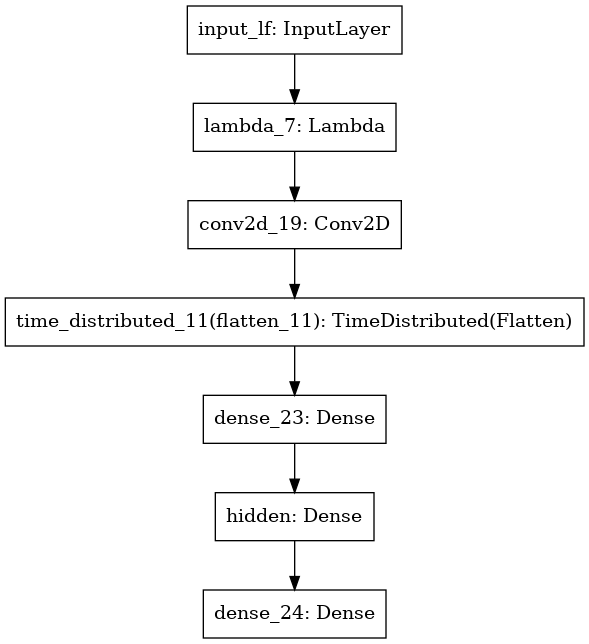

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, None, 129, 16 160         lambda_8[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_37 (LeakyReLU)      (None, None, 129, 16 0           conv2d_20[0][0]                  
__________________________________________________________________

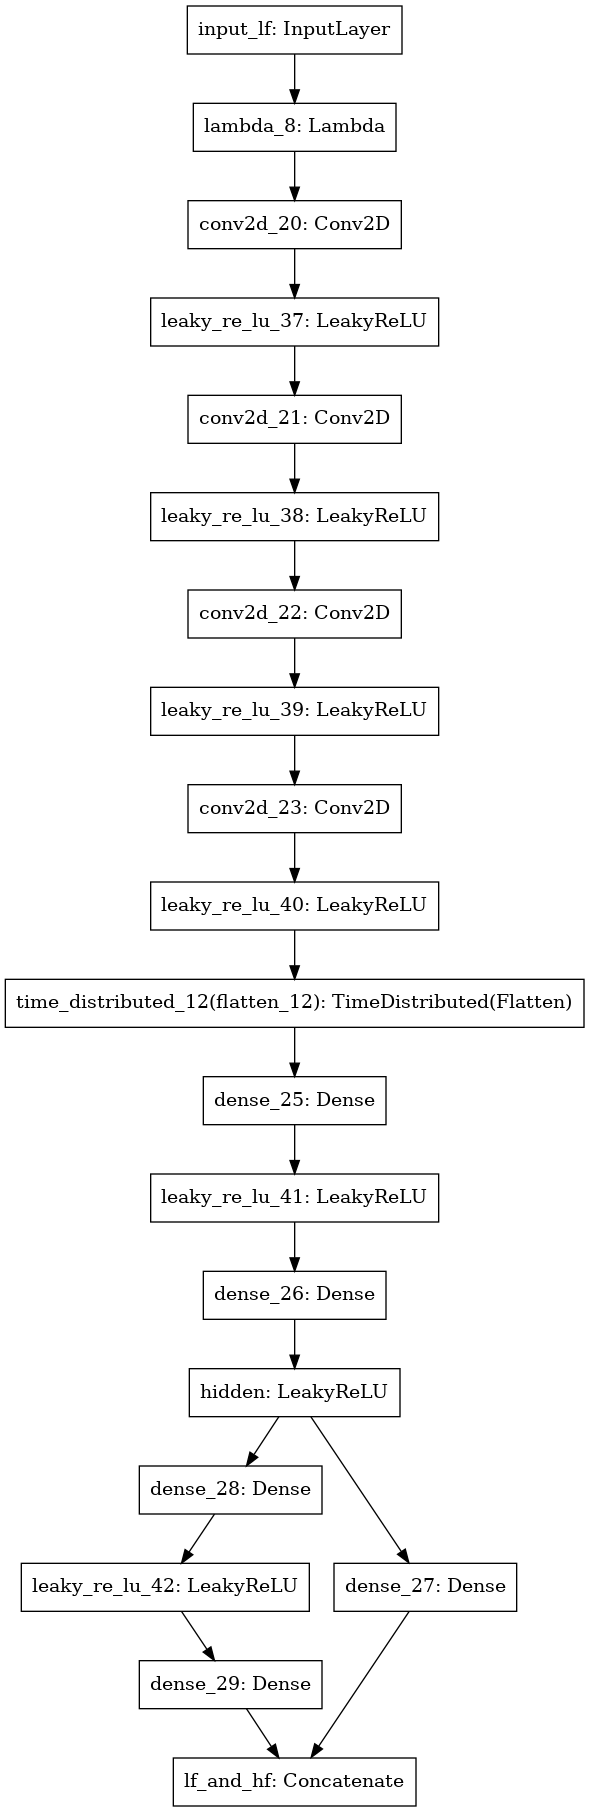

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, None, 129, 16 160         lambda_9[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, 129, 20 1620        conv2d_24[0][0]                  
__________________________________________________________________

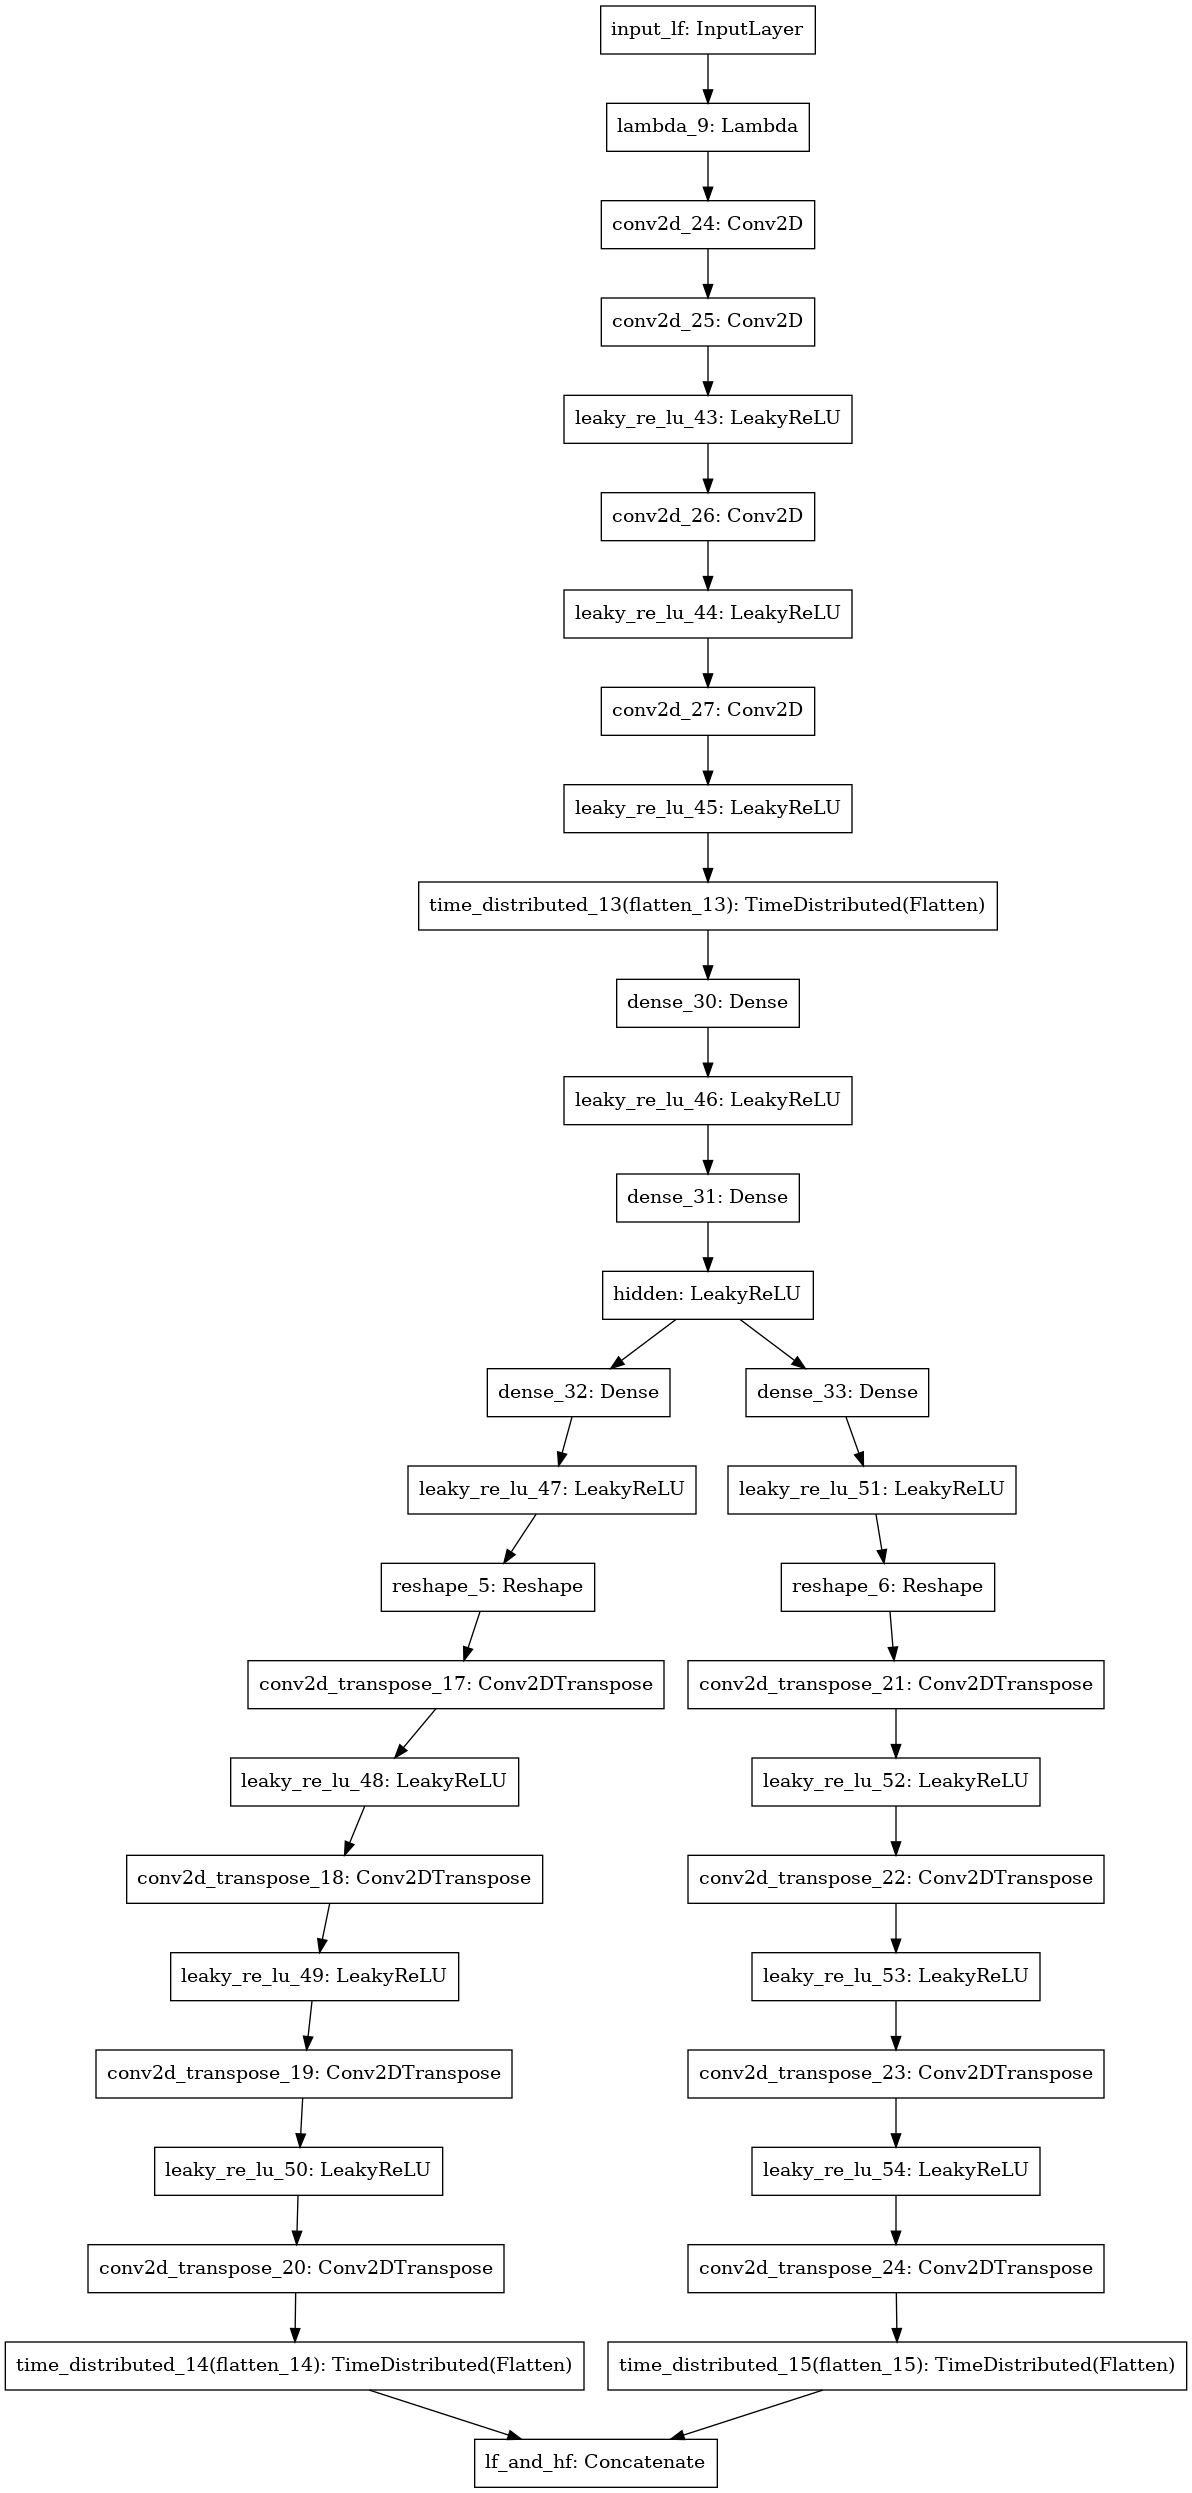

In [4]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

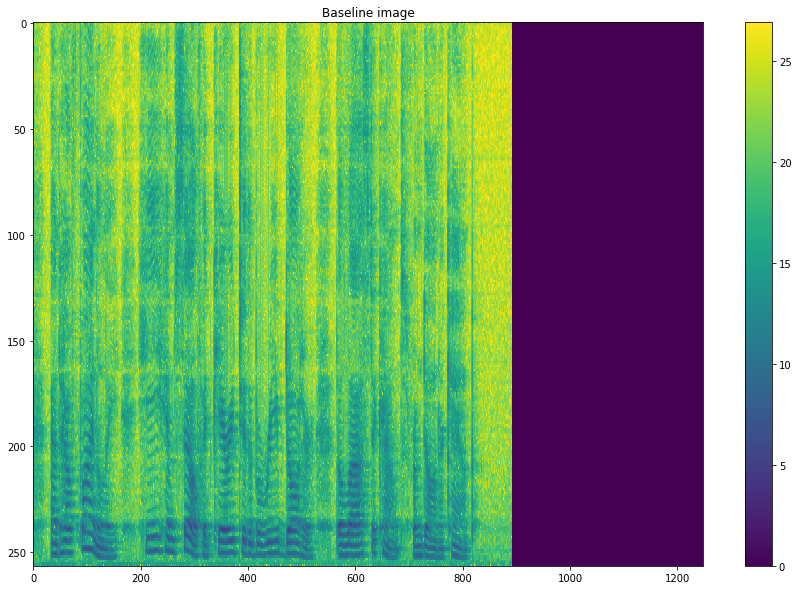

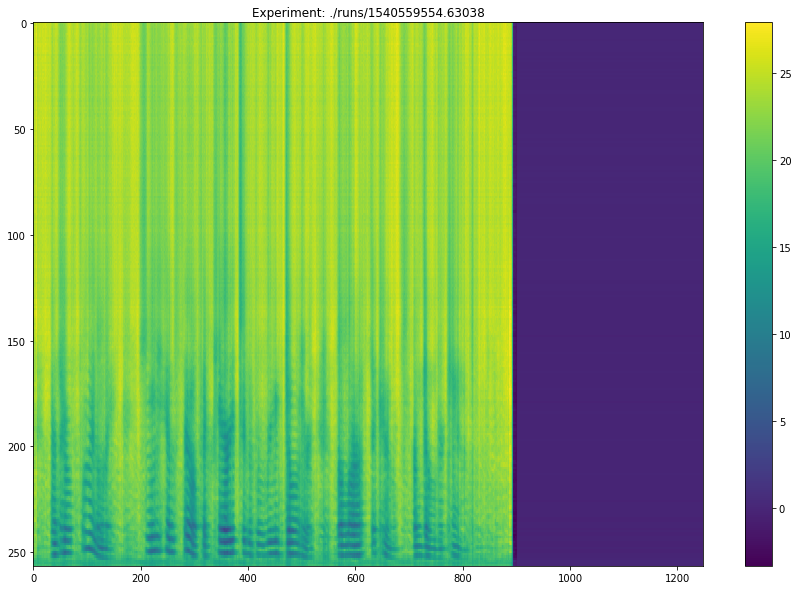

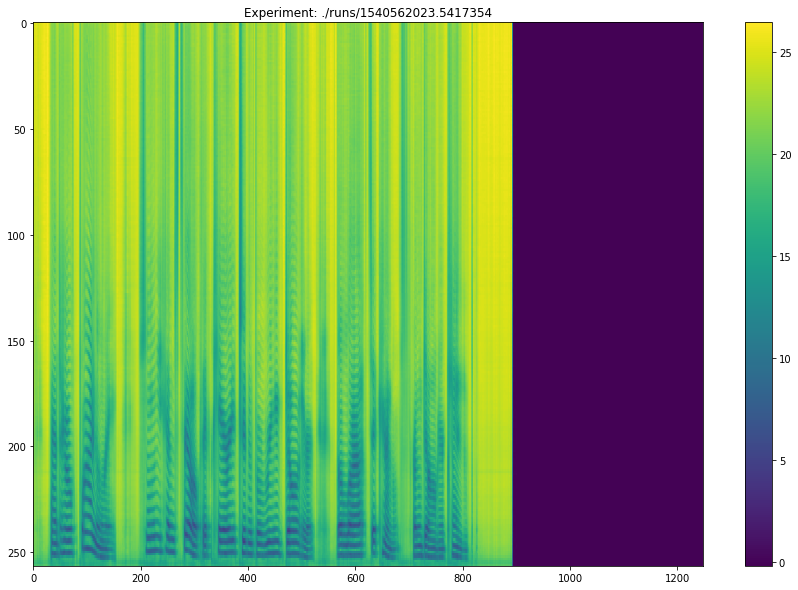

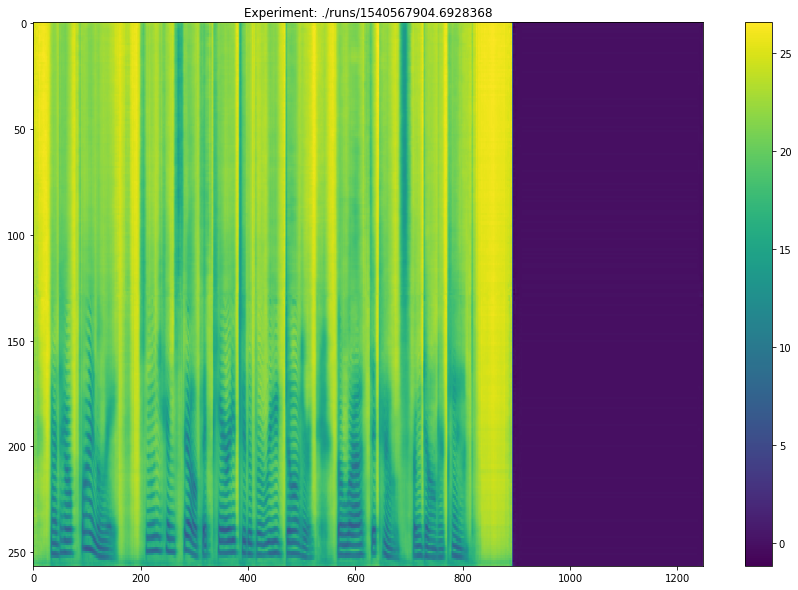

In [5]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]) * STD + MEAN, aspect='auto')
plt.colorbar()
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

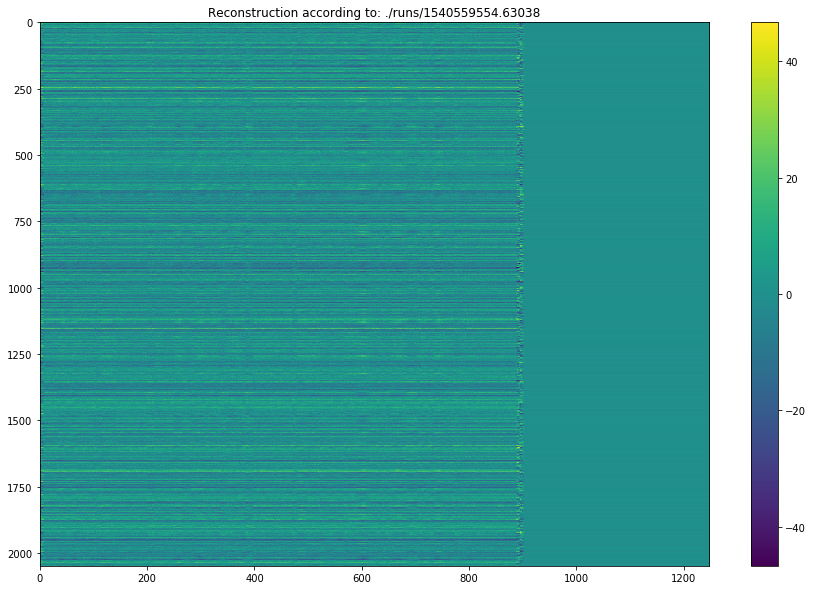

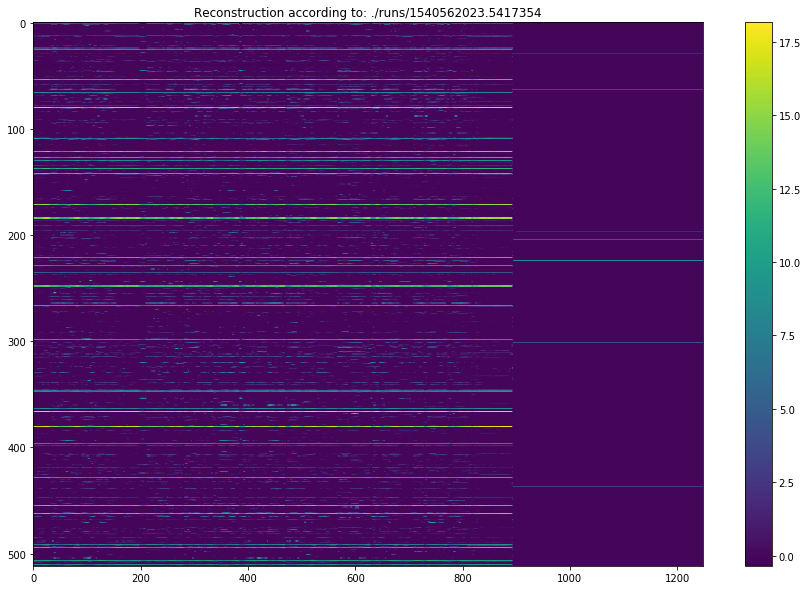

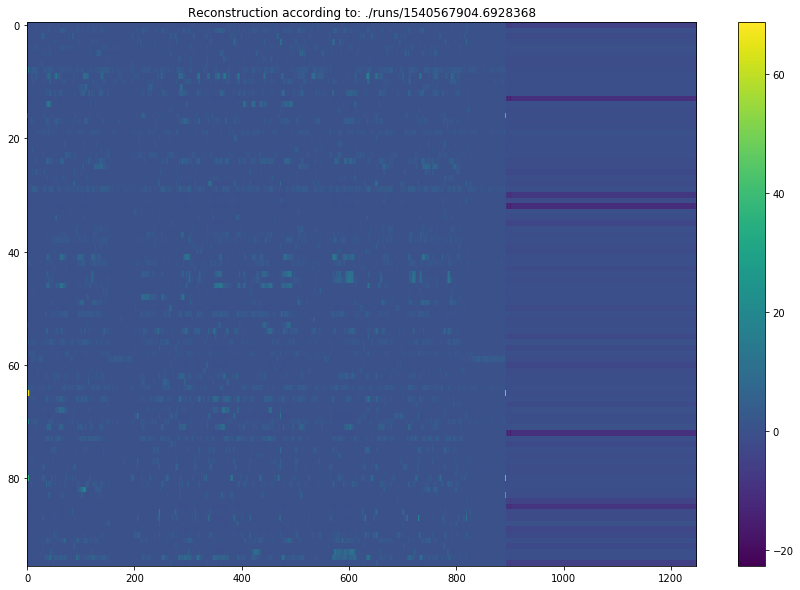

In [6]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = Model(mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = model.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Reconstruction according to: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

Groundtruth signal


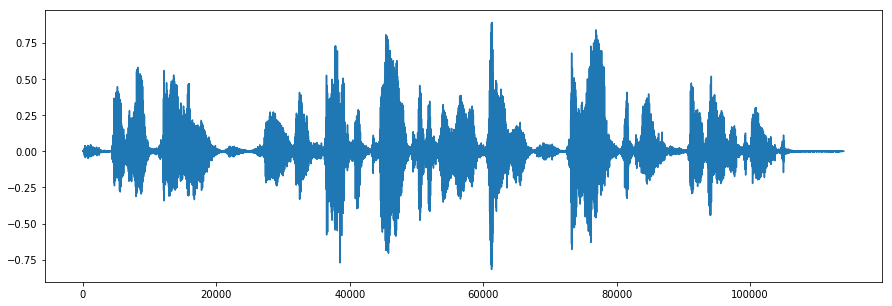

Input signal


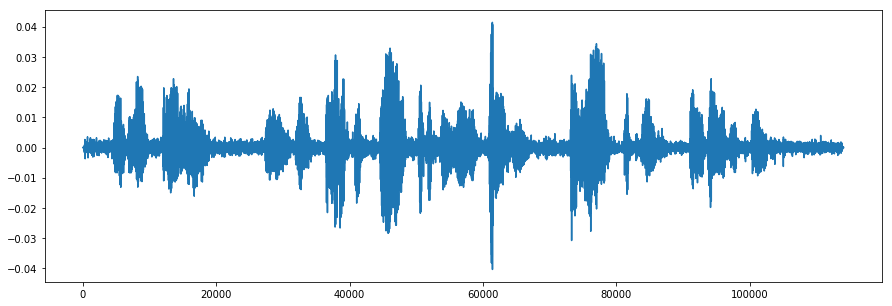

Prediction of ./runs/1540559554.63038


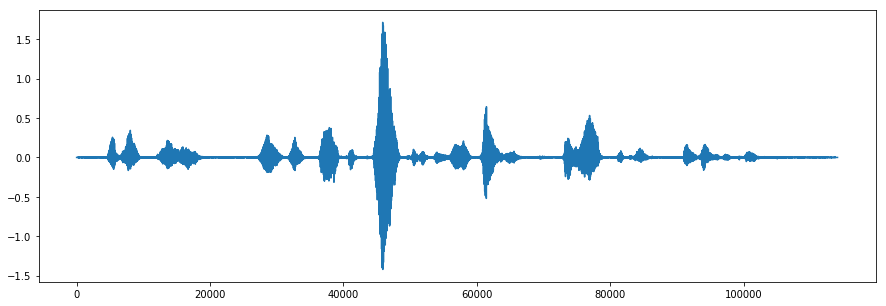

Prediction of ./runs/1540562023.5417354


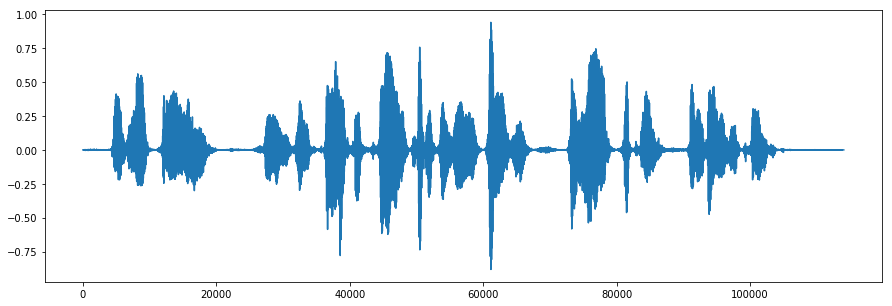

Prediction of ./runs/1540567904.6928368


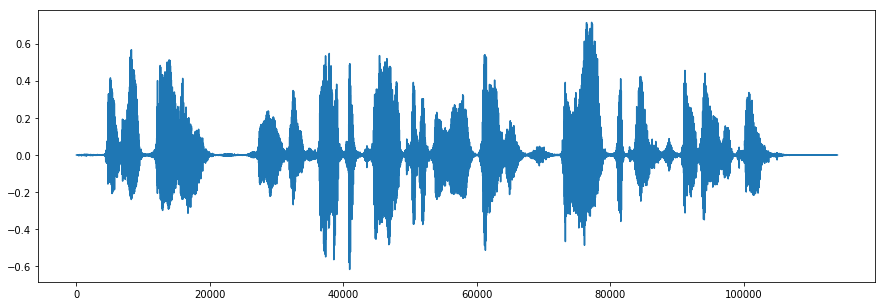

In [10]:
# predicted spectrograms

phase = np.zeros(gt.shape)
phase[:,:,:129] = old_phase
phase[:, :, 129:] = old_phase[:, :, :0:-1]

window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)

length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)

for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))

print("Input signal")
sound = image[0]  * STD + MEAN
spec = np.zeros(gt[0].shape, np.complex)
spec[:,:129] = (np.sqrt(np.exp(-(sound)) * 512) * np.exp(phase[0, :, :129] * 1j))
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]  * STD + MEAN
    sound = np.zeros(length * 128 + 512 - 128)
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound)
    plt.show()
    display(Audio(sound, rate=16000))


##### Metrics

In [11]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    # preds[:, :, :129] = gt[:, :, :129]
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.135475
Predicted by model ./runs/1540559554.63038: 1.2305125000000001 +- 0.1241362148760385
Predicted by model ./runs/1540562023.5417354: 1.6113125 +- 0.23616342825202633
Predicted by model ./runs/1540567904.6928368: 1.53565 +- 0.2760387246384101


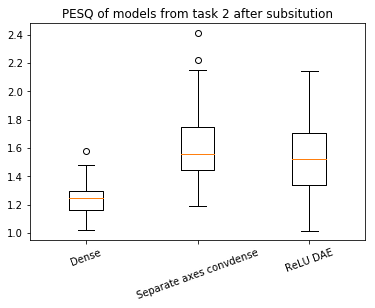

In [12]:
plot_model_names = ["Dense", "Separate axes convdense", "ReLU DAE"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 after subsitution")
plt.show()

[1, 50, 29]


Text(0.5,1,'Percentage of preference across models, according to PESQ, task 2')

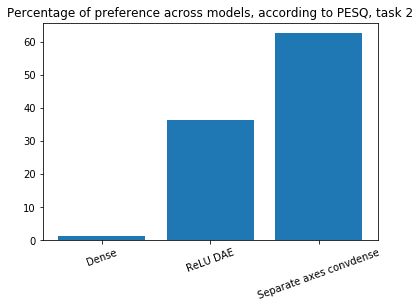

In [13]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2")

In [14]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)


KeyboardInterrupt: 

In [ ]:
plot_model_names = ["Separate axes convdense", "Common axes convdense", "ReLU DAE", "3-encoding", "4-encoding", "2-dense", "3-dense", "4-dense"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 - full reconstruction")
plt.show()

In [ ]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2 - full reconstruction")

In [ ]:
# log power MSE

inp, gtruth = test
preds = mdl.predict(inp)  * STD + MEAN
gtruth = gtruth * STD + MEAN

preds = gtruth * 0
preds[:, :, :129] = inp
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = mdl.predict(inp) * STD + MEAN
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean())



In [ ]:
# log-spectral distance


inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean(), "+-", np.array(lsd).std())

In [ ]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.show()